## Phase 2: Behavioral-Mechanistic Linkage Analysis

### Overview
Phase 1 revealed that deeper transformer layers develop "specialist" features that activate selectively for specific text categories. But what are these specialists actually detecting — the underlying **semantic meaning** or merely **surface-level syntactic patterns**?

This phase tests whether semantically equivalent content presented in different surface forms (symbolic notation vs. verbal description vs. prose explanation) activates the same or different features.

### Objectives
1. Test whether the syntactic (rather than semantic) nature of specialist features has measurable consequences for model behavior
2. Compare specialist feature activation across semantically equivalent inputs that vary in surface form
3. Investigate how the model represents semantically equivalent expressions internally
4. Determine whether model accuracy correlates with specialist feature activation strength
5. Validate Phase 1 findings through behavioral experiments

### What We'll Learn
* Whether specialist features' surface-level pattern detection has downstream behavioral consequences
* How strongly surface form (symbolic vs. verbal vs. prose) affects internal representations
* Whether cosine similarity clusters by surface form or by underlying concept
* The relationship between specialist activation and model performance on mathematical completions
* Whether "understanding" in GPT-2 Small is syntax-dependent or concept-independent

### Hypotheses

**H1 (Specialist Activation):** Specialist features will show significantly higher activation for symbolic forms than verbal/prose forms of the same mathematical expression.
- *Example:* The math specialist activates strongly on `x^2 + 2x + 1` but weakly on "x squared plus two x plus one"
- *Implication if supported:* Specialists detect syntactic patterns (symbols, operators) not semantic content

**H2 (Feature Divergence):** Different surface forms of the same concept will activate largely distinct feature populations, with natural language forms (verbal/prose) sharing more overlap with each other than with symbolic notation.
- *Example:* The top-20 features for symbolic math have <50% overlap with top-20 features for verbal math
- *Implication if supported:* GPT-2's representations are organized by surface form, not underlying meaning

**H3 (Representational Clustering):** Activation vectors will cluster by surface form rather than by concept — "2+2" will be more similar to "5*3" (same form, different concept) than to "two plus two" (same concept, different form).
- *Implication if supported:* Internal representations prioritize syntax over semantics

**H4 (Behavioral Correlation):** Model accuracy on mathematical completions will correlate with specialist activation strength and vary by surface form.
- *Implication if supported:* The syntactic nature of specialist features has downstream behavioral consequences

### Approach
1. **Phase 1 (baseline) Verification (Cells 2-14):** Replicate Phase 1 specialist identification using identical methodology ✅
2. **Matched Pairs Dataset (Cell 4):** Create semantically equivalent expressions in symbolic, verbal, and prose forms ✅
3. **H1 Testing (Cell 15):** Compare specialist feature activation across forms ✅
4. **H2 Testing (Cell 16):** Analyze feature population overlap between forms ✅
5. **H3 Testing (Cell 17, planned):** Compute cosine similarity matrices
6. **H4 Testing (Cell 18, planned):** Behavioral accuracy experiments

### Success Criteria:
- **Strong positive:** All three hypotheses supported—demonstrates that interpretability findings (specialists detect syntax) have direct behavioral implications (performance depends on surface form)
- **Partial finding:** H1 supported but H2 or H3 inconclusive—confirms Phase 1 findings, suggests conceptual understanding may exist elsewhere
- **Null finding:** No activation or accuracy differences by form—challenges Phase 1 interpretation
- **Unexpected finding:** High similarity despite activation differences—motivates circuit-level investigation

### Available SAEs for Comparison
Building on Phase 0a infrastructure:
* Layer 8 Residual Stream (`8-res-jb`) - Math specialist #22917
* Layer 10 Residual Stream (`10-res-jb`) - Python specialist #15983
* Layer 11 Residual Stream (`11-res-jb`) - Conversational specialist #8955, complete specialization baseline


### Expected Outcomes
* **Quantitative:** Specialist activation values, cosine similarity matrices, accuracy rates by form
* **Visualizations:** Activation bar charts, similarity heatmaps, accuracy comparisons, activation-accuracy scatter plots
* **Narrative:** Assessment of each hypothesis with implications for interpretability research


### Prerequisites
* Completed Phase 1 (specialist features identified, padding masking implemented)
* Phase 1 specialist feature IDs: Math #22917, Python #15983, Conversational #8955
* `extract_features()` function with proper attention masking
* Cached SAEs for layers 8, 10, 11

In [1]:
# ============================================================================
# CELL 1: Import Libraries
# ============================================================================

import html
from IPython.display import display, Markdown
import torch
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import display, HTML
import os
import warnings
warnings.filterwarnings('ignore')

# TransformerLens and SAELens
from transformer_lens import HookedTransformer
from sae_lens import SAE

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("✅ All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")

✅ All libraries imported successfully!
PyTorch version: 2.9.0+cpu
Device: cpu


In [2]:
# ============================================================================
# CELL 2: Check SAE Cache Status
# ============================================================================

print("🔍 Checking SAE Cache Status")
print("=" * 70)

# SAEs can be cached in two locations:
# 1. Direct SAELens cache: ~/.cache/sae_lens/
# 2. HuggingFace hub cache: ~/.cache/huggingface/hub/

sae_lens_cache = Path.home() / ".cache" / "sae_lens"
hf_cache = Path.home() / ".cache" / "huggingface" / "hub"

required_saes = {
    "6-res-jb": "blocks.6.hook_resid_pre",
    "8-res-jb": "blocks.8.hook_resid_pre", 
    "10-res-jb": "blocks.10.hook_resid_pre",
    "11-res-jb": "blocks.11.hook_resid_pre"
    
}

def check_sae_cached(sae_path):
    """Check if SAE is cached in either location"""
    # Check direct cache
    direct_path = sae_lens_cache / sae_path
    if direct_path.exists() and (direct_path / "sae_weights.safetensors").exists():
        return True, direct_path
    
    # Check HuggingFace cache
    if hf_cache.exists():
        for root, dirs, files in os.walk(hf_cache):
            if sae_path in root and "sae_weights.safetensors" in files:
                return True, Path(root)
    
    return False, None

all_cached = True
for sae_name, sae_path in required_saes.items():
    is_cached, cache_path = check_sae_cached(sae_path)
    if is_cached:
        print(f"✅ {sae_name}: Cached at {cache_path}")
    else:
        print(f"❌ {sae_name}: Not cached")
        all_cached = False

print("\n" + "=" * 70)

if all_cached:
    print("\n✅ All SAEs are cached and ready to load!")
    print("💡 Proceed to the next cell to load the SAEs")
else:
    print("\n⚠️  Some SAEs need to be downloaded")
    print("\n📥 Run this in terminal to download missing SAEs:")
    print("python3 -c \"from sae_lens import SAE; SAE.from_pretrained('gpt2-small-res-jb', 'blocks.X.hook_resid_pre', 'cpu')\"")

print("=" * 70)

🔍 Checking SAE Cache Status
✅ 6-res-jb: Cached at /home/thebuleganteng/.cache/sae_lens/blocks.6.hook_resid_pre
✅ 8-res-jb: Cached at /home/thebuleganteng/.cache/sae_lens/blocks.8.hook_resid_pre
✅ 10-res-jb: Cached at /home/thebuleganteng/.cache/sae_lens/blocks.10.hook_resid_pre
✅ 11-res-jb: Cached at /home/thebuleganteng/.cache/sae_lens/blocks.11.hook_resid_pre


✅ All SAEs are cached and ready to load!
💡 Proceed to the next cell to load the SAEs


In [3]:
# ============================================================================
# CELL 3: Load LLM & All SAEs for Comparison
# ============================================================================

print("🔧 Loading GPT-2 and multiple SAEs...")
print("=" * 70)

# Load model
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    device="cpu"
)
print(f"✅ Model loaded: {model.cfg.model_name}")
print()

# SAE cache location (all SAEs are here now)
sae_cache_base = Path.home() / ".cache" / "sae_lens"

# SAE Configuration
available_saes = {
    "6-res-jb": {
        "description": "Layer 6 Residual Stream",
        "hook_point": "blocks.6.hook_resid_pre",
        "d_in": 768,
        "d_sae": 24576
    },
    "8-res-jb": {
        "description": "Layer 8 Residual Stream",
        "hook_point": "blocks.8.hook_resid_pre",
        "d_in": 768,
        "d_sae": 24576
    },
    "10-res-jb": {
        "description": "Layer 10 Residual Stream",
        "hook_point": "blocks.10.hook_resid_pre",
        "d_in": 768,
        "d_sae": 24576
    },
    "11-res-jb": {
        "description": "Layer 11 Residual Stream (Final Layer)",
        "hook_point": "blocks.11.hook_resid_pre",
        "d_in": 768,
        "d_sae": 24576
    }
}

# Load SAEs from disk
loaded_saes = {}

print("Loading SAEs from cache...")
for sae_name, sae_config in available_saes.items():
    print(f"\n📦 Loading {sae_name}: {sae_config['description']}")
    
    sae_path = sae_cache_base / sae_config['hook_point']
    
    if not sae_path.exists():
        print(f"   ❌ Not found at: {sae_path}")
        continue
    
    try:
        # Load directly from disk (no download, no progress bar issues)
        sae = SAE.load_from_disk(str(sae_path))
        
        loaded_saes[sae_name] = {
            "sae": sae,
            "config": sae_config
        }
        print(f"   ✅ Loaded successfully")
        print(f"   📊 Dimensions: {sae_config['d_in']} → {sae_config['d_sae']}")
        print(f"   🎯 Hook point: {sae_config['hook_point']}")
        
    except Exception as e:
        print(f"   ❌ Failed to load: {e}")
        import traceback
        traceback.print_exc()

print("\n" + "=" * 70)
print(f"✅ Successfully loaded {len(loaded_saes)}/{len(available_saes)} SAEs")
if loaded_saes:
    print(f"📋 Available SAEs: {list(loaded_saes.keys())}")
    print("\n🎯 Ready for Phase 2 comparison analysis!")
else:
    print("⚠️  No SAEs loaded successfully.")

print("=" * 70)

🔧 Loading GPT-2 and multiple SAEs...


`torch_dtype` is deprecated! Use `dtype` instead!


Loaded pretrained model gpt2-small into HookedTransformer
✅ Model loaded: gpt2

Loading SAEs from cache...

📦 Loading 6-res-jb: Layer 6 Residual Stream
   ✅ Loaded successfully
   📊 Dimensions: 768 → 24576
   🎯 Hook point: blocks.6.hook_resid_pre

📦 Loading 8-res-jb: Layer 8 Residual Stream
   ✅ Loaded successfully
   📊 Dimensions: 768 → 24576
   🎯 Hook point: blocks.8.hook_resid_pre

📦 Loading 10-res-jb: Layer 10 Residual Stream
   ✅ Loaded successfully
   📊 Dimensions: 768 → 24576
   🎯 Hook point: blocks.10.hook_resid_pre

📦 Loading 11-res-jb: Layer 11 Residual Stream (Final Layer)
   ✅ Loaded successfully
   📊 Dimensions: 768 → 24576
   🎯 Hook point: blocks.11.hook_resid_pre

✅ Successfully loaded 4/4 SAEs
📋 Available SAEs: ['6-res-jb', '8-res-jb', '10-res-jb', '11-res-jb']

🎯 Ready for Phase 2 comparison analysis!


In [4]:
# =============================================================================
# Cell 4: PHASE 1 CATEGORY TEXTS (For Specialist Verification)
# =============================================================================
# Smaller set of original category texts used in Phase 1 to verify specialist features
# still activate as expected before running matched pairs analysis

print("\n📚 Loading Phase 1 Categories Dataset")
print("=" * 70)


baseline_categories = {
    "Python": [
        "def factorial(n):\n    return 1 if n == 0 else n * factorial(n-1)",
        "import torch\nimport numpy as np\nfrom transformers import AutoModel",
        "class NeuralNetwork(nn.Module):\n    def __init__(self):",
        "for i in range(len(data)):\n    result.append(data[i] ** 2)",
        "try:\n    x = int(input())\nexcept ValueError:\n    print('Error')",
        "lambda x: x ** 2 + 3 * x - 5",
        "if __name__ == '__main__':\n    main()",
        "return [x for x in lst if x > 0]",
        "print(f'Result: {sum(values) / len(values):.2f}')",
        "pip install transformers torch numpy pandas",
    ],
    "URLs": [
        "https://www.github.com/anthropics/claude",
        "Visit our website at http://example.com/products",
        "<html><body><h1>Welcome</h1></body></html>",
        "<div class='container'><p>Content here</p></div>",
        "GET /api/v1/users HTTP/1.1",
        "mailto:support@example.com",
        "www.stackoverflow.com/questions/12345",
        "ftp://files.example.org/downloads/",
        "Click here: https://bit.ly/abc123",
        "Check out reddit.com/r/machinelearning",
    ],
    "Math": [
        "f(x) = x^2 + 2x + 1",
        "∫(x^2 + 3x)dx = x^3/3 + 3x^2/2 + C",
        "lim(x→0) sin(x)/x = 1",
        "∑(i=1 to n) i = n(n+1)/2",
        "√(a^2 + b^2) = c",
        "P(A|B) = P(B|A)P(A) / P(B)",
        "E = mc^2",
        "∇f(x,y) = (∂f/∂x, ∂f/∂y)",
        "det([[a,b],[c,d]]) = ad - bc",
        "sin^2(θ) + cos^2(θ) = 1",
    ],
    "Non-English": [
        "Bonjour, comment allez-vous aujourd'hui?",
        "你好，今天天气怎么样？",
        "Hola, ¿cómo estás?",
        "Guten Tag, wie geht es Ihnen?",
        "Здравствуйте, как дела?",
        "こんにちは、元気ですか？",
        "مرحبا، كيف حالك؟",
        "안녕하세요, 잘 지내셨어요?",
        "Ciao, come stai?",
        "Olá, como você está?",
    ],
    "Social": [
        "omg that's so funny 😂😂😂",
        "can't wait for the weekend!! 🎉🎊",
        "just got coffee ☕ feeling good ✨",
        "bruh why is this happening 💀",
        "yaaaas queen!!! 👑💅✨",
        "ngl this is pretty cool 🔥",
        "lmaooo i'm dying 😭😭",
        "tbh idk what to do 🤷‍♀️",
        "mood af rn 💯",
        "this slaps fr fr 🎵🔥",
    ],
    "Formal": [
        "The phenomenon was observed under controlled laboratory conditions.",
        "In accordance with the aforementioned regulations, we hereby submit this proposal.",
        "The hypothesis was tested using a double-blind randomized controlled trial.",
        "Pursuant to Article 12, Section 3 of the aforementioned statute.",
        "The results indicate a statistically significant correlation (p < 0.05).",
        "This paper examines the theoretical frameworks underlying modern economics.",
        "The defendant pleaded not guilty to all charges in the indictment.",
        "We acknowledge the contributions of all co-authors and funding agencies.",
        "The experimental methodology followed established protocols.",
        "In conclusion, further research is warranted to investigate this phenomenon.",
    ],
    "Conversational": [
        "Hey, what's up? Want to grab lunch later?",
        "I think the meeting went pretty well today.",
        "The weather is nice, maybe we should go for a walk.",
        "Did you see that movie everyone's talking about?",
        "I'm planning a trip to Japan next summer.",
        "That restaurant has the best pizza in town.",
        "My cat keeps knocking things off the table.",
        "The traffic was terrible this morning.",
        "I need to finish this project by Friday.",
        "Let's catch up over coffee sometime.",
    ]
}


# Flatten phase 1 categories
baseline_texts = []
baseline_labels = []
for category, text_list in baseline_categories.items():
    for text in text_list:
        baseline_texts.append(text)
        baseline_labels.append(category)


# Indicate successful loading
print(f"\n📋 PHASE 1 VERIFICATION DATASET:")
print(f"   Categories: {list(baseline_categories.keys())}")
print(f"   Total texts: {len(baseline_texts)}")



📚 Loading Phase 1 Categories Dataset

📋 PHASE 1 VERIFICATION DATASET:
   Categories: ['Python', 'URLs', 'Math', 'Non-English', 'Social', 'Formal', 'Conversational']
   Total texts: 70


In [5]:
# ============================================================================
# CELL 5: Load Matched Pairs Dataset
# ============================================================================

print("\n📚 Loading Matched Pairs Dataset")
print("=" * 70)

# =============================================================================
# MATCHED PAIRS (Primary Dataset for Phase 2)
# =============================================================================
# Each pair contains the same concept in multiple surface forms.
# This allows testing whether specialist features respond to syntax/form
# rather than semantic content.

# -----------------------------------------------------------------------------
# SIMPLE MATH PAIRS (33 examples, 3 forms each)
# -----------------------------------------------------------------------------
math_pairs_simple = [
    # Basic addition (7)
    {"symbolic": "2+2", "verbal": "two plus two", "prose": "the sum of two and two", "expected": "4", "category": "addition"},
    {"symbolic": "4+5", "verbal": "four plus five", "prose": "the sum of four and five", "expected": "9", "category": "addition"},
    {"symbolic": "1+1", "verbal": "one plus one", "prose": "the sum of one and one", "expected": "2", "category": "addition"},
    {"symbolic": "3+6", "verbal": "three plus six", "prose": "the sum of three and six", "expected": "9", "category": "addition"},
    {"symbolic": "7+2", "verbal": "seven plus two", "prose": "the sum of seven and two", "expected": "9", "category": "addition"},
    {"symbolic": "5+4", "verbal": "five plus four", "prose": "the sum of five and four", "expected": "9", "category": "addition"},
    {"symbolic": "8+1", "verbal": "eight plus one", "prose": "the sum of eight and one", "expected": "9", "category": "addition"},
    
    # Basic subtraction (7)
    {"symbolic": "8-3", "verbal": "eight minus three", "prose": "three less than eight", "expected": "5", "category": "subtraction"},
    {"symbolic": "7-4", "verbal": "seven minus four", "prose": "four less than seven", "expected": "3", "category": "subtraction"},
    {"symbolic": "9-5", "verbal": "nine minus five", "prose": "five less than nine", "expected": "4", "category": "subtraction"},
    {"symbolic": "6-2", "verbal": "six minus two", "prose": "two less than six", "expected": "4", "category": "subtraction"},
    {"symbolic": "5-1", "verbal": "five minus one", "prose": "one less than five", "expected": "4", "category": "subtraction"},
    {"symbolic": "9-3", "verbal": "nine minus three", "prose": "three less than nine", "expected": "6", "category": "subtraction"},
    {"symbolic": "7-2", "verbal": "seven minus two", "prose": "two less than seven", "expected": "5", "category": "subtraction"},
    
    # Basic multiplication (7)
    {"symbolic": "5*3", "verbal": "five times three", "prose": "five multiplied by three", "expected": "15", "category": "multiplication"},
    {"symbolic": "6*2", "verbal": "six times two", "prose": "six multiplied by two", "expected": "12", "category": "multiplication"},
    {"symbolic": "3*4", "verbal": "three times four", "prose": "three multiplied by four", "expected": "12", "category": "multiplication"},
    {"symbolic": "2*7", "verbal": "two times seven", "prose": "two multiplied by seven", "expected": "14", "category": "multiplication"},
    {"symbolic": "4*4", "verbal": "four times four", "prose": "four multiplied by four", "expected": "16", "category": "multiplication"},
    {"symbolic": "3*3", "verbal": "three times three", "prose": "three multiplied by three", "expected": "9", "category": "multiplication"},
    {"symbolic": "2*8", "verbal": "two times eight", "prose": "two multiplied by eight", "expected": "16", "category": "multiplication"},
    
    # Basic division (7)
    {"symbolic": "10/2", "verbal": "ten divided by two", "prose": "half of ten", "expected": "5", "category": "division"},
    {"symbolic": "9/3", "verbal": "nine divided by three", "prose": "a third of nine", "expected": "3", "category": "division"},
    {"symbolic": "8/4", "verbal": "eight divided by four", "prose": "a quarter of eight", "expected": "2", "category": "division"},
    {"symbolic": "6/2", "verbal": "six divided by two", "prose": "half of six", "expected": "3", "category": "division"},
    {"symbolic": "12/4", "verbal": "twelve divided by four", "prose": "a quarter of twelve", "expected": "3", "category": "division"},
    {"symbolic": "15/3", "verbal": "fifteen divided by three", "prose": "a third of fifteen", "expected": "5", "category": "division"},
    {"symbolic": "8/2", "verbal": "eight divided by two", "prose": "half of eight", "expected": "4", "category": "division"},
    
    # Exponents (5)
    {"symbolic": "3^2", "verbal": "three squared", "prose": "three to the power of two", "expected": "9", "category": "exponents"},
    {"symbolic": "2^3", "verbal": "two cubed", "prose": "two to the power of three", "expected": "8", "category": "exponents"},
    {"symbolic": "4^2", "verbal": "four squared", "prose": "four to the power of two", "expected": "16", "category": "exponents"},
    {"symbolic": "5^2", "verbal": "five squared", "prose": "five to the power of two", "expected": "25", "category": "exponents"},
    {"symbolic": "2^4", "verbal": "two to the fourth", "prose": "two to the power of four", "expected": "16", "category": "exponents"},
]


# -----------------------------------------------------------------------------
# COMPLEX MATH PAIRS (33 examples, 3 forms each - 3 per category)
# -----------------------------------------------------------------------------
math_pairs_complex = [
    # Quadratic expressions (3)
    {"symbolic": "x^2 + 2x + 1", "verbal": "x squared plus two x plus one", "prose": "the square of x added to twice x and one", "expected": "(x+1)^2", "category": "Quadratic expressions"},
    {"symbolic": "x^2 - 9", "verbal": "x squared minus nine", "prose": "the square of x with nine subtracted", "expected": "(x+3)(x-3)", "category": "Quadratic expressions"},
    {"symbolic": "x^2 - 5x + 6", "verbal": "x squared minus five x plus six", "prose": "the square of x minus five times x plus six", "expected": "(x-2)(x-3)", "category": "Quadratic expressions"},
    
    # Pythagorean theorem variants (3)
    {"symbolic": "a^2 + b^2 = c^2", "verbal": "a squared plus b squared equals c squared", "prose": "the sum of the squares of a and b equals the square of c", "expected": "Pythagorean theorem", "category": "Pythagorean theorem variants"},
    {"symbolic": "√(a^2 + b^2)", "verbal": "the square root of a squared plus b squared", "prose": "the square root of the sum of a squared and b squared", "expected": "c (hypotenuse)", "category": "Pythagorean theorem variants"},
    {"symbolic": "c = √(3^2 + 4^2) = 5", "verbal": "c equals the square root of three squared plus four squared equals five", "prose": "c equals the square root of nine plus sixteen which equals five", "expected": "3-4-5 triangle", "category": "Pythagorean theorem variants"},
    
    # Famous equations (3)
    {"symbolic": "E = mc^2", "verbal": "E equals m c squared", "prose": "energy equals mass times the speed of light squared", "expected": "mass-energy equivalence", "category": "Famous equations"},
    {"symbolic": "F = ma", "verbal": "F equals m a", "prose": "force equals mass times acceleration", "expected": "Newton's second law", "category": "Famous equations"},
    {"symbolic": "PV = nRT", "verbal": "P V equals n R T", "prose": "pressure times volume equals the number of moles times the gas constant times temperature", "expected": "ideal gas law", "category": "Famous equations"},
    
    # Trigonometric identities (3)
    {"symbolic": "sin^2(θ) + cos^2(θ) = 1", "verbal": "sine squared theta plus cosine squared theta equals one", "prose": "the square of the sine of theta plus the square of the cosine of theta equals one", "expected": "Pythagorean identity", "category": "Trigonometric identities"},
    {"symbolic": "sin(2θ) = 2sin(θ)cos(θ)", "verbal": "sine of two theta equals two sine theta cosine theta", "prose": "the sine of twice theta equals twice the product of sine theta and cosine theta", "expected": "double angle formula", "category": "Trigonometric identities"},
    {"symbolic": "tan(θ) = sin(θ)/cos(θ)", "verbal": "tangent of theta equals sine of theta over cosine of theta", "prose": "the tangent of theta equals the sine of theta divided by the cosine of theta", "expected": "tangent definition", "category": "Trigonometric identities"},
    
    # Exponential/logarithmic (3)
    {"symbolic": "e^(iπ) + 1 = 0", "verbal": "e to the i pi plus one equals zero", "prose": "e raised to the power of i times pi plus one equals zero", "expected": "Euler's identity", "category": "Exponential/logarithmic"},
    {"symbolic": "ln(e^x) = x", "verbal": "natural log of e to the x equals x", "prose": "the natural logarithm of e raised to x equals x", "expected": "log-exp inverse", "category": "Exponential/logarithmic"},
    {"symbolic": "log_a(xy) = log_a(x) + log_a(y)", "verbal": "log base a of x y equals log base a of x plus log base a of y", "prose": "the logarithm base a of the product of x and y equals the sum of the logarithms base a of x and y", "expected": "log product rule", "category": "Exponential/logarithmic"},
    
    # Calculus - derivatives (3)
    {"symbolic": "d/dx(x^2) = 2x", "verbal": "the derivative of x squared equals two x", "prose": "the derivative with respect to x of x squared is two times x", "expected": "power rule", "category": "Calculus - derivatives"},
    {"symbolic": "d/dx(sin(x)) = cos(x)", "verbal": "the derivative of sine x equals cosine x", "prose": "the derivative with respect to x of sine of x is cosine of x", "expected": "trig derivative", "category": "Calculus - derivatives"},
    {"symbolic": "d/dx(e^x) = e^x", "verbal": "the derivative of e to the x equals e to the x", "prose": "the derivative with respect to x of e raised to x is e raised to x", "expected": "exponential derivative", "category": "Calculus - derivatives"},
    
    # Calculus - integrals (3)
    {"symbolic": "∫x^2 dx = x^3/3 + C", "verbal": "the integral of x squared dx equals x cubed over three plus C", "prose": "the integral of x squared with respect to x is x cubed divided by three plus a constant", "expected": "power rule integral", "category": "Calculus - integrals"},
    {"symbolic": "∫sin(x)dx = -cos(x) + C", "verbal": "the integral of sine x dx equals negative cosine x plus C", "prose": "the integral of sine of x with respect to x is negative cosine of x plus a constant", "expected": "trig integral", "category": "Calculus - integrals"},
    {"symbolic": "∫e^x dx = e^x + C", "verbal": "the integral of e to the x dx equals e to the x plus C", "prose": "the integral of e raised to x with respect to x is e raised to x plus a constant", "expected": "exponential integral", "category": "Calculus - integrals"},
    
    # Summation (3)
    {"symbolic": "∑(i=1 to n) i = n(n+1)/2", "verbal": "the sum from i equals one to n of i equals n times n plus one over two", "prose": "the sum of all integers from one to n equals n times n plus one divided by two", "expected": "arithmetic series", "category": "Summation"},
    {"symbolic": "∑(i=1 to n) i^2 = n(n+1)(2n+1)/6", "verbal": "the sum from i equals one to n of i squared equals n times n plus one times two n plus one over six", "prose": "the sum of the squares of all integers from one to n equals n times n plus one times two n plus one divided by six", "expected": "sum of squares", "category": "Summation"},
    {"symbolic": "∑(i=0 to n) r^i = (1-r^(n+1))/(1-r)", "verbal": "the sum from i equals zero to n of r to the i equals one minus r to the n plus one over one minus r", "prose": "the sum of r raised to the i from zero to n equals one minus r raised to n plus one divided by one minus r", "expected": "geometric series", "category": "Summation"},
    
    # Limits (3)
    {"symbolic": "lim(x→0) sin(x)/x = 1", "verbal": "the limit as x approaches zero of sine x over x equals one", "prose": "the limit of sine of x divided by x as x approaches zero is one", "expected": "fundamental trig limit", "category": "Limits"},
    {"symbolic": "lim(x→∞) (1 + 1/x)^x = e", "verbal": "the limit as x approaches infinity of one plus one over x to the x equals e", "prose": "the limit of one plus one divided by x raised to the power x as x approaches infinity is e", "expected": "definition of e", "category": "Limits"},
    {"symbolic": "lim(x→0) (e^x - 1)/x = 1", "verbal": "the limit as x approaches zero of e to the x minus one over x equals one", "prose": "the limit of e raised to x minus one divided by x as x approaches zero is one", "expected": "exponential limit", "category": "Limits"},
    
    # Quadratic formula (3)
    {"symbolic": "x = (-b ± √(b^2-4ac))/2a", "verbal": "x equals negative b plus or minus the square root of b squared minus four a c all over two a", "prose": "x equals the negation of b plus or minus the square root of b squared minus four times a times c all divided by twice a", "expected": "quadratic formula", "category": "Quadratic formula"},
    {"symbolic": "b^2 - 4ac", "verbal": "b squared minus four a c", "prose": "the square of b minus four times a times c", "expected": "discriminant", "category": "Quadratic formula"},
    {"symbolic": "x = -b/2a", "verbal": "x equals negative b over two a", "prose": "x equals the negation of b divided by twice a", "expected": "vertex x-coordinate", "category": "Quadratic formula"},
    
    # Matrix/determinant (3)
    {"symbolic": "det(A) = ad - bc", "verbal": "determinant of A equals a d minus b c", "prose": "the determinant of matrix A is a times d minus b times c", "expected": "2x2 determinant", "category": "Matrix/determinant"},
    {"symbolic": "A^(-1) = (1/det(A)) * adj(A)", "verbal": "A inverse equals one over the determinant of A times the adjugate of A", "prose": "the inverse of matrix A equals one divided by the determinant of A multiplied by the adjugate of A", "expected": "matrix inverse formula", "category": "Matrix/determinant"},
    {"symbolic": "det(AB) = det(A) * det(B)", "verbal": "determinant of A B equals determinant of A times determinant of B", "prose": "the determinant of the product of A and B equals the product of their determinants", "expected": "determinant product rule", "category": "Matrix/determinant"},
]


# -----------------------------------------------------------------------------
# PYTHON PAIRS (35 examples, 2 forms each)
# -----------------------------------------------------------------------------
python_pairs = [
    # Function definitions (5)
    {"code": "def add(x, y): return x + y", "pseudo": "define function add that takes x and y and returns x plus y", "description": "function definition with return"},
    {"code": "def greet(name): print(f'Hello {name}')", "pseudo": "define function greet that takes name and prints hello followed by the name", "description": "function with print"},
    {"code": "def square(n): return n * n", "pseudo": "define function square that takes n and returns n times n", "description": "simple math function"},
    {"code": "def is_even(x): return x % 2 == 0", "pseudo": "define function is even that takes x and returns true if x divided by two has no remainder", "description": "boolean return function"},
    {"code": "def get_max(a, b): return a if a > b else b", "pseudo": "define function get max that takes a and b and returns a if a is greater than b otherwise returns b", "description": "conditional return function"},
    
    # Loops (5)
    {"code": "for i in range(10):", "pseudo": "loop through numbers zero to nine", "description": "for loop with range"},
    {"code": "for item in my_list:", "pseudo": "loop through each item in my list", "description": "for loop over list"},
    {"code": "while x > 0:", "pseudo": "while x is greater than zero", "description": "while loop condition"},
    {"code": "for i, val in enumerate(data):", "pseudo": "loop through data with both index and value", "description": "enumerate loop"},
    {"code": "for key, value in dict.items():", "pseudo": "loop through each key and value pair in the dictionary", "description": "dictionary iteration"},
    
    # Conditionals (5)
    {"code": "if x > 0: return True", "pseudo": "if x is greater than zero then return true", "description": "conditional return"},
    {"code": "if x > 0 and y < 10:", "pseudo": "if x is greater than zero and y is less than ten", "description": "compound conditional"},
    {"code": "if x in my_list:", "pseudo": "if x is contained in my list", "description": "membership check"},
    {"code": "if not found:", "pseudo": "if found is false", "description": "negation conditional"},
    {"code": "result = a if condition else b", "pseudo": "set result to a if condition is true otherwise set it to b", "description": "ternary expression"},
    
    # List operations (5)
    {"code": "len(my_list)", "pseudo": "the length of my list", "description": "length function"},
    {"code": "my_list.append(item)", "pseudo": "add item to the end of my list", "description": "list append"},
    {"code": "my_list.pop()", "pseudo": "remove and return the last item from my list", "description": "list pop"},
    {"code": "sorted(my_list)", "pseudo": "return a sorted copy of my list", "description": "list sorting"},
    {"code": "my_list[::-1]", "pseudo": "reverse my list", "description": "list reversal"},
    
    # Variable assignments (5)
    {"code": "x = y + z", "pseudo": "set x equal to y plus z", "description": "variable assignment"},
    {"code": "x, y = y, x", "pseudo": "swap the values of x and y", "description": "variable swap"},
    {"code": "count += 1", "pseudo": "increase count by one", "description": "increment"},
    {"code": "total = sum(values)", "pseudo": "set total to the sum of all values", "description": "sum assignment"},
    {"code": "name = input('Enter name: ')", "pseudo": "ask the user to enter their name and store it in name", "description": "user input"},
    
    # List comprehensions (5)
    {"code": "[x for x in lst if x > 0]", "pseudo": "create a list of all x from lst where x is greater than zero", "description": "filtered list comprehension"},
    {"code": "[x * 2 for x in range(5)]", "pseudo": "create a list of x times two for each x from zero to four", "description": "mapped list comprehension"},
    {"code": "[x.upper() for x in words]", "pseudo": "create a list of each word in uppercase", "description": "string transformation comprehension"},
    {"code": "{x: x**2 for x in range(5)}", "pseudo": "create a dictionary mapping each number to its square for zero to four", "description": "dictionary comprehension"},
    {"code": "[row[0] for row in matrix]", "pseudo": "create a list of the first element from each row in matrix", "description": "column extraction"},
    
    # String operations (5)
    {"code": "text.split(' ')", "pseudo": "split text into a list by spaces", "description": "string split"},
    {"code": "' '.join(words)", "pseudo": "join all words with spaces between them", "description": "string join"},
    {"code": "text.strip()", "pseudo": "remove whitespace from both ends of text", "description": "string strip"},
    {"code": "text.replace('a', 'b')", "pseudo": "replace all occurrences of a with b in text", "description": "string replace"},
    {"code": "f'Hello {name}, you are {age}'", "pseudo": "create a string saying hello to name and stating their age", "description": "f-string formatting"},
]


# -----------------------------------------------------------------------------
# NON-ENGLISH PAIRS (35 examples, 3 forms: Spanish, French, German)
# Tests: Does the Non-English specialist fire regardless of which language?
# -----------------------------------------------------------------------------
non_english_pairs = [
    # Greetings (5)
    {"spanish": "Hola, ¿cómo estás?", "french": "Bonjour, comment ça va?", "german": "Hallo, wie geht es dir?", "english_meaning": "Hello, how are you?"},
    {"spanish": "Buenos días", "french": "Bonjour", "german": "Guten Morgen", "english_meaning": "Good morning"},
    {"spanish": "Buenas noches", "french": "Bonne nuit", "german": "Gute Nacht", "english_meaning": "Good night"},
    {"spanish": "Hasta luego", "french": "À bientôt", "german": "Bis später", "english_meaning": "See you later"},
    {"spanish": "Mucho gusto", "french": "Enchanté", "german": "Freut mich", "english_meaning": "Nice to meet you"},
    
    # Common phrases (5)
    {"spanish": "Por favor", "french": "S'il vous plaît", "german": "Bitte", "english_meaning": "Please"},
    {"spanish": "Gracias", "french": "Merci", "german": "Danke", "english_meaning": "Thank you"},
    {"spanish": "De nada", "french": "De rien", "german": "Bitte schön", "english_meaning": "You're welcome"},
    {"spanish": "Lo siento", "french": "Je suis désolé", "german": "Es tut mir leid", "english_meaning": "I'm sorry"},
    {"spanish": "No entiendo", "french": "Je ne comprends pas", "german": "Ich verstehe nicht", "english_meaning": "I don't understand"},
    
    # Questions (5)
    {"spanish": "¿Dónde está el baño?", "french": "Où sont les toilettes?", "german": "Wo ist die Toilette?", "english_meaning": "Where is the bathroom?"},
    {"spanish": "¿Cuánto cuesta?", "french": "Combien ça coûte?", "german": "Wie viel kostet das?", "english_meaning": "How much does it cost?"},
    {"spanish": "¿Qué hora es?", "french": "Quelle heure est-il?", "german": "Wie spät ist es?", "english_meaning": "What time is it?"},
    {"spanish": "¿Cómo te llamas?", "french": "Comment tu t'appelles?", "german": "Wie heißt du?", "english_meaning": "What's your name?"},
    {"spanish": "¿Hablas inglés?", "french": "Parlez-vous anglais?", "german": "Sprechen Sie Englisch?", "english_meaning": "Do you speak English?"},
    
    # Statements about self (5)
    {"spanish": "Me llamo María", "french": "Je m'appelle Marie", "german": "Ich heiße Maria", "english_meaning": "My name is Maria"},
    {"spanish": "Tengo veinte años", "french": "J'ai vingt ans", "german": "Ich bin zwanzig Jahre alt", "english_meaning": "I am twenty years old"},
    {"spanish": "Soy de España", "french": "Je suis de France", "german": "Ich komme aus Deutschland", "english_meaning": "I am from [country]"},
    {"spanish": "Vivo en Madrid", "french": "J'habite à Paris", "german": "Ich wohne in Berlin", "english_meaning": "I live in [city]"},
    {"spanish": "Trabajo como profesor", "french": "Je travaille comme professeur", "german": "Ich arbeite als Lehrer", "english_meaning": "I work as a teacher"},
    
    # Daily activities (5)
    {"spanish": "Voy al trabajo", "french": "Je vais au travail", "german": "Ich gehe zur Arbeit", "english_meaning": "I'm going to work"},
    {"spanish": "Quiero comer algo", "french": "Je veux manger quelque chose", "german": "Ich möchte etwas essen", "english_meaning": "I want to eat something"},
    {"spanish": "Necesito dormir", "french": "J'ai besoin de dormir", "german": "Ich muss schlafen", "english_meaning": "I need to sleep"},
    {"spanish": "Me gusta leer libros", "french": "J'aime lire des livres", "german": "Ich lese gerne Bücher", "english_meaning": "I like to read books"},
    {"spanish": "Estoy aprendiendo español", "french": "J'apprends le français", "german": "Ich lerne Deutsch", "english_meaning": "I'm learning [language]"},
    
    # Weather and environment (5)
    {"spanish": "Hace buen tiempo hoy", "french": "Il fait beau aujourd'hui", "german": "Das Wetter ist heute schön", "english_meaning": "The weather is nice today"},
    {"spanish": "Está lloviendo", "french": "Il pleut", "german": "Es regnet", "english_meaning": "It's raining"},
    {"spanish": "Hace mucho calor", "french": "Il fait très chaud", "german": "Es ist sehr heiß", "english_meaning": "It's very hot"},
    {"spanish": "El cielo está despejado", "french": "Le ciel est dégagé", "german": "Der Himmel ist klar", "english_meaning": "The sky is clear"},
    {"spanish": "Me encanta la naturaleza", "french": "J'adore la nature", "german": "Ich liebe die Natur", "english_meaning": "I love nature"},
    
    # Opinions and feelings (5)
    {"spanish": "Estoy muy feliz", "french": "Je suis très heureux", "german": "Ich bin sehr glücklich", "english_meaning": "I am very happy"},
    {"spanish": "Esto es interesante", "french": "C'est intéressant", "german": "Das ist interessant", "english_meaning": "This is interesting"},
    {"spanish": "No me gusta esto", "french": "Je n'aime pas ça", "german": "Das gefällt mir nicht", "english_meaning": "I don't like this"},
    {"spanish": "Es muy importante", "french": "C'est très important", "german": "Das ist sehr wichtig", "english_meaning": "It's very important"},
    {"spanish": "Creo que tienes razón", "french": "Je pense que tu as raison", "german": "Ich glaube, du hast recht", "english_meaning": "I think you're right"},
]


# -----------------------------------------------------------------------------
# SOCIAL PAIRS (35 examples, 3 forms: full_social, partial_social, standard)
# Tests: Does the Social specialist fire based on slang/emoji intensity?
# -----------------------------------------------------------------------------
social_pairs = [
    # Excitement/enthusiasm (7)
    {"full_social": "omg that's so funny 😂😂😂", "partial_social": "omg thats so funny", "standard": "That's very funny", "meaning": "expressing amusement"},
    {"full_social": "yaaaas queen!!! 👑💅✨", "partial_social": "yaaas queen", "standard": "I strongly approve", "meaning": "expressing strong approval"},
    {"full_social": "this slaps fr fr 🔥💯", "partial_social": "this slaps fr fr", "standard": "This is really good", "meaning": "expressing quality"},
    {"full_social": "im literally dying rn 💀😭", "partial_social": "im literally dying rn", "standard": "I find this extremely funny", "meaning": "expressing intense amusement"},
    {"full_social": "lets gooo!!! 🎉🙌", "partial_social": "lets gooo", "standard": "I'm very excited about this", "meaning": "expressing excitement"},
    {"full_social": "no cap this is fire 🔥🔥", "partial_social": "no cap this is fire", "standard": "Honestly, this is excellent", "meaning": "expressing genuine praise"},
    {"full_social": "slay bestie!!! 💖✨👏", "partial_social": "slay bestie", "standard": "Well done, my friend", "meaning": "congratulating a friend"},
    
    # Negative reactions (7)
    {"full_social": "bruh why is this happening 💀", "partial_social": "bruh why is this happening", "standard": "I don't understand why this is happening", "meaning": "expressing confusion"},
    {"full_social": "im so done rn 😤😤", "partial_social": "im so done rn", "standard": "I'm very frustrated right now", "meaning": "expressing frustration"},
    {"full_social": "this aint it chief 😬", "partial_social": "this aint it chief", "standard": "This isn't good", "meaning": "expressing disapproval"},
    {"full_social": "oof thats rough 😢", "partial_social": "oof thats rough", "standard": "That's unfortunate", "meaning": "expressing sympathy"},
    {"full_social": "that's sus ngl 🤨", "partial_social": "thats sus ngl", "standard": "That seems suspicious honestly", "meaning": "expressing suspicion"},
    {"full_social": "L take fr 👎", "partial_social": "L take fr", "standard": "That's a bad opinion", "meaning": "disagreeing with opinion"},
    {"full_social": "cringe af 😬😬", "partial_social": "cringe af", "standard": "That's embarrassing", "meaning": "expressing secondhand embarrassment"},
    
    # Daily updates (7)
    {"full_social": "just got coffee ☕ feeling good ✨", "partial_social": "just got coffee feeling good", "standard": "I just got coffee and I feel good", "meaning": "sharing daily activity"},
    {"full_social": "can't wait for the weekend!! 🎉🎊", "partial_social": "cant wait for the weekend", "standard": "I'm looking forward to the weekend", "meaning": "anticipating weekend"},
    {"full_social": "mood af rn 💯", "partial_social": "mood af rn", "standard": "I really relate to this right now", "meaning": "expressing relatability"},
    {"full_social": "vibes are immaculate today ✨🌟", "partial_social": "vibes are immaculate today", "standard": "The atmosphere is very pleasant today", "meaning": "describing good mood"},
    {"full_social": "living my best life 💅🏝️", "partial_social": "living my best life", "standard": "I'm enjoying life to the fullest", "meaning": "expressing contentment"},
    {"full_social": "its giving main character energy 💫", "partial_social": "its giving main character energy", "standard": "This makes me feel important", "meaning": "feeling special"},
    {"full_social": "ate and left no crumbs 🍽️✨", "partial_social": "ate and left no crumbs", "standard": "That was done perfectly", "meaning": "expressing perfection"},
    
    # Uncertainty/confusion (7)
    {"full_social": "tbh idk what to do 🤷‍♀️😅", "partial_social": "tbh idk what to do", "standard": "Honestly, I don't know what to do", "meaning": "expressing uncertainty"},
    {"full_social": "ngl this is confusing 😵", "partial_social": "ngl this is confusing", "standard": "I won't lie, this is confusing", "meaning": "admitting confusion"},
    {"full_social": "wait what 👀❓", "partial_social": "wait what", "standard": "I'm surprised, what happened?", "meaning": "seeking clarification"},
    {"full_social": "lowkey dont get it 🤔", "partial_social": "lowkey dont get it", "standard": "I somewhat don't understand", "meaning": "partial confusion"},
    {"full_social": "im confusion 😂😵", "partial_social": "im confusion", "standard": "I'm confused", "meaning": "being confused"},
    {"full_social": "wdym by that 🧐", "partial_social": "wdym by that", "standard": "What do you mean by that?", "meaning": "asking for clarification"},
    {"full_social": "idk tbh could go either way 🤷", "partial_social": "idk tbh could go either way", "standard": "I don't know, it could go either way", "meaning": "expressing indecision"},
    
    # Agreement/support (7)
    {"full_social": "ngl this is pretty cool 🔥", "partial_social": "ngl this is pretty cool", "standard": "I won't lie, this is quite nice", "meaning": "expressing approval"},
    {"full_social": "facts no printer 📠💯", "partial_social": "facts no printer", "standard": "That's absolutely true", "meaning": "strong agreement"},
    {"full_social": "say it louder!! 📢🗣️", "partial_social": "say it louder", "standard": "I strongly agree with that statement", "meaning": "emphatic agreement"},
    {"full_social": "preach!! 🙌🙏", "partial_social": "preach", "standard": "I completely agree", "meaning": "strong support"},
    {"full_social": "real talk 💯💯", "partial_social": "real talk", "standard": "Speaking honestly", "meaning": "emphasizing sincerity"},
    {"full_social": "ong thats so true 🙏", "partial_social": "ong thats so true", "standard": "On God, that's so true", "meaning": "affirming truth"},
    {"full_social": "W take bestie 🏆", "partial_social": "W take bestie", "standard": "That's a great opinion, friend", "meaning": "praising opinion"},
]


# -----------------------------------------------------------------------------
# FORMAL PAIRS (35 examples, 3 forms: highly_formal, moderately_formal, plain)
# Tests: Does the Formal specialist fire based on register/formality level?
# -----------------------------------------------------------------------------
formal_pairs = [
    # Academic/research statements (7)
    {"highly_formal": "The phenomenon was observed under controlled laboratory conditions.", "moderately_formal": "We observed the phenomenon in controlled lab conditions.", "plain": "We saw this happen in the lab.", "topic": "research observation"},
    {"highly_formal": "The hypothesis was tested using a double-blind randomized controlled trial.", "moderately_formal": "We tested the hypothesis with a controlled trial.", "plain": "We ran a test to check our idea.", "topic": "research methodology"},
    {"highly_formal": "The results indicate a statistically significant correlation (p < 0.05).", "moderately_formal": "The results show a significant correlation.", "plain": "The results show a real connection.", "topic": "research findings"},
    {"highly_formal": "This paper examines the theoretical frameworks underlying modern economics.", "moderately_formal": "This paper looks at economic theories.", "plain": "This paper is about economic ideas.", "topic": "paper introduction"},
    {"highly_formal": "In conclusion, further research is warranted to investigate this phenomenon.", "moderately_formal": "In conclusion, more research is needed.", "plain": "We need to study this more.", "topic": "research conclusion"},
    {"highly_formal": "The methodology employed herein adheres to established scientific protocols.", "moderately_formal": "Our methods follow standard scientific practices.", "plain": "We used normal science methods.", "topic": "methodology"},
    {"highly_formal": "The aforementioned findings corroborate previous scholarly investigations.", "moderately_formal": "These findings support earlier research.", "plain": "This matches what others found before.", "topic": "literature comparison"},
    
    # Legal/official statements (7)
    {"highly_formal": "In accordance with the aforementioned regulations, we hereby submit this proposal.", "moderately_formal": "Following the regulations, we submit this proposal.", "plain": "We're sending this proposal as required.", "topic": "official submission"},
    {"highly_formal": "Pursuant to Article 12, Section 3 of the aforementioned statute.", "moderately_formal": "According to Article 12, Section 3 of the law.", "plain": "Based on what the law says.", "topic": "legal reference"},
    {"highly_formal": "The defendant pleaded not guilty to all charges in the indictment.", "moderately_formal": "The defendant denied all the charges.", "plain": "The accused said they didn't do it.", "topic": "legal proceedings"},
    {"highly_formal": "Notwithstanding the provisions set forth herein, exceptions may apply.", "moderately_formal": "Despite these rules, there may be exceptions.", "plain": "These rules might have some exceptions.", "topic": "legal exceptions"},
    {"highly_formal": "The undersigned hereby acknowledges receipt of the aforementioned documentation.", "moderately_formal": "I confirm that I received the documents.", "plain": "I got the papers.", "topic": "acknowledgment"},
    {"highly_formal": "Any breach of the terms stipulated herein shall result in immediate termination.", "moderately_formal": "Breaking these terms will end the agreement.", "plain": "If you break the rules, we'll end this.", "topic": "contract terms"},
    {"highly_formal": "The parties hereto agree to be bound by the provisions contained herein.", "moderately_formal": "Both parties agree to follow these terms.", "plain": "Everyone agrees to these rules.", "topic": "agreement"},
    
    # Business/professional statements (7)
    {"highly_formal": "We acknowledge the contributions of all co-authors and funding agencies.", "moderately_formal": "We thank our co-authors and funders.", "plain": "Thanks to everyone who helped and paid for this.", "topic": "acknowledgments"},
    {"highly_formal": "The quarterly projections demonstrate sustained growth across all sectors.", "moderately_formal": "The quarterly projections show growth in all areas.", "plain": "We're growing in all areas this quarter.", "topic": "business report"},
    {"highly_formal": "We respectfully request your consideration of this matter at your earliest convenience.", "moderately_formal": "Please consider this matter when you can.", "plain": "Please look at this when you get a chance.", "topic": "polite request"},
    {"highly_formal": "The undersigned parties have reached a mutually beneficial agreement.", "moderately_formal": "Both sides have reached a good agreement.", "plain": "We made a deal that works for everyone.", "topic": "agreement"},
    {"highly_formal": "Your continued patronage is greatly appreciated by the management.", "moderately_formal": "We appreciate your continued business.", "plain": "Thanks for being a customer.", "topic": "customer appreciation"},
    {"highly_formal": "It is incumbent upon all stakeholders to adhere to the established protocols.", "moderately_formal": "All stakeholders should follow the protocols.", "plain": "Everyone needs to follow the rules.", "topic": "compliance"},
    {"highly_formal": "The implementation timeline is contingent upon resource allocation.", "moderately_formal": "The timeline depends on available resources.", "plain": "When we do this depends on what we have.", "topic": "planning"},
    
    # Instructions/procedures (7)
    {"highly_formal": "Ensure that all requisite documentation is submitted prior to the deadline.", "moderately_formal": "Make sure to submit all required documents before the deadline.", "plain": "Send in all your papers before the due date.", "topic": "submission instructions"},
    {"highly_formal": "The apparatus should be calibrated in accordance with manufacturer specifications.", "moderately_formal": "Calibrate the equipment according to the manual.", "plain": "Set up the equipment like the instructions say.", "topic": "equipment setup"},
    {"highly_formal": "Failure to comply with the stipulated guidelines may result in disqualification.", "moderately_formal": "Not following the guidelines could lead to disqualification.", "plain": "If you don't follow the rules, you might be out.", "topic": "compliance warning"},
    {"highly_formal": "Participants are advised to familiarize themselves with the procedural requirements.", "moderately_formal": "Participants should learn the procedures.", "plain": "Learn what you need to do.", "topic": "preparation"},
    {"highly_formal": "All personnel must adhere to the established safety protocols at all times.", "moderately_formal": "All staff must follow safety rules.", "plain": "Everyone has to follow safety rules.", "topic": "safety"},
    {"highly_formal": "Inquiries regarding this matter should be directed to the appropriate department.", "moderately_formal": "Questions about this should go to the right department.", "plain": "Ask the right people if you have questions.", "topic": "directing inquiries"},
    {"highly_formal": "The experimental methodology followed established protocols.", "moderately_formal": "The experiment followed standard methods.", "plain": "We did the experiment the normal way.", "topic": "methodology"},
    
    # Descriptions and explanations (7)
    {"highly_formal": "The edifice exhibits characteristics consistent with neo-classical architectural principles.", "moderately_formal": "The building shows neo-classical architecture.", "plain": "The building looks old-fashioned and fancy.", "topic": "architecture"},
    {"highly_formal": "The systemic ramifications of this decision warrant careful deliberation.", "moderately_formal": "The effects of this decision need careful thought.", "plain": "We need to think carefully about what this means.", "topic": "decision impact"},
    {"highly_formal": "The prevalence of this condition has increased substantially over recent decades.", "moderately_formal": "This condition has become much more common recently.", "plain": "A lot more people have this now than before.", "topic": "health trends"},
    {"highly_formal": "The discourse surrounding this issue remains contentious among scholars.", "moderately_formal": "Scholars still disagree about this issue.", "plain": "Experts still argue about this.", "topic": "academic debate"},
    {"highly_formal": "The implementation necessitates a comprehensive restructuring of existing frameworks.", "moderately_formal": "This requires major changes to current systems.", "plain": "We need to change a lot of how things work.", "topic": "organizational change"},
    {"highly_formal": "The efficacy of the intervention was evaluated through longitudinal assessment.", "moderately_formal": "We tested how well the intervention worked over time.", "plain": "We checked if it worked over a long time.", "topic": "evaluation"},
    {"highly_formal": "The aforementioned constraints preclude the possibility of immediate implementation.", "moderately_formal": "These constraints prevent immediate implementation.", "plain": "We can't do this right away because of these problems.", "topic": "constraints"},
]


# -----------------------------------------------------------------------------
# CONVERSATIONAL PAIRS (35 examples, 3 forms: first_person, third_person, neutral)
# Tests: Does the Conversational specialist distinguish perspective/voice?
# -----------------------------------------------------------------------------
conversational_pairs = [
    # Plans and intentions (7)
    {"first_person": "I'm planning a trip to Japan", "third_person": "She is planning a trip to Japan", "neutral": "There are plans for a trip to Japan", "topic": "travel planning"},
    {"first_person": "I want to learn something new", "third_person": "He wants to learn something new", "neutral": "There is a desire to learn something new", "topic": "learning"},
    {"first_person": "I need to finish this project by Friday", "third_person": "They need to finish this project by Friday", "neutral": "The project needs to be finished by Friday", "topic": "work deadline"},
    {"first_person": "I'm thinking about changing careers", "third_person": "She's thinking about changing careers", "neutral": "A career change is being considered", "topic": "career change"},
    {"first_person": "I'm going to start exercising more", "third_person": "He's going to start exercising more", "neutral": "More exercise is planned", "topic": "fitness goals"},
    {"first_person": "I hope to visit my family soon", "third_person": "She hopes to visit her family soon", "neutral": "A family visit is hoped for soon", "topic": "family visit"},
    {"first_person": "I'm saving money for a new car", "third_person": "He's saving money for a new car", "neutral": "Money is being saved for a new car", "topic": "saving money"},
    
    # Opinions and thoughts (7)
    {"first_person": "I think this is important", "third_person": "He thinks this is important", "neutral": "This is considered important", "topic": "importance"},
    {"first_person": "I believe we should try a different approach", "third_person": "She believes they should try a different approach", "neutral": "A different approach is believed to be needed", "topic": "suggestion"},
    {"first_person": "I feel like something is wrong", "third_person": "He feels like something is wrong", "neutral": "Something seems wrong", "topic": "intuition"},
    {"first_person": "I don't think this will work", "third_person": "She doesn't think this will work", "neutral": "This doesn't seem likely to work", "topic": "doubt"},
    {"first_person": "I'm not sure what to do next", "third_person": "They're not sure what to do next", "neutral": "The next step is uncertain", "topic": "uncertainty"},
    {"first_person": "I prefer working from home", "third_person": "He prefers working from home", "neutral": "Working from home is preferred", "topic": "work preference"},
    {"first_person": "I love this kind of weather", "third_person": "She loves this kind of weather", "neutral": "This kind of weather is enjoyable", "topic": "weather preference"},
    
    # States and feelings (7)
    {"first_person": "I'm feeling tired today", "third_person": "She is feeling tired today", "neutral": "There is tiredness today", "topic": "tiredness"},
    {"first_person": "I'm really excited about this opportunity", "third_person": "He's really excited about this opportunity", "neutral": "There is excitement about this opportunity", "topic": "excitement"},
    {"first_person": "I'm worried about the deadline", "third_person": "She's worried about the deadline", "neutral": "There is worry about the deadline", "topic": "worry"},
    {"first_person": "I'm happy with how things turned out", "third_person": "They're happy with how things turned out", "neutral": "There is happiness with how things turned out", "topic": "satisfaction"},
    {"first_person": "I'm frustrated with this situation", "third_person": "He's frustrated with this situation", "neutral": "There is frustration with this situation", "topic": "frustration"},
    {"first_person": "I'm confident we'll succeed", "third_person": "She's confident they'll succeed", "neutral": "There is confidence in success", "topic": "confidence"},
    {"first_person": "I'm nervous about the presentation", "third_person": "He's nervous about the presentation", "neutral": "There is nervousness about the presentation", "topic": "nervousness"},
    
    # Daily activities and observations (7)
    {"first_person": "I just finished reading a great book", "third_person": "She just finished reading a great book", "neutral": "A great book was just finished", "topic": "reading"},
    {"first_person": "I had a productive meeting today", "third_person": "He had a productive meeting today", "neutral": "There was a productive meeting today", "topic": "meetings"},
    {"first_person": "I saw an interesting documentary last night", "third_person": "They saw an interesting documentary last night", "neutral": "An interesting documentary was seen last night", "topic": "entertainment"},
    {"first_person": "I cooked dinner for my friends", "third_person": "She cooked dinner for her friends", "neutral": "Dinner was cooked for friends", "topic": "cooking"},
    {"first_person": "I went for a long walk this morning", "third_person": "He went for a long walk this morning", "neutral": "A long walk was taken this morning", "topic": "exercise"},
    {"first_person": "I met with my team to discuss the project", "third_person": "She met with her team to discuss the project", "neutral": "The team met to discuss the project", "topic": "team meeting"},
    {"first_person": "I received some good news yesterday", "third_person": "He received some good news yesterday", "neutral": "Good news was received yesterday", "topic": "news"},
    
    # Casual observations and small talk (7)
    {"first_person": "I think the meeting went pretty well today", "third_person": "She thinks the meeting went pretty well today", "neutral": "The meeting seems to have gone well today", "topic": "meeting review"},
    {"first_person": "I noticed the weather is nice today", "third_person": "He noticed the weather is nice today", "neutral": "The weather is nice today", "topic": "weather"},
    {"first_person": "I heard there's a new restaurant downtown", "third_person": "She heard there's a new restaurant downtown", "neutral": "There's apparently a new restaurant downtown", "topic": "local news"},
    {"first_person": "I can't believe how fast time flies", "third_person": "He can't believe how fast time flies", "neutral": "Time seems to fly by quickly", "topic": "time passing"},
    {"first_person": "I really enjoyed the concert last weekend", "third_person": "They really enjoyed the concert last weekend", "neutral": "The concert last weekend was enjoyable", "topic": "events"},
    {"first_person": "I find this topic fascinating", "third_person": "She finds this topic fascinating", "neutral": "This topic is fascinating", "topic": "interest"},
    {"first_person": "I appreciate your help with this", "third_person": "He appreciates your help with this", "neutral": "Your help with this is appreciated", "topic": "gratitude"},
]


# =============================================================================
# FLATTEN DATASETS
# =============================================================================

# --- Math Complex ---
math_complex_symbolic = [p["symbolic"] for p in math_pairs_complex]
math_complex_verbal = [p["verbal"] for p in math_pairs_complex]
math_complex_prose = [p["prose"] for p in math_pairs_complex]
math_complex_expected = [p["expected"] for p in math_pairs_complex]

all_math_complex_texts = math_complex_symbolic + math_complex_verbal + math_complex_prose
math_complex_form_labels = (["symbolic"] * len(math_pairs_complex) + 
                            ["verbal"] * len(math_pairs_complex) + 
                            ["prose"] * len(math_pairs_complex))

# --- Math Simple ---
math_simple_symbolic = [p["symbolic"] for p in math_pairs_simple]
math_simple_verbal = [p["verbal"] for p in math_pairs_simple]
math_simple_prose = [p["prose"] for p in math_pairs_simple]
math_simple_expected = [p["expected"] for p in math_pairs_simple]

all_math_simple_texts = math_simple_symbolic + math_simple_verbal + math_simple_prose
math_simple_form_labels = (["symbolic"] * len(math_pairs_simple) + 
                           ["verbal"] * len(math_pairs_simple) + 
                           ["prose"] * len(math_pairs_simple))

# --- Python ---
python_code = [p["code"] for p in python_pairs]
python_pseudo = [p["pseudo"] for p in python_pairs]

all_python_texts = python_code + python_pseudo
python_form_labels = (["code"] * len(python_pairs) + 
                      ["pseudo"] * len(python_pairs))

# --- Non-English ---
non_english_spanish = [p["spanish"] for p in non_english_pairs]
non_english_french = [p["french"] for p in non_english_pairs]
non_english_german = [p["german"] for p in non_english_pairs]

all_non_english_texts = non_english_spanish + non_english_french + non_english_german
non_english_form_labels = (["spanish"] * len(non_english_pairs) + 
                           ["french"] * len(non_english_pairs) + 
                           ["german"] * len(non_english_pairs))

# --- Social ---
social_full = [p["full_social"] for p in social_pairs]
social_partial = [p["partial_social"] for p in social_pairs]
social_standard = [p["standard"] for p in social_pairs]

all_social_texts = social_full + social_partial + social_standard
social_form_labels = (["full_social"] * len(social_pairs) + 
                      ["partial_social"] * len(social_pairs) + 
                      ["standard"] * len(social_pairs))

# --- Formal ---
formal_high = [p["highly_formal"] for p in formal_pairs]
formal_moderate = [p["moderately_formal"] for p in formal_pairs]
formal_plain = [p["plain"] for p in formal_pairs]

all_formal_texts = formal_high + formal_moderate + formal_plain
formal_form_labels = (["highly_formal"] * len(formal_pairs) + 
                      ["moderately_formal"] * len(formal_pairs) + 
                      ["plain"] * len(formal_pairs))

# --- Conversational ---
conv_first = [p["first_person"] for p in conversational_pairs]
conv_third = [p["third_person"] for p in conversational_pairs]
conv_neutral = [p["neutral"] for p in conversational_pairs]

all_conv_texts = conv_first + conv_third + conv_neutral
conv_form_labels = (["first_person"] * len(conversational_pairs) + 
                    ["third_person"] * len(conversational_pairs) +
                    ["neutral"] * len(conversational_pairs))


# =============================================================================
# SUMMARY
# =============================================================================

print(f"\n📊 MATCHED PAIRS DATASETS:")
print(f"\n   MATH:")
print(f"      Complex:        {len(math_pairs_complex)} pairs × 3 forms = {len(all_math_complex_texts)} texts")
print(f"      Simple:         {len(math_pairs_simple)} pairs × 3 forms = {len(all_math_simple_texts)} texts")
print(f"\n   CODE:")
print(f"      Python:         {len(python_pairs)} pairs × 2 forms = {len(all_python_texts)} texts")
print(f"\n   LANGUAGE/STYLE:")
print(f"      Non-English:    {len(non_english_pairs)} pairs × 3 forms = {len(all_non_english_texts)} texts")
print(f"      Social:         {len(social_pairs)} pairs × 3 forms = {len(all_social_texts)} texts")
print(f"      Formal:         {len(formal_pairs)} pairs × 3 forms = {len(all_formal_texts)} texts")
print(f"      Conversational: {len(conversational_pairs)} pairs × 3 forms = {len(all_conv_texts)} texts")

total_pairs = (len(math_pairs_complex) + len(math_pairs_simple) + len(python_pairs) + 
               len(non_english_pairs) + len(social_pairs) + len(formal_pairs) + len(conversational_pairs))
total_texts = (len(all_math_complex_texts) + len(all_math_simple_texts) + len(all_python_texts) +
               len(all_non_english_texts) + len(all_social_texts) + len(all_formal_texts) + len(all_conv_texts))

print(f"\n   TOTAL: {total_pairs} pairs → {total_texts} texts")

print(f"\n🔬 ANALYSIS READY:")
print(f"   • Specialist activation comparison across surface forms")
print(f"   • Feature population divergence by form")
print(f"   • Cosine similarity / representational geometry")
print(f"   • Behavioral accuracy by form (where applicable)")

print("\n" + "=" * 70)

# Preview samples from each dataset
print("\n📝 Sample Math Complex Pairs:")
for i, pair in enumerate(math_pairs_complex[:2]):
    print(f"\n   Pair {i+1}: {pair['expected']}")
    print(f"      Symbolic: {pair['symbolic']}")
    print(f"      Verbal:   {pair['verbal']}")
    print(f"      Prose:    {pair['prose']}")

print("\n" + "=" * 70)


📚 Loading Matched Pairs Dataset

📊 MATCHED PAIRS DATASETS:

   MATH:
      Complex:        33 pairs × 3 forms = 99 texts
      Simple:         33 pairs × 3 forms = 99 texts

   CODE:
      Python:         35 pairs × 2 forms = 70 texts

   LANGUAGE/STYLE:
      Non-English:    35 pairs × 3 forms = 105 texts
      Social:         35 pairs × 3 forms = 105 texts
      Formal:         35 pairs × 3 forms = 105 texts
      Conversational: 35 pairs × 3 forms = 105 texts

   TOTAL: 241 pairs → 688 texts

🔬 ANALYSIS READY:
   • Specialist activation comparison across surface forms
   • Feature population divergence by form
   • Cosine similarity / representational geometry
   • Behavioral accuracy by form (where applicable)


📝 Sample Math Complex Pairs:

   Pair 1: (x+1)^2
      Symbolic: x^2 + 2x + 1
      Verbal:   x squared plus two x plus one
      Prose:    the square of x added to twice x and one

   Pair 2: (x+3)(x-3)
      Symbolic: x^2 - 9
      Verbal:   x squared minus nine
      Pr

In [6]:
# ============================================================================
# CELL 6: Define Helper Functions for Analysis and Displaying Results
# ============================================================================

print("\n🔬 Defining Helper Functions for Analysis and Displaying Results")
print("=" * 70)

# =============================================================================
# PART 1: Phase 1 Verification Functions (Carried over from Phase 1)
# =============================================================================

'''
Note: "features" is a 2D tensor containing feature activations:
    features.shape -> torch.Size([num_texts, num_sae_features])
    features.dtype -> data type (e.g., float32)
    features.device -> where stored (CPU or GPU)
'''

def analyze_strongest(features: torch.Tensor, texts: list) -> dict:
    """Find the feature with highest maximum activation across all texts."""
    max_activations = features.max(dim=0)
    strongest_feature_idx = max_activations.values.argmax().item()
    strongest_max_val = max_activations.values.max().item()
    text_idx = max_activations.indices[strongest_feature_idx].item()
    text = texts[text_idx]
    return {
        'feature_idx': strongest_feature_idx,
        'value': strongest_max_val,
        'text': text
    }


def analyze_frequent(features: torch.Tensor, texts: list) -> dict:
    """Find the most frequently activated feature (activates on most texts)."""
    feature_frequency = (features > 0).sum(dim=0)
    most_frequent_feature_idx = feature_frequency.argmax().item()
    most_frequent_feature_count = feature_frequency.max().item()
    return {
        'feature_idx': most_frequent_feature_idx,
        'value': most_frequent_feature_count,
        'text': None
    }


def analyze_selective(features: torch.Tensor, texts: list, threshold: float = 5.0) -> dict:
    """Find the most selective feature (high activation but rare)."""
    strong_activations = (features > threshold)
    strong_activation_counts = strong_activations.sum(dim=0)
    has_strong_activation = strong_activation_counts > 0
    
    selectivity_counts = strong_activation_counts.clone().float()
    selectivity_counts[~has_strong_activation] = float('inf')
    
    most_selective_idx = selectivity_counts.argmin().item()
    selective_max_val = features[:, most_selective_idx].max().item()
    selective_count = strong_activation_counts[most_selective_idx].item()
    total_active_count = (features[:, most_selective_idx] > 0).sum().item()
    text_idx = features[:, most_selective_idx].argmax().item()
    text = texts[text_idx]
    
    return {
        'feature_idx': most_selective_idx,
        'value': selective_max_val,
        'text': text,
        'selective_count': selective_count,
        'total_active_count': total_active_count
    }


def analyze_specialists(features: torch.Tensor, texts: list, categories: dict, threshold: float = 5.0) -> dict:
    """
    For each category, find the best specialist feature.
    Used for phase 1 verification with category-structured data.
    """
    results = {}
    
    for cat_name, cat_texts in categories.items():
        indices = [i for i, text in enumerate(texts) if text in cat_texts]
        cat_features = features[indices, :]
        cat_max = cat_features.max(dim=0)
        top_features = cat_max.values.topk(5)
        
        best_specialist_idx = None
        best_score = -1
        best_info = None
        
        for max_val, feat_idx in zip(top_features.values, top_features.indices):
            feat_idx_item = feat_idx.item()
            other_indices = [i for i in range(len(texts)) if i not in indices]
            strong_inside = (features[indices, feat_idx_item] > threshold).sum().item()
            strong_outside = (features[other_indices, feat_idx_item] > threshold).sum().item()
            specialist_score = strong_inside - strong_outside
            
            if specialist_score > best_score:
                best_score = specialist_score
                best_specialist_idx = feat_idx_item
                best_info = {
                    'feature_idx': feat_idx_item,
                    'value': max_val.item(),
                    'score': specialist_score,
                    'strong_inside': strong_inside,
                    'strong_outside': strong_outside,
                    'text': None
                }
        
        results[cat_name] = best_info
    
    return results


def extract_features(texts, sae, hook_point, batch_size=8, verbose=False):
    """Extract SAE features - encode first, then MEAN across tokens.
    
    Memory-efficient mini-batch implementation.

    Important to note:

        This approach measures average feature engagement, not peak salience
        This approach biases toward distributed syntax
        That complementary analyses (e.g., spike-weighted pooling or top-k token averaging) could reveal different mechanisms
        See: https://chatgpt.com/share/69533c35-cbcc-800e-a348-2540437b9ccf
    """
    all_features = []
    
    for i in range(0, len(texts), batch_size):
        if verbose and i > 0:
            print(f"      Processed {i}/{len(texts)} texts...")
        
        batch_texts = texts[i:i+batch_size]
        tokens = model.to_tokens(batch_texts, prepend_bos=True)
        attention_mask = (tokens != model.tokenizer.pad_token_id).float()
        
        with torch.no_grad():
            _, cache = model.run_with_cache(tokens, names_filter=[hook_point])
        
        activations = cache[hook_point]  # [batch, seq_len, d_model]
        
        # Encode per-token FIRST
        features_per_token = sae.encode(activations)  # [batch, seq_len, d_sae]
        
        # Apply mask and compute MEAN
        mask_expanded = attention_mask.unsqueeze(-1)  # [batch, seq_len, 1]
        features_masked = features_per_token * mask_expanded
        
        # Mean across tokens (properly masked)
        features_mean = features_masked.sum(dim=1) / mask_expanded.sum(dim=1)  # [batch, d_sae]
        
        all_features.append(features_mean)
        del cache, activations, features_per_token
    
    return torch.cat(all_features, dim=0)
    

def neuronpedia_link(sae_name, feature_idx):
    """Generate Neuronpedia URL for a specific feature."""
    return f"https://neuronpedia.org/gpt2-small/{sae_name}/{feature_idx}"


# =============================================================================
# PART 2: Matched Pairs Analysis Functions
# =============================================================================


# =============================================================================
# PART 4: MULTI-DATASET HYPOTHESIS TESTING FRAMEWORK
# =============================================================================

print("\n" + "=" * 70)
print("🔧 MULTI-DATASET HYPOTHESIS TESTING FRAMEWORK")
print("=" * 70)

from dataclasses import dataclass
from typing import List, Dict, Optional, Callable

@dataclass
class DatasetConfig:
    """Configuration for a matched-pairs dataset."""
    name: str                      # Display name (e.g., "Math (Complex)")
    pairs: List[Dict]              # The list of pair dictionaries
    form_keys: List[str]           # Keys for surface forms (e.g., ['symbolic', 'verbal', 'prose'])
    form_labels: List[str]         # Display labels for forms (e.g., ['Symbolic', 'Verbal', 'Prose'])
    specialist_category: str       # Phase 1 category for specialist lookup (e.g., 'Math')
    primary_form: str              # The form expected to have highest activation (e.g., 'symbolic')
    h4_applicable: bool            # Whether H4 (behavioral) testing applies
    expected_pattern: str          # Description of expected H1 pattern
    color_map: Dict[str, str]      # Colors for each form in visualizations


TOP_N = 5  # Number of top specialists to track

def analyze_specialists_topn(features: torch.Tensor, texts: list, categories: dict, 
                              threshold: float = 5.0, top_n: int = 5, 
                              candidate_pool: int = 20) -> dict:
    """
    For each category, find the top-N specialist features.
    
    Args:
        features: Tensor of shape [n_texts, n_features]
        texts: List of text strings
        categories: Dict mapping category names to lists of texts
        threshold: Activation threshold for counting "strong" activations
        top_n: Number of top specialists to return per category
        candidate_pool: Number of candidate features to consider (by max activation)
    
    Returns:
        Dict mapping category names to lists of specialist info dicts
    """
    results = {}
    
    for cat_name, cat_texts in categories.items():
        # Get indices of texts in this category
        indices = [i for i, text in enumerate(texts) if text in cat_texts]
        other_indices = [i for i in range(len(texts)) if i not in indices]
        
        if not indices:
            results[cat_name] = []
            continue
            
        cat_features = features[indices, :]
        
        # Get top candidate features by max activation in this category
        cat_max = cat_features.max(dim=0)
        top_candidates = cat_max.values.topk(candidate_pool)
        
        # Score each candidate feature
        scored_features = []
        for max_val, feat_idx in zip(top_candidates.values, top_candidates.indices):
            feat_idx_item = feat_idx.item()
            
            # Count strong activations inside vs outside category
            strong_inside = (features[indices, feat_idx_item] > threshold).sum().item()
            strong_outside = (features[other_indices, feat_idx_item] > threshold).sum().item()
            specialist_score = strong_inside - strong_outside
            
            scored_features.append({
                'feature_idx': feat_idx_item,
                'value': max_val.item(),
                'score': specialist_score,
                'strong_inside': strong_inside,
                'strong_outside': strong_outside
            })
        
        # Sort by specialist score and take top-N
        scored_features.sort(key=lambda x: x['score'], reverse=True)
        results[cat_name] = scored_features[:top_n]
    
    return results



# =============================================================================
# H1 ANALYSIS: Specialist Activation by Surface Form
# =============================================================================

def run_h1_analysis(config: DatasetConfig, results: dict, loaded_saes: dict, 
                    show_per_pair: bool = True) -> Dict:
    """
    Run H1 hypothesis test: Do specialist features show higher activation 
    for the primary form than other forms?
    
    Args:
        config: DatasetConfig for this dataset
        results: The phase 1 results dict containing specialist info
        loaded_saes: Dict of loaded SAE objects
        show_per_pair: Whether to show per-pair breakdown table
    
    Returns:
        Dict containing H1 results for this dataset
    """
    print(f"\n{'='*70}")
    print(f"🔬 H1 ANALYSIS: {config.name}")
    print(f"{'='*70}")
    print(f"\nHypothesis: {config.specialist_category} specialist will show higher activation")
    print(f"for {config.primary_form} form than other forms.")
    print(f"Expected pattern: {config.expected_pattern}")
    
    # Flatten texts for each form
    form_texts = {}
    for form_key in config.form_keys:
        form_texts[form_key] = [p[form_key] for p in config.pairs]
    
    # Store results by layer
    h1_results = {
        'config': config.name,
        'by_layer': {},
        'overall_support': False
    }
    
    # -----------------------------------------------------------------------------
    # Step 1: Extract features for each form across all layers
    # -----------------------------------------------------------------------------
    print(f"\n1️⃣ Extracting features for {len(config.pairs)} pairs across {len(loaded_saes)} SAE layers...")
    
    form_activations_by_layer = {}
    
    for sae_name in loaded_saes:
        print(f"\n   Processing {sae_name}...")
        sae_obj = loaded_saes[sae_name]['sae']
        hook_point = loaded_saes[sae_name]['config']['hook_point']
        
        # Get specialist feature for this category
        specialist_data = results['specialists_topn'][sae_name].get(config.specialist_category)
        if not specialist_data or specialist_data['score'] <= 0:
            print(f"   ⚠️ No specialist found for {config.specialist_category} in {sae_name}")
            continue
            
        specialist_idx = specialist_data['feature_idx']
        specialist_score = specialist_data['score']
        print(f"   {config.specialist_category} specialist: Feature #{specialist_idx} (score: {specialist_score})")
        
        # Extract features and get specialist activations for each form
        layer_data = {
            'specialist_idx': specialist_idx,
            'specialist_score': specialist_score,
        }
        
        for form_key in config.form_keys:
            features = extract_features(form_texts[form_key], sae_obj, hook_point)
            activations = features[:, specialist_idx].detach().numpy()
            layer_data[form_key] = activations
            layer_data[f'{form_key}_mean'] = np.mean(activations)
            layer_data[f'{form_key}_std'] = np.std(activations)
        
        form_activations_by_layer[sae_name] = layer_data
    
    print("\n   ✅ Feature extraction complete!")
    
    # -----------------------------------------------------------------------------
    # Step 2: Summary Statistics Table
    # -----------------------------------------------------------------------------
    print(f"\n2️⃣ Summary Statistics: {config.specialist_category} Specialist Activation by Form")
    print("=" * 70)
    
    summary_data = []
    for sae_name, data in form_activations_by_layer.items():
        row = {
            'SAE': sae_name,
            'Specialist': f"#{data['specialist_idx']}",
        }
        for form_key, form_label in zip(config.form_keys, config.form_labels):
            row[f'{form_label} Mean'] = round(data[f'{form_key}_mean'], 2)
        
        # Check if primary form has highest activation
        primary_mean = data[f'{config.primary_form}_mean']
        other_means = [data[f'{k}_mean'] for k in config.form_keys if k != config.primary_form]
        row[f'{config.primary_form.title()} > Others'] = "✅" if all(primary_mean > m for m in other_means) else "❌"
        
        summary_data.append(row)
    
    df_summary = pd.DataFrame(summary_data)
    display(df_summary)
    
    # -----------------------------------------------------------------------------
    # Step 3: Visualization - Bar Chart of Mean Activations
    # -----------------------------------------------------------------------------
    print(f"\n3️⃣ Visualizing Mean Specialist Activation by Form...")
    
    # Prepare data for plotting
    plot_data = []
    for sae_name, data in form_activations_by_layer.items():
        for form_key, form_label in zip(config.form_keys, config.form_labels):
            plot_data.append({
                'SAE': sae_name,
                'Form': form_label,
                'Mean Activation': data[f'{form_key}_mean'],
                'Std': data[f'{form_key}_std']
            })
    
    df_plot = pd.DataFrame(plot_data)
    
    # Create color map for labels
    label_color_map = {label: config.color_map[key] 
                       for key, label in zip(config.form_keys, config.form_labels)}
    
    fig_bar = px.bar(
        df_plot,
        x='SAE',
        y='Mean Activation',
        color='Form',
        barmode='group',
        title=f'{config.name}: {config.specialist_category} Specialist Activation by Surface Form',
        color_discrete_map=label_color_map,
        error_y='Std'
    )
    
    fig_bar.update_layout(
        title={'font': {'size': 28}},
        height=500,
        width=900,
        xaxis_title='SAE (Layer-Type)',
        yaxis_title='Mean Specialist Activation',
        xaxis_title_font={'size': 20},
        yaxis_title_font={'size': 20},
        xaxis_tickfont={'size': 16},
        yaxis_tickfont={'size': 16},
        legend_title_font={'size': 16},
        legend_font={'size': 14}
    )
    fig_bar.show()
    
    # -----------------------------------------------------------------------------
    # Step 4: Per-Pair Comparison Table (optional, for primary layer)
    # -----------------------------------------------------------------------------
    if show_per_pair and '11-res-jb' in form_activations_by_layer:
        print(f"\n4️⃣ Per-Pair Activation Comparison (Layer 11)...")
        
        analysis_sae = '11-res-jb'
        data = form_activations_by_layer[analysis_sae]
        
        pair_details = []
        for i, pair in enumerate(config.pairs):
            row = {
                'Pair': i + 1,
                'Description': pair.get('description', pair.get('category', f'Pair {i+1}'))[:40],
            }
            for form_key, form_label in zip(config.form_keys, config.form_labels):
                row[f'{form_label} Act.'] = f"{data[form_key][i]:.2f}"
            
            # Check primary vs others
            primary_val = data[config.primary_form][i]
            for form_key, form_label in zip(config.form_keys, config.form_labels):
                if form_key != config.primary_form:
                    row[f'{config.primary_form[:3].title()}>{form_key[:3].title()}'] = \
                        "✅" if primary_val > data[form_key][i] else "❌"
            
            pair_details.append(row)
        
        df_pairs = pd.DataFrame(pair_details)
        
        neuronpedia_url = f"https://neuronpedia.org/gpt2-small/{analysis_sae}/{data['specialist_idx']}"
        display(HTML(f"""
        <h3 style='font-family: "Open Sans", verdana, arial, sans-serif; font-size: 20px; color: #333;'>
        Per-Pair Activation Comparison ({analysis_sae}) — {config.specialist_category} Specialist 
        <a href='{neuronpedia_url}' target='_blank'>#{data['specialist_idx']}</a>
        </h3>
        """))
        display(df_pairs)
    
    # -----------------------------------------------------------------------------
    # Step 5: Heatmap - All Pairs × Forms
    # -----------------------------------------------------------------------------
    if '11-res-jb' in form_activations_by_layer:
        print(f"\n5️⃣ Heatmap: Specialist Activation Across All Pairs and Forms...")
        
        analysis_sae = '11-res-jb'
        data = form_activations_by_layer[analysis_sae]
        
        # Create activation matrix
        activation_matrix = np.column_stack([data[k] for k in config.form_keys])
        
        # Create pair labels
        pair_labels = [f"{i+1}: {p.get('description', p.get(config.primary_form, ''))[:30]}" 
                       for i, p in enumerate(config.pairs)]
        
        fig_heatmap = go.Figure(data=go.Heatmap(
            z=activation_matrix,
            x=config.form_labels,
            y=pair_labels,
            colorscale='Viridis',
            hovertemplate='Pair: %{y}<br>Form: %{x}<br>Activation: %{z:.2f}<extra></extra>'
        ))
        
        fig_heatmap.update_layout(
            title={
                'text': f'{config.name}: Specialist (#{data["specialist_idx"]}) Activation ({analysis_sae})',
                'font': {'size': 24}
            },
            xaxis_title='Surface Form',
            yaxis_title='Expression',
            height=max(400, len(config.pairs) * 20),
            width=600,
            xaxis_tickfont={'size': 14},
            yaxis_tickfont={'size': 10}
        )
        fig_heatmap.show()
    
    # -----------------------------------------------------------------------------
    # Step 6: H1 Assessment
    # -----------------------------------------------------------------------------
    print("\n" + "=" * 70)
    print(f"📊 H1 ASSESSMENT: {config.name}")
    print("=" * 70)
    print(f"\nH1: {config.specialist_category} specialist shows higher activation for {config.primary_form}")
    print(f"    form than other forms.\n")
    
    layers_supporting = 0
    for sae_name, data in form_activations_by_layer.items():
        primary_mean = data[f'{config.primary_form}_mean']
        other_means = [data[f'{k}_mean'] for k in config.form_keys if k != config.primary_form]
        
        # Calculate ratios
        ratios = []
        for k in config.form_keys:
            if k != config.primary_form:
                other_mean = data[f'{k}_mean']
                ratio = primary_mean / other_mean if other_mean > 0 else float('inf')
                ratios.append((k, other_mean, ratio))
        
        print(f"{sae_name}:")
        print(f"   {config.primary_form.title()} mean: {primary_mean:.3f}")
        for k, other_mean, ratio in ratios:
            print(f"   {k.title()} mean: {other_mean:.3f} ({config.primary_form} is {ratio:.1f}x)")
        
        if all(primary_mean > m for m in other_means):
            print(f"   → ✅ H1 SUPPORTED for {sae_name}")
            layers_supporting += 1
        else:
            print(f"   → ❌ H1 NOT SUPPORTED for {sae_name}")
        print()
        
        # Store in results
        h1_results['by_layer'][sae_name] = {
            'supported': all(primary_mean > m for m in other_means),
            'primary_mean': primary_mean,
            'ratios': {k: r for k, _, r in ratios}
        }
    
    # Overall assessment
    total_layers = len(form_activations_by_layer)
    h1_results['layers_supporting'] = layers_supporting
    h1_results['total_layers'] = total_layers
    
    print(f"📈 OVERALL: H1 supported in {layers_supporting}/{total_layers} SAE layers")
    
    if layers_supporting == total_layers:
        print(f"   → STRONG SUPPORT: {config.specialist_category} specialist consistently activates more on {config.primary_form}")
        h1_results['overall_support'] = 'strong'
    elif layers_supporting > total_layers / 2:
        print(f"   → PARTIAL SUPPORT: {config.specialist_category} specialist shows preference in most layers")
        h1_results['overall_support'] = 'partial'
    else:
        print(f"   → WEAK/NO SUPPORT: {config.specialist_category} specialist does not consistently prefer {config.primary_form}")
        h1_results['overall_support'] = 'weak'
    
    print("\n" + "=" * 70)
    
    return h1_results



# =============================================================================
# H2 ANALYSIS: Feature Population Overlap Across Surface Forms
# =============================================================================

def run_h2_analysis(config: DatasetConfig, results: dict, loaded_saes: dict,
                    top_n: int = 20, analysis_layer: str = '11-res-jb') -> Dict:
    """
    Run H2 hypothesis test: Do different surface forms activate different features?
    
    Args:
        config: DatasetConfig for this dataset
        results: The phase 1 results dict
        loaded_saes: Dict of loaded SAE objects
        top_n: Number of top features to compare
        analysis_layer: Which SAE layer to use for detailed analysis
    
    Returns:
        Dict containing H2 results for this dataset
    """
    print(f"\n{'='*70}")
    print(f"🔬 H2 ANALYSIS: {config.name}")
    print(f"{'='*70}")
    print(f"""
Question: Do different surface forms activate different features?

If forms activate largely distinct feature sets, this supports the conclusion 
that GPT-2's representations are organized by surface syntax rather than 
semantic meaning.
""")
    
    # Flatten texts for each form
    form_texts = {}
    for form_key in config.form_keys:
        form_texts[form_key] = [p[form_key] for p in config.pairs]
    
    h2_results = {
        'config': config.name,
        'by_layer': {},
        'overall_support': False
    }
    
    # -----------------------------------------------------------------------------
    # Step 1: Extract top-N features for each form
    # -----------------------------------------------------------------------------
    print(f"1️⃣ Extracting top {top_n} features for each surface form...")
    
    form_features_by_layer = {}
    
    for sae_name in loaded_saes:
        print(f"\n   Processing {sae_name}...")
        sae_obj = loaded_saes[sae_name]['sae']
        hook_point = loaded_saes[sae_name]['config']['hook_point']
        
        layer_data = {}
        
        for form_key in config.form_keys:
            features = extract_features(form_texts[form_key], sae_obj, hook_point)
            mean_activations = features.mean(dim=0).detach().numpy()
            top_indices = np.argsort(mean_activations)[-top_n:][::-1]
            
            layer_data[form_key] = {
                'top_indices': set(top_indices),
                'top_values': mean_activations[top_indices],
                'all_means': mean_activations
            }
        
        form_features_by_layer[sae_name] = layer_data
    
    print("\n   ✅ Feature extraction complete!")
    
    # -----------------------------------------------------------------------------
    # Step 2: Compute Overlap Statistics
    # -----------------------------------------------------------------------------
    print(f"\n2️⃣ Computing feature overlap between forms...")
    
    for sae_name, layer_data in form_features_by_layer.items():
        print(f"\n   {sae_name}:")
        
        # Get all unique features and compute overlaps
        all_top = set()
        for form_key in config.form_keys:
            all_top.update(layer_data[form_key]['top_indices'])
        
        print(f"      Total unique features in top-{top_n} across all forms: {len(all_top)}")
        
        # Pairwise overlaps
        overlap_stats = {}
        for i, form1 in enumerate(config.form_keys):
            for form2 in config.form_keys[i+1:]:
                set1 = layer_data[form1]['top_indices']
                set2 = layer_data[form2]['top_indices']
                overlap = len(set1 & set2)
                overlap_pct = (overlap / top_n) * 100
                key = f"{form1}_vs_{form2}"
                overlap_stats[key] = {'count': overlap, 'percent': overlap_pct}
                print(f"      {form1.title()} ∩ {form2.title()}: {overlap}/{top_n} ({overlap_pct:.1f}%)")
        
        # Compute features unique to each form
        for form_key in config.form_keys:
            others = set()
            for other_key in config.form_keys:
                if other_key != form_key:
                    others.update(layer_data[other_key]['top_indices'])
            unique = layer_data[form_key]['top_indices'] - others
            unique_pct = (len(unique) / top_n) * 100
            overlap_stats[f'{form_key}_unique'] = {'count': len(unique), 'percent': unique_pct}
            print(f"      {form_key.title()} unique: {len(unique)}/{top_n} ({unique_pct:.1f}%)")
        
        # N-way overlap (features in ALL forms)
        common_to_all = set.intersection(*[layer_data[k]['top_indices'] for k in config.form_keys])
        common_pct = (len(common_to_all) / top_n) * 100
        overlap_stats['common_to_all'] = {'count': len(common_to_all), 'percent': common_pct}
        print(f"      Common to ALL forms: {len(common_to_all)}/{top_n} ({common_pct:.1f}%)")
        
        h2_results['by_layer'][sae_name] = overlap_stats
    
    # -----------------------------------------------------------------------------
    # Step 3: Visualization - Overlap Bar Chart
    # -----------------------------------------------------------------------------
    if analysis_layer in form_features_by_layer:
        print(f"\n3️⃣ Visualizing feature overlap for {analysis_layer}...")
        
        layer_data = form_features_by_layer[analysis_layer]
        stats = h2_results['by_layer'][analysis_layer]
        
        # Prepare data for bar chart
        overlap_data = []
        
        # Pairwise overlaps
        for i, form1 in enumerate(config.form_keys):
            for form2 in config.form_keys[i+1:]:
                key = f"{form1}_vs_{form2}"
                overlap_data.append({
                    'Category': f'{form1.title()} ∩ {form2.title()}',
                    'Count': stats[key]['count'],
                    'Type': 'Pairwise Overlap'
                })
        
        # Unique features
        for form_key in config.form_keys:
            overlap_data.append({
                'Category': f'{form_key.title()} Only',
                'Count': stats[f'{form_key}_unique']['count'],
                'Type': 'Unique'
            })
        
        # Common to all
        overlap_data.append({
            'Category': 'All Forms',
            'Count': stats['common_to_all']['count'],
            'Type': 'Common'
        })
        
        df_overlap = pd.DataFrame(overlap_data)
        
        fig_overlap = px.bar(
            df_overlap,
            x='Category',
            y='Count',
            color='Type',
            title=f'{config.name}: Feature Overlap Analysis ({analysis_layer}, Top-{top_n})',
            color_discrete_map={'Pairwise Overlap': '#3498db', 'Unique': '#e74c3c', 'Common': '#2ecc71'}
        )
        
        fig_overlap.update_layout(
            title={'font': {'size': 24}},
            height=500,
            width=800,
            xaxis_title='',
            yaxis_title=f'Number of Features (out of {top_n})',
            xaxis_tickangle=-45,
            xaxis_title_font={'size': 16},
            yaxis_title_font={'size': 16},
        )
        fig_overlap.add_hline(y=top_n, line_dash="dash", line_color="gray",
                             annotation_text=f"Max ({top_n})", annotation_position="right")
        fig_overlap.show()
    
    # -----------------------------------------------------------------------------
    # Step 4: Heatmap of Top Features Activation by Form
    # -----------------------------------------------------------------------------
    if analysis_layer in form_features_by_layer:
        print(f"\n4️⃣ Heatmap: Top features activation by form...")
        
        layer_data = form_features_by_layer[analysis_layer]
        
        # Get union of all top features
        all_top_features = set()
        for form_key in config.form_keys:
            all_top_features.update(layer_data[form_key]['top_indices'])
        all_top_features = sorted(all_top_features)
        
        # Build activation matrix
        activation_matrix = np.zeros((len(all_top_features), len(config.form_keys)))
        for j, form_key in enumerate(config.form_keys):
            for i, feat_idx in enumerate(all_top_features):
                activation_matrix[i, j] = layer_data[form_key]['all_means'][feat_idx]
        
        # Determine which form(s) each feature is "top" for
        feature_labels = []
        for feat_idx in all_top_features:
            top_in = []
            for form_key in config.form_keys:
                if feat_idx in layer_data[form_key]['top_indices']:
                    top_in.append(form_key[0].upper())  # First letter
            feature_labels.append(f"#{feat_idx} ({''.join(top_in)})")
        
        fig_heatmap = go.Figure(data=go.Heatmap(
            z=activation_matrix,
            x=config.form_labels,
            y=feature_labels,
            colorscale='Viridis',
            hovertemplate='Feature: %{y}<br>Form: %{x}<br>Activation: %{z:.2f}<extra></extra>'
        ))
        
        fig_heatmap.update_layout(
            title={
                'text': f'{config.name}: Top Feature Activations by Form ({analysis_layer})',
                'font': {'size': 20}
            },
            xaxis_title='Surface Form',
            yaxis_title='Feature (Top-N membership)',
            height=max(600, len(all_top_features) * 18),
            width=700,
            xaxis_tickfont={'size': 14},
            yaxis_tickfont={'size': 9}
        )
        fig_heatmap.show()
    
    # -----------------------------------------------------------------------------
    # Step 5: H2 Assessment
    # -----------------------------------------------------------------------------
    print("\n" + "=" * 70)
    print(f"📊 H2 ASSESSMENT: {config.name}")
    print("=" * 70)
    
    if analysis_layer in h2_results['by_layer']:
        stats = h2_results['by_layer'][analysis_layer]
        
        # Calculate average pairwise overlap
        pairwise_overlaps = []
        for i, form1 in enumerate(config.form_keys):
            for form2 in config.form_keys[i+1:]:
                pairwise_overlaps.append(stats[f'{form1}_vs_{form2}']['percent'])
        avg_pairwise = np.mean(pairwise_overlaps)
        
        # Calculate average unique
        unique_pcts = [stats[f'{k}_unique']['percent'] for k in config.form_keys]
        avg_unique = np.mean(unique_pcts)
        
        common_pct = stats['common_to_all']['percent']
        
        print(f"\nKey metrics for {analysis_layer}:")
        print(f"   Average pairwise overlap: {avg_pairwise:.1f}%")
        print(f"   Average unique features per form: {avg_unique:.1f}%")
        print(f"   Features common to all forms: {common_pct:.1f}%")
        
        print(f"\n📝 INTERPRETATION:")
        if avg_pairwise < 30 and avg_unique > 20:
            print("   ✅ H2 SUPPORTED: Low overlap suggests forms activate distinct feature populations")
            print("   → Different surface forms engage largely different neural pathways")
            h2_results['overall_support'] = 'strong'
        elif avg_pairwise < 50:
            print("   ⚠️ H2 PARTIALLY SUPPORTED: Moderate overlap")
            print("   → Some shared features, but meaningful divergence between forms")
            h2_results['overall_support'] = 'partial'
        else:
            print("   ❌ H2 NOT SUPPORTED: High overlap suggests forms share similar representations")
            h2_results['overall_support'] = 'weak'
    
    print("\n" + "=" * 70)
    
    return h2_results


# =============================================================================
# H3 ANALYSIS: Cosine Similarity / Representational Clustering
# =============================================================================

def run_h3_analysis(config: DatasetConfig, results: dict, loaded_saes: dict,
                    analysis_layer: str = '11-res-jb') -> Dict:
    """
    Run H3 hypothesis test: Do activation vectors cluster by surface form 
    rather than by concept?
    
    Args:
        config: DatasetConfig for this dataset
        results: The phase 1 results dict
        loaded_saes: Dict of loaded SAE objects
        analysis_layer: Which SAE layer to use
    
    Returns:
        Dict containing H3 results for this dataset
    """
    from scipy import stats as scipy_stats
    
    print(f"\n{'='*70}")
    print(f"🔬 H3 ANALYSIS: {config.name}")
    print(f"{'='*70}")
    print(f"""
Hypothesis: Activation vectors will cluster by surface form rather than by concept.

That is, two different concepts in the same form (e.g., "2+2" and "3×4") will be 
more similar than the same concept in different forms (e.g., "2+2" and "two plus two").

If H3 supported: Surface form dominates internal representation.
If H3 not supported: Model achieves some form-invariant conceptual understanding.
""")
    
    h3_results = {
        'config': config.name,
        'within_concept': {},
        'within_form': {},
        'overall_support': False
    }
    
    if analysis_layer not in loaded_saes:
        print(f"   ⚠️ Analysis layer {analysis_layer} not found")
        return h3_results
    
    sae_obj = loaded_saes[analysis_layer]['sae']
    hook_point = loaded_saes[analysis_layer]['config']['hook_point']
    
    # -----------------------------------------------------------------------------
    # Step 1: Extract Full Activation Vectors
    # -----------------------------------------------------------------------------
    print(f"1️⃣ Extracting full activation vectors for all forms...")
    
    form_vectors = {}
    for form_key in config.form_keys:
        texts = [p[form_key] for p in config.pairs]
        vectors = extract_features(texts, sae_obj, hook_point).detach().numpy()
        form_vectors[form_key] = vectors
    
    n_pairs = len(config.pairs)
    n_features = form_vectors[config.form_keys[0]].shape[1]
    print(f"   Extracted {n_pairs} pairs × {n_features} features")
    print(f"   Layer: {analysis_layer}")
    
    # -----------------------------------------------------------------------------
    # Step 2: Define Cosine Similarity Function
    # -----------------------------------------------------------------------------
    def cosine_sim(v1, v2):
        dot = np.dot(v1, v2)
        norm1, norm2 = np.linalg.norm(v1), np.linalg.norm(v2)
        if norm1 == 0 or norm2 == 0:
            return 0.0
        return dot / (norm1 * norm2)
    
    # -----------------------------------------------------------------------------
    # Step 3: Compute Within-Concept Similarities (same concept, different form)
    # -----------------------------------------------------------------------------
    print(f"\n2️⃣ Computing within-concept similarities (same concept, different form)...")
    
    within_concept_sims = []
    
    for i in range(n_pairs):
        # Compare all pairs of forms for this concept
        for j, form1 in enumerate(config.form_keys):
            for form2 in config.form_keys[j+1:]:
                sim = cosine_sim(form_vectors[form1][i], form_vectors[form2][i])
                within_concept_sims.append({
                    'pair_idx': i,
                    'forms': f'{form1}_vs_{form2}',
                    'similarity': sim
                })
    
    within_concept_mean = np.mean([s['similarity'] for s in within_concept_sims])
    within_concept_std = np.std([s['similarity'] for s in within_concept_sims])
    
    print(f"   Within-concept similarity: {within_concept_mean:.4f} ± {within_concept_std:.4f}")
    print(f"   N = {len(within_concept_sims)} comparisons")
    
    h3_results['within_concept'] = {
        'mean': within_concept_mean,
        'std': within_concept_std,
        'n': len(within_concept_sims),
        'details': within_concept_sims
    }
    
    # -----------------------------------------------------------------------------
    # Step 4: Compute Within-Form Similarities (same form, different concept)
    # -----------------------------------------------------------------------------
    print(f"\n3️⃣ Computing within-form similarities (same form, different concept)...")
    
    within_form_sims = []
    
    for form_key in config.form_keys:
        vectors = form_vectors[form_key]
        for i in range(n_pairs):
            for j in range(i + 1, n_pairs):
                sim = cosine_sim(vectors[i], vectors[j])
                within_form_sims.append({
                    'form': form_key,
                    'pair_i': i,
                    'pair_j': j,
                    'similarity': sim
                })
    
    within_form_mean = np.mean([s['similarity'] for s in within_form_sims])
    within_form_std = np.std([s['similarity'] for s in within_form_sims])
    
    print(f"   Within-form similarity: {within_form_mean:.4f} ± {within_form_std:.4f}")
    print(f"   N = {len(within_form_sims)} comparisons")
    
    h3_results['within_form'] = {
        'mean': within_form_mean,
        'std': within_form_std,
        'n': len(within_form_sims),
        'details': within_form_sims
    }
    
    # -----------------------------------------------------------------------------
    # Step 5: Statistical Test
    # -----------------------------------------------------------------------------
    print(f"\n4️⃣ Statistical comparison...")
    
    concept_vals = [s['similarity'] for s in within_concept_sims]
    form_vals = [s['similarity'] for s in within_form_sims]
    
    t_stat, p_value = scipy_stats.ttest_ind(form_vals, concept_vals)
    
    print(f"\n   Test: Is within-form similarity > within-concept similarity?")
    print(f"\n   Within-CONCEPT similarity (same concept, different form):")
    print(f"      Mean: {within_concept_mean:.4f} ± {within_concept_std:.4f}")
    print(f"      N = {len(concept_vals)} comparisons")
    print(f"\n   Within-FORM similarity (same form, different concept):")
    print(f"      Mean: {within_form_mean:.4f} ± {within_form_std:.4f}")
    print(f"      N = {len(form_vals)} comparisons")
    print(f"\n   Difference: {within_form_mean - within_concept_mean:.4f}")
    print(f"   Ratio: {within_form_mean / within_concept_mean:.2f}x" if within_concept_mean > 0 else "")
    print(f"\n   Statistical test (independent t-test):")
    print(f"      t-statistic: {t_stat:.3f}")
    print(f"      p-value: {p_value:.2e}")
    
    h3_results['t_stat'] = t_stat
    h3_results['p_value'] = p_value
    
    # -----------------------------------------------------------------------------
    # Step 6: Visualization - Grouped Bar Chart
    # -----------------------------------------------------------------------------
    print(f"\n5️⃣ Visualizing similarity comparisons...")
    
    # Break down by form pairs
    comparison_data = []
    
    # Within-concept by form pair
    for j, form1 in enumerate(config.form_keys):
        for form2 in config.form_keys[j+1:]:
            key = f'{form1}_vs_{form2}'
            vals = [s['similarity'] for s in within_concept_sims if s['forms'] == key]
            comparison_data.append({
                'Comparison Type': f'{form1.title()} ↔ {form2.title()}',
                'Category': 'Same Concept',
                'Mean Similarity': np.mean(vals)
            })
    
    # Within-form by form
    for form_key in config.form_keys:
        vals = [s['similarity'] for s in within_form_sims if s['form'] == form_key]
        comparison_data.append({
            'Comparison Type': f'{form_key.title()} (diff concepts)',
            'Category': 'Same Form',
            'Mean Similarity': np.mean(vals)
        })
    
    df_comparison = pd.DataFrame(comparison_data)
    
    fig_comparison = px.bar(
        df_comparison,
        x='Comparison Type',
        y='Mean Similarity',
        color='Category',
        title=f'{config.name}: Cosine Similarity - Within-Concept vs Within-Form (H3)',
        color_discrete_map={'Same Concept': '#e74c3c', 'Same Form': '#3498db'},
        barmode='group'
    )
    
    fig_comparison.update_layout(
        title={'font': {'size': 24}},
        height=500,
        width=900,
        xaxis_title='',
        yaxis_title='Mean Cosine Similarity',
        xaxis_tickangle=-45,
        xaxis_title_font={'size': 16},
        yaxis_title_font={'size': 16},
    )
    fig_comparison.show()
    
    # -----------------------------------------------------------------------------
    # Step 7: Full Similarity Heatmap
    # -----------------------------------------------------------------------------
    print(f"\n6️⃣ Generating full similarity heatmap...")
    
    # Stack all vectors
    all_vectors = np.vstack([form_vectors[k] for k in config.form_keys])
    
    # Create labels
    labels = []
    for form_key in config.form_keys:
        prefix = form_key[0].upper()
        for i in range(n_pairs):
            labels.append(f"{prefix}{i+1}")
    
    # Compute similarity matrix
    n_total = len(all_vectors)
    sim_matrix = np.zeros((n_total, n_total))
    for i in range(n_total):
        for j in range(n_total):
            sim_matrix[i, j] = cosine_sim(all_vectors[i], all_vectors[j])
    
    fig_heatmap = go.Figure(data=go.Heatmap(
        z=sim_matrix,
        x=labels,
        y=labels,
        colorscale='RdBu',
        zmid=0.5,
        hovertemplate='%{x} vs %{y}<br>Similarity: %{z:.3f}<extra></extra>'
    ))
    
    # Add dividing lines between form groups
    for i in range(1, len(config.form_keys)):
        pos = i * n_pairs - 0.5
        fig_heatmap.add_hline(y=pos, line_color='white', line_width=2)
        fig_heatmap.add_vline(x=pos, line_color='white', line_width=2)
    
    fig_heatmap.update_layout(
        title={
            'text': f'{config.name}: Full Cosine Similarity Matrix ({analysis_layer})',
            'font': {'size': 20}
        },
        height=700,
        width=750,
        xaxis_title='',
        yaxis_title='',
        xaxis_tickfont={'size': 8},
        yaxis_tickfont={'size': 8}
    )
    fig_heatmap.show()
    
    # -----------------------------------------------------------------------------
    # Step 8: H3 Assessment
    # -----------------------------------------------------------------------------
    print("\n" + "=" * 70)
    print(f"📊 H3 ASSESSMENT: {config.name}")
    print("=" * 70)
    
    print(f"\n📝 CONCLUSION:")
    if within_form_mean > within_concept_mean and p_value < 0.05:
        print(f"   ✅ H3 SUPPORTED")
        print(f"   Within-form similarity ({within_form_mean:.3f}) > Within-concept similarity ({within_concept_mean:.3f})")
        print(f"   Representations cluster by SURFACE FORM, not by semantic concept.")
        print(f"   This confirms that GPT-2's internal representations prioritize syntax over semantics.")
        h3_results['overall_support'] = 'strong'
    elif within_form_mean > within_concept_mean:
        print(f"   ⚠️ H3 PARTIALLY SUPPORTED (not statistically significant)")
        print(f"   Trend toward form-based clustering, but p={p_value:.3f} > 0.05")
        h3_results['overall_support'] = 'partial'
    else:
        print(f"   ❌ H3 NOT SUPPORTED")
        print(f"   Within-concept similarity ({within_concept_mean:.3f}) >= Within-form similarity ({within_form_mean:.3f})")
        print(f"   Model may achieve some form-invariant conceptual understanding.")
        h3_results['overall_support'] = 'weak'
    
    print("\n" + "=" * 70)
    
    return h3_results



# =============================================================================
# H4 ANALYSIS: Behavioral Accuracy vs Specialist Activation
# =============================================================================

def run_h4_analysis(config: DatasetConfig, results: dict, loaded_saes: dict,
                    analysis_layer: str = '11-res-jb', max_new_tokens: int = 5) -> Dict:
    """
    Run H4 hypothesis test: Does model accuracy correlate with specialist activation?
    
    Note: Only applicable for datasets with completion-style expected answers (math).
    
    Args:
        config: DatasetConfig for this dataset
        results: The phase 1 results dict
        loaded_saes: Dict of loaded SAE objects
        analysis_layer: Which SAE layer to use
        max_new_tokens: Tokens to generate for completion
    
    Returns:
        Dict containing H4 results for this dataset
    """
    from scipy import stats as scipy_stats
    from scipy.stats import pointbiserialr
    
    print(f"\n{'='*70}")
    print(f"🎯 H4 ANALYSIS: {config.name}")
    print(f"{'='*70}")
    
    if not config.h4_applicable:
        print(f"\n   ⚠️ H4 not applicable for {config.name} (no completion tasks defined)")
        return {'config': config.name, 'applicable': False}
    
    print(f"""
Hypothesis: Model accuracy on completions will correlate with specialist activation.
Inputs that strongly activate the {config.specialist_category} specialist will be 
answered correctly more often than inputs that do not activate it.

If H4 supported: Interpretability findings have direct behavioral implications.
If H4 not supported: Specialist features may not causally influence behavior.
""")
    
    h4_results = {
        'config': config.name,
        'applicable': True,
        'by_form': {},
        'overall_support': False
    }
    
    # Check that pairs have 'expected' field
    if 'expected' not in config.pairs[0]:
        print(f"   ⚠️ Pairs do not have 'expected' field for completion testing")
        return h4_results
    
    # -----------------------------------------------------------------------------
    # Step 1: Setup
    # -----------------------------------------------------------------------------
    print(f"1️⃣ Using {len(config.pairs)} pairs for completion tasks...")
    
    if 'category' in config.pairs[0]:
        categories = sorted(set(p['category'] for p in config.pairs))
        print(f"   Categories: {categories}")
    
    print(f"\n   Sample task:")
    for form_key in config.form_keys:
        print(f"   {form_key.title()}: {config.pairs[0][form_key]}")
    print(f"   Expected: {config.pairs[0]['expected']}")
    
    # Get specialist info
    sae_obj = loaded_saes[analysis_layer]['sae']
    hook_point = loaded_saes[analysis_layer]['config']['hook_point']
    specialist_data = results['specialists_topn'][analysis_layer].get(config.specialist_category)
    
    if not specialist_data:
        print(f"   ⚠️ No specialist found for {config.specialist_category}")
        return h4_results
    
    specialist_idx = specialist_data['feature_idx']
    print(f"\n   Using {config.specialist_category} specialist: Feature #{specialist_idx} from {analysis_layer}")
    
    # -----------------------------------------------------------------------------
    # Step 2: Generate Completions
    # -----------------------------------------------------------------------------
    print(f"\n2️⃣ Generating model completions...")
    
    def get_completion(prompt, max_tokens=5):
        """Generate greedy completion."""
        tokens = model.to_tokens(prompt, prepend_bos=True)
        with torch.no_grad():
            for _ in range(max_tokens):
                logits = model(tokens)
                next_token = logits[0, -1, :].argmax()
                tokens = torch.cat([tokens, next_token.unsqueeze(0).unsqueeze(0)], dim=1)
        new_tokens = tokens[0, -max_tokens:]
        return model.to_string(new_tokens).strip()
    
    results_list = []
    
    for pair_idx, pair in enumerate(config.pairs):
        expected = pair['expected']
        
        for form_key in config.form_keys:
            prompt = pair[form_key]
            completion = get_completion(prompt, max_new_tokens)
            
            # Check correctness
            is_correct = (expected in completion) or completion.startswith(expected)
            
            # Get specialist activation
            features = extract_features([prompt], sae_obj, hook_point)
            activation = features[0, specialist_idx].item()
            
            results_list.append({
                'pair_idx': pair_idx,
                'form': form_key,
                'prompt': prompt,
                'expected': expected,
                'completion': completion,
                'correct': is_correct,
                'specialist_activation': activation,
                'category': pair.get('category', 'unknown')
            })
    
    print(f"   Generated {len(results_list)} completions")
    
    df_results = pd.DataFrame(results_list)
    
    # -----------------------------------------------------------------------------
    # Step 3: Summary by Form
    # -----------------------------------------------------------------------------
    print(f"\n3️⃣ Results by surface form...")
    
    display(HTML(f"""
    <h3 style='font-family: "Open Sans", verdana, arial, sans-serif; font-size: 20px; color: #333;'>
    {config.name}: Completion Results by Surface Form
    </h3>
    """))
    
    summary_by_form = df_results.groupby('form').agg({
        'correct': ['sum', 'count', 'mean'],
        'specialist_activation': 'mean'
    }).round(3)
    summary_by_form.columns = ['Correct', 'Total', 'Accuracy', 'Mean Specialist Activation']
    summary_by_form = summary_by_form.reset_index()
    summary_by_form.columns = ['Form', 'Correct', 'Total', 'Accuracy', 'Mean Specialist Activation']
    display(summary_by_form)
    
    for _, row in summary_by_form.iterrows():
        h4_results['by_form'][row['Form']] = {
            'accuracy': row['Accuracy'],
            'mean_activation': row['Mean Specialist Activation'],
            'n': row['Total']
        }
    
    # -----------------------------------------------------------------------------
    # Step 4: Statistical Analysis
    # -----------------------------------------------------------------------------
    print(f"\n4️⃣ Statistical analysis...")
    
    correct_activations = df_results[df_results['correct']]['specialist_activation'].values
    incorrect_activations = df_results[~df_results['correct']]['specialist_activation'].values
    
    print(f"\n   Correct answers (n={len(correct_activations)}):")
    if len(correct_activations) > 0:
        print(f"      Mean specialist activation: {np.mean(correct_activations):.3f}")
    else:
        print("      No correct answers")
    
    print(f"\n   Incorrect answers (n={len(incorrect_activations)}):")
    if len(incorrect_activations) > 0:
        print(f"      Mean specialist activation: {np.mean(incorrect_activations):.3f}")
    else:
        print("      No incorrect answers")
    
    # T-test if we have both groups
    if len(correct_activations) > 1 and len(incorrect_activations) > 1:
        t_stat, p_value = scipy_stats.ttest_ind(correct_activations, incorrect_activations)
        print(f"\n   Independent t-test:")
        print(f"      t-statistic: {t_stat:.3f}")
        print(f"      p-value: {p_value:.4f}")
        h4_results['t_stat'] = t_stat
        h4_results['t_pvalue'] = p_value
    
    # Point-biserial correlation
    if len(df_results) > 2 and df_results['correct'].nunique() > 1:
        corr, p_corr = pointbiserialr(df_results['correct'].astype(int), 
                                       df_results['specialist_activation'])
        print(f"\n   Point-biserial correlation (accuracy vs activation):")
        print(f"      r = {corr:.3f}")
        print(f"      p = {p_corr:.4f}")
        h4_results['correlation'] = corr
        h4_results['corr_pvalue'] = p_corr
    
    # -----------------------------------------------------------------------------
    # Step 5: Visualizations
    # -----------------------------------------------------------------------------
    print(f"\n5️⃣ Visualizing results...")
    
    # Bar chart: Accuracy by form
    label_color_map = {label: config.color_map[key] 
                       for key, label in zip(config.form_keys, config.form_labels)}
    
    # Need to map form keys to labels for the plot
    summary_for_plot = summary_by_form.copy()
    form_to_label = dict(zip(config.form_keys, config.form_labels))
    summary_for_plot['Form'] = summary_for_plot['Form'].map(form_to_label)
    
    fig_accuracy = px.bar(
        summary_for_plot,
        x='Form',
        y='Accuracy',
        color='Form',
        title=f'{config.name}: Model Accuracy by Surface Form (H4)',
        color_discrete_map=label_color_map
    )
    
    fig_accuracy.update_layout(
        title={'font': {'size': 24}},
        height=450,
        width=700,
        yaxis_title='Accuracy (proportion correct)',
        yaxis_range=[0, 1],
        showlegend=False
    )
    fig_accuracy.show()
    
    # Bar chart: Activation by correctness
    if df_results['correct'].nunique() > 1:
        activation_by_correct = df_results.groupby(['form', 'correct'])['specialist_activation'].mean().reset_index()
        activation_by_correct['correct'] = activation_by_correct['correct'].map({True: 'Correct', False: 'Incorrect'})
        activation_by_correct['form'] = activation_by_correct['form'].map(form_to_label)
        
        fig_activation = px.bar(
            activation_by_correct,
            x='form',
            y='specialist_activation',
            color='correct',
            barmode='group',
            title=f'{config.name}: Specialist Activation by Form and Correctness',
            color_discrete_map={'Correct': '#27ae60', 'Incorrect': '#c0392b'}
        )
        
        fig_activation.update_layout(
            title={'font': {'size': 20}},
            height=450,
            width=700,
            xaxis_title='Surface Form',
            yaxis_title='Mean Specialist Activation',
            legend_title='Answer'
        )
        fig_activation.show()
    
    # -----------------------------------------------------------------------------
    # Step 6: H4 Assessment
    # -----------------------------------------------------------------------------
    print("\n" + "=" * 70)
    print(f"📊 H4 ASSESSMENT: {config.name}")
    print("=" * 70)
    
    # Check if accuracy varies by form as expected
    primary_accuracy = h4_results['by_form'].get(config.primary_form, {}).get('accuracy', 0)
    other_accuracies = [h4_results['by_form'][k]['accuracy'] 
                        for k in config.form_keys if k != config.primary_form]
    
    accuracy_pattern_holds = all(primary_accuracy >= acc for acc in other_accuracies)
    
    print(f"\n📝 FINDINGS:")
    print(f"   {config.primary_form.title()} accuracy: {primary_accuracy:.1%}")
    for k in config.form_keys:
        if k != config.primary_form:
            acc = h4_results['by_form'][k]['accuracy']
            print(f"   {k.title()} accuracy: {acc:.1%}")
    
    if 'correlation' in h4_results:
        print(f"\n   Activation-accuracy correlation: r = {h4_results['correlation']:.3f}")
    
    print(f"\n📝 CONCLUSION:")
    if accuracy_pattern_holds and primary_accuracy > 0:
        print(f"   ✅ H4 SUPPORTED: Accuracy follows expected pattern by form")
        print(f"   → Model performs best on {config.primary_form} form where specialist activates most")
        h4_results['overall_support'] = 'strong'
    elif any(acc > 0 for acc in [primary_accuracy] + other_accuracies):
        print(f"   ⚠️ H4 PARTIALLY SUPPORTED: Some accuracy variation by form")
        h4_results['overall_support'] = 'partial'
    else:
        print(f"   ❌ H4 INCONCLUSIVE: Model accuracy near zero across all forms")
        print(f"   → Cannot assess correlation when phase 1 performance is negligible")
        h4_results['overall_support'] = 'inconclusive'
    
    print("\n" + "=" * 70)
    
    return h4_results


# =============================================================================
# PART 3: PRINT CONFIRMATION
# =============================================================================

print("\n📦 PHASE 1 FUNCTIONS (for phase 1 verification):")
print("   ✅ analyze_strongest()")
print("   ✅ analyze_frequent()")
print("   ✅ analyze_selective()")
print("   ✅ analyze_specialists()")
print("   ✅ extract_features()")
print("   ✅ neuronpedia_link()")

print("\n🆕 PHASE 2 FUNCTIONS (for matched pairs analysis):")
print("   ✅ DatasetConfig class defined")
print("   ✅ run_h1_analysis() defined")
print("   ✅ run_h2_analysis() defined")
print("   ✅ run_h3_analysis() defined")
print("   ✅ run_h4_analysis() defined")

print("\n" + "=" * 70)


🔬 Defining Helper Functions for Analysis and Displaying Results

🔧 MULTI-DATASET HYPOTHESIS TESTING FRAMEWORK

📦 PHASE 1 FUNCTIONS (for phase 1 verification):
   ✅ analyze_strongest()
   ✅ analyze_frequent()
   ✅ analyze_selective()
   ✅ analyze_specialists()
   ✅ extract_features()
   ✅ neuronpedia_link()

🆕 PHASE 2 FUNCTIONS (for matched pairs analysis):
   ✅ DatasetConfig class defined
   ✅ run_h1_analysis() defined
   ✅ run_h2_analysis() defined
   ✅ run_h3_analysis() defined
   ✅ run_h4_analysis() defined



In [7]:
# ============================================================================
# Cell 7: Master Feature Extraction (Run Once, Use Everywhere)
# ============================================================================

# Dependency check
required_vars = ['baseline_texts', 'baseline_labels', 'loaded_saes', 'model',
                 'math_pairs_simple', 'math_pairs_complex', 'python_pairs',
                 'non_english_pairs', 'social_pairs', 'formal_pairs', 'conversational_pairs']
missing_vars = [v for v in required_vars if v not in globals()]
if missing_vars:
    raise RuntimeError(f"Missing required variables: {missing_vars}. Make sure to run earlier cells first.")

print("\n" + "=" * 70)
print("🔬 MASTER FEATURE EXTRACTION")
print("=" * 70)
print("""
This cell:
1. Builds form_analysis_configs from matched pairs data
2. Extracts SAE features for ALL texts across ALL SAEs once
3. Caches the results for use by all subsequent cells

Memory-optimized: Saves one SAE at a time to avoid OOM during serialization.
""")

# -----------------------------------------------------------------------------
# Cache Configuration
# -----------------------------------------------------------------------------
MASTER_CACHE_DIR = 'phase2_master_cache'
FORCE_RECOMPUTE_MASTER = False  # Set to True to recompute everything

# Create cache directory if needed
if not os.path.exists(MASTER_CACHE_DIR):
    os.makedirs(MASTER_CACHE_DIR)

# -----------------------------------------------------------------------------
# Step 1: Build all_topics and all_topic_forms from matched pairs
# -----------------------------------------------------------------------------
print("\n1️⃣ Building topic+form structure from matched pairs...\n")

all_topics = {
    'Math_Simple': {
        'Symbolic': [p['symbolic'] for p in math_pairs_simple],
        'Verbal': [p['verbal'] for p in math_pairs_simple],
        'Prose': [p['prose'] for p in math_pairs_simple]
    },
    'Math_Complex': {
        'Symbolic': [p['symbolic'] for p in math_pairs_complex],
        'Verbal': [p['verbal'] for p in math_pairs_complex],
        'Prose': [p['prose'] for p in math_pairs_complex]
    },
    'Python': {
        'Code': [p['code'] for p in python_pairs],
        'Pseudo': [p['pseudo'] for p in python_pairs]
    },
    'Non_English': {
        'Spanish': [p['spanish'] for p in non_english_pairs],
        'French': [p['french'] for p in non_english_pairs],
        'German': [p['german'] for p in non_english_pairs]
    },
    'Social': {
        'Full_Social': [p['full_social'] for p in social_pairs],
        'Partial_Social': [p['partial_social'] for p in social_pairs],
        'Standard': [p['standard'] for p in social_pairs]
    },
    'Formal': {
        'Highly_Formal': [p['highly_formal'] for p in formal_pairs],
        'Moderately_Formal': [p['moderately_formal'] for p in formal_pairs],
        'Plain': [p['plain'] for p in formal_pairs]
    },
    'Conversational': {
        'First_Person': [p['first_person'] for p in conversational_pairs],
        'Third_Person': [p['third_person'] for p in conversational_pairs],
        'Neutral': [p['neutral'] for p in conversational_pairs]
    }
}

# Flatten to topic+form keys for easier access
all_topic_forms = {}
for topic, forms in all_topics.items():
    for form, texts in forms.items():
        key = f"{topic}_{form}"
        all_topic_forms[key] = {
            'topic': topic,
            'form': form,
            'texts': texts
        }

print(f"   Total topics: {len(all_topics)}")
print(f"   Total topic+form combinations: {len(all_topic_forms)}")

for topic, forms in all_topics.items():
    total_texts = sum(len(texts) for texts in forms.values())
    print(f"   • {topic}: {len(forms)} forms, {total_texts} texts")

# -----------------------------------------------------------------------------
# Step 2: Build form_analysis_configs (contrast sets for specialist identification)
# -----------------------------------------------------------------------------
print("\n2️⃣ Building form_analysis_configs (contrast sets)...\n")

form_analysis_configs = {}

for target_key, target_info in all_topic_forms.items():
    target_topic = target_info['topic']
    
    contrast_texts = []
    contrast_sources = []
    
    for other_key, other_info in all_topic_forms.items():
        if other_info['topic'] != target_topic:
            contrast_texts.extend(other_info['texts'])
            contrast_sources.append(other_key)
    
    form_analysis_configs[target_key] = {
        'target_key': target_key,
        'topic': target_topic,
        'form': target_info['form'],
        'target_texts': target_info['texts'],
        'contrast_texts': contrast_texts,
        'contrast_sources': contrast_sources
    }

print(f"   Created {len(form_analysis_configs)} form_analysis_configs")
print("   Contrast set sizes by topic:")
for topic in all_topics.keys():
    sample_key = [k for k in form_analysis_configs.keys() if k.startswith(topic)][0]
    contrast_size = len(form_analysis_configs[sample_key]['contrast_texts'])
    print(f"   • {topic}: {contrast_size} contrast texts")

# -----------------------------------------------------------------------------
# Step 3: Prepare text datasets for feature extraction
# -----------------------------------------------------------------------------
print("\n3️⃣ Preparing text datasets...\n")

print(f"   Phase 1 texts: {len(baseline_texts)}")

matched_pairs_texts = []
matched_pairs_labels = []
matched_pairs_metadata = []

for target_key, config in form_analysis_configs.items():
    for idx, text in enumerate(config['target_texts']):
        matched_pairs_texts.append(text)
        matched_pairs_labels.append(target_key)
        matched_pairs_metadata.append({
            'topic': config['topic'],
            'form': config['form'],
            'topic_form': target_key,
            'index_in_category': idx
        })

print(f"   Matched pairs texts: {len(matched_pairs_texts)}")
print(f"   Topic+Form combinations: {len(form_analysis_configs)}")

# Save metadata (small, can be saved once)
metadata_file = os.path.join(MASTER_CACHE_DIR, 'metadata.pkl')
with open(metadata_file, 'wb') as f:
    pickle.dump({
        'baseline_texts': baseline_texts,
        'baseline_labels': baseline_labels,
        'matched_pairs_texts': matched_pairs_texts,
        'matched_pairs_labels': matched_pairs_labels,
        'matched_pairs_metadata': matched_pairs_metadata
    }, f)
print(f"   ✅ Saved metadata to {metadata_file}")

# -----------------------------------------------------------------------------
# Step 4: Batched extraction function (self-contained)
# -----------------------------------------------------------------------------

def extract_features_batched(texts, sae, hook_point, batch_size=8, verbose=True):
    """
    Extract SAE features with batching and encode-then-mean methodology.
    Returns float16 tensors to save memory.
    """
    all_features = []
    
    for i in range(0, len(texts), batch_size):
        if verbose and i > 0 and i % 100 == 0:
            print(f"         Processed {i}/{len(texts)} texts...")
        
        batch_texts = texts[i:i+batch_size]
        tokens = model.to_tokens(batch_texts, prepend_bos=True)
        attention_mask = (tokens != model.tokenizer.pad_token_id).float()
        
        with torch.no_grad():
            _, cache = model.run_with_cache(tokens, names_filter=[hook_point])
        
        activations = cache[hook_point]
        features_per_token = sae.encode(activations)
        
        mask_expanded = attention_mask.unsqueeze(-1)
        features_masked = features_per_token * mask_expanded
        features_mean = features_masked.sum(dim=1) / mask_expanded.sum(dim=1)
        
        # Convert to float16 to save memory
        all_features.append(features_mean.cpu().half())
        
        del cache, activations, features_per_token, features_masked, features_mean
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    return torch.cat(all_features, dim=0)

# -----------------------------------------------------------------------------
# Step 5: Load or compute features (ONE SAE AT A TIME)
# -----------------------------------------------------------------------------
print("\n4️⃣ Loading or computing features...\n")

sae_names = list(loaded_saes.keys())

# Dictionary to hold loaded features (loaded on-demand)
master_features = {
    'baseline': {
        'texts': baseline_texts,
        'labels': baseline_labels,
        'features_by_sae': {}
    },
    'matched_pairs': {
        'texts': matched_pairs_texts,
        'labels': matched_pairs_labels,
        'metadata': matched_pairs_metadata,
        'features_by_sae': {}
    }
}

for sae_idx, sae_name in enumerate(sae_names):
    baseline_cache_file = os.path.join(MASTER_CACHE_DIR, f'{sae_name}_baseline.pt')
    matched_cache_file = os.path.join(MASTER_CACHE_DIR, f'{sae_name}_matched.pt')
    
    # Check if this SAE's features are already cached
    if os.path.exists(baseline_cache_file) and os.path.exists(matched_cache_file) and not FORCE_RECOMPUTE_MASTER:
        print(f"   [{sae_idx+1}/{len(sae_names)}] Loading cached {sae_name}...")
        master_features['baseline']['features_by_sae'][sae_name] = torch.load(baseline_cache_file)
        master_features['matched_pairs']['features_by_sae'][sae_name] = torch.load(matched_cache_file)
        print(f"      ✅ Loaded from cache")
    else:
        print(f"   [{sae_idx+1}/{len(sae_names)}] Computing {sae_name}...")
        sae_obj = loaded_saes[sae_name]['sae']
        hook_point = loaded_saes[sae_name]['config']['hook_point']
        
        # Extract and save phase 1 features
        print(f"      Extracting baseline features ({len(baseline_texts)} texts)...")
        baseline_feats = extract_features_batched(
            baseline_texts, sae_obj, hook_point, batch_size=8, verbose=False
        )
        torch.save(baseline_feats, baseline_cache_file)
        master_features['baseline']['features_by_sae'][sae_name] = baseline_feats
        print(f"      💾 Saved to {baseline_cache_file}")
        
        # Clear memory before next extraction
        del baseline_feats
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        
        # Extract and save matched pairs features
        print(f"      Extracting matched pairs features ({len(matched_pairs_texts)} texts)...")
        mp_feats = extract_features_batched(
            matched_pairs_texts, sae_obj, hook_point, batch_size=8, verbose=True
        )
        torch.save(mp_feats, matched_cache_file)
        master_features['matched_pairs']['features_by_sae'][sae_name] = mp_feats
        print(f"      💾 Saved to {matched_cache_file}")
        
        # Clear memory
        del mp_feats
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        
        # Reload from disk to keep memory usage consistent
        master_features['baseline']['features_by_sae'][sae_name] = torch.load(baseline_cache_file)
        master_features['matched_pairs']['features_by_sae'][sae_name] = torch.load(matched_cache_file)
        
        print(f"      ✅ {sae_name} complete")

# -----------------------------------------------------------------------------
# Step 6: Create helper functions to access cached features
# -----------------------------------------------------------------------------
print("\n5️⃣ Creating helper functions for cached feature access...\n")

def get_baseline_features(sae_name):
    """Get pre-extracted features for phase 1 texts."""
    return master_features['baseline']['features_by_sae'][sae_name].float()

def get_matched_pairs_features(sae_name):
    """Get pre-extracted features for all matched pairs texts."""
    return master_features['matched_pairs']['features_by_sae'][sae_name].float()

def get_topic_form_features(sae_name, topic_form_key):
    """Get pre-extracted features for a specific topic+form combination."""
    indices = [i for i, label in enumerate(matched_pairs_labels) if label == topic_form_key]
    all_features = master_features['matched_pairs']['features_by_sae'][sae_name]
    return all_features[indices].float()

def get_topic_form_texts(topic_form_key):
    """Get texts for a specific topic+form combination."""
    indices = [i for i, label in enumerate(matched_pairs_labels) if label == topic_form_key]
    return [matched_pairs_texts[i] for i in indices]

def get_features_by_topic(sae_name, topic):
    """Get features for all forms of a given topic."""
    indices = [i for i, meta in enumerate(matched_pairs_metadata) if meta['topic'] == topic]
    all_features = master_features['matched_pairs']['features_by_sae'][sae_name]
    return all_features[indices].float()

def get_features_by_form(sae_name, form):
    """Get features for all topics with a given form."""
    indices = [i for i, meta in enumerate(matched_pairs_metadata) if meta['form'] == form]
    all_features = master_features['matched_pairs']['features_by_sae'][sae_name]
    return all_features[indices].float()

print("   ✅ Helper functions defined:")
print("      • get_baseline_features(sae_name)")
print("      • get_matched_pairs_features(sae_name)")
print("      • get_topic_form_features(sae_name, topic_form_key)")
print("      • get_topic_form_texts(topic_form_key)")
print("      • get_features_by_topic(sae_name, topic)")
print("      • get_features_by_form(sae_name, form)")

# -----------------------------------------------------------------------------
# Step 7: Summary
# -----------------------------------------------------------------------------
print("\n" + "=" * 70)
print("📋 MASTER FEATURE EXTRACTION COMPLETE")
print("=" * 70)

print(f"\n   Data structures created:")
print(f"      • all_topics: {len(all_topics)} topics")
print(f"      • all_topic_forms: {len(all_topic_forms)} topic+form combinations")
print(f"      • form_analysis_configs: {len(form_analysis_configs)} configs with contrast sets")

print(f"\n   Cache directory: {MASTER_CACHE_DIR}/")
print(f"   SAEs: {sae_names}")
print(f"\n   Features cached (float16 format):")
print(f"      • Phase 1: {len(baseline_texts)} texts × {len(sae_names)} SAEs")
print(f"      • Matched pairs: {len(matched_pairs_texts)} texts × {len(sae_names)} SAEs")

# Report total cache size
total_size = 0
for f in os.listdir(MASTER_CACHE_DIR):
    total_size += os.path.getsize(os.path.join(MASTER_CACHE_DIR, f))
print(f"\n   Total cache size: {total_size / (1024 * 1024):.1f} MB")

print(f"\n   ⚡ All subsequent cells should use the helper functions above")
print(f"      instead of calling extract_features() directly.")
print("=" * 70)


🔬 MASTER FEATURE EXTRACTION

This cell:
1. Builds form_analysis_configs from matched pairs data
2. Extracts SAE features for ALL texts across ALL SAEs once
3. Caches the results for use by all subsequent cells

Memory-optimized: Saves one SAE at a time to avoid OOM during serialization.


1️⃣ Building topic+form structure from matched pairs...

   Total topics: 7
   Total topic+form combinations: 20
   • Math_Simple: 3 forms, 99 texts
   • Math_Complex: 3 forms, 99 texts
   • Python: 2 forms, 70 texts
   • Non_English: 3 forms, 105 texts
   • Social: 3 forms, 105 texts
   • Formal: 3 forms, 105 texts
   • Conversational: 3 forms, 105 texts

2️⃣ Building form_analysis_configs (contrast sets)...

   Created 20 form_analysis_configs
   Contrast set sizes by topic:
   • Math_Simple: 589 contrast texts
   • Math_Complex: 589 contrast texts
   • Python: 618 contrast texts
   • Non_English: 583 contrast texts
   • Social: 583 contrast texts
   • Formal: 583 contrast texts
   • Conversational

In [8]:
# ============================================================================
# CELL 8: Run Feature Analysis Functions (Phase 1 AND Matched Pairs)
# ============================================================================
print("\n" + "=" * 70)
print("🔬 FEATURE ANALYSIS FUNCTIONS")
print("=" * 70)
print("""
This cell runs analysis functions on the pre-extracted features for BOTH
datasets to identify interesting feature patterns. Results are stored in
dictionaries used by subsequent cells (e.g., Cell 10 HTML tables, Cell 8 
detailed output).

Analyses performed:
  • analyze_strongest()        → Features with highest max activation
  • analyze_frequent()         → Features that activate on the most texts
  • analyze_selective()        → Features that activate strongly on few texts
  • analyze_specialists()      → Single top category-specific feature per category
  • analyze_specialists_topn() → Top-N category-specific features per category

Datasets analyzed:
  • Phase 1 texts: 70 texts across 7 categories
  • Matched pairs texts: 688 texts across 20 topic+form combinations
""")

# =============================================================================
# PART 1: Phase 1 Text Analysis
# =============================================================================
print("\n" + "=" * 70)
print("📋 PART 1: Phase 1 TEXT ANALYSIS")
print("=" * 70)

# Store Phase 1 results
results_baseline = {
    'strongest': {},
    'most_frequent': {},
    'most_selective': {},
    'specialists': {},
    'specialists_topn': {}
}

for sae_name in sae_names:
    print(f"   Running analyses for {sae_name}...")
    
    # Use cached features
    features = get_baseline_features(sae_name)
    
    # Run all analyses
    results_baseline['strongest'][sae_name] = analyze_strongest(features=features, texts=baseline_texts)
    results_baseline['most_frequent'][sae_name] = analyze_frequent(features=features, texts=baseline_texts)
    results_baseline['most_selective'][sae_name] = analyze_selective(features=features, texts=baseline_texts)
    results_baseline['specialists'][sae_name] = analyze_specialists(
        categories=baseline_categories, 
        features=features, 
        texts=baseline_texts
    )
    results_baseline['specialists_topn'][sae_name] = analyze_specialists_topn(
        categories=baseline_categories, 
        features=features, 
        texts=baseline_texts,
        top_n=TOP_N
    )
    print(f"   ✅ {sae_name} complete")

# =============================================================================
# PART 2: Phase 2 Text Analysis
# =============================================================================
print("\n" + "=" * 70)
print("📋 PART 2: MATCHED PAIRS TEXT ANALYSIS")
print("=" * 70)

# Build matched_pairs_categories dict (analogous to baseline_categories)
# Maps topic_form key -> list of texts
matched_pairs_categories = {}
for target_key, config in form_analysis_configs.items():
    matched_pairs_categories[target_key] = config['target_texts']

print(f"   Categories: {len(matched_pairs_categories)} topic+form combinations")

# Store matched pairs results
results_matched_pairs = {
    'strongest': {},
    'most_frequent': {},
    'most_selective': {},
    'specialists': {},
    'specialists_topn': {}
}

for sae_name in sae_names:
    print(f"   Running analyses for {sae_name}...")
    
    # Use cached features
    features = get_matched_pairs_features(sae_name)
    
    # Run all analyses
    results_matched_pairs['strongest'][sae_name] = analyze_strongest(
        features=features, 
        texts=matched_pairs_texts
    )
    results_matched_pairs['most_frequent'][sae_name] = analyze_frequent(
        features=features, 
        texts=matched_pairs_texts
    )
    results_matched_pairs['most_selective'][sae_name] = analyze_selective(
        features=features, 
        texts=matched_pairs_texts
    )
    results_matched_pairs['specialists'][sae_name] = analyze_specialists(
        categories=matched_pairs_categories, 
        features=features, 
        texts=matched_pairs_texts
    )
    results_matched_pairs['specialists_topn'][sae_name] = analyze_specialists_topn(
        categories=matched_pairs_categories, 
        features=features, 
        texts=matched_pairs_texts,
        top_n=TOP_N
    )
    print(f"   ✅ {sae_name} complete")

# =============================================================================
# Backward compatibility: keep `results` pointing to baseline
# =============================================================================
results = results_baseline

# =============================================================================
# Summary
# =============================================================================
print("\n" + "=" * 70)
print("📋 RESULTS DICTIONARIES CREATED")
print("=" * 70)
print(f"""
   results_baseline (also available as `results` for backward compatibility):
      • strongest        → {len(results_baseline['strongest'])} SAEs
      • most_frequent    → {len(results_baseline['most_frequent'])} SAEs
      • most_selective   → {len(results_baseline['most_selective'])} SAEs
      • specialists      → {len(results_baseline['specialists'])} SAEs ({len(baseline_categories)} categories each)
      • specialists_topn → {len(results_baseline['specialists_topn'])} SAEs ({len(baseline_categories)} categories each)

   results_matched_pairs:
      • strongest        → {len(results_matched_pairs['strongest'])} SAEs
      • most_frequent    → {len(results_matched_pairs['most_frequent'])} SAEs
      • most_selective   → {len(results_matched_pairs['most_selective'])} SAEs
      • specialists      → {len(results_matched_pairs['specialists'])} SAEs ({len(matched_pairs_categories)} categories each)
      • specialists_topn → {len(results_matched_pairs['specialists_topn'])} SAEs ({len(matched_pairs_categories)} categories each)

   ➡️  Used by: Cell 8 (detailed output), Cell 10 (HTML tables), Cell 11 (DataFrames)
""")
print("=" * 70)


🔬 FEATURE ANALYSIS FUNCTIONS

This cell runs analysis functions on the pre-extracted features for BOTH
datasets to identify interesting feature patterns. Results are stored in
dictionaries used by subsequent cells (e.g., Cell 10 HTML tables, Cell 8 
detailed output).

Analyses performed:
  • analyze_strongest()        → Features with highest max activation
  • analyze_frequent()         → Features that activate on the most texts
  • analyze_selective()        → Features that activate strongly on few texts
  • analyze_specialists()      → Single top category-specific feature per category
  • analyze_specialists_topn() → Top-N category-specific features per category

Datasets analyzed:
  • Phase 1 texts: 70 texts across 7 categories
  • Matched pairs texts: 688 texts across 20 topic+form combinations


📋 PART 1: Phase 1 TEXT ANALYSIS
   Running analyses for 6-res-jb...
   ✅ 6-res-jb complete
   Running analyses for 8-res-jb...
   ✅ 8-res-jb complete
   Running analyses for 10-res-jb...


In [9]:
# ============================================================================
# CELL 9: Interpretation Section
# ============================================================================


# After table display
print("\n" + "="*70)
print("💭 INTERPRETATION GUIDE")
print("="*70)
print("""
- STRONGEST: Feature with highest peak activation (may still be general-purpose)
- FREQUENT: Feature that fires consistently across many text types  
- SELECTIVE: Feature with high activation but only on specific texts (rare specialist)
- CATEGORY SPECIALISTS: Features that fire strongly in one category but rarely outside

Specialist Score = (strong activations inside category) - (strong activations outside)
✅ Positive score = True specialist
❌ Zero/negative score = General feature that fires across categories
""")

# Compare SAEs
print("\n🔬 CROSS-SAE COMPARISON:")

# Get SAE names from results
sae_names = list(results['strongest'].keys())

for sae_name in sae_names:
    count = sum(1 for cat_data in results['specialists'][sae_name].values() 
                if cat_data and cat_data['score'] > 0)
    print(f"   {sae_name}: {count}/{len(baseline_categories)} found")

if all(count == 0 for count in [...]):
    print("\n⚠️ KEY FINDING: None of the SAEs learned strong category specialists!")
    print("   This suggests these particular decompositions favor general features.")


💭 INTERPRETATION GUIDE

- STRONGEST: Feature with highest peak activation (may still be general-purpose)
- FREQUENT: Feature that fires consistently across many text types  
- SELECTIVE: Feature with high activation but only on specific texts (rare specialist)
- CATEGORY SPECIALISTS: Features that fire strongly in one category but rarely outside

Specialist Score = (strong activations inside category) - (strong activations outside)
✅ Positive score = True specialist
❌ Zero/negative score = General feature that fires across categories


🔬 CROSS-SAE COMPARISON:
   6-res-jb: 7/7 found
   8-res-jb: 7/7 found
   10-res-jb: 7/7 found
   11-res-jb: 7/7 found


In [10]:
# ============================================================================
# CELL 10: Display HTML Tables Summarizing Feature Analysis (Phase 1)
# ============================================================================
print("\n" + "=" * 70)
print("📊 FEATURE ANALYSIS SUMMARY TABLES")
print("=" * 70)
print("""
Using pre-extracted features from master cache.
No additional feature extraction required.
""")

def display_comparison_table_from_cache(texts, labels, features_by_sae, table_title):
    '''
    Display comparison table of SAE analysis results using cached features.
    
    Args:
        texts: List of texts (for display purposes)
        labels: List of category labels for each text
        features_by_sae: Dict mapping sae_name -> features tensor
        table_title: Title to display above the table
    '''
    
    sae_names = list(features_by_sae.keys())
    
    # Helper function to create Neuronpedia link
    def neuronpedia_link(sae_name, feature_idx):
        return f"https://neuronpedia.org/gpt2-small/{sae_name}/{feature_idx}"
    
    # Helper function to sanitize text for HTML
    def sanitize_text(text, max_length=40):
        if text is None:
            return "N/A"
        text = text.replace('\n', ' ').replace('\t', ' ').replace('\r', ' ')
        text = ' '.join(text.split())
        if len(text) > max_length:
            text = text[:max_length] + "..."
        text = html.escape(text)
        return text
    
    # Build HTML table
    html_content = f"""
    <style>
        .sae-comparison-table {{
            border-collapse: collapse;
            width: 100%;
            margin: 20px 0;
        }}
        .sae-comparison-table th, .sae-comparison-table td {{
            border: 1px solid #ddd;
            padding: 12px;
            text-align: left;
            vertical-align: top;
        }}
        .sae-comparison-table th {{
            background-color: #4CAF50;
            color: white;
            font-weight: bold;
        }}
        .sae-comparison-table tr:nth-child(even) {{
            background-color: #f2f2f2;
        }}
        .sae-comparison-table .category-header {{
            background-color: #e7f3e7;
            font-weight: bold;
        }}
        .feature-link {{
            color: #0066cc;
            text-decoration: none;
            font-weight: bold;
        }}
        .feature-link:hover {{
            text-decoration: underline;
        }}
        .text-preview {{
            font-family: monospace;
            font-size: 0.9em;
            color: #666;
            margin-top: 5px;
        }}
        .feature-item {{
            margin-bottom: 10px;
            padding-bottom: 8px;
            border-bottom: 1px solid #eee;
        }}
        .feature-item:last-child {{
            border-bottom: none;
        }}
    </style>
    
    <h2>{table_title}</h2>
    <p style="color: #666; font-size: 14px;">Analyzing {len(texts)} texts (using cached features)</p>
    <table class="sae-comparison-table">
        <tr>
            <th>Analysis</th>
    """
    
    # Add SAE name headers
    for sae_name in sae_names:
        html_content += f"<th>{sae_name}</th>"
    html_content += "</tr>\n"
    
    # Row 1: Top 5 Strongest Features
    html_content += '<tr><td><strong>Top 5 Strongest Features</strong></td>'
    for sae_name in sae_names:
        html_content += '<td>'
        
        # Use cached features
        features_tensor = features_by_sae[sae_name]
        max_activations = features_tensor.max(dim=0)
        top_5 = max_activations.values.topk(5)
        
        for rank, (max_val, feat_idx) in enumerate(zip(top_5.values, top_5.indices), 1):
            feat_idx_item = feat_idx.item()
            text_idx = max_activations.indices[feat_idx_item].item()
            text_preview = sanitize_text(texts[text_idx], max_length=40)
            link = neuronpedia_link(sae_name, feat_idx_item)
            
            html_content += f'''
                <div class="feature-item">
                    {rank}. <a href="{link}" class="feature-link" target="_blank">#{feat_idx_item}</a>
                    (max: {max_val:.2f})<br>
                    <div class="text-preview">{text_preview}</div>
                </div>
            '''
        html_content += '</td>'
    html_content += '</tr>\n'
    
    # Row 2: Top 5 Most Frequent Features
    html_content += '<tr><td><strong>Top 5 Most Frequent Features</strong></td>'
    for sae_name in sae_names:
        html_content += '<td>'
        
        features_tensor = features_by_sae[sae_name]
        feature_frequency = (features_tensor > 0).sum(dim=0)
        top_5 = feature_frequency.topk(5)
        
        for rank, (count, feat_idx) in enumerate(zip(top_5.values, top_5.indices), 1):
            feat_idx_item = feat_idx.item()
            link = neuronpedia_link(sae_name, feat_idx_item)
            
            html_content += f'''
                <div class="feature-item">
                    {rank}. <a href="{link}" class="feature-link" target="_blank">#{feat_idx_item}</a>
                    (active: {int(count)}/{len(texts)})
                </div>
            '''
        html_content += '</td>'
    html_content += '</tr>\n'
    
    # Row 3: Top 5 Most Selective Features
    html_content += '<tr><td><strong>Top 5 Most Selective Features</strong></td>'
    for sae_name in sae_names:
        html_content += '<td>'
        
        features_tensor = features_by_sae[sae_name]
        
        threshold = 5.0
        strong_activations = (features_tensor > threshold)
        strong_activation_counts = strong_activations.sum(dim=0)
        has_strong_activation = strong_activation_counts > 0
        
        selectivity_counts = strong_activation_counts.clone().float()
        selectivity_counts[~has_strong_activation] = float('inf')
        
        valid_indices = torch.where(has_strong_activation)[0]
        if len(valid_indices) > 0:
            valid_counts = selectivity_counts[valid_indices]
            sorted_order = valid_counts.argsort()
            top_5_indices = valid_indices[sorted_order[:5]]
            
            for rank, feat_idx in enumerate(top_5_indices, 1):
                feat_idx_item = feat_idx.item()
                count = int(strong_activation_counts[feat_idx_item].item())
                max_val = features_tensor[:, feat_idx_item].max().item()
                
                text_idx = features_tensor[:, feat_idx_item].argmax().item()
                text_preview = sanitize_text(texts[text_idx], max_length=40)
                link = neuronpedia_link(sae_name, feat_idx_item)
                
                html_content += f'''
                    <div class="feature-item">
                        {rank}. <a href="{link}" class="feature-link" target="_blank">#{feat_idx_item}</a>
                        (strong: {count}, max: {max_val:.2f})<br>
                        <div class="text-preview">{text_preview}</div>
                    </div>
                '''
        else:
            html_content += '<em>No selective features found</em>'
        html_content += '</td>'
    html_content += '</tr>\n'
    
    html_content += "</table>"
    
    display(HTML(html_content))


# =============================================================================
# Table 1: Phase 1 text
# =============================================================================
print("\n" + "=" * 70)
print("📊 TABLE 1: PHASE 1 TEXT ANALYSIS")
print("=" * 70)

display_comparison_table_from_cache(
    texts=master_features['baseline']['texts'],
    labels=master_features['baseline']['labels'],
    features_by_sae=master_features['baseline']['features_by_sae'],
    table_title="SAE Feature Analysis: Phase 1 Texts"
)

print("\n" + "=" * 70)
print("✅ Feature analysis tables complete")
print("=" * 70)


📊 FEATURE ANALYSIS SUMMARY TABLES

Using pre-extracted features from master cache.
No additional feature extraction required.


📊 TABLE 1: PHASE 1 TEXT ANALYSIS



✅ Feature analysis tables complete


In [11]:
# ============================================================================
# CELL 11: Display HTML Tables Summarizing Feature Analysis (Phase 2)
# ============================================================================
print("\n" + "=" * 70)
print("📊 FEATURE ANALYSIS SUMMARY TABLE (PHASE 2)")
print("=" * 70)
print("""
Using pre-extracted features from master cache.
No additional feature extraction required.
""")


# =============================================================================
# Table 2: Phase 2 Texts (matched pairs)
# =============================================================================
print("\n" + "=" * 70)
print("📊 TABLE 2: PHASE 2 TEXT ANALYSIS")
print("=" * 70)

print(f"   Total phase 2 texts: {len(master_features['matched_pairs']['texts'])}")
print(f"   Topic+Form combinations: {len(form_analysis_configs)}")

display_comparison_table_from_cache(
    texts=master_features['matched_pairs']['texts'],
    labels=master_features['matched_pairs']['labels'],
    features_by_sae=master_features['matched_pairs']['features_by_sae'],
    table_title="SAE Feature Analysis: Matched Pairs Texts (Phase 2 Primary Dataset)"
)

print("\n" + "=" * 70)
print("✅ Feature analysis tables complete")
print("=" * 70)


📊 FEATURE ANALYSIS SUMMARY TABLE (PHASE 2)

Using pre-extracted features from master cache.
No additional feature extraction required.


📊 TABLE 2: PHASE 2 TEXT ANALYSIS
   Total phase 2 texts: 688
   Topic+Form combinations: 20



✅ Feature analysis tables complete


In [12]:
# ============================================================================
# CELL 12: Dataframe Output (Phase 1 Text)
# ============================================================================
print("\n" + "=" * 70)
print("📊 TOP FEATURE ANALYSIS BY DATASET (PHASE 1)")
print("=" * 70)
print("""
For each SAE, display the top strongest features and their activating texts.
Analysis is performed on phase 1 text (baseline text)
""")

num_top_features = 5

for sae_name in sae_names:
    print(f"\n{'='*70}")
    print(f"🔬 {sae_name} - Top {num_top_features} Strongest Features (Phase 1)")
    print(f"{'='*70}")
    
    # Use cached features instead of extract_features()
    features_tensor = get_baseline_features(sae_name)
    
    # Find top n strongest features
    max_activations = features_tensor.max(dim=0)
    top_n_features = max_activations.values.topk(num_top_features)
    
    # Display each of the top n features
    for rank, (max_val, feat_idx) in enumerate(zip(top_n_features.values, top_n_features.indices), 1):
        feat_idx_item = feat_idx.item()
        
        # Create DataFrame showing top activations for this feature
        feature_acts = features_tensor[:, feat_idx_item]
        df = pd.DataFrame({
            'Text': master_features['baseline']['texts'],
            'Activation': feature_acts.detach().numpy(),
            'Category': master_features['baseline']['labels']
        })
        df = df.sort_values('Activation', ascending=False)
        
        # Truncate long texts for display
        df['Text'] = df['Text'].apply(lambda x: x[:60] + '...' if len(x) > 60 else x)
        
        print(f"\n{rank}️⃣ Feature #{feat_idx_item} - Max Activation: {max_val:.2f}")
        print(f"🔗 {neuronpedia_link(sae_name, feat_idx_item)}")
        display(df.head(10))


print("\n" + "=" * 70)
print("✅ Feature analysis complete")
print("=" * 70)


📊 TOP FEATURE ANALYSIS BY DATASET (PHASE 1)

For each SAE, display the top strongest features and their activating texts.
Analysis is performed on phase 1 text (baseline text)


🔬 6-res-jb - Top 5 Strongest Features (Phase 1)

1️⃣ Feature #2351 - Max Activation: 12.94
🔗 https://neuronpedia.org/gpt2-small/6-res-jb/2351


Text  Activation     Category
36           مرحبا، كيف حالك؟   12.937500  Non-English
37            안녕하세요, 잘 지내셨어요?    0.087585  Non-English
31                你好，今天天气怎么样？    0.000238  Non-English
35               こんにちは、元気ですか？    0.000000  Non-English
49        this slaps fr fr 🎵🔥    0.000000       Social
48               mood af rn 💯    0.000000       Social
47    tbh idk what to do 🤷‍♀️    0.000000       Social
46        lmaooo i'm dying 😭😭    0.000000       Social
45  ngl this is pretty cool 🔥    0.000000       Social
44        yaaaas queen!!! 👑💅✨    0.000000       Social


2️⃣ Feature #20066 - Max Activation: 12.02
🔗 https://neuronpedia.org/gpt2-small/6-res-jb/20066


Text  Activation     Category
37                                    안녕하세요, 잘 지내셨어요?   12.015625  Non-English
31                                        你好，今天天气怎么样？    0.005596  Non-English
50  The phenomenon was observed under controlled l...    0.000000       Formal
49                                this slaps fr fr 🎵🔥    0.000000       Social
48                                       mood af rn 💯    0.000000       Social
47                            tbh idk what to do 🤷‍♀️    0.000000       Social
46                                lmaooo i'm dying 😭😭    0.000000       Social
45                          ngl this is pretty cool 🔥    0.000000       Social
44                                yaaaas queen!!! 👑💅✨    0.000000       Social
35                                       こんにちは、元気ですか？    0.000000  Non-English


3️⃣ Feature #20543 - Max Activation: 11.30
🔗 https://neuronpedia.org/gpt2-small/6-res-jb/20543


Text  Activation     Category
35                  こんにちは、元気ですか？   11.304688  Non-English
36              مرحبا، كيف حالك؟    0.820801  Non-English
31                   你好，今天天气怎么样？    0.762695  Non-English
37               안녕하세요, 잘 지내셨어요?    0.495850  Non-English
34       Здравствуйте, как дела?    0.089111  Non-English
28  det([[a,b],[c,d]]) = ad - bc    0.021729         Math
23      ∑(i=1 to n) i = n(n+1)/2    0.018646         Math
48                  mood af rn 💯    0.000000       Social
47       tbh idk what to do 🤷‍♀️    0.000000       Social
46           lmaooo i'm dying 😭😭    0.000000       Social


4️⃣ Feature #19212 - Max Activation: 10.07
🔗 https://neuronpedia.org/gpt2-small/6-res-jb/19212


Text  Activation Category
49                                this slaps fr fr 🎵🔥   10.070312   Social
50  The phenomenon was observed under controlled l...    0.000000   Formal
48                                       mood af rn 💯    0.000000   Social
47                            tbh idk what to do 🤷‍♀️    0.000000   Social
46                                lmaooo i'm dying 😭😭    0.000000   Social
45                          ngl this is pretty cool 🔥    0.000000   Social
44                                yaaaas queen!!! 👑💅✨    0.000000   Social
5                        lambda x: x ** 2 + 3 * x - 5    0.000000   Python
42                   just got coffee ☕ feeling good ✨    0.000000   Social
41                    can't wait for the weekend!! 🎉🎊    0.000000   Social


5️⃣ Feature #6501 - Max Activation: 9.53
🔗 https://neuronpedia.org/gpt2-small/6-res-jb/6501


Text  Activation Category
1   import torch\nimport numpy as np\nfrom transfo...    9.531250   Python
4   try:\n    x = int(input())\nexcept ValueError:...    0.568359   Python
0   def factorial(n):\n    return 1 if n == 0 else...    0.283203   Python
2   class NeuralNetwork(nn.Module):\n    def __ini...    0.241455   Python
7                    return [x for x in lst if x > 0]    0.121643   Python
17                 ftp://files.example.org/downloads/    0.015762     URLs
52  The hypothesis was tested using a double-blind...    0.000000   Formal
51  In accordance with the aforementioned regulati...    0.000000   Formal
50  The phenomenon was observed under controlled l...    0.000000   Formal
49                                this slaps fr fr 🎵🔥    0.000000   Social


🔬 8-res-jb - Top 5 Strongest Features (Phase 1)

1️⃣ Feature #17337 - Max Activation: 22.61
🔗 https://neuronpedia.org/gpt2-small/8-res-jb/17337


Text  Activation     Category
35               こんにちは、元気ですか？   22.609375  Non-English
31                你好，今天天气怎么样？    1.038086  Non-English
36           مرحبا، كيف حالك؟    0.421387  Non-English
37            안녕하세요, 잘 지내셨어요?    0.092346  Non-English
47    tbh idk what to do 🤷‍♀️    0.086670       Social
34    Здравствуйте, как дела?    0.072998  Non-English
49        this slaps fr fr 🎵🔥    0.000000       Social
48               mood af rn 💯    0.000000       Social
46        lmaooo i'm dying 😭😭    0.000000       Social
45  ngl this is pretty cool 🔥    0.000000       Social


2️⃣ Feature #5710 - Max Activation: 18.69
🔗 https://neuronpedia.org/gpt2-small/8-res-jb/5710


Text  Activation     Category
36                       مرحبا، كيف حالك؟   18.687500  Non-English
16  www.stackoverflow.com/questions/12345    0.388916         URLs
48                           mood af rn 💯    0.329834       Social
37                        안녕하세요, 잘 지내셨어요?    0.178955  Non-English
34                Здравствуйте, как дела?    0.013031  Non-English
31                            你好，今天天气怎么样？    0.007599  Non-English
39                   Olá, como você está?    0.000000  Non-English
40                omg that's so funny 😂😂😂    0.000000       Social
41        can't wait for the weekend!! 🎉🎊    0.000000       Social
42       just got coffee ☕ feeling good ✨    0.000000       Social


3️⃣ Feature #13670 - Max Activation: 15.41
🔗 https://neuronpedia.org/gpt2-small/8-res-jb/13670


Text  Activation     Category
37            안녕하세요, 잘 지내셨어요?   15.414062  Non-English
31                你好，今天天气怎么样？    0.177246  Non-English
35               こんにちは、元気ですか？    0.086548  Non-English
49        this slaps fr fr 🎵🔥    0.076050       Social
34    Здравствуйте, как дела?    0.054626  Non-English
48               mood af rn 💯    0.000000       Social
47    tbh idk what to do 🤷‍♀️    0.000000       Social
46        lmaooo i'm dying 😭😭    0.000000       Social
45  ngl this is pretty cool 🔥    0.000000       Social
44        yaaaas queen!!! 👑💅✨    0.000000       Social


4️⃣ Feature #13099 - Max Activation: 14.09
🔗 https://neuronpedia.org/gpt2-small/8-res-jb/13099


Text  Activation     Category
31                      你好，今天天气怎么样？   14.093750  Non-English
35                     こんにちは、元気ですか？    4.500000  Non-English
37                  안녕하세요, 잘 지내셨어요?    0.320801  Non-English
36                 مرحبا، كيف حالك؟    0.207886  Non-English
49              this slaps fr fr 🎵🔥    0.118225       Social
41  can't wait for the weekend!! 🎉🎊    0.059204       Social
27         ∇f(x,y) = (∂f/∂x, ∂f/∂y)    0.028839         Math
48                     mood af rn 💯    0.000000       Social
47          tbh idk what to do 🤷‍♀️    0.000000       Social
46              lmaooo i'm dying 😭😭    0.000000       Social


5️⃣ Feature #18191 - Max Activation: 12.35
🔗 https://neuronpedia.org/gpt2-small/8-res-jb/18191


Text  Activation     Category
54  The results indicate a statistically significa...   12.351562       Formal
23                           ∑(i=1 to n) i = n(n+1)/2    1.208984         Math
27                           ∇f(x,y) = (∂f/∂x, ∂f/∂y)    1.164062         Math
22                              lim(x→0) sin(x)/x = 1    0.391602         Math
18                  Click here: https://bit.ly/abc123    0.322998         URLs
7                    return [x for x in lst if x > 0]    0.191650       Python
25                         P(A|B) = P(B|A)P(A) / P(B)    0.110291         Math
35                                       こんにちは、元気ですか？    0.101929  Non-English
24                                   √(a^2 + b^2) = c    0.079651         Math
29                            sin^2(θ) + cos^2(θ) = 1    0.071960         Math


🔬 10-res-jb - Top 5 Strongest Features (Phase 1)

1️⃣ Feature #14455 - Max Activation: 27.98
🔗 https://neuronpedia.org/gpt2-small/10-res-jb/14455


Text  Activation     Category
36                                   مرحبا، كيف حالك؟   27.984375  Non-English
49                                this slaps fr fr 🎵🔥    0.140747       Social
46                                lmaooo i'm dying 😭😭    0.138306       Social
50  The phenomenon was observed under controlled l...    0.000000       Formal
48                                       mood af rn 💯    0.000000       Social
47                            tbh idk what to do 🤷‍♀️    0.000000       Social
45                          ngl this is pretty cool 🔥    0.000000       Social
44                                yaaaas queen!!! 👑💅✨    0.000000       Social
5                        lambda x: x ** 2 + 3 * x - 5    0.000000       Python
42                   just got coffee ☕ feeling good ✨    0.000000       Social


2️⃣ Feature #21564 - Max Activation: 24.36
🔗 https://neuronpedia.org/gpt2-small/10-res-jb/21564


Text  Activation     Category
33                      Guten Tag, wie geht es Ihnen?   24.359375  Non-English
30           Bonjour, comment allez-vous aujourd'hui?    1.808594  Non-English
6              if __name__ == '__main__':\n    main()    0.114014       Python
50  The phenomenon was observed under controlled l...    0.000000       Formal
49                                this slaps fr fr 🎵🔥    0.000000       Social
48                                       mood af rn 💯    0.000000       Social
47                            tbh idk what to do 🤷‍♀️    0.000000       Social
46                                lmaooo i'm dying 😭😭    0.000000       Social
45                          ngl this is pretty cool 🔥    0.000000       Social
44                                yaaaas queen!!! 👑💅✨    0.000000       Social


3️⃣ Feature #2401 - Max Activation: 22.33
🔗 https://neuronpedia.org/gpt2-small/10-res-jb/2401


Text  Activation Category
29             sin^2(θ) + cos^2(θ) = 1   22.328125     Math
21  ∫(x^2 + 3x)dx = x^3/3 + 3x^2/2 + C   19.015625     Math
27            ∇f(x,y) = (∂f/∂x, ∂f/∂y)   16.000000     Math
24                    √(a^2 + b^2) = c   15.906250     Math
23            ∑(i=1 to n) i = n(n+1)/2   12.398438     Math
25          P(A|B) = P(B|A)P(A) / P(B)   11.679688     Math
22               lim(x→0) sin(x)/x = 1   11.218750     Math
20                 f(x) = x^2 + 2x + 1   10.546875     Math
5         lambda x: x ** 2 + 3 * x - 5    9.773438   Python
26                            E = mc^2    7.675781     Math


4️⃣ Feature #1303 - Max Activation: 22.08
🔗 https://neuronpedia.org/gpt2-small/10-res-jb/1303


Text  Activation     Category
34    Здравствуйте, как дела?   22.078125  Non-English
36           مرحبا، كيف حالك؟    1.611328  Non-English
31                你好，今天天气怎么样？    0.284668  Non-English
35               こんにちは、元気ですか？    0.266357  Non-English
37            안녕하세요, 잘 지내셨어요?    0.122375  Non-English
49        this slaps fr fr 🎵🔥    0.000000       Social
48               mood af rn 💯    0.000000       Social
47    tbh idk what to do 🤷‍♀️    0.000000       Social
46        lmaooo i'm dying 😭😭    0.000000       Social
45  ngl this is pretty cool 🔥    0.000000       Social


5️⃣ Feature #14735 - Max Activation: 20.72
🔗 https://neuronpedia.org/gpt2-small/10-res-jb/14735


Text  Activation Category
40           omg that's so funny 😂😂😂   20.718750   Social
46               lmaooo i'm dying 😭😭   17.078125   Social
44               yaaaas queen!!! 👑💅✨   12.703125   Social
42  just got coffee ☕ feeling good ✨    9.867188   Social
49               this slaps fr fr 🎵🔥    8.101562   Social
41   can't wait for the weekend!! 🎉🎊    7.796875   Social
48                      mood af rn 💯    6.945312   Social
47           tbh idk what to do 🤷‍♀️    6.566406   Social
45         ngl this is pretty cool 🔥    5.371094   Social
43      bruh why is this happening 💀    5.214844   Social


🔬 11-res-jb - Top 5 Strongest Features (Phase 1)

1️⃣ Feature #9590 - Max Activation: 37.03
🔗 https://neuronpedia.org/gpt2-small/11-res-jb/9590


Text  Activation     Category
36              مرحبا، كيف حالك؟   37.031250  Non-English
49           this slaps fr fr 🎵🔥    0.396973       Social
44           yaaaas queen!!! 👑💅✨    0.010834       Social
31                   你好，今天天气怎么样？    0.004047  Non-English
35                  こんにちは、元気ですか？    0.000000  Non-English
48                  mood af rn 💯    0.000000       Social
47       tbh idk what to do 🤷‍♀️    0.000000       Social
46           lmaooo i'm dying 😭😭    0.000000       Social
45     ngl this is pretty cool 🔥    0.000000       Social
43  bruh why is this happening 💀    0.000000       Social


2️⃣ Feature #19010 - Max Activation: 31.91
🔗 https://neuronpedia.org/gpt2-small/11-res-jb/19010


Text  Activation     Category
35               こんにちは、元気ですか？   31.906250  Non-English
31                你好，今天天气怎么样？    2.093750  Non-English
37            안녕하세요, 잘 지내셨어요?    0.266357  Non-English
36           مرحبا، كيف حالك؟    0.088928  Non-English
49        this slaps fr fr 🎵🔥    0.000000       Social
48               mood af rn 💯    0.000000       Social
47    tbh idk what to do 🤷‍♀️    0.000000       Social
46        lmaooo i'm dying 😭😭    0.000000       Social
45  ngl this is pretty cool 🔥    0.000000       Social
44        yaaaas queen!!! 👑💅✨    0.000000       Social


3️⃣ Feature #5717 - Max Activation: 27.23
🔗 https://neuronpedia.org/gpt2-small/11-res-jb/5717


Text  Activation     Category
37                                    안녕하세요, 잘 지내셨어요?   27.234375  Non-English
31                                        你好，今天天气怎么样？    0.112122  Non-English
3   for i in range(len(data)):\n    result.append(...    0.092773       Python
36                                   مرحبا، كيف حالك؟    0.077881  Non-English
35                                       こんにちは、元気ですか？    0.000000  Non-English
49                                this slaps fr fr 🎵🔥    0.000000       Social
48                                       mood af rn 💯    0.000000       Social
47                            tbh idk what to do 🤷‍♀️    0.000000       Social
46                                lmaooo i'm dying 😭😭    0.000000       Social
45                          ngl this is pretty cool 🔥    0.000000       Social


4️⃣ Feature #19068 - Max Activation: 25.94
🔗 https://neuronpedia.org/gpt2-small/11-res-jb/19068


Text  Activation     Category
52  The hypothesis was tested using a double-blind...   25.937500       Formal
50  The phenomenon was observed under controlled l...    3.421875       Formal
58  The experimental methodology followed establis...    3.136719       Formal
54  The results indicate a statistically significa...    0.113525       Formal
59  In conclusion, further research is warranted t...    0.067749       Formal
39                               Olá, como você está?    0.000000  Non-English
40                            omg that's so funny 😂😂😂    0.000000       Social
41                    can't wait for the weekend!! 🎉🎊    0.000000       Social
42                   just got coffee ☕ feeling good ✨    0.000000       Social
43                       bruh why is this happening 💀    0.000000       Social


5️⃣ Feature #4826 - Max Activation: 24.02
🔗 https://neuronpedia.org/gpt2-small/11-res-jb/4826


Text  Activation     Category
31                            你好，今天天气怎么样？   24.015625  Non-English
35                           こんにちは、元気ですか？   10.515625  Non-English
36                       مرحبا، كيف حالك؟    3.265625  Non-English
37                        안녕하세요, 잘 지내셨어요?    2.923828  Non-English
48                           mood af rn 💯    0.613281       Social
16  www.stackoverflow.com/questions/12345    0.421143         URLs
44                    yaaaas queen!!! 👑💅✨    0.416748       Social
34                Здравствуйте, как дела?    0.234741  Non-English
49                    this slaps fr fr 🎵🔥    0.172485       Social
47                tbh idk what to do 🤷‍♀️    0.155884       Social


✅ Feature analysis complete


In [13]:
# ============================================================================
# CELL 13: Dataframe Output (Phase 2 Text)
# ============================================================================
print("\n" + "=" * 70)
print("📊 TOP FEATURE ANALYSIS BY DATASET (PHASE 2)")
print("=" * 70)
print("""
For each SAE, display the top strongest features and their activating texts.
Analysis is performed on matched pairs texts (Phase 2 primary dataset)
""")

print("\n" + "=" * 70)

for sae_name in sae_names:
    print(f"\n{'='*70}")
    print(f"🔬 {sae_name} - Top {num_top_features} Strongest Features (Phase 2)")
    print(f"{'='*70}")
    
    # Use cached features instead of extract_features()
    features_tensor = get_matched_pairs_features(sae_name)
    
    # Find top n strongest features
    max_activations = features_tensor.max(dim=0)
    top_n_features = max_activations.values.topk(num_top_features)
    
    # Display each of the top n features
    for rank, (max_val, feat_idx) in enumerate(zip(top_n_features.values, top_n_features.indices), 1):
        feat_idx_item = feat_idx.item()
        
        # Create DataFrame showing top activations for this feature
        feature_acts = features_tensor[:, feat_idx_item]
        df = pd.DataFrame({
            'Text': master_features['matched_pairs']['texts'],
            'Activation': feature_acts.detach().numpy(),
            'Topic_Form': master_features['matched_pairs']['labels']
        })
        df = df.sort_values('Activation', ascending=False)
        
        # Add Topic and Form as separate columns for clarity
        df['Topic'] = df['Topic_Form'].apply(lambda x: x.rsplit('_', 1)[0] if '_' in x else x)
        
        # Truncate long texts for display
        df['Text'] = df['Text'].apply(lambda x: x[:60] + '...' if len(x) > 60 else x)
        
        # Reorder columns
        df = df[['Text', 'Activation', 'Topic_Form', 'Topic']]
        
        print(f"\n{rank}️⃣ Feature #{feat_idx_item} - Max Activation: {max_val:.2f}")
        print(f"🔗 {neuronpedia_link(sae_name, feat_idx_item)}")
        display(df.head(10))

print("\n" + "=" * 70)
print("✅ Feature analysis complete")
print("=" * 70)


📊 TOP FEATURE ANALYSIS BY DATASET (PHASE 2)

For each SAE, display the top strongest features and their activating texts.
Analysis is performed on matched pairs texts (Phase 2 primary dataset)



🔬 6-res-jb - Top 5 Strongest Features (Phase 2)

1️⃣ Feature #22867 - Max Activation: 24.80
🔗 https://neuronpedia.org/gpt2-small/6-res-jb/22867


Text  Activation          Topic_Form  \
309                                  Merci   24.796875  Non_English_French   
358                    Ich gehe zur Arbeit    0.109009  Non_English_German   
453                     That's unfortunate    0.000000     Social_Standard   
454         That seems suspicious honestly    0.000000     Social_Standard   
455                   That's a bad opinion    0.000000     Social_Standard   
456                    That's embarrassing    0.000000     Social_Standard   
457      I just got coffee and I feel good    0.000000     Social_Standard   
458     I'm looking forward to the weekend    0.000000     Social_Standard   
459      I really relate to this right now    0.000000     Social_Standard   
460  The atmosphere is very pleasant today    0.000000     Social_Standard   

           Topic  
309  Non_English  
358  Non_English  
453       Social  
454       Social  
455       Social  
456       Social  
457       Social  
458       Social  
459       Social  
460       Social


2️⃣ Feature #19212 - Max Activation: 22.16
🔗 https://neuronpedia.org/gpt2-small/6-res-jb/19212


Text  Activation             Topic_Form  \
410                this slaps fr fr   22.156250  Social_Partial_Social   
420                       L take fr   19.000000  Social_Partial_Social   
385                     L take fr 👎   11.398438     Social_Full_Social   
375             this slaps fr fr 🔥💯   10.070312     Social_Full_Social   
327          J'apprends le français    5.222656     Non_English_French   
359          Ich möchte etwas essen    0.188843     Non_English_German   
339                    Guten Morgen    0.096252     Non_English_German   
454  That seems suspicious honestly    0.000000        Social_Standard   
455            That's a bad opinion    0.000000        Social_Standard   
456             That's embarrassing    0.000000        Social_Standard   

              Topic  
410  Social_Partial  
420  Social_Partial  
385     Social_Full  
375     Social_Full  
327     Non_English  
359     Non_English  
339     Non_English  
454          Social  
455          Social  
456          Social


3️⃣ Feature #21514 - Max Activation: 21.77
🔗 https://neuronpedia.org/gpt2-small/6-res-jb/21514


Text  Activation          Topic_Form  \
344                                  Danke   21.765625  Non_English_German   
451          I'm very frustrated right now    0.000000     Social_Standard   
453                     That's unfortunate    0.000000     Social_Standard   
454         That seems suspicious honestly    0.000000     Social_Standard   
455                   That's a bad opinion    0.000000     Social_Standard   
456                    That's embarrassing    0.000000     Social_Standard   
457      I just got coffee and I feel good    0.000000     Social_Standard   
458     I'm looking forward to the weekend    0.000000     Social_Standard   
459      I really relate to this right now    0.000000     Social_Standard   
460  The atmosphere is very pleasant today    0.000000     Social_Standard   

           Topic  
344  Non_English  
451       Social  
453       Social  
454       Social  
455       Social  
456       Social  
457       Social  
458       Social  
459       Social  
460       Social


4️⃣ Feature #15777 - Max Activation: 20.67
🔗 https://neuronpedia.org/gpt2-small/6-res-jb/15777


Text  Activation          Topic_Form  \
309                                  Merci   20.671875  Non_English_French   
379                     slay bestie!!! 💖✨👏    0.296631  Social_Full_Social   
374                    yaaaas queen!!! 👑💅✨    0.254395  Social_Full_Social   
377                        lets gooo!!! 🎉🙌    0.216553  Social_Full_Social   
473   I strongly agree with that statement    0.000000     Social_Standard   
456                    That's embarrassing    0.000000     Social_Standard   
457      I just got coffee and I feel good    0.000000     Social_Standard   
458     I'm looking forward to the weekend    0.000000     Social_Standard   
459      I really relate to this right now    0.000000     Social_Standard   
460  The atmosphere is very pleasant today    0.000000     Social_Standard   

           Topic  
309  Non_English  
379  Social_Full  
374  Social_Full  
377  Social_Full  
473       Social  
456       Social  
457       Social  
458       Social  
459       Social  
460       Social


5️⃣ Feature #21898 - Max Activation: 20.38
🔗 https://neuronpedia.org/gpt2-small/6-res-jb/21898


Text  Activation       Topic_Form  \
475                      Speaking honestly      20.375  Social_Standard   
452                        This isn't good       0.000  Social_Standard   
453                     That's unfortunate       0.000  Social_Standard   
454         That seems suspicious honestly       0.000  Social_Standard   
455                   That's a bad opinion       0.000  Social_Standard   
456                    That's embarrassing       0.000  Social_Standard   
457      I just got coffee and I feel good       0.000  Social_Standard   
458     I'm looking forward to the weekend       0.000  Social_Standard   
459      I really relate to this right now       0.000  Social_Standard   
460  The atmosphere is very pleasant today       0.000  Social_Standard   

      Topic  
475  Social  
452  Social  
453  Social  
454  Social  
455  Social  
456  Social  
457  Social  
458  Social  
459  Social  
460  Social


🔬 8-res-jb - Top 5 Strongest Features (Phase 2)

1️⃣ Feature #8488 - Max Activation: 30.39
🔗 https://neuronpedia.org/gpt2-small/8-res-jb/8488


Text  Activation             Topic_Form  \
343                         Bitte   30.390625     Non_English_German   
345                   Bitte schön   15.195312     Non_English_German   
341                    Bis später   12.156250     Non_English_German   
131     det(AB) = det(A) * det(B)    2.253906  Math_Complex_Symbolic   
160      b squared minus four a c    1.680664    Math_Complex_Verbal   
127                     b^2 - 4ac    1.680664  Math_Complex_Symbolic   
415    bruh why is this happening    1.441406  Social_Partial_Social   
380  bruh why is this happening 💀    1.008789     Social_Full_Social   
231        text.replace('a', 'b')    0.962891            Python_Code   
126      x = (-b ± √(b^2-4ac))/2a    0.563965  Math_Complex_Symbolic   

              Topic  
343     Non_English  
345     Non_English  
341     Non_English  
131    Math_Complex  
160    Math_Complex  
127    Math_Complex  
415  Social_Partial  
380     Social_Full  
231          Python  
126    Math_Complex


2️⃣ Feature #18932 - Max Activation: 27.58
🔗 https://neuronpedia.org/gpt2-small/8-res-jb/18932


Text  Activation          Topic_Form  \
309                                  Merci   27.578125  Non_English_French   
453                     That's unfortunate    0.000000     Social_Standard   
454         That seems suspicious honestly    0.000000     Social_Standard   
455                   That's a bad opinion    0.000000     Social_Standard   
456                    That's embarrassing    0.000000     Social_Standard   
457      I just got coffee and I feel good    0.000000     Social_Standard   
458     I'm looking forward to the weekend    0.000000     Social_Standard   
459      I really relate to this right now    0.000000     Social_Standard   
460  The atmosphere is very pleasant today    0.000000     Social_Standard   
461       I'm enjoying life to the fullest    0.000000     Social_Standard   

           Topic  
309  Non_English  
453       Social  
454       Social  
455       Social  
456       Social  
457       Social  
458       Social  
459       Social  
460       Social  
461       Social


3️⃣ Feature #17721 - Max Activation: 27.11
🔗 https://neuronpedia.org/gpt2-small/8-res-jb/17721


Text  Activation          Topic_Form  \
344                                  Danke   27.109375  Non_English_German   
451          I'm very frustrated right now    0.000000     Social_Standard   
453                     That's unfortunate    0.000000     Social_Standard   
454         That seems suspicious honestly    0.000000     Social_Standard   
455                   That's a bad opinion    0.000000     Social_Standard   
456                    That's embarrassing    0.000000     Social_Standard   
457      I just got coffee and I feel good    0.000000     Social_Standard   
458     I'm looking forward to the weekend    0.000000     Social_Standard   
459      I really relate to this right now    0.000000     Social_Standard   
460  The atmosphere is very pleasant today    0.000000     Social_Standard   

           Topic  
344  Non_English  
451       Social  
453       Social  
454       Social  
455       Social  
456       Social  
457       Social  
458       Social  
459       Social  
460       Social


4️⃣ Feature #8173 - Max Activation: 25.08
🔗 https://neuronpedia.org/gpt2-small/8-res-jb/8173


Text  Activation             Topic_Form  \
439                              preach   25.078125  Social_Partial_Social   
404                         preach!! 🙌🙏    5.574219     Social_Full_Social   
352              Sprechen Sie Englisch?    4.839844     Non_English_German   
453                  That's unfortunate    0.000000        Social_Standard   
454      That seems suspicious honestly    0.000000        Social_Standard   
455                That's a bad opinion    0.000000        Social_Standard   
456                 That's embarrassing    0.000000        Social_Standard   
457   I just got coffee and I feel good    0.000000        Social_Standard   
458  I'm looking forward to the weekend    0.000000        Social_Standard   
459   I really relate to this right now    0.000000        Social_Standard   

              Topic  
439  Social_Partial  
404     Social_Full  
352     Non_English  
453          Social  
454          Social  
455          Social  
456          Social  
457          Social  
458          Social  
459          Social


5️⃣ Feature #12761 - Max Activation: 24.84
🔗 https://neuronpedia.org/gpt2-small/8-res-jb/12761


Text  Activation       Topic_Form  \
475                      Speaking honestly    24.84375  Social_Standard   
452                        This isn't good     0.00000  Social_Standard   
453                     That's unfortunate     0.00000  Social_Standard   
454         That seems suspicious honestly     0.00000  Social_Standard   
455                   That's a bad opinion     0.00000  Social_Standard   
456                    That's embarrassing     0.00000  Social_Standard   
457      I just got coffee and I feel good     0.00000  Social_Standard   
458     I'm looking forward to the weekend     0.00000  Social_Standard   
459      I really relate to this right now     0.00000  Social_Standard   
460  The atmosphere is very pleasant today     0.00000  Social_Standard   

      Topic  
475  Social  
452  Social  
453  Social  
454  Social  
455  Social  
456  Social  
457  Social  
458  Social  
459  Social  
460  Social


🔬 10-res-jb - Top 5 Strongest Features (Phase 2)

1️⃣ Feature #21564 - Max Activation: 40.25
🔗 https://neuronpedia.org/gpt2-small/10-res-jb/21564


Text  Activation          Topic_Form        Topic
365         Es ist sehr heiß   40.250000  Non_English_German  Non_English
371     Das ist sehr wichtig   36.062500  Non_English_German  Non_English
370    Das gefällt mir nicht   27.296875  Non_English_German  Non_English
347       Ich verstehe nicht   26.828125  Non_English_German  Non_English
338  Hallo, wie geht es dir?   25.968750  Non_English_German  Non_English
349     Wie viel kostet das?   25.453125  Non_English_German  Non_English
350         Wie spät ist es?   25.109375  Non_English_German  Non_English
366      Der Himmel ist klar   24.375000  Non_English_German  Non_English
369      Das ist interessant   23.890625  Non_English_German  Non_English
367      Ich liebe die Natur   23.515625  Non_English_German  Non_English


2️⃣ Feature #16563 - Max Activation: 35.72
🔗 https://neuronpedia.org/gpt2-small/10-res-jb/16563


Text  Activation          Topic_Form  \
309                                  Merci    35.71875  Non_English_French   
453                     That's unfortunate     0.00000     Social_Standard   
454         That seems suspicious honestly     0.00000     Social_Standard   
455                   That's a bad opinion     0.00000     Social_Standard   
456                    That's embarrassing     0.00000     Social_Standard   
457      I just got coffee and I feel good     0.00000     Social_Standard   
458     I'm looking forward to the weekend     0.00000     Social_Standard   
459      I really relate to this right now     0.00000     Social_Standard   
460  The atmosphere is very pleasant today     0.00000     Social_Standard   
461       I'm enjoying life to the fullest     0.00000     Social_Standard   

           Topic  
309  Non_English  
453       Social  
454       Social  
455       Social  
456       Social  
457       Social  
458       Social  
459       Social  
460       Social  
461       Social


3️⃣ Feature #1445 - Max Activation: 33.47
🔗 https://neuronpedia.org/gpt2-small/10-res-jb/1445


Text  Activation             Topic_Form  \
439                              preach   33.468750  Social_Partial_Social   
404                         preach!! 🙌🙏    7.437500     Social_Full_Social   
352              Sprechen Sie Englisch?    4.863281     Non_English_German   
453                  That's unfortunate    0.000000        Social_Standard   
454      That seems suspicious honestly    0.000000        Social_Standard   
455                That's a bad opinion    0.000000        Social_Standard   
456                 That's embarrassing    0.000000        Social_Standard   
457   I just got coffee and I feel good    0.000000        Social_Standard   
458  I'm looking forward to the weekend    0.000000        Social_Standard   
459   I really relate to this right now    0.000000        Social_Standard   

              Topic  
439  Social_Partial  
404     Social_Full  
352     Non_English  
453          Social  
454          Social  
455          Social  
456          Social  
457          Social  
458          Social  
459          Social


4️⃣ Feature #4019 - Max Activation: 33.06
🔗 https://neuronpedia.org/gpt2-small/10-res-jb/4019


Text  Activation       Topic_Form  \
475                      Speaking honestly     33.0625  Social_Standard   
452                        This isn't good      0.0000  Social_Standard   
453                     That's unfortunate      0.0000  Social_Standard   
454         That seems suspicious honestly      0.0000  Social_Standard   
455                   That's a bad opinion      0.0000  Social_Standard   
456                    That's embarrassing      0.0000  Social_Standard   
457      I just got coffee and I feel good      0.0000  Social_Standard   
458     I'm looking forward to the weekend      0.0000  Social_Standard   
459      I really relate to this right now      0.0000  Social_Standard   
460  The atmosphere is very pleasant today      0.0000  Social_Standard   

      Topic  
475  Social  
452  Social  
453  Social  
454  Social  
455  Social  
456  Social  
457  Social  
458  Social  
459  Social  
460  Social


5️⃣ Feature #1308 - Max Activation: 32.84
🔗 https://neuronpedia.org/gpt2-small/10-res-jb/1308


Text  Activation  \
343                                       Bitte   32.843750   
345                                 Bitte schön   16.421875   
341                                  Bis später   13.132812   
127                                   b^2 - 4ac    1.978516   
160                    b squared minus four a c    1.978516   
415                  bruh why is this happening    1.695312   
380                bruh why is this happening 💀    1.186523   
131                   det(AB) = det(A) * det(B)    0.220581   
193  the square of b minus four times a times c    0.216064   
457           I just got coffee and I feel good    0.000000   

                Topic_Form           Topic  
343     Non_English_German     Non_English  
345     Non_English_German     Non_English  
341     Non_English_German     Non_English  
127  Math_Complex_Symbolic    Math_Complex  
160    Math_Complex_Verbal    Math_Complex  
415  Social_Partial_Social  Social_Partial  
380     Social_Full_Social     Social_Full  
131  Math_Complex_Symbolic    Math_Complex  
193     Math_Complex_Prose    Math_Complex  
457        Social_Standard          Social


🔬 11-res-jb - Top 5 Strongest Features (Phase 2)

1️⃣ Feature #10279 - Max Activation: 49.66
🔗 https://neuronpedia.org/gpt2-small/11-res-jb/10279


Text  Activation       Topic_Form  \
475                      Speaking honestly    49.65625  Social_Standard   
452                        This isn't good     0.00000  Social_Standard   
453                     That's unfortunate     0.00000  Social_Standard   
454         That seems suspicious honestly     0.00000  Social_Standard   
455                   That's a bad opinion     0.00000  Social_Standard   
456                    That's embarrassing     0.00000  Social_Standard   
457      I just got coffee and I feel good     0.00000  Social_Standard   
458     I'm looking forward to the weekend     0.00000  Social_Standard   
459      I really relate to this right now     0.00000  Social_Standard   
460  The atmosphere is very pleasant today     0.00000  Social_Standard   

      Topic  
475  Social  
452  Social  
453  Social  
454  Social  
455  Social  
456  Social  
457  Social  
458  Social  
459  Social  
460  Social


2️⃣ Feature #8340 - Max Activation: 46.28
🔗 https://neuronpedia.org/gpt2-small/11-res-jb/8340


Text  Activation  \
343                                       Bitte   46.281250   
345                                 Bitte schön   23.140625   
341                                  Bis später   18.515625   
127                                   b^2 - 4ac    2.171875   
160                    b squared minus four a c    2.171875   
415                  bruh why is this happening    1.861328   
380                bruh why is this happening 💀    1.302734   
131                   det(AB) = det(A) * det(B)    1.088867   
193  the square of b minus four times a times c    0.795410   
457           I just got coffee and I feel good    0.000000   

                Topic_Form           Topic  
343     Non_English_German     Non_English  
345     Non_English_German     Non_English  
341     Non_English_German     Non_English  
127  Math_Complex_Symbolic    Math_Complex  
160    Math_Complex_Verbal    Math_Complex  
415  Social_Partial_Social  Social_Partial  
380     Social_Full_Social     Social_Full  
131  Math_Complex_Symbolic    Math_Complex  
193     Math_Complex_Prose    Math_Complex  
457        Social_Standard          Social


3️⃣ Feature #22049 - Max Activation: 41.12
🔗 https://neuronpedia.org/gpt2-small/11-res-jb/22049


Text  Activation          Topic_Form  \
309                                  Merci      41.125  Non_English_French   
453                     That's unfortunate       0.000     Social_Standard   
454         That seems suspicious honestly       0.000     Social_Standard   
455                   That's a bad opinion       0.000     Social_Standard   
456                    That's embarrassing       0.000     Social_Standard   
457      I just got coffee and I feel good       0.000     Social_Standard   
458     I'm looking forward to the weekend       0.000     Social_Standard   
459      I really relate to this right now       0.000     Social_Standard   
460  The atmosphere is very pleasant today       0.000     Social_Standard   
461       I'm enjoying life to the fullest       0.000     Social_Standard   

           Topic  
309  Non_English  
453       Social  
454       Social  
455       Social  
456       Social  
457       Social  
458       Social  
459       Social  
460       Social  
461       Social


4️⃣ Feature #15845 - Max Activation: 39.06
🔗 https://neuronpedia.org/gpt2-small/11-res-jb/15845


Text  Activation          Topic_Form  \
312            Je ne comprends pas   39.062500  Non_English_French   
324   Je veux manger quelque chose   35.718750  Non_English_French   
322  Je travaille comme professeur   35.468750  Non_English_French   
335               Je n'aime pas ça   35.250000  Non_English_French   
323             Je vais au travail   22.953125  Non_English_French   
333           Je suis très heureux   22.265625  Non_English_French   
336           C'est très important   22.046875  Non_English_French   
331             Le ciel est dégagé   20.796875  Non_English_French   
330             Il fait très chaud   20.765625  Non_English_French   
308                S'il vous plaît   20.531250  Non_English_French   

           Topic  
312  Non_English  
324  Non_English  
322  Non_English  
335  Non_English  
323  Non_English  
333  Non_English  
336  Non_English  
331  Non_English  
330  Non_English  
308  Non_English


5️⃣ Feature #22865 - Max Activation: 38.62
🔗 https://neuronpedia.org/gpt2-small/11-res-jb/22865


Text  Activation             Topic_Form  \
431                          wait what   38.625000  Social_Partial_Social   
396                       wait what 👀❓   12.875000     Social_Full_Social   
423          cant wait for the weekend    4.125000  Social_Partial_Social   
388    can't wait for the weekend!! 🎉🎊    0.115723     Social_Full_Social   
351                      Wie heißt du?    0.100708     Non_English_German   
453                 That's unfortunate    0.000000        Social_Standard   
454     That seems suspicious honestly    0.000000        Social_Standard   
455               That's a bad opinion    0.000000        Social_Standard   
456                That's embarrassing    0.000000        Social_Standard   
457  I just got coffee and I feel good    0.000000        Social_Standard   

              Topic  
431  Social_Partial  
396     Social_Full  
423  Social_Partial  
388     Social_Full  
351     Non_English  
453          Social  
454          Social  
455          Social  
456          Social  
457          Social


✅ Feature analysis complete



📊 Phase 1 Comparison Heatmaps (Zero Threshold)

This cell analyzes the baseline dataset (70 texts across 7 categories)
using zero thresholds to show all feature activations.

With threshold = 0, all non-negative specialist scores and any feature
activation will be counted/displayed.

   Activation threshold: 0.0
   Specialist score threshold: 0.0
   Dataset: 70 baseline texts
   Categories: 7 categories

1️⃣ Building Specialist Score Heatmap (Baseline)...


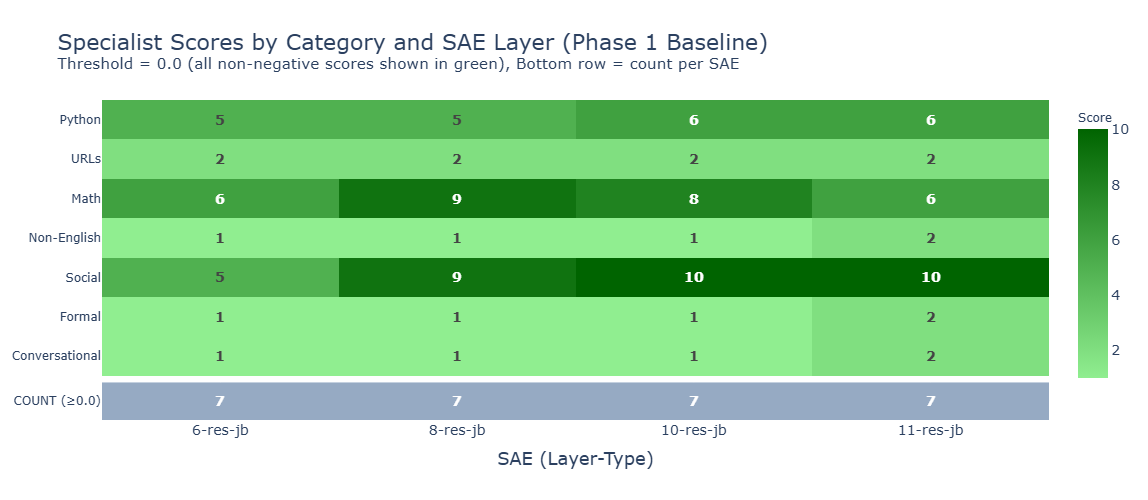


📊 Categories with specialist score ≥ 0.0:
   • 6-res-jb: 7/7
   • 8-res-jb: 7/7
   • 10-res-jb: 7/7
   • 11-res-jb: 7/7

2️⃣ Building Layer Progression Analysis (score threshold=0.0)...


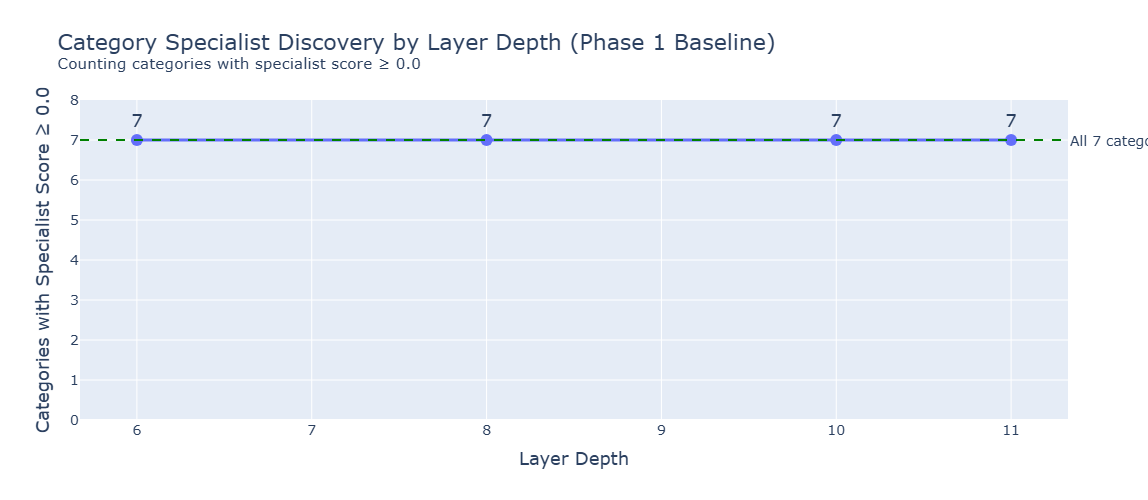


📊 Specialist Count by Layer (score ≥ 0.0):
      SAE  Layer  Specialist Count
 6-res-jb      6                 7
 8-res-jb      8                 7
10-res-jb     10                 7
11-res-jb     11                 7

3️⃣ Building Feature Frequency Comparison (threshold=0.0)...


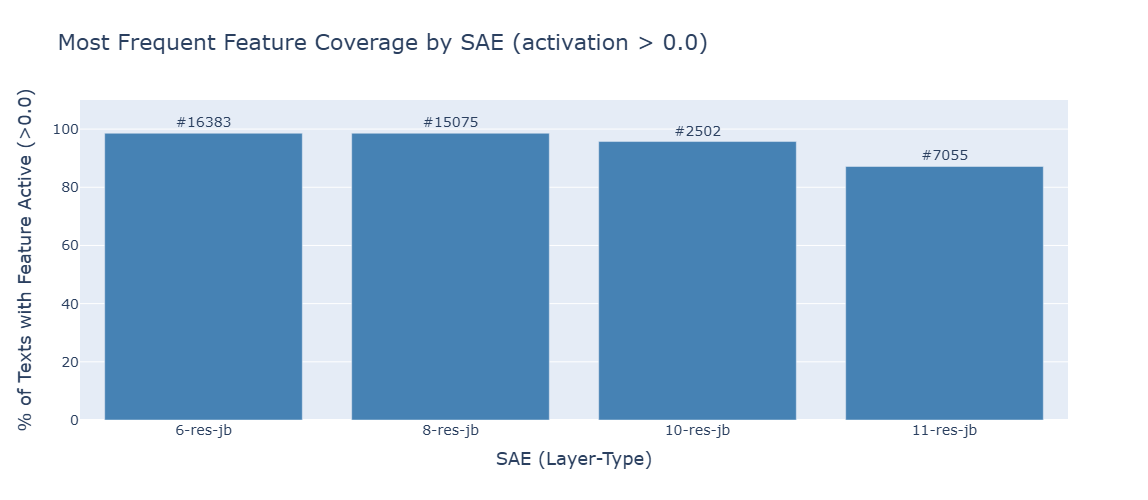


📊 Most Frequent Feature (activation > 0.0):
      SAE Feature  Texts Active  Percentage
 6-res-jb  #16383            69   98.571429
 8-res-jb  #15075            69   98.571429
10-res-jb   #2502            67   95.714286
11-res-jb   #7055            61   87.142857

4️⃣ Building Top Features Activation Heatmap (threshold=0.0)...


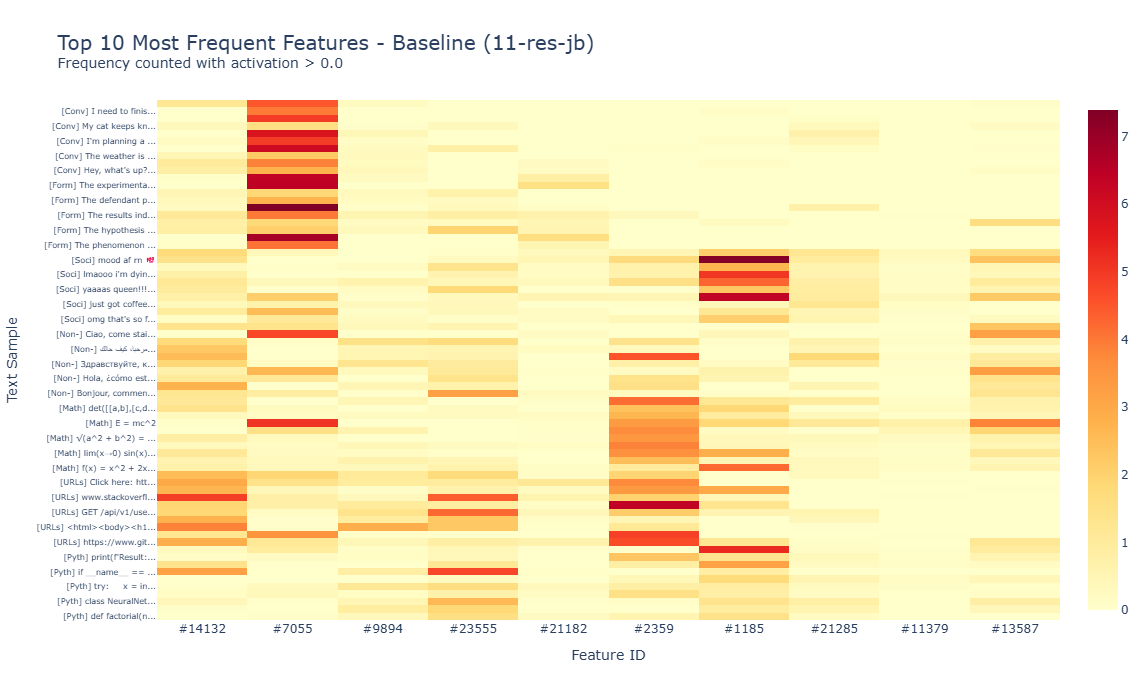


5️⃣ Building L0 Sparsity Comparison (threshold=0.0)...


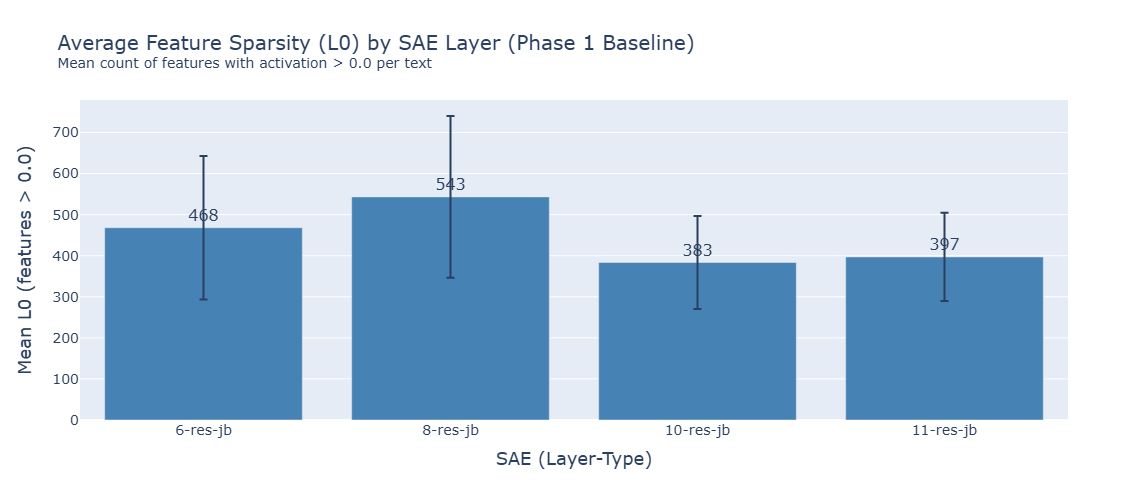


📊 L0 Statistics by Layer (activation > 0.0):
      SAE  Layer  Mean L0  Std L0  Min L0  Max L0
 6-res-jb      6    468.1   174.7   191.0  1051.0
 8-res-jb      8    543.1   197.0   240.0  1212.0
10-res-jb     10    383.4   113.4   155.0   759.0
11-res-jb     11    397.0   107.4   210.0   713.0

📈 PHASE 1 BASELINE ANALYSIS SUMMARY (Zero Threshold)

Thresholds Used:
   • Specialist score threshold: 0.0
   • Feature activation threshold: 0.0

Key Findings:
   • Categories with specialists (score ≥ 0.0):

      - 6-res-jb: 7/7
      - 8-res-jb: 7/7
      - 10-res-jb: 7/7
      - 11-res-jb: 7/7

   • Best layer for specialization: 6-res-jb (7/7 categories)

   • Mean L0 (features > 0.0) by layer:
      - 6-res-jb: 468.1 ± 174.7
      - 8-res-jb: 543.1 ± 197.0
      - 10-res-jb: 383.4 ± 113.4
      - 11-res-jb: 397.0 ± 107.4



In [19]:
# ============================================================================
# CELL 14: Phase 1 Comparison Heatmaps (Zero Threshold)
# ============================================================================
print("\n📊 Phase 1 Comparison Heatmaps (Zero Threshold)")
print("=" * 70)
print("""
This cell analyzes the baseline dataset (70 texts across 7 categories)
using zero thresholds to show all feature activations.

With threshold = 0, all non-negative specialist scores and any feature
activation will be counted/displayed.
""")

# Define thresholds
ACTIVATION_THRESHOLD = 0.0  # For feature frequency/L0 counting
SCORE_THRESHOLD = 0.0       # For specialist score counting

print(f"   Activation threshold: {ACTIVATION_THRESHOLD}")
print(f"   Specialist score threshold: {SCORE_THRESHOLD}")
print(f"   Dataset: {len(baseline_texts)} baseline texts")
print(f"   Categories: {len(baseline_categories)} categories")

# Get category names for baseline
category_names = list(baseline_categories.keys())

# -----------------------------------------------------------------------------
# Heatmap 1: Specialist Scores by Category × SAE (Zero Threshold)
# -----------------------------------------------------------------------------
print("\n1️⃣ Building Specialist Score Heatmap (Baseline)...")

# Build specialist score matrix
specialist_matrix = []
for cat_name in category_names:
    row = []
    for sae_name in sae_names:
        cat_data = results_baseline['specialists'][sae_name].get(cat_name)
        score = cat_data['score'] if cat_data else 0
        row.append(score)
    specialist_matrix.append(row)

# Calculate column totals (count of cells >= threshold per column)
column_totals = []
for sae_name in sae_names:
    count = sum(1 for cat_name in category_names
                if results_baseline['specialists'][sae_name].get(cat_name)
                and results_baseline['specialists'][sae_name][cat_name]['score'] >= SCORE_THRESHOLD)
    column_totals.append(count)

# Calculate colorscale range
all_scores = [val for row in specialist_matrix for val in row]
z_min = min(all_scores)
z_max = max(all_scores)

# Since threshold is 0, use green colorscale for all non-negative values
# Only gray out negative values (if any exist)
if z_min < 0:
    # Normalize threshold position in [0, 1] range
    threshold_normalized = (SCORE_THRESHOLD - z_min) / (z_max - z_min)
    
    # Create colorscale: gray below threshold (negative), green above
    colorscale = [
        [0, 'rgb(180, 180, 180)'],                             # Dark gray for negative
        [threshold_normalized - 0.001, 'rgb(220, 220, 220)'],  # Light gray just below 0
        [threshold_normalized, 'rgb(144, 238, 144)'],          # Light green at 0
        [1, 'rgb(0, 100, 0)']                                  # Dark green for highest
    ]
else:
    # All values >= 0, use pure green colorscale
    colorscale = [
        [0, 'rgb(144, 238, 144)'],   # Light green for lowest
        [1, 'rgb(0, 100, 0)']        # Dark green for highest
    ]

# Create text matrix with formatting for main data
text_matrix = []
for row in specialist_matrix:
    text_row = []
    for val in row:
        if val >= SCORE_THRESHOLD:
            text_row.append(f"<b>{val:.0f}</b>")  # Bold if above threshold
        else:
            text_row.append(f"{val:.0f}")
    text_matrix.append(text_row)

# Totals row text (always bold)
totals_text = [[f"<b>{val}</b>" for val in column_totals]]

# Create figure with subplots to have gap between main heatmap and totals
fig1 = make_subplots(
    rows=2, cols=1,
    row_heights=[0.88, 0.12],
    vertical_spacing=0.02
)

# Main heatmap (data)
fig1.add_trace(
    go.Heatmap(
        z=specialist_matrix,
        x=sae_names,
        y=category_names,
        colorscale=colorscale,
        text=text_matrix,
        texttemplate="%{text}",
        textfont={"size": 14},
        hovertemplate="SAE: %{x}<br>Category: %{y}<br>Specialist Score: %{z:.2f}<extra></extra>",
        colorbar=dict(
            tickfont=dict(size=14),
            title=dict(text="Score", font=dict(size=12)),
            y=0.55,
            len=0.9
        ),
        zmin=z_min,
        zmax=z_max,
        showscale=True
    ),
    row=1, col=1
)

# Totals row heatmap (separate trace)
fig1.add_trace(
    go.Heatmap(
        z=[column_totals],
        x=sae_names,
        y=[f'COUNT (≥{SCORE_THRESHOLD})'],
        colorscale=[[0, 'rgb(150, 170, 195)'], [1, 'rgb(150, 170, 195)']],
        text=totals_text,
        texttemplate="%{text}",
        textfont={"size": 14, "color": "white"},
        hovertemplate="SAE: %{x}<br>Count: %{z}<extra></extra>",
        showscale=False
    ),
    row=2, col=1
)

fig1.update_layout(
    title={
        'text': f'Specialist Scores by Category and SAE Layer (Phase 1 Baseline)<br><sup>Threshold = {SCORE_THRESHOLD} (all non-negative scores shown in green), Bottom row = count per SAE</sup>',
        'font': {'size': 22}
    },
    xaxis_title_font={'size': 18},
    yaxis_title_font={'size': 18},
    xaxis_tickfont={'size': 14},
    yaxis_tickfont={'size': 12},
    xaxis2_tickfont={'size': 14},
    yaxis2_tickfont={'size': 12},
    height=500,
    width=900
)

# Reverse y-axis for main heatmap only
fig1.update_yaxes(autorange='reversed', row=1, col=1)

# Add x-axis title only to bottom subplot
fig1.update_xaxes(title_text='SAE (Layer-Type)', row=2, col=1, title_font={'size': 18})

# Hide x-axis labels on top subplot (they'll show on bottom)
fig1.update_xaxes(showticklabels=False, row=1, col=1)

fig1.show()

# Print summary
print(f"\n📊 Categories with specialist score ≥ {SCORE_THRESHOLD}:")
for sae_idx, sae_name in enumerate(sae_names):
    print(f"   • {sae_name}: {column_totals[sae_idx]}/{len(category_names)}")

# -----------------------------------------------------------------------------
# 2: Layer Progression Analysis (Zero Threshold)
# -----------------------------------------------------------------------------
print(f"\n2️⃣ Building Layer Progression Analysis (score threshold={SCORE_THRESHOLD})...")

specialist_counts = []
for sae_name in sae_names:
    layer = int(sae_name.split('-')[0])
    
    # Count specialists with score >= threshold
    count = sum(1 for cat_name in category_names
                if results_baseline['specialists'][sae_name].get(cat_name)
                and results_baseline['specialists'][sae_name][cat_name]['score'] >= SCORE_THRESHOLD)
    
    specialist_counts.append({
        'SAE': sae_name,
        'Layer': layer,
        'Specialist Count': count,
        'Percentage': (count / len(category_names)) * 100
    })

df_progression = pd.DataFrame(specialist_counts)

fig2 = px.line(
    df_progression,
    x='Layer',
    y='Specialist Count',
    markers=True,
    title=f'Category Specialist Discovery by Layer Depth (Phase 1 Baseline)<br><sup>Counting categories with specialist score ≥ {SCORE_THRESHOLD}</sup>',
    text='Specialist Count'
)

fig2.update_traces(
    textposition='top center',
    textfont=dict(size=18),
    line=dict(width=3),
    marker=dict(size=12)
)

fig2.add_hline(y=len(category_names), line_dash="dash", line_color="green", 
               annotation_text=f"All {len(category_names)} categories", 
               annotation_position="right",
               annotation_font=dict(size=14))

fig2.update_layout(
    title={'font': {'size': 22}},
    height=500,
    width=800,
    xaxis_title='Layer Depth',
    yaxis_title=f'Categories with Specialist Score ≥ {SCORE_THRESHOLD}',
    xaxis_title_font={'size': 18},
    yaxis_title_font={'size': 18},
    xaxis_tickfont={'size': 14},
    yaxis_tickfont={'size': 14},
    yaxis=dict(range=[0, len(category_names) + 1])
)

fig2.show()

print(f"\n📊 Specialist Count by Layer (score ≥ {SCORE_THRESHOLD}):")
print(df_progression[['SAE', 'Layer', 'Specialist Count']].to_string(index=False))

# -----------------------------------------------------------------------------
# 3: Feature Frequency Comparison (Zero Threshold)
# -----------------------------------------------------------------------------
print(f"\n3️⃣ Building Feature Frequency Comparison (threshold={ACTIVATION_THRESHOLD})...")

frequency_data = []
for sae_name in sae_names:
    features_tensor = get_baseline_features(sae_name)
    
    # Count features ABOVE THRESHOLD per text
    feature_frequency = (features_tensor > ACTIVATION_THRESHOLD).sum(dim=0)
    most_freq_idx = feature_frequency.argmax().item()
    most_freq_count = feature_frequency[most_freq_idx].item()
    
    frequency_data.append({
        'SAE': sae_name,
        'Feature': f"#{most_freq_idx}",
        'Texts Active': most_freq_count,
        'Percentage': (most_freq_count / len(baseline_texts)) * 100
    })

df_frequency = pd.DataFrame(frequency_data)

fig3 = px.bar(
    df_frequency,
    x='SAE',
    y='Percentage',
    title=f'Most Frequent Feature Coverage by SAE (activation > {ACTIVATION_THRESHOLD})',
    text='Feature'
)

fig3.update_traces(marker_color='steelblue', textposition='outside', textfont=dict(size=14))
fig3.update_layout(
    title={'font': {'size': 22}},
    height=500,
    width=800,
    xaxis_title='SAE (Layer-Type)',
    yaxis_title=f'% of Texts with Feature Active (>{ACTIVATION_THRESHOLD})',
    xaxis_title_font={'size': 18},
    yaxis_title_font={'size': 18},
    xaxis_tickfont={'size': 14},
    yaxis_tickfont={'size': 14},
    yaxis=dict(range=[0, 110])
)

fig3.show()

print(f"\n📊 Most Frequent Feature (activation > {ACTIVATION_THRESHOLD}):")
print(df_frequency.to_string(index=False))

# -----------------------------------------------------------------------------
# 4: Top Features Activation Heatmap (Zero Threshold)
# -----------------------------------------------------------------------------
print(f"\n4️⃣ Building Top Features Activation Heatmap (threshold={ACTIVATION_THRESHOLD})...")

analysis_sae = "11-res-jb"
features_tensor = get_baseline_features(analysis_sae)

# Get top 10 most frequent features WITH THRESHOLD
feature_frequency_ht = (features_tensor > ACTIVATION_THRESHOLD).sum(dim=0)
top_10_freq = feature_frequency_ht.topk(10)
top_10_indices = top_10_freq.indices.tolist()
top_10_counts = top_10_freq.values.tolist()
top_10_labels = [f"#{idx}" for idx in top_10_indices]

# Create text labels
text_labels = []
for i, text in enumerate(baseline_texts):
    cat_label = baseline_labels[i][:4]
    text_short = text[:15].replace('\n', ' ') + "..." if len(text) > 15 else text.replace('\n', ' ')
    text_labels.append(f"[{cat_label}] {text_short}")

# Create activation matrix [texts × features]
activation_matrix_top10 = features_tensor[:, top_10_indices].detach().numpy()

fig4 = go.Figure(data=go.Heatmap(
    z=activation_matrix_top10,
    x=top_10_labels,
    y=text_labels,
    colorscale='YlOrRd',
    hoverongaps=False,
    hovertemplate='Text: %{y}<br>Feature: %{x}<br>Activation: %{z:.2f}<extra></extra>'
))

fig4.update_layout(
    title={
        'text': f'Top 10 Most Frequent Features - Baseline ({analysis_sae})<br><sup>Frequency counted with activation > {ACTIVATION_THRESHOLD}</sup>',
        'font': {'size': 20}
    },
    xaxis_title='Feature ID',
    yaxis_title='Text Sample',
    height=700,
    width=900,
    xaxis={'tickfont': {'size': 12}},
    yaxis={'tickfont': {'size': 8}}
)

fig4.show()

# Display Neuronpedia links
top10_links_html = f"""
<div style="margin: 20px 0; padding: 15px; border: 1px solid #ddd; border-radius: 8px; background: #f9f9f9;">
    <h4 style="margin-top: 0;">🔗 Top 10 Most Frequent Features - Baseline (activation > {ACTIVATION_THRESHOLD})</h4>
    <table style="border-collapse: collapse; width: 100%;">
        <tr style="background: #e0e0e0;">
            <th style="padding: 8px; text-align: left; border: 1px solid #ccc;">Rank</th>
            <th style="padding: 8px; text-align: left; border: 1px solid #ccc;">Feature</th>
            <th style="padding: 8px; text-align: left; border: 1px solid #ccc;">Texts Active (>{ACTIVATION_THRESHOLD})</th>
            <th style="padding: 8px; text-align: left; border: 1px solid #ccc;">Neuronpedia Link</th>
        </tr>
"""

for rank, (feat_idx, count) in enumerate(zip(top_10_indices, top_10_counts), 1):
    link = neuronpedia_link(analysis_sae, feat_idx)
    top10_links_html += f"""
        <tr>
            <td style="padding: 8px; border: 1px solid #ccc;">{rank}</td>
            <td style="padding: 8px; border: 1px solid #ccc; font-family: monospace;">#{feat_idx}</td>
            <td style="padding: 8px; border: 1px solid #ccc;">{int(count)}/{len(baseline_texts)}</td>
            <td style="padding: 8px; border: 1px solid #ccc;">
                <a href="{link}" target="_blank" style="color: #0066cc;">{link}</a>
            </td>
        </tr>
    """

top10_links_html += """
    </table>
</div>
"""

display(HTML(top10_links_html))

# -----------------------------------------------------------------------------
# 5: L0 Sparsity Comparison (Zero Threshold)
# -----------------------------------------------------------------------------
print(f"\n5️⃣ Building L0 Sparsity Comparison (threshold={ACTIVATION_THRESHOLD})...")

l0_data = []
for sae_name in sae_names:
    features_tensor = get_baseline_features(sae_name)
    layer = int(sae_name.split('-')[0])
    
    # L0 = count of features above threshold per text
    l0_per_text = (features_tensor > ACTIVATION_THRESHOLD).sum(dim=1).float()
    
    l0_data.append({
        'SAE': sae_name,
        'Layer': layer,
        'Mean L0': l0_per_text.mean().item(),
        'Std L0': l0_per_text.std().item(),
        'Min L0': l0_per_text.min().item(),
        'Max L0': l0_per_text.max().item()
    })

df_l0 = pd.DataFrame(l0_data)

fig5 = go.Figure()

fig5.add_trace(go.Bar(
    x=df_l0['SAE'],
    y=df_l0['Mean L0'],
    error_y=dict(type='data', array=df_l0['Std L0'], visible=True),
    marker_color='steelblue',  # Match color with Feature Frequency chart
    text=[f"{v:.0f}" for v in df_l0['Mean L0']],
    textposition='outside',
    textfont=dict(size=16)
))

fig5.update_layout(
    title={
        'text': f'Average Feature Sparsity (L0) by SAE Layer (Phase 1 Baseline)<br><sup>Mean count of features with activation > {ACTIVATION_THRESHOLD} per text</sup>',
        'font': {'size': 20}
    },
    height=500,
    width=800,
    xaxis_title='SAE (Layer-Type)',
    yaxis_title=f'Mean L0 (features > {ACTIVATION_THRESHOLD})',
    xaxis_title_font={'size': 18},
    yaxis_title_font={'size': 18},
    xaxis_tickfont={'size': 14},
    yaxis_tickfont={'size': 14}
)

fig5.show()

print(f"\n📊 L0 Statistics by Layer (activation > {ACTIVATION_THRESHOLD}):")
print(df_l0.to_string(index=False, float_format=lambda x: f"{x:.1f}"))

# -----------------------------------------------------------------------------
# Summary
# -----------------------------------------------------------------------------
print("\n" + "=" * 70)
print("📈 PHASE 1 BASELINE ANALYSIS SUMMARY (Zero Threshold)")
print("=" * 70)

print(f"""
Thresholds Used:
   • Specialist score threshold: {SCORE_THRESHOLD}
   • Feature activation threshold: {ACTIVATION_THRESHOLD}

Key Findings:
   • Categories with specialists (score ≥ {SCORE_THRESHOLD}):
""")
for sae_idx, sae_name in enumerate(sae_names):
    print(f"      - {sae_name}: {column_totals[sae_idx]}/{len(category_names)}")

best_layer = df_progression.loc[df_progression['Specialist Count'].idxmax()]
print(f"\n   • Best layer for specialization: {best_layer['SAE']} ({best_layer['Specialist Count']}/{len(category_names)} categories)")

print(f"\n   • Mean L0 (features > {ACTIVATION_THRESHOLD}) by layer:")
for _, row in df_l0.iterrows():
    print(f"      - {row['SAE']}: {row['Mean L0']:.1f} ± {row['Std L0']:.1f}")

print("\n" + "=" * 70)


📊 Phase 1 Comparison Heatmaps (Higher Thresholds)

This cell applies higher-threshold analysis to the baseline dataset 
(70 texts across 7 categories).

The encode-then-mean methodology causes many features to have small non-zero
activations on most texts. Higher thresholds filter for "meaningfully active"
features rather than just "technically non-zero" features.

   Activation threshold: 1.0
   Specialist score threshold: 2.0
   Dataset: 70 baseline texts
   Categories: 7 categories

1️⃣ Building Specialist Score Heatmap (Baseline)...


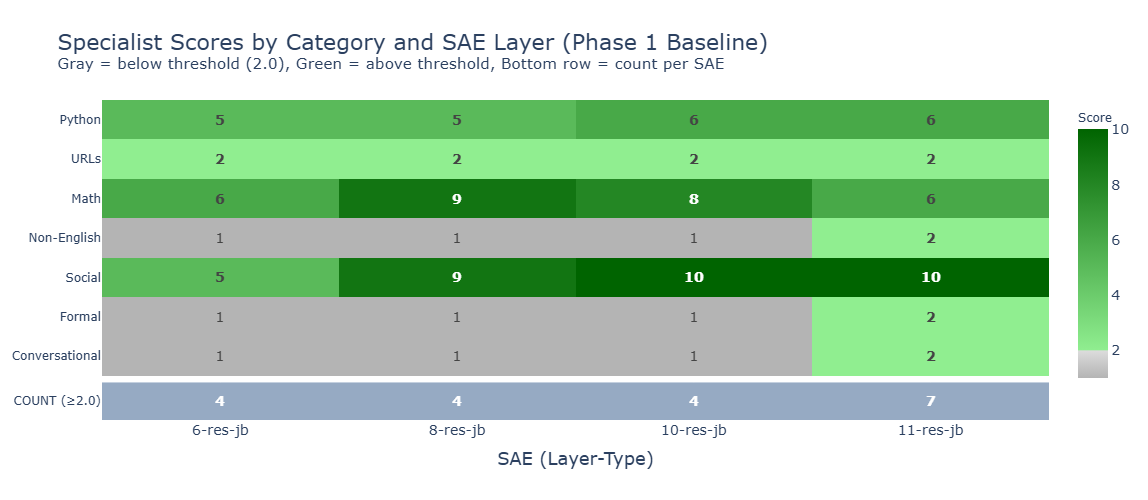


📊 Categories with specialist score ≥ 2.0:
   • 6-res-jb: 4/7
   • 8-res-jb: 4/7
   • 10-res-jb: 4/7
   • 11-res-jb: 7/7

2️⃣ Building Layer Progression Analysis (score threshold=2.0)...


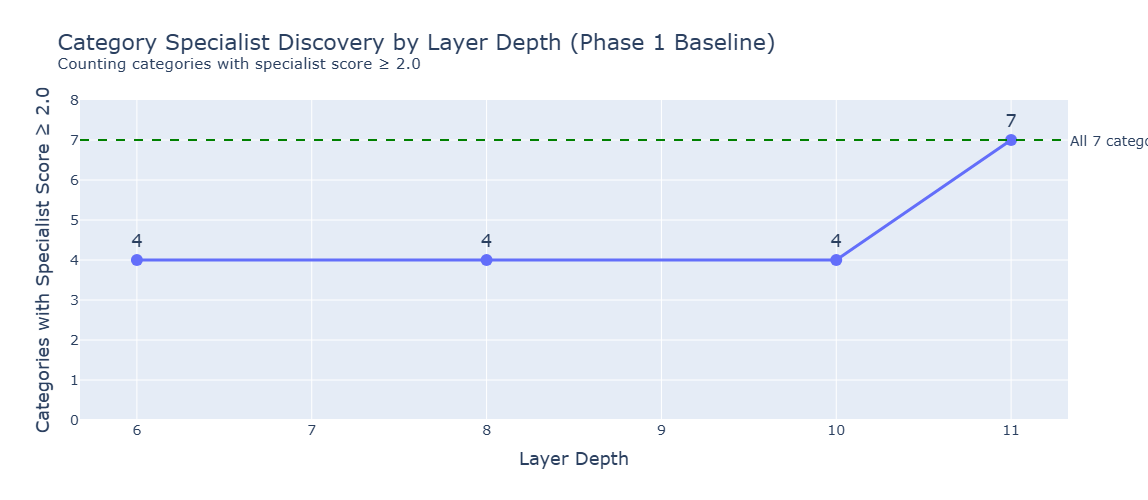


📊 Specialist Count by Layer (score ≥ 2.0):
      SAE  Layer  Specialist Count
 6-res-jb      6                 4
 8-res-jb      8                 4
10-res-jb     10                 4
11-res-jb     11                 7

3️⃣ Building Feature Frequency Comparison (threshold=1.0)...


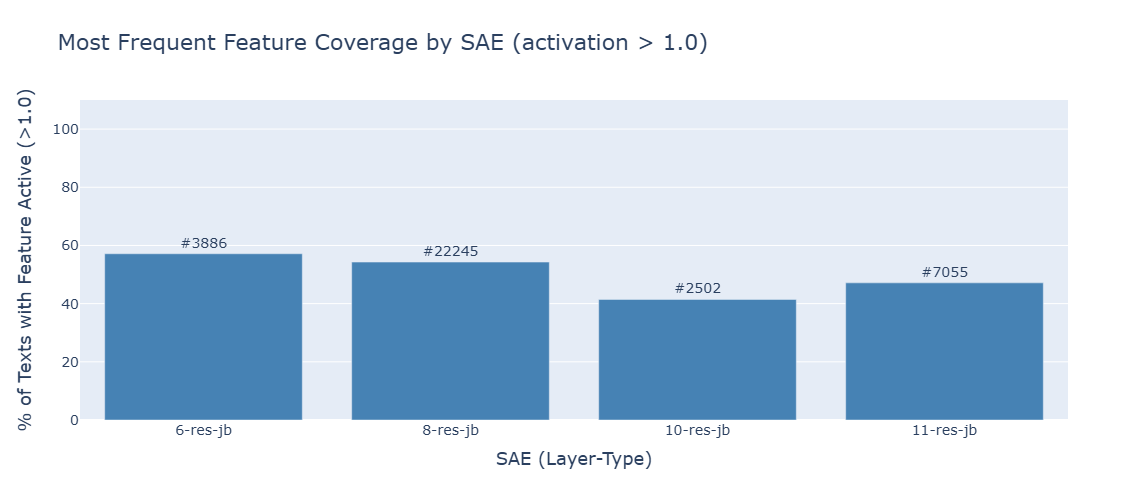


📊 Most Frequent Feature (activation > 1.0):
      SAE Feature  Texts Active  Percentage
 6-res-jb   #3886            40   57.142857
 8-res-jb  #22245            38   54.285714
10-res-jb   #2502            29   41.428571
11-res-jb   #7055            33   47.142857

4️⃣ Building Top Features Activation Heatmap (threshold=1.0)...


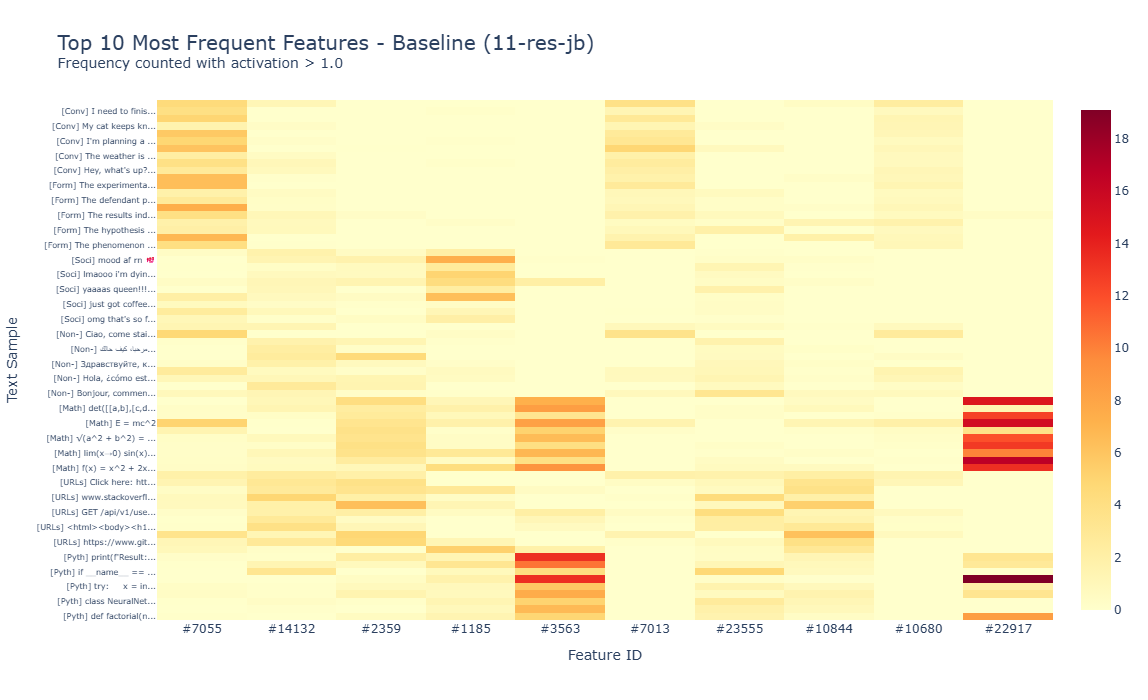


5️⃣ Building L0 Sparsity Comparison (threshold=1.0)...


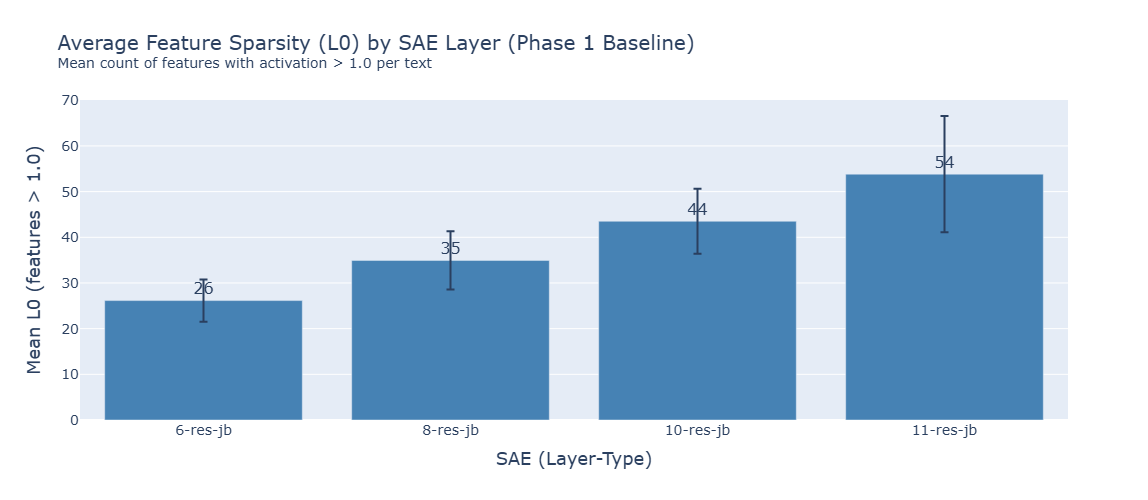


📊 L0 Statistics by Layer (activation > 1.0):
      SAE  Layer  Mean L0  Std L0  Min L0  Max L0
 6-res-jb      6     26.1     4.6    15.0    41.0
 8-res-jb      8     34.9     6.4    16.0    47.0
10-res-jb     10     43.5     7.1    19.0    56.0
11-res-jb     11     53.8    12.7    17.0    78.0

📈 PHASE 1 BASELINE ANALYSIS SUMMARY (Higher Thresholds)

Thresholds Used:
   • Specialist score threshold: 2.0
   • Feature activation threshold: 1.0

Key Findings:
   • Categories with meaningful specialists (score ≥ 2.0):

      - 6-res-jb: 4/7
      - 8-res-jb: 4/7
      - 10-res-jb: 4/7
      - 11-res-jb: 7/7

   • Best layer for specialization: 11-res-jb (7/7 categories)

   • Mean L0 (features > 1.0) by layer:
      - 6-res-jb: 26.1 ± 4.6
      - 8-res-jb: 34.9 ± 6.4
      - 10-res-jb: 43.5 ± 7.1
      - 11-res-jb: 53.8 ± 12.7



In [20]:
# ============================================================================
# CELL 15: Phase 1 Comparison Heatmaps (Higher Thresholds)
# ============================================================================
print("\n📊 Phase 1 Comparison Heatmaps (Higher Thresholds)")
print("=" * 70)
print("""
This cell applies higher-threshold analysis to the baseline dataset 
(70 texts across 7 categories).

The encode-then-mean methodology causes many features to have small non-zero
activations on most texts. Higher thresholds filter for "meaningfully active"
features rather than just "technically non-zero" features.
""")

# Define thresholds
ACTIVATION_THRESHOLD = 1.0  # For feature frequency/L0 counting
SCORE_THRESHOLD = 2.0       # For specialist score counting

print(f"   Activation threshold: {ACTIVATION_THRESHOLD}")
print(f"   Specialist score threshold: {SCORE_THRESHOLD}")
print(f"   Dataset: {len(baseline_texts)} baseline texts")
print(f"   Categories: {len(baseline_categories)} categories")

# Get category names for baseline
category_names = list(baseline_categories.keys())

# -----------------------------------------------------------------------------
# Heatmap 1: Specialist Scores by Category × SAE (with threshold indicator)
# -----------------------------------------------------------------------------
print("\n1️⃣ Building Specialist Score Heatmap (Baseline)...")

# Build specialist score matrix
specialist_matrix = []
for cat_name in category_names:
    row = []
    for sae_name in sae_names:
        cat_data = results_baseline['specialists'][sae_name].get(cat_name)
        score = cat_data['score'] if cat_data else 0
        row.append(score)
    specialist_matrix.append(row)

# Calculate column totals (count of cells >= threshold per column)
column_totals = []
for sae_name in sae_names:
    count = sum(1 for cat_name in category_names
                if results_baseline['specialists'][sae_name].get(cat_name)
                and results_baseline['specialists'][sae_name][cat_name]['score'] >= SCORE_THRESHOLD)
    column_totals.append(count)

# Calculate colorscale breakpoint for threshold
all_scores = [val for row in specialist_matrix for val in row]
z_min = min(all_scores)
z_max = max(all_scores)

# Normalize threshold position in [0, 1] range
threshold_normalized = (SCORE_THRESHOLD - z_min) / (z_max - z_min)

# Create colorscale: gray below threshold, green above
colorscale = [
    [0, 'rgb(180, 180, 180)'],                             # Dark gray for lowest
    [threshold_normalized - 0.001, 'rgb(220, 220, 220)'],  # Light gray just below threshold
    [threshold_normalized, 'rgb(144, 238, 144)'],          # Light green at threshold
    [1, 'rgb(0, 100, 0)']                                  # Dark green for highest
]

# Create text matrix with formatting for main data
text_matrix = []
for row in specialist_matrix:
    text_row = []
    for val in row:
        if val >= SCORE_THRESHOLD:
            text_row.append(f"<b>{val:.0f}</b>")  # Bold if above threshold
        else:
            text_row.append(f"{val:.0f}")
    text_matrix.append(text_row)

# Totals row text (always bold)
totals_text = [[f"<b>{val}</b>" for val in column_totals]]

# Create figure with subplots to have gap between main heatmap and totals
fig1 = make_subplots(
    rows=2, cols=1,
    row_heights=[0.88, 0.12],
    vertical_spacing=0.02
)

# Main heatmap (data)
fig1.add_trace(
    go.Heatmap(
        z=specialist_matrix,
        x=sae_names,
        y=category_names,
        colorscale=colorscale,
        text=text_matrix,
        texttemplate="%{text}",
        textfont={"size": 14},
        hovertemplate="SAE: %{x}<br>Category: %{y}<br>Specialist Score: %{z:.2f}<extra></extra>",
        colorbar=dict(
            tickfont=dict(size=14),
            title=dict(text="Score", font=dict(size=12)),
            y=0.55,
            len=0.9
        ),
        zmin=z_min,
        zmax=z_max,
        showscale=True
    ),
    row=1, col=1
)

# Totals row heatmap (separate trace)
fig1.add_trace(
    go.Heatmap(
        z=[column_totals],
        x=sae_names,
        y=[f'COUNT (≥{SCORE_THRESHOLD})'],
        colorscale=[[0, 'rgb(150, 170, 195)'], [1, 'rgb(150, 170, 195)']],
        text=totals_text,
        texttemplate="%{text}",
        textfont={"size": 14, "color": "white"},
        hovertemplate="SAE: %{x}<br>Count: %{z}<extra></extra>",
        showscale=False
    ),
    row=2, col=1
)

fig1.update_layout(
    title={
        'text': f'Specialist Scores by Category and SAE Layer (Phase 1 Baseline)<br><sup>Gray = below threshold ({SCORE_THRESHOLD}), Green = above threshold, Bottom row = count per SAE</sup>',
        'font': {'size': 22}
    },
    xaxis_title_font={'size': 18},
    yaxis_title_font={'size': 18},
    xaxis_tickfont={'size': 14},
    yaxis_tickfont={'size': 12},
    xaxis2_tickfont={'size': 14},
    yaxis2_tickfont={'size': 12},
    height=500,
    width=900
)

# Reverse y-axis for main heatmap only
fig1.update_yaxes(autorange='reversed', row=1, col=1)

# Add x-axis title only to bottom subplot
fig1.update_xaxes(title_text='SAE (Layer-Type)', row=2, col=1, title_font={'size': 18})

# Hide x-axis labels on top subplot (they'll show on bottom)
fig1.update_xaxes(showticklabels=False, row=1, col=1)

fig1.show()

# Print summary
print(f"\n📊 Categories with specialist score ≥ {SCORE_THRESHOLD}:")
for sae_idx, sae_name in enumerate(sae_names):
    print(f"   • {sae_name}: {column_totals[sae_idx]}/{len(category_names)}")

# -----------------------------------------------------------------------------
# 2: Layer Progression Analysis (score threshold)
# -----------------------------------------------------------------------------
print(f"\n2️⃣ Building Layer Progression Analysis (score threshold={SCORE_THRESHOLD})...")

specialist_counts = []
for sae_name in sae_names:
    layer = int(sae_name.split('-')[0])
    
    # Count specialists with score >= threshold
    count = sum(1 for cat_name in category_names
                if results_baseline['specialists'][sae_name].get(cat_name)
                and results_baseline['specialists'][sae_name][cat_name]['score'] >= SCORE_THRESHOLD)
    
    specialist_counts.append({
        'SAE': sae_name,
        'Layer': layer,
        'Specialist Count': count,
        'Percentage': (count / len(category_names)) * 100
    })

df_progression = pd.DataFrame(specialist_counts)

fig2 = px.line(
    df_progression,
    x='Layer',
    y='Specialist Count',
    markers=True,
    title=f'Category Specialist Discovery by Layer Depth (Phase 1 Baseline)<br><sup>Counting categories with specialist score ≥ {SCORE_THRESHOLD}</sup>',
    text='Specialist Count'
)

fig2.update_traces(
    textposition='top center',
    textfont=dict(size=18),
    line=dict(width=3),
    marker=dict(size=12)
)

fig2.add_hline(y=len(category_names), line_dash="dash", line_color="green", 
               annotation_text=f"All {len(category_names)} categories", 
               annotation_position="right",
               annotation_font=dict(size=14))

fig2.update_layout(
    title={'font': {'size': 22}},
    height=500,
    width=800,
    xaxis_title='Layer Depth',
    yaxis_title=f'Categories with Specialist Score ≥ {SCORE_THRESHOLD}',
    xaxis_title_font={'size': 18},
    yaxis_title_font={'size': 18},
    xaxis_tickfont={'size': 14},
    yaxis_tickfont={'size': 14},
    yaxis=dict(range=[0, len(category_names) + 1])
)

fig2.show()

print(f"\n📊 Specialist Count by Layer (score ≥ {SCORE_THRESHOLD}):")
print(df_progression[['SAE', 'Layer', 'Specialist Count']].to_string(index=False))

# -----------------------------------------------------------------------------
# 3: Feature Frequency Comparison (Higher Threshold)
# -----------------------------------------------------------------------------
print(f"\n3️⃣ Building Feature Frequency Comparison (threshold={ACTIVATION_THRESHOLD})...")

frequency_data = []
for sae_name in sae_names:
    features_tensor = get_baseline_features(sae_name)
    
    # Count features ABOVE THRESHOLD per text
    feature_frequency = (features_tensor > ACTIVATION_THRESHOLD).sum(dim=0)
    most_freq_idx = feature_frequency.argmax().item()
    most_freq_count = feature_frequency[most_freq_idx].item()
    
    frequency_data.append({
        'SAE': sae_name,
        'Feature': f"#{most_freq_idx}",
        'Texts Active': most_freq_count,
        'Percentage': (most_freq_count / len(baseline_texts)) * 100
    })

df_frequency = pd.DataFrame(frequency_data)

fig3 = px.bar(
    df_frequency,
    x='SAE',
    y='Percentage',
    title=f'Most Frequent Feature Coverage by SAE (activation > {ACTIVATION_THRESHOLD})',
    text='Feature'
)

fig3.update_traces(marker_color='steelblue', textposition='outside', textfont=dict(size=14))
fig3.update_layout(
    title={'font': {'size': 22}},
    height=500,
    width=800,
    xaxis_title='SAE (Layer-Type)',
    yaxis_title=f'% of Texts with Feature Active (>{ACTIVATION_THRESHOLD})',
    xaxis_title_font={'size': 18},
    yaxis_title_font={'size': 18},
    xaxis_tickfont={'size': 14},
    yaxis_tickfont={'size': 14},
    yaxis=dict(range=[0, 110])
)

fig3.show()

print(f"\n📊 Most Frequent Feature (activation > {ACTIVATION_THRESHOLD}):")
print(df_frequency.to_string(index=False))

# -----------------------------------------------------------------------------
# 4: Top Features Activation Heatmap (Higher Threshold)
# -----------------------------------------------------------------------------
print(f"\n4️⃣ Building Top Features Activation Heatmap (threshold={ACTIVATION_THRESHOLD})...")

analysis_sae = "11-res-jb"
features_tensor = get_baseline_features(analysis_sae)

# Get top 10 most frequent features WITH THRESHOLD
feature_frequency_ht = (features_tensor > ACTIVATION_THRESHOLD).sum(dim=0)
top_10_freq = feature_frequency_ht.topk(10)
top_10_indices = top_10_freq.indices.tolist()
top_10_counts = top_10_freq.values.tolist()
top_10_labels = [f"#{idx}" for idx in top_10_indices]

# Create text labels
text_labels = []
for i, text in enumerate(baseline_texts):
    cat_label = baseline_labels[i][:4]
    text_short = text[:15].replace('\n', ' ') + "..." if len(text) > 15 else text.replace('\n', ' ')
    text_labels.append(f"[{cat_label}] {text_short}")

# Create activation matrix [texts × features]
activation_matrix_top10 = features_tensor[:, top_10_indices].detach().numpy()

fig4 = go.Figure(data=go.Heatmap(
    z=activation_matrix_top10,
    x=top_10_labels,
    y=text_labels,
    colorscale='YlOrRd',
    hoverongaps=False,
    hovertemplate='Text: %{y}<br>Feature: %{x}<br>Activation: %{z:.2f}<extra></extra>'
))

fig4.update_layout(
    title={
        'text': f'Top 10 Most Frequent Features - Baseline ({analysis_sae})<br><sup>Frequency counted with activation > {ACTIVATION_THRESHOLD}</sup>',
        'font': {'size': 20}
    },
    xaxis_title='Feature ID',
    yaxis_title='Text Sample',
    height=700,
    width=900,
    xaxis={'tickfont': {'size': 12}},
    yaxis={'tickfont': {'size': 8}}
)

fig4.show()

# Display Neuronpedia links
top10_links_html = f"""
<div style="margin: 20px 0; padding: 15px; border: 1px solid #ddd; border-radius: 8px; background: #f9f9f9;">
    <h4 style="margin-top: 0;">🔗 Top 10 Most Frequent Features - Baseline (activation > {ACTIVATION_THRESHOLD})</h4>
    <table style="border-collapse: collapse; width: 100%;">
        <tr style="background: #e0e0e0;">
            <th style="padding: 8px; text-align: left; border: 1px solid #ccc;">Rank</th>
            <th style="padding: 8px; text-align: left; border: 1px solid #ccc;">Feature</th>
            <th style="padding: 8px; text-align: left; border: 1px solid #ccc;">Texts Active (>{ACTIVATION_THRESHOLD})</th>
            <th style="padding: 8px; text-align: left; border: 1px solid #ccc;">Neuronpedia Link</th>
        </tr>
"""

for rank, (feat_idx, count) in enumerate(zip(top_10_indices, top_10_counts), 1):
    link = neuronpedia_link(analysis_sae, feat_idx)
    top10_links_html += f"""
        <tr>
            <td style="padding: 8px; border: 1px solid #ccc;">{rank}</td>
            <td style="padding: 8px; border: 1px solid #ccc; font-family: monospace;">#{feat_idx}</td>
            <td style="padding: 8px; border: 1px solid #ccc;">{int(count)}/{len(baseline_texts)}</td>
            <td style="padding: 8px; border: 1px solid #ccc;">
                <a href="{link}" target="_blank" style="color: #0066cc;">{link}</a>
            </td>
        </tr>
    """

top10_links_html += """
    </table>
</div>
"""

display(HTML(top10_links_html))

# -----------------------------------------------------------------------------
# 5: L0 Sparsity Comparison (Higher Threshold)
# -----------------------------------------------------------------------------
print(f"\n5️⃣ Building L0 Sparsity Comparison (threshold={ACTIVATION_THRESHOLD})...")

l0_data = []
for sae_name in sae_names:
    features_tensor = get_baseline_features(sae_name)
    layer = int(sae_name.split('-')[0])
    
    # L0 = count of features above threshold per text
    l0_per_text = (features_tensor > ACTIVATION_THRESHOLD).sum(dim=1).float()
    
    l0_data.append({
        'SAE': sae_name,
        'Layer': layer,
        'Mean L0': l0_per_text.mean().item(),
        'Std L0': l0_per_text.std().item(),
        'Min L0': l0_per_text.min().item(),
        'Max L0': l0_per_text.max().item()
    })

df_l0 = pd.DataFrame(l0_data)

fig5 = go.Figure()

fig5.add_trace(go.Bar(
    x=df_l0['SAE'],
    y=df_l0['Mean L0'],
    error_y=dict(type='data', array=df_l0['Std L0'], visible=True),
    marker_color='steelblue',  # Match color with Feature Frequency chart
    text=[f"{v:.0f}" for v in df_l0['Mean L0']],
    textposition='outside',
    textfont=dict(size=16)
))

fig5.update_layout(
    title={
        'text': f'Average Feature Sparsity (L0) by SAE Layer (Phase 1 Baseline)<br><sup>Mean count of features with activation > {ACTIVATION_THRESHOLD} per text</sup>',
        'font': {'size': 20}
    },
    height=500,
    width=800,
    xaxis_title='SAE (Layer-Type)',
    yaxis_title=f'Mean L0 (features > {ACTIVATION_THRESHOLD})',
    xaxis_title_font={'size': 18},
    yaxis_title_font={'size': 18},
    xaxis_tickfont={'size': 14},
    yaxis_tickfont={'size': 14}
)

fig5.show()

print(f"\n📊 L0 Statistics by Layer (activation > {ACTIVATION_THRESHOLD}):")
print(df_l0.to_string(index=False, float_format=lambda x: f"{x:.1f}"))

# -----------------------------------------------------------------------------
# Summary
# -----------------------------------------------------------------------------
print("\n" + "=" * 70)
print("📈 PHASE 1 BASELINE ANALYSIS SUMMARY (Higher Thresholds)")
print("=" * 70)

print(f"""
Thresholds Used:
   • Specialist score threshold: {SCORE_THRESHOLD}
   • Feature activation threshold: {ACTIVATION_THRESHOLD}

Key Findings:
   • Categories with meaningful specialists (score ≥ {SCORE_THRESHOLD}):
""")
for sae_idx, sae_name in enumerate(sae_names):
    print(f"      - {sae_name}: {column_totals[sae_idx]}/{len(category_names)}")

best_layer = df_progression.loc[df_progression['Specialist Count'].idxmax()]
print(f"\n   • Best layer for specialization: {best_layer['SAE']} ({best_layer['Specialist Count']}/{len(category_names)} categories)")

print(f"\n   • Mean L0 (features > {ACTIVATION_THRESHOLD}) by layer:")
for _, row in df_l0.iterrows():
    print(f"      - {row['SAE']}: {row['Mean L0']:.1f} ± {row['Std L0']:.1f}")

print("\n" + "=" * 70)


📊 Phase 2 Comparison Heatmaps - Matched Pairs (Zero Threshold)

This cell analyzes the matched pairs dataset (688 texts across 20 topic+form 
combinations) using zero thresholds to show all feature activations.

With threshold = 0, all non-negative specialist scores and any feature
activation will be counted/displayed.

   Activation threshold: 0.0
   Specialist score threshold: 0.0
   Dataset: 688 matched pairs texts
   Categories: 20 topic+form combinations

1️⃣-MP Building Specialist Score Heatmap (Matched Pairs)...


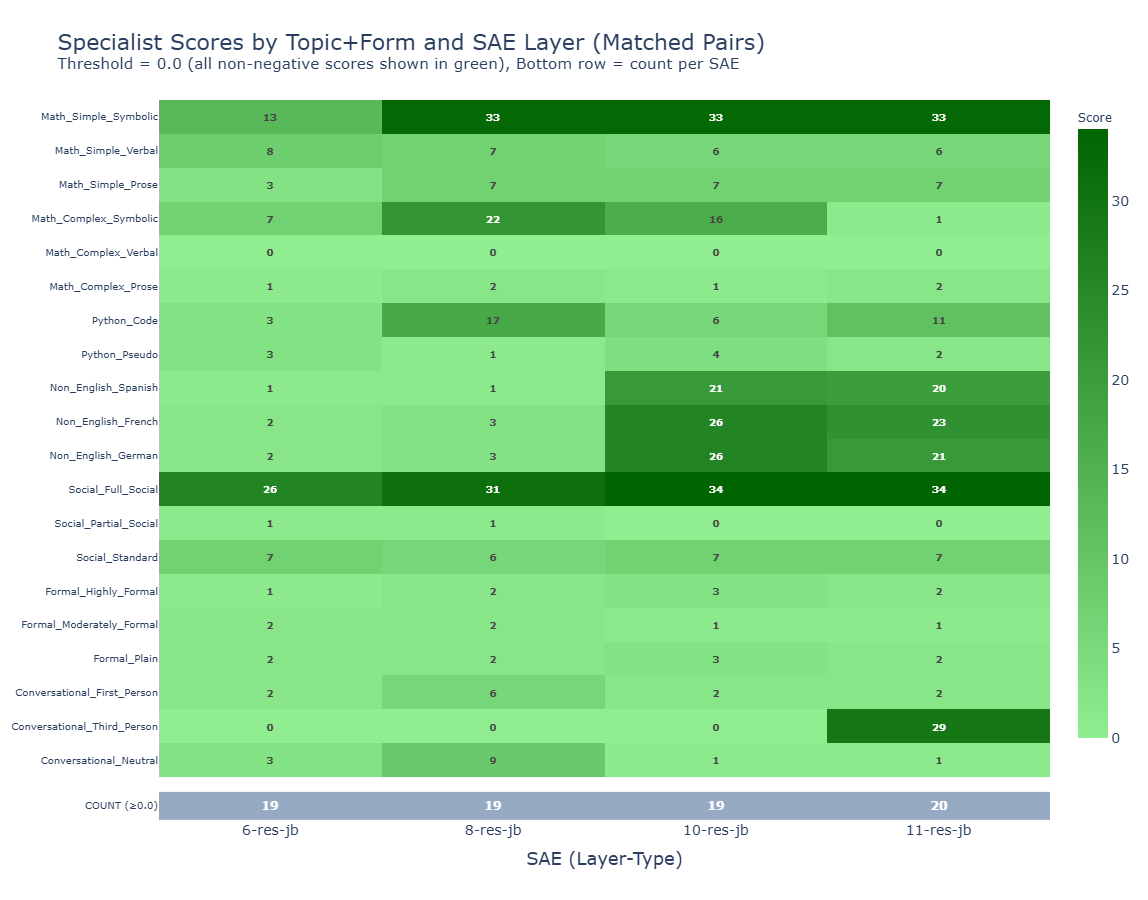


📊 Topic+Form combinations with specialist score ≥ 0.0:
   • 6-res-jb: 19/20
   • 8-res-jb: 19/20
   • 10-res-jb: 19/20
   • 11-res-jb: 20/20

2️⃣-MP Building Layer Progression Analysis (score threshold=0.0)...


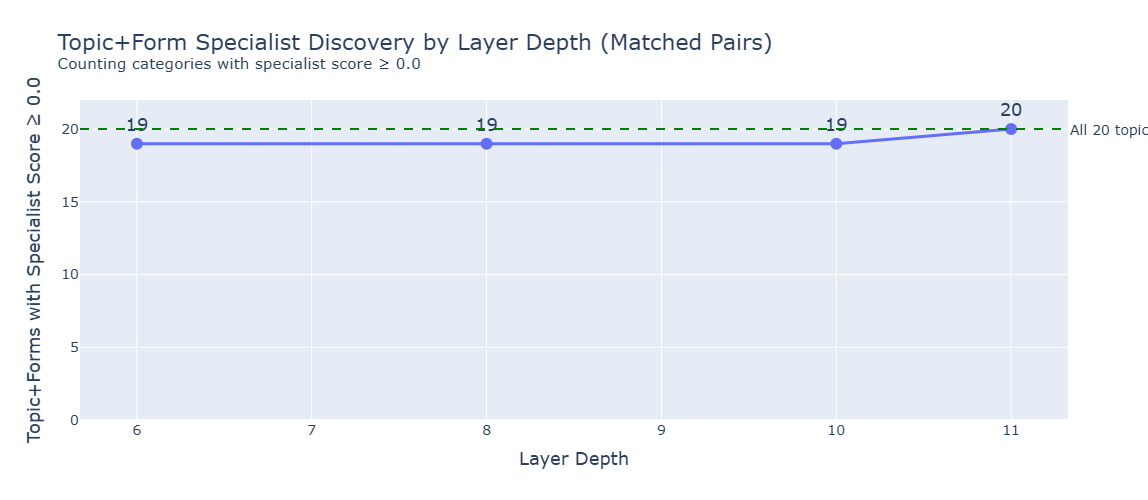


📊 Specialist Count by Layer - Matched Pairs (score ≥ 0.0):
      SAE  Layer  Specialist Count
 6-res-jb      6                19
 8-res-jb      8                19
10-res-jb     10                19
11-res-jb     11                20

3️⃣-MP Building Feature Frequency Comparison (threshold=0.0)...


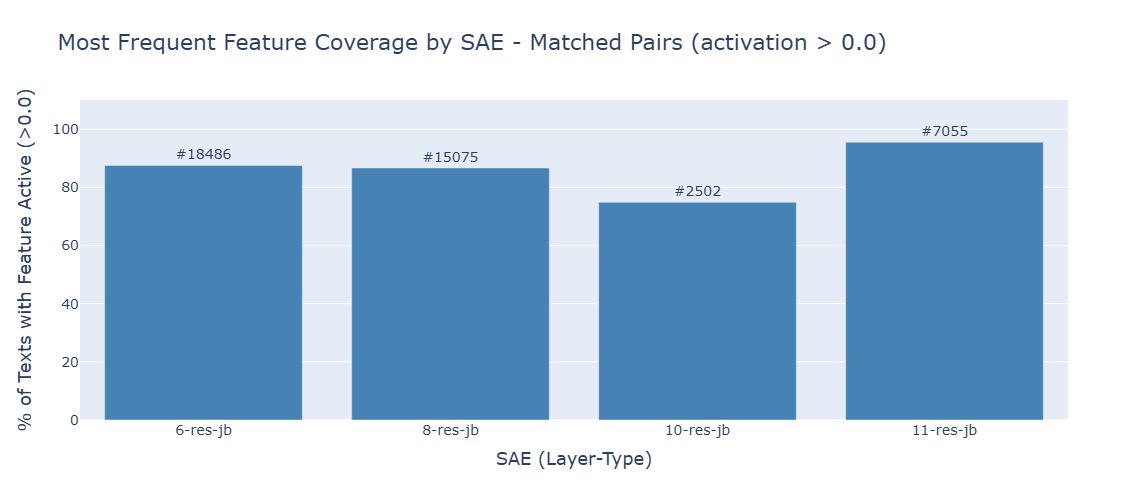


📊 Most Frequent Feature - Matched Pairs (activation > 0.0):
      SAE Feature  Texts Active  Percentage
 6-res-jb  #18486           602   87.500000
 8-res-jb  #15075           596   86.627907
10-res-jb   #2502           515   74.854651
11-res-jb   #7055           657   95.494186

4️⃣-MP Building Topic-Level Specialist Score Heatmap...


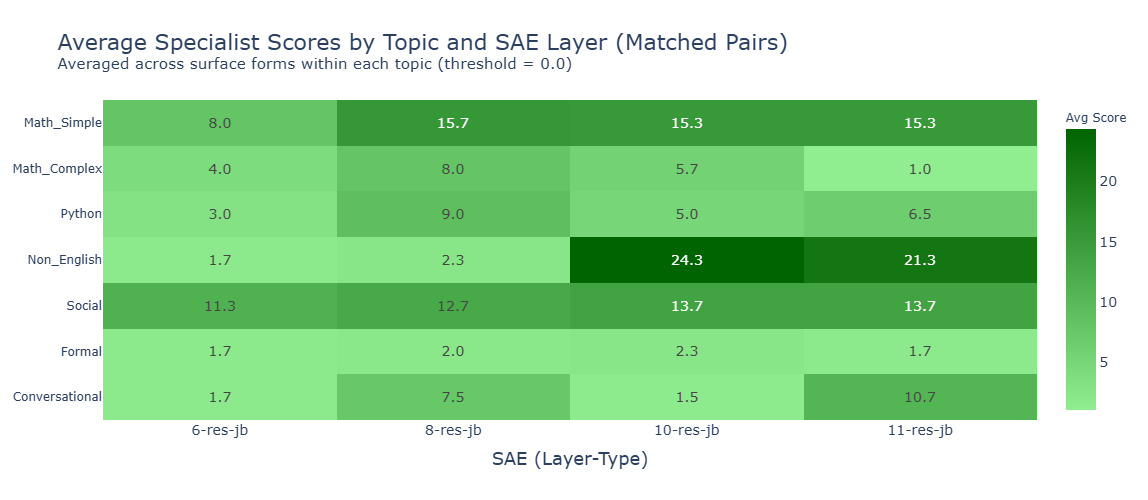


5️⃣-MP Building Form-Type Specialist Analysis...


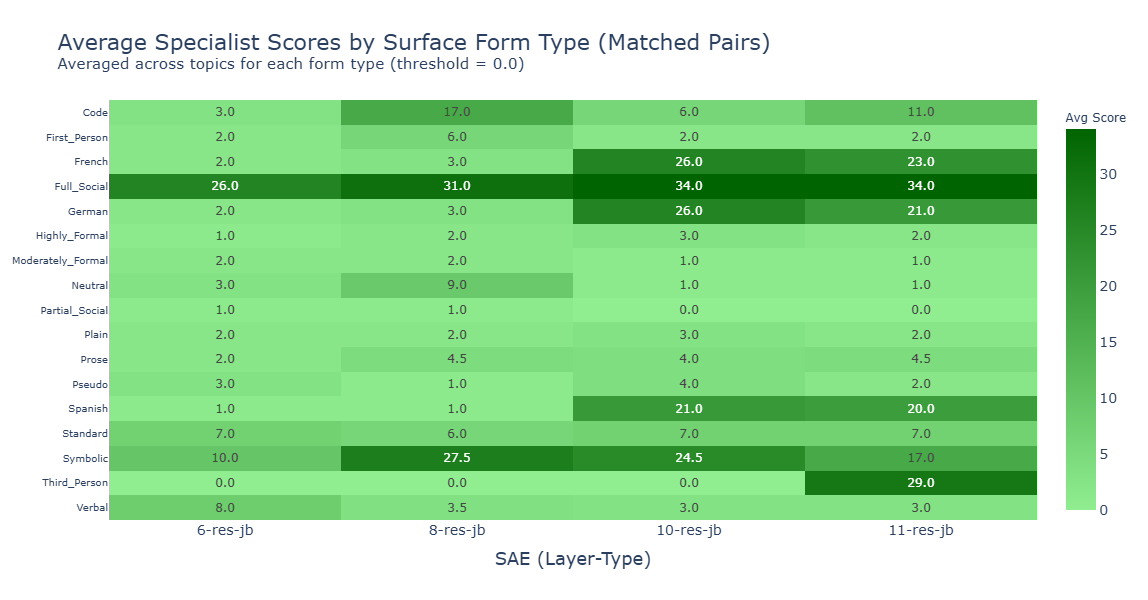


6️⃣-MP Building Top Features Activation Heatmap (threshold=0.0)...


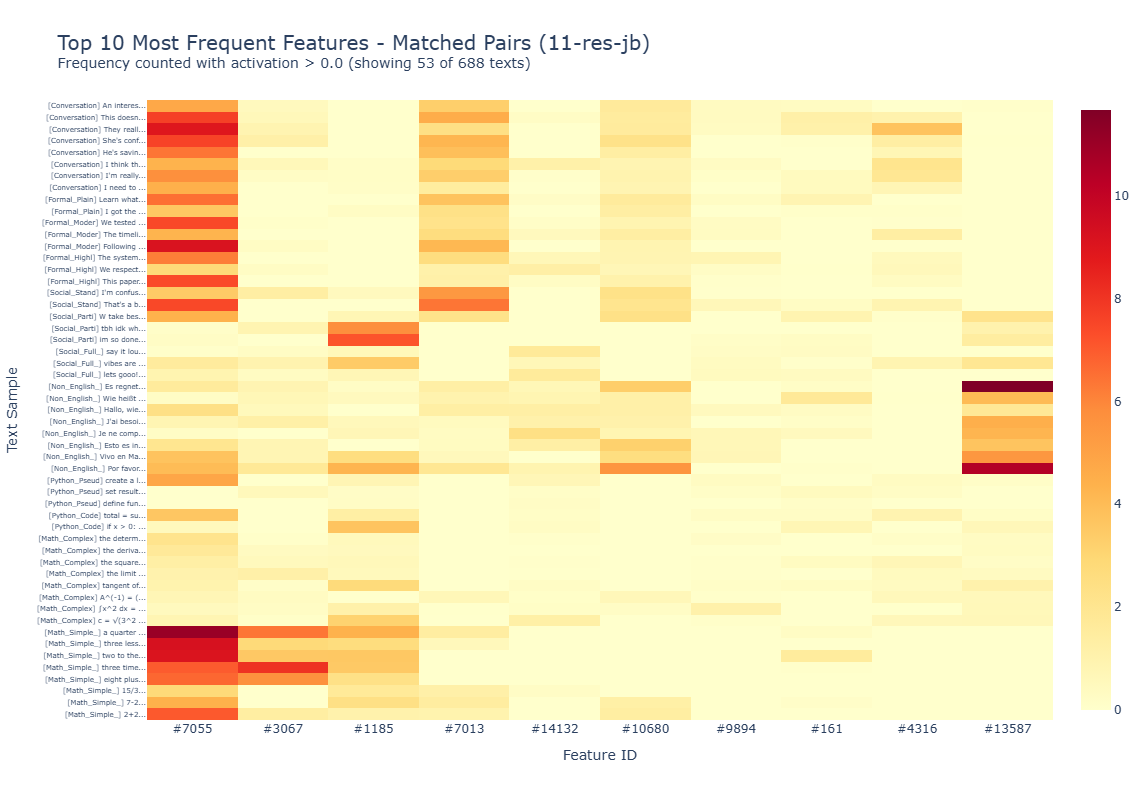


7️⃣-MP Building L0 Sparsity Comparison (threshold=0.0)...


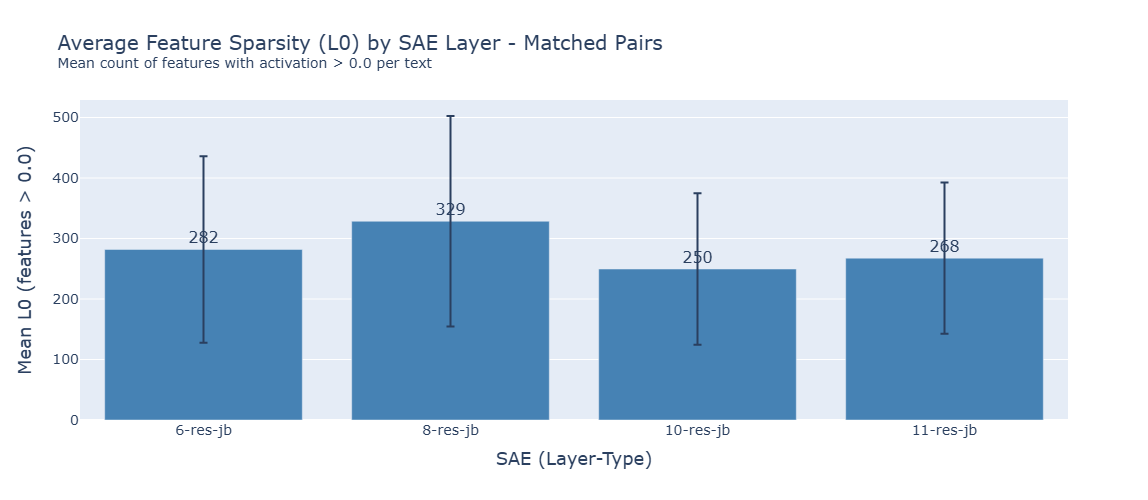


📊 L0 Statistics by Layer - Matched Pairs (activation > 0.0):
      SAE  Layer  Mean L0  Std L0  Min L0  Max L0
 6-res-jb      6    281.9   154.3    52.0   945.0
 8-res-jb      8    328.5   174.0    66.0  1113.0
10-res-jb     10    249.6   125.3    51.0   878.0
11-res-jb     11    267.6   125.2    61.0   791.0

📈 PHASE 2 MATCHED PAIRS ANALYSIS SUMMARY (Zero Threshold)

Thresholds Used:
   • Specialist score threshold: 0.0
   • Feature activation threshold: 0.0

Key Findings:
   • Topic+Form combinations with specialists (score ≥ 0.0):

      - 6-res-jb: 19/20
      - 8-res-jb: 19/20
      - 10-res-jb: 19/20
      - 11-res-jb: 20/20

   • Best layer for specialization: 11-res-jb (20/20 topic+forms)

   • Mean L0 (features > 0.0) by layer:
      - 6-res-jb: 281.9 ± 154.3
      - 8-res-jb: 328.5 ± 174.0
      - 10-res-jb: 249.6 ± 125.3
      - 11-res-jb: 267.6 ± 125.2



In [18]:
# ============================================================================
# CELL 16: Phase 2 Comparison Heatmaps - Matched Pairs (Zero Threshold)
# ============================================================================
print("\n📊 Phase 2 Comparison Heatmaps - Matched Pairs (Zero Threshold)")
print("=" * 70)
print("""
This cell analyzes the matched pairs dataset (688 texts across 20 topic+form 
combinations) using zero thresholds to show all feature activations.

With threshold = 0, all non-negative specialist scores and any feature
activation will be counted/displayed.
""")

# Define thresholds
ACTIVATION_THRESHOLD = 0.0  # For feature frequency/L0 counting
SCORE_THRESHOLD = 0.0       # For specialist score counting

print(f"   Activation threshold: {ACTIVATION_THRESHOLD}")
print(f"   Specialist score threshold: {SCORE_THRESHOLD}")
print(f"   Dataset: {len(matched_pairs_texts)} matched pairs texts")
print(f"   Categories: {len(matched_pairs_categories)} topic+form combinations")

# Get category names for matched pairs
mp_category_names = list(matched_pairs_categories.keys())

# -----------------------------------------------------------------------------
# 1-MP: Specialist Scores by Topic+Form × SAE (Zero Threshold)
# -----------------------------------------------------------------------------
print("\n1️⃣-MP Building Specialist Score Heatmap (Matched Pairs)...")

# Build specialist score matrix
specialist_matrix_mp = []
for cat_name in mp_category_names:
    row = []
    for sae_name in sae_names:
        cat_data = results_matched_pairs['specialists'][sae_name].get(cat_name)
        score = cat_data['score'] if cat_data else 0
        row.append(score)
    specialist_matrix_mp.append(row)

# Calculate column totals (count of cells >= threshold per column)
# Calculate column totals using the same logic as the line graph
column_totals = []
for sae_name in sae_names:
    count = sum(1 for cat_name in mp_category_names
                if results_matched_pairs['specialists'][sae_name].get(cat_name)
                and results_matched_pairs['specialists'][sae_name][cat_name]['score'] >= SCORE_THRESHOLD)
    column_totals.append(count)

# Calculate colorscale range
all_scores = [val for row in specialist_matrix_mp for val in row]
z_min = min(all_scores)
z_max = max(all_scores)

# Since threshold is 0, use green colorscale for all non-negative values
# Only gray out negative values (if any exist)
if z_min < 0:
    # Normalize threshold position in [0, 1] range
    threshold_normalized = (SCORE_THRESHOLD - z_min) / (z_max - z_min)
    
    # Create colorscale: gray below threshold (negative), green above
    colorscale = [
        [0, 'rgb(180, 180, 180)'],                             # Dark gray for negative
        [threshold_normalized - 0.001, 'rgb(220, 220, 220)'],  # Light gray just below 0
        [threshold_normalized, 'rgb(144, 238, 144)'],          # Light green at 0
        [1, 'rgb(0, 100, 0)']                                  # Dark green for highest
    ]
else:
    # All values >= 0, use pure green colorscale
    colorscale = [
        [0, 'rgb(144, 238, 144)'],   # Light green for lowest
        [1, 'rgb(0, 100, 0)']        # Dark green for highest
    ]

# Create text matrix with formatting for main data
text_matrix = []
for row in specialist_matrix_mp:
    text_row = []
    for val in row:
        if val >= SCORE_THRESHOLD:
            text_row.append(f"<b>{val:.0f}</b>")  # Bold if above threshold
        else:
            text_row.append(f"{val:.0f}")
    text_matrix.append(text_row)

# Totals row text (always bold)
totals_text = [[f"<b>{val}</b>" for val in column_totals]]

# Create figure with subplots to have gap between main heatmap and totals
fig1_mp = make_subplots(
    rows=2, cols=1,
    row_heights=[0.96, 0.04],
    vertical_spacing=0.02
)

# Main heatmap (data)
fig1_mp.add_trace(
    go.Heatmap(
        z=specialist_matrix_mp,
        x=sae_names,
        y=mp_category_names,
        colorscale=colorscale,
        text=text_matrix,
        texttemplate="%{text}",
        textfont={"size": 10},
        hovertemplate="SAE: %{x}<br>Topic+Form: %{y}<br>Specialist Score: %{z:.2f}<extra></extra>",
        colorbar=dict(
            tickfont=dict(size=14),
            title=dict(text="Score", font=dict(size=12)),
            y=0.55,
            len=0.9
        ),
        zmin=z_min,
        zmax=z_max,
        showscale=True
    ),
    row=1, col=1
)

# Totals row heatmap (separate trace)
fig1_mp.add_trace(
    go.Heatmap(
        z=[column_totals],
        x=sae_names,
        y=[f'COUNT (≥{SCORE_THRESHOLD})'],
        colorscale=[[0, 'rgb(150, 170, 195)'], [1, 'rgb(150, 170, 195)']],
        text=totals_text,
        texttemplate="%{text}",
        textfont={"size": 12, "color": "white"},
        hovertemplate="SAE: %{x}<br>Count: %{z}<extra></extra>",
        showscale=False
    ),
    row=2, col=1
)

fig1_mp.update_layout(
    title={
        'text': f'Specialist Scores by Topic+Form and SAE Layer (Matched Pairs)<br><sup>Threshold = {SCORE_THRESHOLD} (all non-negative scores shown in green), Bottom row = count per SAE</sup>',
        'font': {'size': 22}
    },
    xaxis_title_font={'size': 18},
    yaxis_title_font={'size': 18},
    xaxis_tickfont={'size': 14},
    yaxis_tickfont={'size': 10},
    xaxis2_tickfont={'size': 14},
    yaxis2_tickfont={'size': 10},
    height=900,
    width=900
)

# Reverse y-axis for main heatmap only
fig1_mp.update_yaxes(autorange='reversed', row=1, col=1)

# Add x-axis title only to bottom subplot
fig1_mp.update_xaxes(title_text='SAE (Layer-Type)', row=2, col=1, title_font={'size': 18})

# Hide x-axis labels on top subplot (they'll show on bottom)
fig1_mp.update_xaxes(showticklabels=False, row=1, col=1)

fig1_mp.show()

# Print summary
print(f"\n📊 Topic+Form combinations with specialist score ≥ {SCORE_THRESHOLD}:")
for sae_idx, sae_name in enumerate(sae_names):
    print(f"   • {sae_name}: {column_totals[sae_idx]}/{len(mp_category_names)}")

# -----------------------------------------------------------------------------
# 2-MP: Layer Progression Analysis (Zero Threshold)
# -----------------------------------------------------------------------------
print(f"\n2️⃣-MP Building Layer Progression Analysis (score threshold={SCORE_THRESHOLD})...")

specialist_counts_mp = []
for sae_name in sae_names:
    layer = int(sae_name.split('-')[0])
    
    # Count specialists with score >= threshold
    count = sum(1 for cat_name in mp_category_names
                if results_matched_pairs['specialists'][sae_name].get(cat_name)
                and results_matched_pairs['specialists'][sae_name][cat_name]['score'] >= SCORE_THRESHOLD)
    
    specialist_counts_mp.append({
        'SAE': sae_name,
        'Layer': layer,
        'Specialist Count': count,
        'Percentage': (count / len(mp_category_names)) * 100
    })

df_progression_mp = pd.DataFrame(specialist_counts_mp)

fig2_mp = px.line(
    df_progression_mp,
    x='Layer',
    y='Specialist Count',
    markers=True,
    title=f'Topic+Form Specialist Discovery by Layer Depth (Matched Pairs)<br><sup>Counting categories with specialist score ≥ {SCORE_THRESHOLD}</sup>',
    text='Specialist Count'
)

fig2_mp.update_traces(
    textposition='top center',
    textfont=dict(size=18),
    line=dict(width=3),
    marker=dict(size=12)
)

fig2_mp.add_hline(y=len(mp_category_names), line_dash="dash", line_color="green", 
               annotation_text=f"All {len(mp_category_names)} topic+forms", 
               annotation_position="right",
               annotation_font=dict(size=14))

fig2_mp.update_layout(
    title={'font': {'size': 22}},
    height=500,
    width=800,
    xaxis_title='Layer Depth',
    yaxis_title=f'Topic+Forms with Specialist Score ≥ {SCORE_THRESHOLD}',
    xaxis_title_font={'size': 18},
    yaxis_title_font={'size': 18},
    xaxis_tickfont={'size': 14},
    yaxis_tickfont={'size': 14},
    yaxis=dict(range=[0, len(mp_category_names) + 2])
)

fig2_mp.show()

print(f"\n📊 Specialist Count by Layer - Matched Pairs (score ≥ {SCORE_THRESHOLD}):")
print(df_progression_mp[['SAE', 'Layer', 'Specialist Count']].to_string(index=False))

# -----------------------------------------------------------------------------
# 3-MP: Feature Frequency Comparison (Zero Threshold)
# -----------------------------------------------------------------------------
print(f"\n3️⃣-MP Building Feature Frequency Comparison (threshold={ACTIVATION_THRESHOLD})...")

frequency_data_mp = []
for sae_name in sae_names:
    features_tensor = get_matched_pairs_features(sae_name)
    
    # Count features ABOVE THRESHOLD per text
    feature_frequency = (features_tensor > ACTIVATION_THRESHOLD).sum(dim=0)
    most_freq_idx = feature_frequency.argmax().item()
    most_freq_count = feature_frequency[most_freq_idx].item()
    
    frequency_data_mp.append({
        'SAE': sae_name,
        'Feature': f"#{most_freq_idx}",
        'Texts Active': most_freq_count,
        'Percentage': (most_freq_count / len(matched_pairs_texts)) * 100
    })

df_frequency_mp = pd.DataFrame(frequency_data_mp)

fig3_mp = px.bar(
    df_frequency_mp,
    x='SAE',
    y='Percentage',
    title=f'Most Frequent Feature Coverage by SAE - Matched Pairs (activation > {ACTIVATION_THRESHOLD})',
    text='Feature'
)

fig3_mp.update_traces(marker_color='steelblue', textposition='outside', textfont=dict(size=14))
fig3_mp.update_layout(
    title={'font': {'size': 22}},
    height=500,
    width=800,
    xaxis_title='SAE (Layer-Type)',
    yaxis_title=f'% of Texts with Feature Active (>{ACTIVATION_THRESHOLD})',
    xaxis_title_font={'size': 18},
    yaxis_title_font={'size': 18},
    xaxis_tickfont={'size': 14},
    yaxis_tickfont={'size': 14},
    yaxis=dict(range=[0, 110])
)

fig3_mp.show()

print(f"\n📊 Most Frequent Feature - Matched Pairs (activation > {ACTIVATION_THRESHOLD}):")
print(df_frequency_mp.to_string(index=False))

# -----------------------------------------------------------------------------
# 4-MP: Topic-Level Specialist Score Heatmap (Zero Threshold)
# -----------------------------------------------------------------------------
print("\n4️⃣-MP Building Topic-Level Specialist Score Heatmap...")

# Get unique topics
topics = list(all_topics.keys())

# Average specialist scores across forms for each topic
topic_specialist_matrix = []
for topic in topics:
    row = []
    for sae_name in sae_names:
        # Get all forms for this topic
        topic_forms = [k for k in mp_category_names if k.startswith(topic + '_')]
        scores = [results_matched_pairs['specialists'][sae_name][tf]['score'] 
                  for tf in topic_forms 
                  if results_matched_pairs['specialists'][sae_name].get(tf)]
        avg_score = sum(scores) / len(scores) if scores else 0
        row.append(avg_score)
    topic_specialist_matrix.append(row)

# Calculate colorscale for topic heatmap
topic_scores = [val for row in topic_specialist_matrix for val in row]
topic_z_min = min(topic_scores)
topic_z_max = max(topic_scores)

if topic_z_min < 0:
    topic_threshold_normalized = (SCORE_THRESHOLD - topic_z_min) / (topic_z_max - topic_z_min)
    topic_colorscale = [
        [0, 'rgb(180, 180, 180)'],
        [topic_threshold_normalized - 0.001, 'rgb(220, 220, 220)'],
        [topic_threshold_normalized, 'rgb(144, 238, 144)'],
        [1, 'rgb(0, 100, 0)']
    ]
else:
    topic_colorscale = [
        [0, 'rgb(144, 238, 144)'],
        [1, 'rgb(0, 100, 0)']
    ]

fig4_mp = go.Figure(data=go.Heatmap(
    z=topic_specialist_matrix,
    x=sae_names,
    y=topics,
    colorscale=topic_colorscale,
    text=[[f"{val:.1f}" for val in row] for row in topic_specialist_matrix],
    texttemplate="%{text}",
    textfont={"size": 14},
    hovertemplate="SAE: %{x}<br>Topic: %{y}<br>Avg Specialist Score: %{z:.2f}<extra></extra>",
    colorbar=dict(
        tickfont=dict(size=14),
        title=dict(text="Avg Score", font=dict(size=12))
    ),
    zmin=topic_z_min,
    zmax=topic_z_max
))

fig4_mp.update_layout(
    title={
        'text': f'Average Specialist Scores by Topic and SAE Layer (Matched Pairs)<br><sup>Averaged across surface forms within each topic (threshold = {SCORE_THRESHOLD})</sup>',
        'font': {'size': 22}
    },
    xaxis_title='SAE (Layer-Type)',
    xaxis_title_font={'size': 18},
    yaxis_title_font={'size': 18},
    xaxis_tickfont={'size': 14},
    yaxis_tickfont={'size': 12},
    height=500,
    width=800
)

fig4_mp.update_yaxes(autorange='reversed')

fig4_mp.show()

# -----------------------------------------------------------------------------
# 5-MP: Form-Type Specialist Analysis (Zero Threshold)
# -----------------------------------------------------------------------------
print("\n5️⃣-MP Building Form-Type Specialist Analysis...")

# Get unique forms across all topics
all_forms = set()
for topic, forms in all_topics.items():
    all_forms.update(forms.keys())
all_forms = sorted(list(all_forms))

# For each form, get average specialist score across topics that have that form
form_specialist_matrix = []
for form in all_forms:
    row = []
    for sae_name in sae_names:
        # Find all topic+form combinations with this form
        matching_tfs = [k for k in mp_category_names if k.endswith('_' + form)]
        if matching_tfs:
            scores = [results_matched_pairs['specialists'][sae_name][tf]['score'] 
                      for tf in matching_tfs 
                      if results_matched_pairs['specialists'][sae_name].get(tf)]
            avg_score = sum(scores) / len(scores) if scores else 0
        else:
            avg_score = 0
        row.append(avg_score)
    form_specialist_matrix.append(row)

# Calculate colorscale for form heatmap
form_scores = [val for row in form_specialist_matrix for val in row]
form_z_min = min(form_scores)
form_z_max = max(form_scores)

if form_z_min < 0:
    form_threshold_normalized = (SCORE_THRESHOLD - form_z_min) / (form_z_max - form_z_min)
    form_colorscale = [
        [0, 'rgb(180, 180, 180)'],
        [form_threshold_normalized - 0.001, 'rgb(220, 220, 220)'],
        [form_threshold_normalized, 'rgb(144, 238, 144)'],
        [1, 'rgb(0, 100, 0)']
    ]
else:
    form_colorscale = [
        [0, 'rgb(144, 238, 144)'],
        [1, 'rgb(0, 100, 0)']
    ]

fig5_mp = go.Figure(data=go.Heatmap(
    z=form_specialist_matrix,
    x=sae_names,
    y=all_forms,
    colorscale=form_colorscale,
    text=[[f"{val:.1f}" for val in row] for row in form_specialist_matrix],
    texttemplate="%{text}",
    textfont={"size": 12},
    hovertemplate="SAE: %{x}<br>Form: %{y}<br>Avg Specialist Score: %{z:.2f}<extra></extra>",
    colorbar=dict(
        tickfont=dict(size=14),
        title=dict(text="Avg Score", font=dict(size=12))
    ),
    zmin=form_z_min,
    zmax=form_z_max
))

fig5_mp.update_layout(
    title={
        'text': f'Average Specialist Scores by Surface Form Type (Matched Pairs)<br><sup>Averaged across topics for each form type (threshold = {SCORE_THRESHOLD})</sup>',
        'font': {'size': 22}
    },
    xaxis_title='SAE (Layer-Type)',
    xaxis_title_font={'size': 18},
    yaxis_title_font={'size': 18},
    xaxis_tickfont={'size': 14},
    yaxis_tickfont={'size': 10},
    height=600,
    width=800
)

fig5_mp.update_yaxes(autorange='reversed')

fig5_mp.show()

# -----------------------------------------------------------------------------
# 6-MP: Top Features Activation Heatmap (Zero Threshold)
# -----------------------------------------------------------------------------
print(f"\n6️⃣-MP Building Top Features Activation Heatmap (threshold={ACTIVATION_THRESHOLD})...")

analysis_sae = "11-res-jb"
features_tensor_mp = get_matched_pairs_features(analysis_sae)

# Get top 10 most frequent features WITH THRESHOLD
feature_frequency_mp_ht = (features_tensor_mp > ACTIVATION_THRESHOLD).sum(dim=0)
top_10_freq_mp = feature_frequency_mp_ht.topk(10)
top_10_indices_mp = top_10_freq_mp.indices.tolist()
top_10_counts_mp = top_10_freq_mp.values.tolist()
top_10_labels_mp = [f"#{idx}" for idx in top_10_indices_mp]

# Create text labels (sample every Nth text for readability)
sample_rate = max(1, len(matched_pairs_texts) // 50)  # Show ~50 texts max
sampled_indices = list(range(0, len(matched_pairs_texts), sample_rate))

text_labels_mp = []
for i in sampled_indices:
    cat_label = matched_pairs_labels[i][:12]  # First 12 chars of topic+form
    text_short = matched_pairs_texts[i][:10].replace('\n', ' ') + "..."
    text_labels_mp.append(f"[{cat_label}] {text_short}")

# Create activation matrix for sampled texts
activation_matrix_mp = features_tensor_mp[sampled_indices][:, top_10_indices_mp].detach().numpy()

fig6_mp = go.Figure(data=go.Heatmap(
    z=activation_matrix_mp,
    x=top_10_labels_mp,
    y=text_labels_mp,
    colorscale='YlOrRd',
    hoverongaps=False,
    hovertemplate='Text: %{y}<br>Feature: %{x}<br>Activation: %{z:.2f}<extra></extra>'
))

fig6_mp.update_layout(
    title={
        'text': f'Top 10 Most Frequent Features - Matched Pairs ({analysis_sae})<br><sup>Frequency counted with activation > {ACTIVATION_THRESHOLD} (showing {len(sampled_indices)} of {len(matched_pairs_texts)} texts)</sup>',
        'font': {'size': 20}
    },
    xaxis_title='Feature ID',
    yaxis_title='Text Sample',
    height=800,
    width=900,
    xaxis={'tickfont': {'size': 12}},
    yaxis={'tickfont': {'size': 7}}
)

fig6_mp.show()

# Display Neuronpedia links
top10_links_html_mp = f"""
<div style="margin: 20px 0; padding: 15px; border: 1px solid #ddd; border-radius: 8px; background: #f9f9f9;">
    <h4 style="margin-top: 0;">🔗 Top 10 Most Frequent Features - Matched Pairs (activation > {ACTIVATION_THRESHOLD})</h4>
    <table style="border-collapse: collapse; width: 100%;">
        <tr style="background: #e0e0e0;">
            <th style="padding: 8px; text-align: left; border: 1px solid #ccc;">Rank</th>
            <th style="padding: 8px; text-align: left; border: 1px solid #ccc;">Feature</th>
            <th style="padding: 8px; text-align: left; border: 1px solid #ccc;">Texts Active (>{ACTIVATION_THRESHOLD})</th>
            <th style="padding: 8px; text-align: left; border: 1px solid #ccc;">Neuronpedia Link</th>
        </tr>
"""

for rank, (feat_idx, count) in enumerate(zip(top_10_indices_mp, top_10_counts_mp), 1):
    link = neuronpedia_link(analysis_sae, feat_idx)
    top10_links_html_mp += f"""
        <tr>
            <td style="padding: 8px; border: 1px solid #ccc;">{rank}</td>
            <td style="padding: 8px; border: 1px solid #ccc; font-family: monospace;">#{feat_idx}</td>
            <td style="padding: 8px; border: 1px solid #ccc;">{int(count)}/{len(matched_pairs_texts)}</td>
            <td style="padding: 8px; border: 1px solid #ccc;">
                <a href="{link}" target="_blank" style="color: #0066cc;">{link}</a>
            </td>
        </tr>
    """

top10_links_html_mp += """
    </table>
</div>
"""

display(HTML(top10_links_html_mp))

# -----------------------------------------------------------------------------
# 7-MP: L0 Sparsity Comparison (Zero Threshold)
# -----------------------------------------------------------------------------
print(f"\n7️⃣-MP Building L0 Sparsity Comparison (threshold={ACTIVATION_THRESHOLD})...")

l0_data_mp = []
for sae_name in sae_names:
    features_tensor = get_matched_pairs_features(sae_name)
    layer = int(sae_name.split('-')[0])
    
    # L0 = count of features above threshold per text
    l0_per_text = (features_tensor > ACTIVATION_THRESHOLD).sum(dim=1).float()
    
    l0_data_mp.append({
        'SAE': sae_name,
        'Layer': layer,
        'Mean L0': l0_per_text.mean().item(),
        'Std L0': l0_per_text.std().item(),
        'Min L0': l0_per_text.min().item(),
        'Max L0': l0_per_text.max().item()
    })

df_l0_mp = pd.DataFrame(l0_data_mp)

fig7_mp = go.Figure()

fig7_mp.add_trace(go.Bar(
    x=df_l0_mp['SAE'],
    y=df_l0_mp['Mean L0'],
    error_y=dict(type='data', array=df_l0_mp['Std L0'], visible=True),
    marker_color='steelblue',  # Match color with Feature Frequency chart
    text=[f"{v:.0f}" for v in df_l0_mp['Mean L0']],
    textposition='outside',
    textfont=dict(size=16)
))

fig7_mp.update_layout(
    title={
        'text': f'Average Feature Sparsity (L0) by SAE Layer - Matched Pairs<br><sup>Mean count of features with activation > {ACTIVATION_THRESHOLD} per text</sup>',
        'font': {'size': 20}
    },
    height=500,
    width=800,
    xaxis_title='SAE (Layer-Type)',
    yaxis_title=f'Mean L0 (features > {ACTIVATION_THRESHOLD})',
    xaxis_title_font={'size': 18},
    yaxis_title_font={'size': 18},
    xaxis_tickfont={'size': 14},
    yaxis_tickfont={'size': 14}
)

fig7_mp.show()

print(f"\n📊 L0 Statistics by Layer - Matched Pairs (activation > {ACTIVATION_THRESHOLD}):")
print(df_l0_mp.to_string(index=False, float_format=lambda x: f"{x:.1f}"))

# -----------------------------------------------------------------------------
# Summary
# -----------------------------------------------------------------------------
print("\n" + "=" * 70)
print("📈 PHASE 2 MATCHED PAIRS ANALYSIS SUMMARY (Zero Threshold)")
print("=" * 70)

print(f"""
Thresholds Used:
   • Specialist score threshold: {SCORE_THRESHOLD}
   • Feature activation threshold: {ACTIVATION_THRESHOLD}

Key Findings:
   • Topic+Form combinations with specialists (score ≥ {SCORE_THRESHOLD}):
""")
for sae_idx, sae_name in enumerate(sae_names):
    print(f"      - {sae_name}: {column_totals[sae_idx]}/{len(mp_category_names)}")

best_layer = df_progression_mp.loc[df_progression_mp['Specialist Count'].idxmax()]
print(f"\n   • Best layer for specialization: {best_layer['SAE']} ({best_layer['Specialist Count']}/{len(mp_category_names)} topic+forms)")

print(f"\n   • Mean L0 (features > {ACTIVATION_THRESHOLD}) by layer:")
for _, row in df_l0_mp.iterrows():
    print(f"      - {row['SAE']}: {row['Mean L0']:.1f} ± {row['Std L0']:.1f}")

print("\n" + "=" * 70)


📊 Phase 2 Comparison Heatmaps - Matched Pairs (Higher Thresholds)

This cell applies the same higher-threshold analysis from Cell 13 to the
matched pairs dataset (688 texts across 20 topic+form combinations).

This allows comparison of feature behavior between phase 2 texts (688 texts, 20 topic+form combinations)

   Activation threshold: 1.0
   Specialist score threshold: 2.0
   Dataset: 688 matched pairs texts
   Categories: 20 topic+form combinations

1️⃣-MP Building Specialist Score Heatmap (Matched Pairs)...


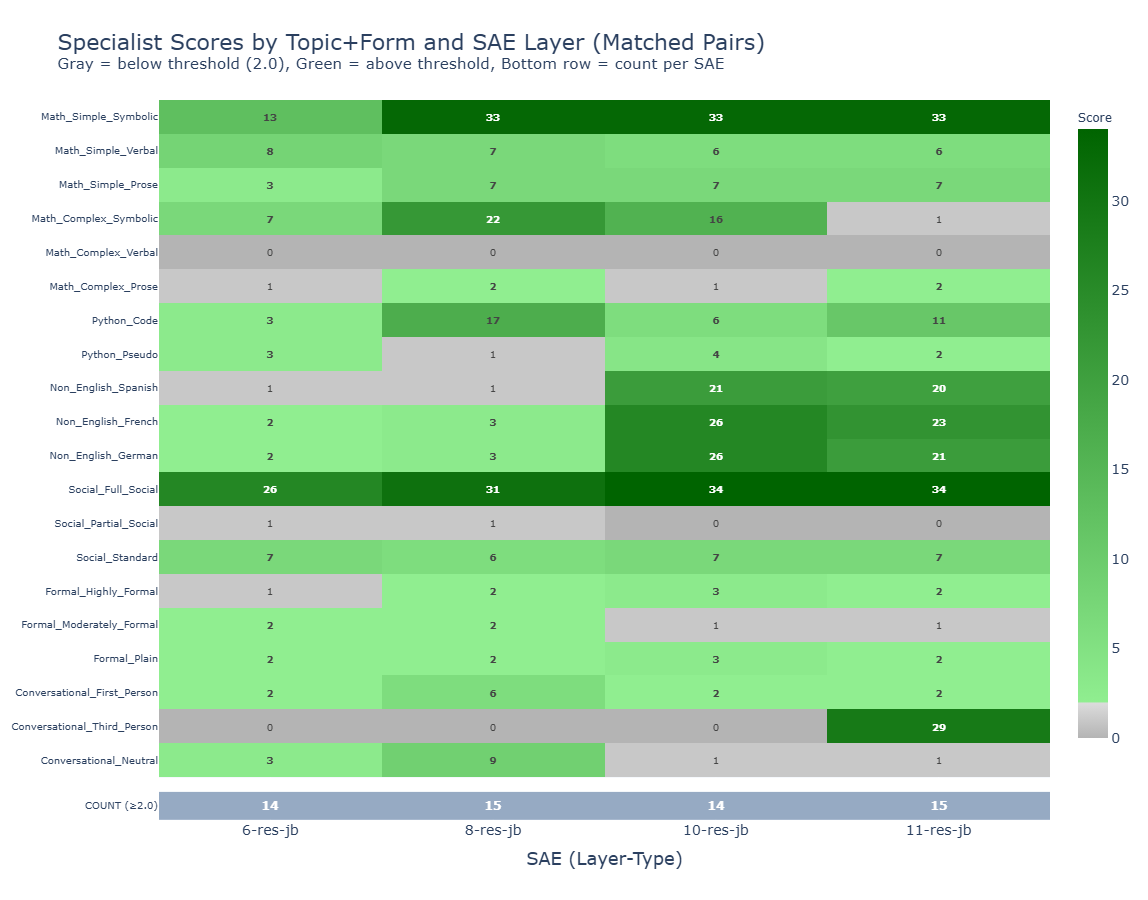


📊 Topic+Form combinations with specialist score ≥ 2.0:
   • 6-res-jb: 14/20
   • 8-res-jb: 15/20
   • 10-res-jb: 14/20
   • 11-res-jb: 15/20

2️⃣-MP Building Layer Progression Analysis (score threshold=2.0)...


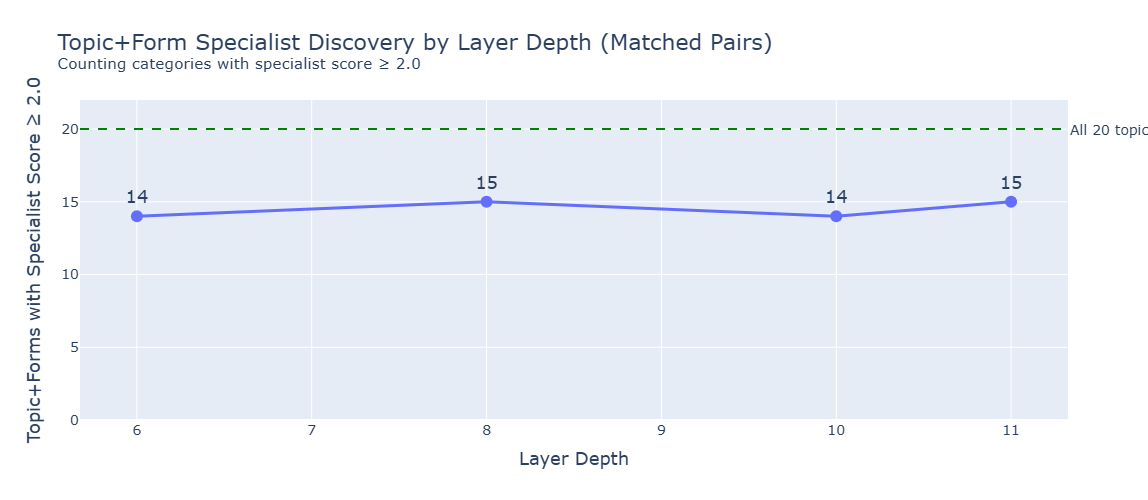


📊 Specialist Count by Layer - Matched Pairs (score ≥ 2.0):
      SAE  Layer  Specialist Count
 6-res-jb      6                14
 8-res-jb      8                15
10-res-jb     10                14
11-res-jb     11                15

3️⃣-MP Building Feature Frequency Comparison (threshold=1.0)...


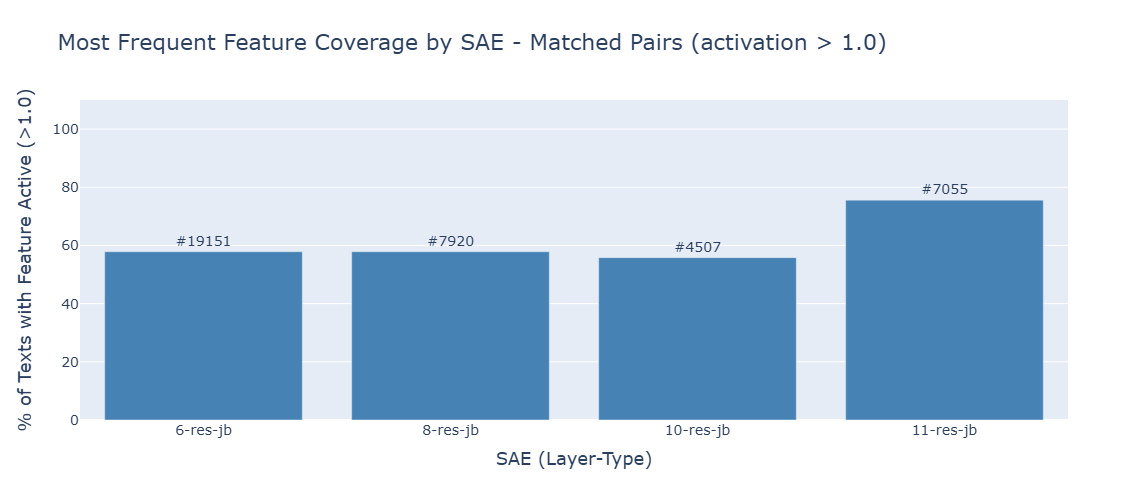


📊 Most Frequent Feature - Matched Pairs (activation > 1.0):
      SAE Feature  Texts Active  Percentage
 6-res-jb  #19151           398   57.848837
 8-res-jb   #7920           398   57.848837
10-res-jb   #4507           384   55.813953
11-res-jb   #7055           520   75.581395

4️⃣-MP Building Topic-Level Specialist Score Heatmap...


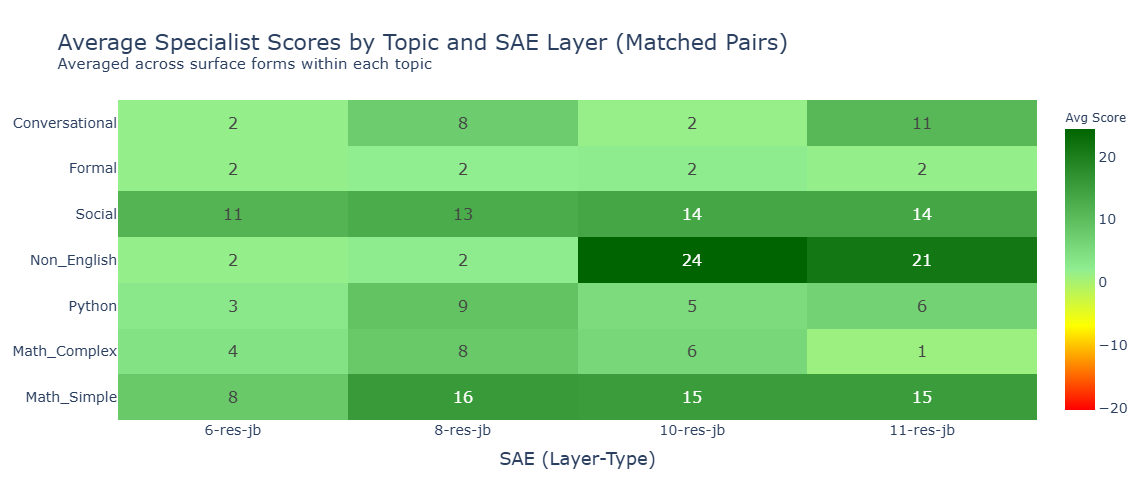


5️⃣-MP Building Form-Type Specialist Analysis...


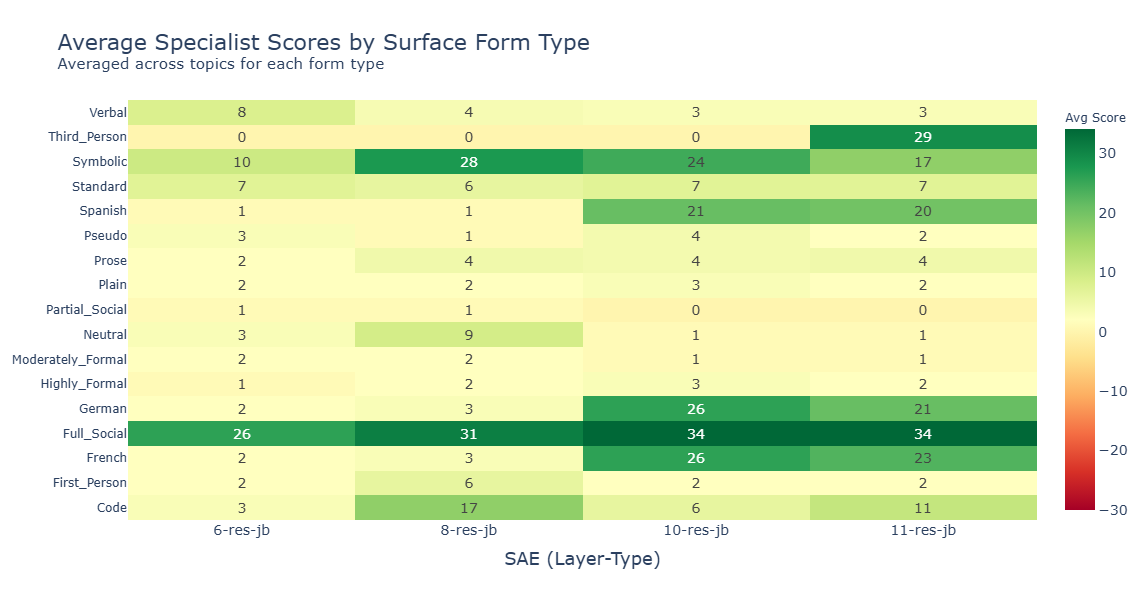


6️⃣-MP Building Top Features Activation Heatmap (threshold=1.0)...


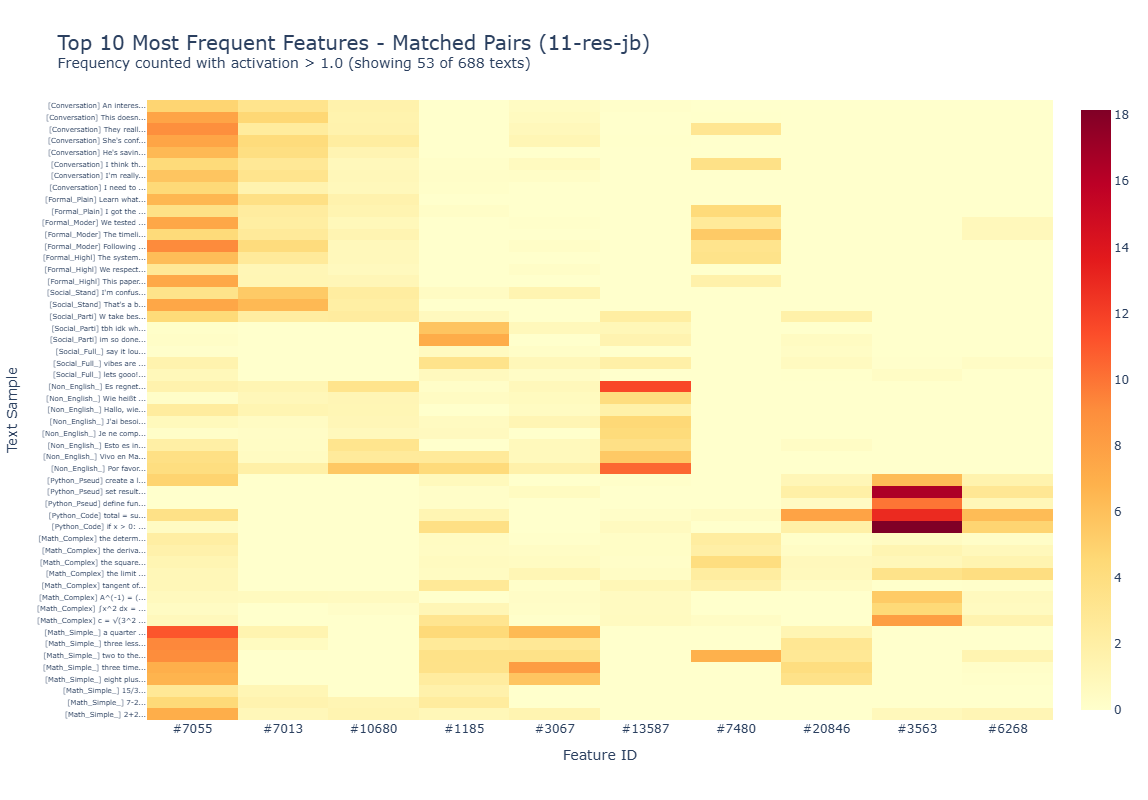


7️⃣-MP Building L0 Sparsity Comparison (threshold=1.0)...


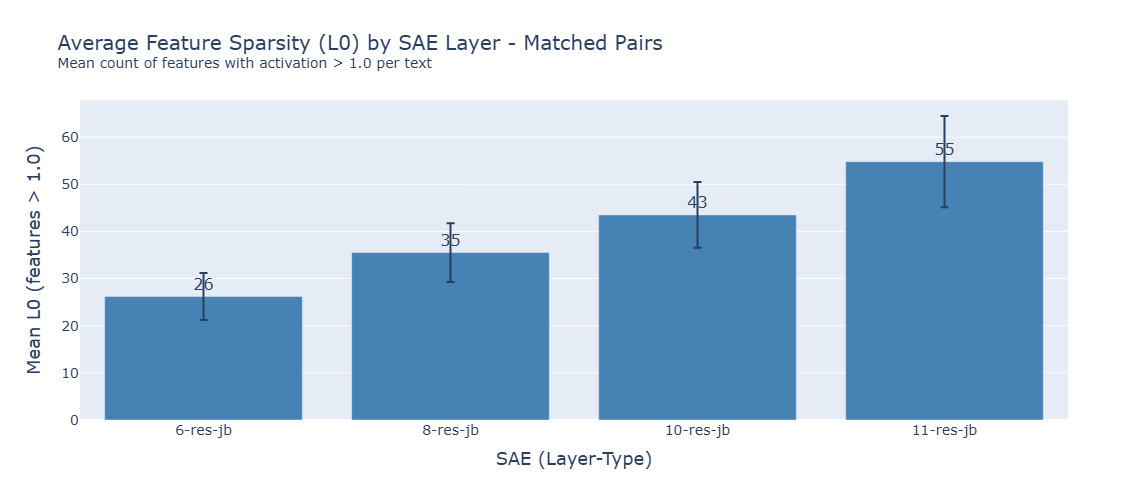


📊 L0 Statistics by Layer - Matched Pairs (activation > 1.0):
      SAE  Layer  Mean L0  Std L0  Min L0  Max L0
 6-res-jb      6     26.2     5.0    13.0    49.0
 8-res-jb      8     35.5     6.2    19.0    62.0
10-res-jb     10     43.5     7.0    23.0    65.0
11-res-jb     11     54.8     9.7    30.0    82.0

📈 BASELINE vs MATCHED PAIRS COMPARISON

📊 Mean L0 Comparison (activation > 1.0):
SAE           Baseline L0   Matched Pairs L0   Difference
--------------------------------------------------------
6-res-jb             26.1               26.2         +0.0
8-res-jb             34.9               35.5         +0.6
10-res-jb            43.5               43.5         -0.0
11-res-jb            53.8               54.8         +1.0

📊 Specialist Count Comparison (score ≥ 2.0):
SAE            Baseline   Matched Pairs
                 (of 7)         (of 20)
----------------------------------------
6-res-jb            N/A              14
8-res-jb            N/A              15
10-res-jb   

In [24]:
# ============================================================================
# CELL 17: Phase 2 Comparison Heatmaps - Phase 2 (Higher Thresholds)
# ============================================================================
print("\n📊 Phase 2 Comparison Heatmaps - Matched Pairs (Higher Thresholds)")
print("=" * 70)
print("""
This cell applies the same higher-threshold analysis from Cell 13 to the
matched pairs dataset (688 texts across 20 topic+form combinations).

This allows comparison of feature behavior between phase 2 texts (688 texts, 20 topic+form combinations)
""")

# Use same thresholds as Cell 13 for consistency
ACTIVATION_THRESHOLD = 1.0  # For feature frequency/L0 counting
SCORE_THRESHOLD = 2.0       # For specialist score counting

print(f"   Activation threshold: {ACTIVATION_THRESHOLD}")
print(f"   Specialist score threshold: {SCORE_THRESHOLD}")
print(f"   Dataset: {len(matched_pairs_texts)} matched pairs texts")
print(f"   Categories: {len(matched_pairs_categories)} topic+form combinations")

# Get category names for matched pairs
mp_category_names = list(matched_pairs_categories.keys())

# -----------------------------------------------------------------------------
# Heatmap 1-MP: Specialist Scores by Topic+Form × SAE (with threshold indicator)
# -----------------------------------------------------------------------------
print("\n1️⃣-MP Building Specialist Score Heatmap (Matched Pairs)...")

# Build specialist score matrix
specialist_matrix_mp = []
for cat_name in mp_category_names:
    row = []
    for sae_name in sae_names:
        cat_data = results_matched_pairs['specialists'][sae_name].get(cat_name)
        score = cat_data['score'] if cat_data else 0
        row.append(score)
    specialist_matrix_mp.append(row)

# Calculate column totals (count of cells >= threshold per column)
column_totals = []
for sae_name in sae_names:
    count = sum(1 for cat_name in mp_category_names
                if results_matched_pairs['specialists'][sae_name].get(cat_name)
                and results_matched_pairs['specialists'][sae_name][cat_name]['score'] >= SCORE_THRESHOLD)
    column_totals.append(count)

# Calculate colorscale breakpoint for threshold
all_scores = [val for row in specialist_matrix_mp for val in row]
z_min = min(all_scores)
z_max = max(all_scores)

# Normalize threshold position in [0, 1] range
threshold_normalized = (SCORE_THRESHOLD - z_min) / (z_max - z_min)

# Create colorscale: gray below threshold, green above
colorscale = [
    [0, 'rgb(180, 180, 180)'],                             # Dark gray for lowest
    [threshold_normalized - 0.001, 'rgb(220, 220, 220)'],  # Light gray just below threshold
    [threshold_normalized, 'rgb(144, 238, 144)'],          # Light green at threshold
    [1, 'rgb(0, 100, 0)']                                  # Dark green for highest
]

# Create text matrix with formatting for main data
text_matrix = []
for row in specialist_matrix_mp:
    text_row = []
    for val in row:
        if val >= SCORE_THRESHOLD:
            text_row.append(f"<b>{val:.0f}</b>")  # Bold if above threshold
        else:
            text_row.append(f"{val:.0f}")
    text_matrix.append(text_row)

# Totals row text (always bold)
totals_text = [[f"<b>{val}</b>" for val in column_totals]]

# Create figure with subplots to have gap between main heatmap and totals
fig1_mp = make_subplots(
    rows=2, cols=1,
    row_heights=[0.96, 0.04],
    vertical_spacing=0.02
)

# Main heatmap (data)
fig1_mp.add_trace(
    go.Heatmap(
        z=specialist_matrix_mp,
        x=sae_names,
        y=mp_category_names,
        colorscale=colorscale,
        text=text_matrix,
        texttemplate="%{text}",
        textfont={"size": 10},
        hovertemplate="SAE: %{x}<br>Topic+Form: %{y}<br>Specialist Score: %{z:.2f}<extra></extra>",
        colorbar=dict(
            tickfont=dict(size=14),
            title=dict(text="Score", font=dict(size=12)),
            y=0.55,
            len=0.9
        ),
        zmin=z_min,
        zmax=z_max,
        showscale=True
    ),
    row=1, col=1
)

# Totals row heatmap (separate trace)
fig1_mp.add_trace(
    go.Heatmap(
        z=[column_totals],
        x=sae_names,
        y=[f'COUNT (≥{SCORE_THRESHOLD})'],
        colorscale=[[0, 'rgb(150, 170, 195)'], [1, 'rgb(150, 170, 195)']],
        text=totals_text,
        texttemplate="%{text}",
        textfont={"size": 12, "color": "white"},
        hovertemplate="SAE: %{x}<br>Count: %{z}<extra></extra>",
        showscale=False
    ),
    row=2, col=1
)

fig1_mp.update_layout(
    title={
        'text': f'Specialist Scores by Topic+Form and SAE Layer (Matched Pairs)<br><sup>Gray = below threshold ({SCORE_THRESHOLD}), Green = above threshold, Bottom row = count per SAE</sup>',
        'font': {'size': 22}
    },
    xaxis_title_font={'size': 18},
    yaxis_title_font={'size': 18},
    xaxis_tickfont={'size': 14},
    yaxis_tickfont={'size': 10},
    xaxis2_tickfont={'size': 14},
    yaxis2_tickfont={'size': 10},
    height=900,
    width=900
)

# Reverse y-axis for main heatmap only
fig1_mp.update_yaxes(autorange='reversed', row=1, col=1)

# Add x-axis title only to bottom subplot
fig1_mp.update_xaxes(title_text='SAE (Layer-Type)', row=2, col=1, title_font={'size': 18})

# Hide x-axis labels on top subplot (they'll show on bottom)
fig1_mp.update_xaxes(showticklabels=False, row=1, col=1)

fig1_mp.show()

# Print summary
print(f"\n📊 Topic+Form combinations with specialist score ≥ {SCORE_THRESHOLD}:")
for sae_idx, sae_name in enumerate(sae_names):
    print(f"   • {sae_name}: {column_totals[sae_idx]}/{len(mp_category_names)}")


# Store counts for comparison
above_threshold_counts_mp = [{'SAE': sae_name, 'Count': column_totals[i]} 
                              for i, sae_name in enumerate(sae_names)]

# -----------------------------------------------------------------------------
# Heatmap 2-MP: Topic+Form Specialist COUNT Progression Across Layers
# -----------------------------------------------------------------------------
print(f"\n2️⃣-MP Building Layer Progression Analysis (score threshold={SCORE_THRESHOLD})...")

specialist_counts_mp = []
for sae_name in sae_names:
    layer = int(sae_name.split('-')[0])
    
    # Count specialists with score >= threshold
    count = sum(1 for cat_name in mp_category_names
                if results_matched_pairs['specialists'][sae_name].get(cat_name)
                and results_matched_pairs['specialists'][sae_name][cat_name]['score'] >= SCORE_THRESHOLD)
    
    specialist_counts_mp.append({
        'SAE': sae_name,
        'Layer': layer,
        'Specialist Count': count,
        'Percentage': (count / len(mp_category_names)) * 100
    })

df_progression_mp = pd.DataFrame(specialist_counts_mp)

fig2_mp = px.line(
    df_progression_mp,
    x='Layer',
    y='Specialist Count',
    markers=True,
    title=f'Topic+Form Specialist Discovery by Layer Depth (Matched Pairs)<br><sup>Counting categories with specialist score ≥ {SCORE_THRESHOLD}</sup>',
    text='Specialist Count'
)

fig2_mp.update_traces(
    textposition='top center',
    textfont=dict(size=18),
    line=dict(width=3),
    marker=dict(size=12)
)

fig2_mp.add_hline(y=len(mp_category_names), line_dash="dash", line_color="green", 
               annotation_text=f"All {len(mp_category_names)} topic+forms", 
               annotation_position="right",
               annotation_font=dict(size=14))

fig2_mp.update_layout(
    title={'font': {'size': 22}},
    height=500,
    width=800,
    xaxis_title='Layer Depth',
    yaxis_title=f'Topic+Forms with Specialist Score ≥ {SCORE_THRESHOLD}',
    xaxis_title_font={'size': 18},
    yaxis_title_font={'size': 18},
    xaxis_tickfont={'size': 14},
    yaxis_tickfont={'size': 14},
    yaxis=dict(range=[0, len(mp_category_names) + 2])
)

fig2_mp.show()

print(f"\n📊 Specialist Count by Layer - Matched Pairs (score ≥ {SCORE_THRESHOLD}):")
print(df_progression_mp[['SAE', 'Layer', 'Specialist Count']].to_string(index=False))


# -----------------------------------------------------------------------------
# Heatmap 3-MP: Feature Frequency Comparison (Higher Threshold)
# -----------------------------------------------------------------------------
print(f"\n3️⃣-MP Building Feature Frequency Comparison (threshold={ACTIVATION_THRESHOLD})...")

frequency_data_mp = []
for sae_name in sae_names:
    features_tensor = get_matched_pairs_features(sae_name)
    
    # Count features ABOVE THRESHOLD per text
    feature_frequency = (features_tensor > ACTIVATION_THRESHOLD).sum(dim=0)
    most_freq_idx = feature_frequency.argmax().item()
    most_freq_count = feature_frequency[most_freq_idx].item()
    
    frequency_data_mp.append({
        'SAE': sae_name,
        'Feature': f"#{most_freq_idx}",
        'Texts Active': most_freq_count,
        'Percentage': (most_freq_count / len(matched_pairs_texts)) * 100
    })

df_frequency_mp = pd.DataFrame(frequency_data_mp)

fig3_mp = px.bar(
    df_frequency_mp,
    x='SAE',
    y='Percentage',
    title=f'Most Frequent Feature Coverage by SAE - Matched Pairs (activation > {ACTIVATION_THRESHOLD})',
    text='Feature'
)

fig3_mp.update_traces(marker_color='steelblue')

fig3_mp.update_traces(textposition='outside', textfont=dict(size=14))
fig3_mp.update_layout(
    title={'font': {'size': 22}},
    height=500,
    width=800,
    xaxis_title='SAE (Layer-Type)',
    yaxis_title=f'% of Texts with Feature Active (>{ACTIVATION_THRESHOLD})',
    xaxis_title_font={'size': 18},
    yaxis_title_font={'size': 18},
    xaxis_tickfont={'size': 14},
    yaxis_tickfont={'size': 14},
    yaxis=dict(range=[0, 110])
)

fig3_mp.show()

print(f"\n📊 Most Frequent Feature - Matched Pairs (activation > {ACTIVATION_THRESHOLD}):")
print(df_frequency_mp.to_string(index=False))


# -----------------------------------------------------------------------------
# Heatmap 4-MP: Specialist Scores Grouped by Topic (averaged across forms)
# -----------------------------------------------------------------------------
print("\n4️⃣-MP Building Topic-Level Specialist Score Heatmap...")

# Get unique topics
topics = list(all_topics.keys())

# Average specialist scores across forms for each topic
topic_specialist_matrix = []
for topic in topics:
    row = []
    for sae_name in sae_names:
        # Get all forms for this topic
        topic_forms = [k for k in mp_category_names if k.startswith(topic + '_')]
        scores = [results_matched_pairs['specialists'][sae_name][tf]['score'] 
                  for tf in topic_forms 
                  if results_matched_pairs['specialists'][sae_name].get(tf)]
        avg_score = sum(scores) / len(scores) if scores else 0
        row.append(avg_score)
    topic_specialist_matrix.append(row)

fig4_mp = go.Figure(data=go.Heatmap(
    z=topic_specialist_matrix,
    x=sae_names,
    y=topics,
    colorscale=[
        [0, 'red'],
        [0.3, 'yellow'],
        [0.5, 'lightgreen'],
        [1, 'darkgreen']
    ],
    zmid=SCORE_THRESHOLD,
    text=[[f"{val:.0f}" for val in row] for row in topic_specialist_matrix],
    texttemplate="%{text}",
    textfont={"size": 16},
    hovertemplate="SAE: %{x}<br>Topic: %{y}<br>Avg Specialist Score: %{z:.2f}<extra></extra>",
    colorbar=dict(
        tickfont=dict(size=14),
        title=dict(text="Avg Score", font=dict(size=12))
    )
))

fig4_mp.update_layout(
    title={
        'text': f'Average Specialist Scores by Topic and SAE Layer (Matched Pairs)<br><sup>Averaged across surface forms within each topic</sup>',
        'font': {'size': 22}
    },
    xaxis_title='SAE (Layer-Type)',
    xaxis_title_font={'size': 18},
    yaxis_title_font={'size': 18},
    xaxis_tickfont={'size': 14},
    yaxis_tickfont={'size': 14},
    height=500,
    width=800
)

fig4_mp.show()


# -----------------------------------------------------------------------------
# Heatmap 5-MP: Specialist Scores by Form Type (collapsed across topics)
# -----------------------------------------------------------------------------
print("\n5️⃣-MP Building Form-Type Specialist Analysis...")

# Get unique forms across all topics
all_forms = set()
for topic, forms in all_topics.items():
    all_forms.update(forms.keys())
all_forms = sorted(list(all_forms))

# For each form, get average specialist score across topics that have that form
form_specialist_matrix = []
for form in all_forms:
    row = []
    for sae_name in sae_names:
        # Find all topic+form combinations with this form
        matching_tfs = [k for k in mp_category_names if k.endswith('_' + form)]
        if matching_tfs:
            scores = [results_matched_pairs['specialists'][sae_name][tf]['score'] 
                      for tf in matching_tfs 
                      if results_matched_pairs['specialists'][sae_name].get(tf)]
            avg_score = sum(scores) / len(scores) if scores else 0
        else:
            avg_score = 0
        row.append(avg_score)
    form_specialist_matrix.append(row)

fig5_mp = go.Figure(data=go.Heatmap(
    z=form_specialist_matrix,
    x=sae_names,
    y=all_forms,
    colorscale='RdYlGn',
    zmid=SCORE_THRESHOLD,
    text=[[f"{val:.0f}" for val in row] for row in form_specialist_matrix],
    texttemplate="%{text}",
    textfont={"size": 14},
    hovertemplate="SAE: %{x}<br>Form: %{y}<br>Avg Specialist Score: %{z:.2f}<extra></extra>",
    colorbar=dict(
        tickfont=dict(size=14),
        title=dict(text="Avg Score", font=dict(size=12))
    )
))

fig5_mp.update_layout(
    title={
        'text': f'Average Specialist Scores by Surface Form Type<br><sup>Averaged across topics for each form type</sup>',
        'font': {'size': 22}
    },
    xaxis_title='SAE (Layer-Type)',
    xaxis_title_font={'size': 18},
    yaxis_title_font={'size': 18},
    xaxis_tickfont={'size': 14},
    yaxis_tickfont={'size': 12},
    height=600,
    width=800
)

fig5_mp.show()

# -----------------------------------------------------------------------------
# Heatmap 6-MP: Top 10 Most Frequent Features (Higher Threshold)
# -----------------------------------------------------------------------------
print(f"\n6️⃣-MP Building Top Features Activation Heatmap (threshold={ACTIVATION_THRESHOLD})...")

analysis_sae = "11-res-jb"
features_tensor_mp = get_matched_pairs_features(analysis_sae)

# Get top 10 most frequent features WITH THRESHOLD
feature_frequency_mp_ht = (features_tensor_mp > ACTIVATION_THRESHOLD).sum(dim=0)
top_10_freq_mp = feature_frequency_mp_ht.topk(10)
top_10_indices_mp = top_10_freq_mp.indices.tolist()
top_10_counts_mp = top_10_freq_mp.values.tolist()
top_10_labels_mp = [f"#{idx}" for idx in top_10_indices_mp]

# Create text labels (sample every Nth text for readability)
sample_rate = max(1, len(matched_pairs_texts) // 50)  # Show ~50 texts max
sampled_indices = list(range(0, len(matched_pairs_texts), sample_rate))

text_labels_mp = []
for i in sampled_indices:
    cat_label = matched_pairs_labels[i][:12]  # First 12 chars of topic+form
    text_short = matched_pairs_texts[i][:10].replace('\n', ' ') + "..."
    text_labels_mp.append(f"[{cat_label}] {text_short}")

# Create activation matrix for sampled texts
activation_matrix_mp = features_tensor_mp[sampled_indices][:, top_10_indices_mp].detach().numpy()

fig6_mp = go.Figure(data=go.Heatmap(
    z=activation_matrix_mp,
    x=top_10_labels_mp,
    y=text_labels_mp,
    colorscale='YlOrRd',
    hoverongaps=False,
    hovertemplate='Text: %{y}<br>Feature: %{x}<br>Activation: %{z:.2f}<extra></extra>'
))

fig6_mp.update_layout(
    title={
        'text': f'Top 10 Most Frequent Features - Matched Pairs ({analysis_sae})<br><sup>Frequency counted with activation > {ACTIVATION_THRESHOLD} (showing {len(sampled_indices)} of {len(matched_pairs_texts)} texts)</sup>',
        'font': {'size': 20}
    },
    xaxis_title='Feature ID',
    yaxis_title='Text Sample',
    height=800,
    width=900,
    xaxis={'tickfont': {'size': 12}},
    yaxis={'tickfont': {'size': 7}}
)

fig6_mp.show()

# Display Neuronpedia links
top10_links_html_mp = f"""
<div style="margin: 20px 0; padding: 15px; border: 1px solid #ddd; border-radius: 8px; background: #f9f9f9;">
    <h4 style="margin-top: 0;">🔗 Top 10 Most Frequent Features - Matched Pairs (activation > {ACTIVATION_THRESHOLD})</h4>
    <table style="border-collapse: collapse; width: 100%;">
        <tr style="background: #e0e0e0;">
            <th style="padding: 8px; text-align: left; border: 1px solid #ccc;">Rank</th>
            <th style="padding: 8px; text-align: left; border: 1px solid #ccc;">Feature</th>
            <th style="padding: 8px; text-align: left; border: 1px solid #ccc;">Texts Active (>{ACTIVATION_THRESHOLD})</th>
            <th style="padding: 8px; text-align: left; border: 1px solid #ccc;">Neuronpedia Link</th>
        </tr>
"""

for rank, (feat_idx, count) in enumerate(zip(top_10_indices_mp, top_10_counts_mp), 1):
    link = neuronpedia_link(analysis_sae, feat_idx)
    top10_links_html_mp += f"""
        <tr>
            <td style="padding: 8px; border: 1px solid #ccc;">{rank}</td>
            <td style="padding: 8px; border: 1px solid #ccc; font-family: monospace;">#{feat_idx}</td>
            <td style="padding: 8px; border: 1px solid #ccc;">{int(count)}/{len(matched_pairs_texts)}</td>
            <td style="padding: 8px; border: 1px solid #ccc;">
                <a href="{link}" target="_blank" style="color: #0066cc;">{link}</a>
            </td>
        </tr>
    """

top10_links_html_mp += """
    </table>
</div>
"""

display(HTML(top10_links_html_mp))

# -----------------------------------------------------------------------------
# Heatmap 7-MP: L0 Sparsity Comparison
# -----------------------------------------------------------------------------
print(f"\n7️⃣-MP Building L0 Sparsity Comparison (threshold={ACTIVATION_THRESHOLD})...")

l0_data_mp = []
for sae_name in sae_names:
    features_tensor = get_matched_pairs_features(sae_name)
    layer = int(sae_name.split('-')[0])
    
    # L0 = count of features above threshold per text
    l0_per_text = (features_tensor > ACTIVATION_THRESHOLD).sum(dim=1).float()
    
    l0_data_mp.append({
        'SAE': sae_name,
        'Layer': layer,
        'Mean L0': l0_per_text.mean().item(),
        'Std L0': l0_per_text.std().item(),
        'Min L0': l0_per_text.min().item(),
        'Max L0': l0_per_text.max().item()
    })

df_l0_mp = pd.DataFrame(l0_data_mp)

fig7_mp = go.Figure()

fig7_mp.add_trace(go.Bar(
    x=df_l0_mp['SAE'],
    y=df_l0_mp['Mean L0'],
    error_y=dict(type='data', array=df_l0_mp['Std L0'], visible=True),
    marker_color='steelblue',
    text=[f"{v:.0f}" for v in df_l0_mp['Mean L0']],
    textposition='outside',
    textfont=dict(size=16)
))

fig7_mp.update_layout(
    title={
        'text': f'Average Feature Sparsity (L0) by SAE Layer - Matched Pairs<br><sup>Mean count of features with activation > {ACTIVATION_THRESHOLD} per text</sup>',
        'font': {'size': 20}
    },
    height=500,
    width=800,
    xaxis_title='SAE (Layer-Type)',
    yaxis_title=f'Mean L0 (features > {ACTIVATION_THRESHOLD})',
    xaxis_title_font={'size': 18},
    yaxis_title_font={'size': 18},
    xaxis_tickfont={'size': 14},
    yaxis_tickfont={'size': 14}
)

fig7_mp.show()

print(f"\n📊 L0 Statistics by Layer - Matched Pairs (activation > {ACTIVATION_THRESHOLD}):")
print(df_l0_mp.to_string(index=False, float_format=lambda x: f"{x:.1f}"))

# -----------------------------------------------------------------------------
# Comparison: Baseline vs Matched Pairs
# -----------------------------------------------------------------------------
print("\n" + "=" * 70)
print("📈 BASELINE vs MATCHED PAIRS COMPARISON")
print("=" * 70)

# Compare L0 between datasets
print(f"\n📊 Mean L0 Comparison (activation > {ACTIVATION_THRESHOLD}):")
print(f"{'SAE':<12} {'Baseline L0':>12} {'Matched Pairs L0':>18} {'Difference':>12}")
print("-" * 56)
for i, sae_name in enumerate(sae_names):
    baseline_l0 = df_l0['Mean L0'].iloc[i] if 'df_l0' in dir() else 'N/A'
    mp_l0 = df_l0_mp['Mean L0'].iloc[i]
    if isinstance(baseline_l0, float):
        diff = mp_l0 - baseline_l0
        print(f"{sae_name:<12} {baseline_l0:>12.1f} {mp_l0:>18.1f} {diff:>+12.1f}")
    else:
        print(f"{sae_name:<12} {'N/A':>12} {mp_l0:>18.1f} {'N/A':>12}")

# Compare specialist counts
print(f"\n📊 Specialist Count Comparison (score ≥ {SCORE_THRESHOLD}):")
print(f"{'SAE':<12} {'Baseline':>10} {'Matched Pairs':>15}")
print(f"{'':12} {'(of 7)':>10} {'(of 20)':>15}")
print("-" * 40)
for i, sae_name in enumerate(sae_names):
    baseline_count = above_threshold_counts[i]['Count'] if 'above_threshold_counts' in dir() else 'N/A'
    mp_count = above_threshold_counts_mp[i]['Count']
    print(f"{sae_name:<12} {baseline_count:>10} {mp_count:>15}")

print("\n" + "=" * 70)

In [8]:
# ============================================================================
# CELL 8: Print Detailed Per-SAE Output (Baseline Text)
# ============================================================================

# After running analyses for each SAE, print detailed findings
for sae_name in loaded_saes:
    print(f"\n{'='*70}")
    print(f"📊 DETAILED ANALYSIS FOR SAE: {sae_name}")
    print(f"{'='*70}")
    
    # Show strongest feature details
    strongest = results['strongest'][sae_name]
    print(f"\n1️⃣ STRONGEST Feature: #{strongest['feature_idx']}")
    print(f"   Max activation: {strongest['value']:.2f}")
    print(f"   Text: {strongest['text'][:100]}...")
    print(f"   🔗 {neuronpedia_link(sae_name, strongest['feature_idx'])}")
    
    # Show most frequent
    frequent = results['most_frequent'][sae_name]
    print(f"\n2️⃣ MOST FREQUENT Feature: #{frequent['feature_idx']}")
    print(f"   Active in: {int(frequent['value'])}/{len(baseline_texts)} texts ({100*frequent['value']/len(baseline_texts):.1f}%)")
    print(f"   🔗 {neuronpedia_link(sae_name, frequent['feature_idx'])}")
    
    # Show selective
    selective = results['most_selective'][sae_name]
    print(f"\n3️⃣ MOST SELECTIVE Feature: #{selective['feature_idx']}")
    print(f"   Max: {selective['value']:.2f}")
    print(f"   Strong activations (>5.0): {selective['selective_count']}/{len(baseline_texts)}")
    print(f"   Any activations (>0): {selective['total_active_count']}/{len(baseline_texts)}")
    print(f"   🔗 {neuronpedia_link(sae_name, selective['feature_idx'])}")
    
    # Show category specialists summary
    print(f"\n4️⃣ CATEGORY SPECIALISTS:")
    specialist_count = 0
    for cat_name, cat_data in results['specialists'][sae_name].items():
        if cat_data and cat_data['score'] > 0:
            specialist_count += 1
            print(f"   ✅ {cat_name}: Feature #{cat_data['feature_idx']} (score: {cat_data['score']})")
            print(f"      🔗 {neuronpedia_link(sae_name, cat_data['feature_idx'])}")  # Added link
        else:
            print(f"   ❌ {cat_name}: No specialist found")
    
    print(f"\n📊 Summary: {specialist_count}/{len(baseline_categories)} baseline categories have specialists (score > 0)")



📊 DETAILED ANALYSIS FOR SAE: 6-res-jb

1️⃣ STRONGEST Feature: #2351
   Max activation: 12.94
   Text: مرحبا، كيف حالك؟...
   🔗 https://neuronpedia.org/gpt2-small/6-res-jb/2351

2️⃣ MOST FREQUENT Feature: #16383
   Active in: 69/70 texts (98.6%)
   🔗 https://neuronpedia.org/gpt2-small/6-res-jb/16383

3️⃣ MOST SELECTIVE Feature: #461
   Max: 5.28
   Strong activations (>5.0): 1/70
   Any activations (>0): 4/70
   🔗 https://neuronpedia.org/gpt2-small/6-res-jb/461

4️⃣ CATEGORY SPECIALISTS:
   ✅ Python: Feature #12645 (score: 5)
      🔗 https://neuronpedia.org/gpt2-small/6-res-jb/12645
   ✅ URLs: Feature #20051 (score: 2)
      🔗 https://neuronpedia.org/gpt2-small/6-res-jb/20051
   ✅ Math: Feature #13955 (score: 6)
      🔗 https://neuronpedia.org/gpt2-small/6-res-jb/13955
   ✅ Non-English: Feature #2351 (score: 1)
      🔗 https://neuronpedia.org/gpt2-small/6-res-jb/2351
   ✅ Social: Feature #10220 (score: 5)
      🔗 https://neuronpedia.org/gpt2-small/6-res-jb/10220
   ✅ Formal: Feature #2

In [10]:
# ============================================================================
# CELL 10: Token-Level Feature Activation Highlighting (Baseline Text)
# ============================================================================
print("\n🎨 Token-Level Feature Activation Highlighting (Baseline Text)")
print("=" * 70)
print("""
Goal: For each specialist feature identified in Phase 1, visualize its 
activation across ALL text categories to see how it responds to its 
target category vs. other categories.
""")

# -----------------------------------------------------------------------------
# Helper Functions for Token-Level Analysis
# -----------------------------------------------------------------------------

def get_token_level_features(text: str, sae, hook_point: str) -> tuple:
    """
    Get per-token feature activations for a single text.
    
    Returns:
        features: Tensor of shape [seq_len, d_sae] - activation per token per feature
        token_strs: List of token strings
    """
    # Tokenize single text
    tokens = model.to_tokens(text, prepend_bos=True)
    
    # Run model and capture activations
    with torch.no_grad():
        _, cache = model.run_with_cache(tokens, names_filter=[hook_point])
    
    # Get activations - shape: [1, seq_len, d_model]
    activations = cache[hook_point]
    
    # Pass through SAE encoder for EACH token position (no averaging!)
    features = sae.encode(activations)
    
    # Get human-readable token strings
    token_strs = model.to_str_tokens(tokens[0])
    
    return features[0], token_strs


def create_highlighted_text_html_cached(
    text: str, 
    feature_idx: int, 
    color: tuple = (255, 165, 0)
) -> tuple:
    """
    Create inline HTML using cached token-level features.
    """
    cached = token_level_cache[text]
    features = cached['features']
    token_strs = cached['token_strs']
    
    feature_acts = features[:, feature_idx].detach().numpy()
    
    max_act = feature_acts.max()
    if max_act > 0:
        normalized = feature_acts / max_act
    else:
        normalized = np.zeros_like(feature_acts)
    
    r, g, b = color
    
    html_parts = []
    for token, act_val, norm_val in zip(token_strs, feature_acts, normalized):
        safe_token = html.escape(token)
        safe_token = safe_token.replace('\n', '↵').replace('\t', '→')
        
        opacity = float(norm_val) * 0.8 + 0.1 if norm_val > 0 else 0
        bg_color = f"rgba({r}, {g}, {b}, {opacity:.2f})"
        
        html_parts.append(
            f'<span style="background-color: {bg_color}; padding: 1px 2px; '
            f'border-radius: 3px;" title="activation: {act_val:.3f}">{safe_token}</span>'
        )
    
    return ''.join(html_parts), max_act


def display_specialist_feature_analysis(
    sae_name: str,
    category_name: str,
    feature_idx: int,
    specialist_score: int,
    categories: dict,
    texts: list
):
    """
    Display a single specialist feature with its activations across ALL categories.
    """
    sae_obj = loaded_saes[sae_name]['sae']
    hook_point = loaded_saes[sae_name]['config']['hook_point']
    
    # Neuronpedia link
    np_url = f"https://neuronpedia.org/gpt2-small/{sae_name}/{feature_idx}"
    
    # Color for the specialist's target category (orange) vs others (gray)
    target_color = (255, 165, 0)   # Orange for target category
    other_color = (128, 128, 128)  # Gray for other categories
    
    # Build HTML
    html_content = f"""
    <div style="margin: 20px 0; padding: 15px; border: 2px solid #ddd; border-radius: 10px; background: #fafafa;">
        <h3 style="margin-top: 0;">
            <a href="{np_url}" target="_blank" style="color: #0066cc; text-decoration: none;">
                Feature #{feature_idx}
            </a>
            <span style="font-size: 20px; font-weight: normal; color: #666;">
                | {sae_name} | {category_name} Specialist | Score: {specialist_score}
            </span>
        </h3>
    """
    
    # Process each category
    for cat_name, cat_texts in categories.items():
        # Determine if this is the target category
        is_target = (cat_name == category_name)
        color = target_color if is_target else other_color
        border_style = "border-left: 4px solid #ff9800;" if is_target else "border-left: 4px solid #ccc;"
        bg_style = "background: #fff8e1;" if is_target else "background: #f5f5f5;"
        
        # Category header with TARGET badge if applicable
        target_badge = ' <span style="background: #ff9800; color: white; padding: 2px 6px; border-radius: 3px; font-size: 20px;">TARGET</span>' if is_target else ''
        
        html_content += f"""
        <div style="margin: 15px 0; padding: 10px; {border_style} {bg_style} border-radius: 0 5px 5px 0;">
            <h4 style="margin: 0 0 10px 0; color: #333;">{cat_name}{target_badge}</h4>
            <ul style="margin: 0; padding-left: 20px; list-style-type: none;">
        """
        
        # Process each text in this category
        for text in cat_texts:
            highlighted_html, max_act = create_highlighted_text_html_cached(
                text=text,
                feature_idx=feature_idx,
                color=color
            )
                        
            # Format max activation with color coding
            if max_act > 5.0:
                act_style = "color: #d32f2f; font-weight: bold;"  # Red for strong
            elif max_act > 1.0:
                act_style = "color: #f57c00;"  # Orange for moderate
            else:
                act_style = "color: #999;"  # Gray for weak
            
            html_content += f"""
                <li style="margin: 8px 0; font-family: monospace; font-size: 20px; line-height: 1.6;">
                    <span style="{act_style}">[{max_act:.2f}]</span> {highlighted_html}
                </li>
            """
        
        html_content += """
            </ul>
        </div>
        """
    
    html_content += "</div>"
    
    display(HTML(html_content))


print("✅ get_token_level_features() defined")
print("✅ create_highlighted_text_html() defined")
print("✅ display_specialist_feature_analysis() defined")
print("=" * 70)

# -----------------------------------------------------------------------------
# Main Analysis: Display All Specialist Features
# -----------------------------------------------------------------------------
print("\n📊 SPECIALIST FEATURE ANALYSIS")
print("=" * 70)

# Choose which SAE to analyze (using layer 11 since it has 7/7 specialists)
analysis_sae = "11-res-jb"
print(f"Analyzing specialists from: {analysis_sae}")

# Check if cached token-level features exist
cache_file = 'phase1_token_level_features.pkl'

if os.path.exists(cache_file):
    print("📂 Loading cached token-level features...")
    with open(cache_file, 'rb') as f:
        token_level_cache = pickle.load(f)
    print("✅ Loaded cached features!")
else:
    print("1️⃣ Computing token-level features for all baseline texts...")
    token_level_cache = {}
    
    sae_obj = loaded_saes[analysis_sae]['sae']
    hook_point = loaded_saes[analysis_sae]['config']['hook_point']
    
    for i, text in enumerate(baseline_texts):
        features, token_strs = get_token_level_features(text, sae_obj, hook_point)
        token_level_cache[text] = {
            'features': features.cpu(),  # Move to CPU for pickling
            'token_strs': token_strs
        }
        if (i + 1) % 10 == 0:
            print(f"   Processed {i + 1}/{len(baseline_texts)} texts...")
    
    # Save cache
    with open(cache_file, 'wb') as f:
        pickle.dump(token_level_cache, f)
    print(f"✅ Saved token-level features to {cache_file}")

print(f"This SAE found specialists for {sum(1 for c in results['specialists'][analysis_sae].values() if c and c['score'] > 0)}/{len(baseline_categories)} categories")
print("=" * 70)




# Loop through each category and display its specialist
for cat_name, cat_data in results['specialists'][analysis_sae].items():
    if cat_data and cat_data['score'] > 0:
        print(f"\n{'='*70}")
        print(f"📌 {cat_name} Specialist")
        print(f"{'='*70}")
        
        # Use cached version in display_specialist_feature_analysis
        # (you'd update that function to use create_highlighted_text_html_cached)
        display_specialist_feature_analysis(
            sae_name=analysis_sae,
            category_name=cat_name,
            feature_idx=cat_data['feature_idx'],
            specialist_score=cat_data['score'],
            categories=baseline_categories,
            texts=baseline_texts
        )
    else:
        print(f"\n⚠️ No specialist found for {cat_name}")

print("\n" + "=" * 70)
print("🎨 SPECIALIST FEATURE ANALYSIS COMPLETE")
print("=" * 70)


🎨 Token-Level Feature Activation Highlighting (Baseline Text)

Goal: For each specialist feature identified in Phase 1, visualize its 
activation across ALL text categories to see how it responds to its 
target category vs. other categories.

✅ get_token_level_features() defined
✅ create_highlighted_text_html() defined
✅ display_specialist_feature_analysis() defined

📊 SPECIALIST FEATURE ANALYSIS
Analyzing specialists from: 11-res-jb
📂 Loading cached token-level features...
✅ Loaded cached features!
This SAE found specialists for 7/7 categories

📌 Python Specialist



📌 URLs Specialist



📌 Math Specialist



📌 Non-English Specialist



📌 Social Specialist



📌 Formal Specialist



📌 Conversational Specialist



🎨 SPECIALIST FEATURE ANALYSIS COMPLETE


In [11]:
# ============================================================================
# CELL 11: Create Form-Specific Baselines with Topic-Excluded Contrast Sets
# ============================================================================
print("\n" + "=" * 70)
print("📊 FORM-SPECIFIC BASELINE CREATION")
print("=" * 70)
print("""
For each topic+form combination, we identify specialists by comparing against
ALL other topic+form combinations from the matched pairs (Cell 6), EXCLUDING
forms from the same topic.

Example: Math_Simple_Symbolic is compared against:
  - Math_Complex (all 3 forms)
  - Python (all 2 forms)
  - Non_English (all 3 forms)
  - Social (all 3 forms)
  - Formal (all 3 forms)
  - Conversational (all 3 forms)
  
But NOT against Math_Simple_Verbal or Math_Simple_Prose.

NOTE: Baseline texts from Cell 5 are NOT used in this analysis.
""")

# -----------------------------------------------------------------------------
# Step 1: Define all topic+form combinations using Cell 6 matched pairs
# -----------------------------------------------------------------------------
print("1️⃣ Defining topic+form combinations from matched pairs (Cell 6)...\n")

# Structure: {topic_name: {form_name: [texts]}}
all_topics = {
    'Math_Simple': {
        'Symbolic': [p['symbolic'] for p in math_pairs_simple],
        'Verbal': [p['verbal'] for p in math_pairs_simple],
        'Prose': [p['prose'] for p in math_pairs_simple]
    },
    'Math_Complex': {
        'Symbolic': [p['symbolic'] for p in math_pairs_complex],
        'Verbal': [p['verbal'] for p in math_pairs_complex],
        'Prose': [p['prose'] for p in math_pairs_complex]
    },
    'Python': {
        'Code': [p['code'] for p in python_pairs],
        'Pseudo': [p['pseudo'] for p in python_pairs]
    },
    'Non_English': {
        'Spanish': [p['spanish'] for p in non_english_pairs],
        'French': [p['french'] for p in non_english_pairs],
        'German': [p['german'] for p in non_english_pairs]
    },
    'Social': {
        'Full_Social': [p['full_social'] for p in social_pairs],
        'Partial_Social': [p['partial_social'] for p in social_pairs],
        'Standard': [p['standard'] for p in social_pairs]
    },
    'Formal': {
        'Highly_Formal': [p['highly_formal'] for p in formal_pairs],
        'Moderately_Formal': [p['moderately_formal'] for p in formal_pairs],
        'Plain': [p['plain'] for p in formal_pairs]
    },
    'Conversational': {
        'First_Person': [p['first_person'] for p in conversational_pairs],
        'Third_Person': [p['third_person'] for p in conversational_pairs],
        'Neutral': [p['neutral'] for p in conversational_pairs]
    }
}

# Flatten to topic+form keys for easier access
all_topic_forms = {}
for topic, forms in all_topics.items():
    for form, texts in forms.items():
        key = f"{topic}_{form}"
        all_topic_forms[key] = {
            'topic': topic,
            'form': form,
            'texts': texts
        }

# Display summary
print(f"   Total topics: {len(all_topics)}")
print(f"   Total topic+form combinations: {len(all_topic_forms)}")
print()

for topic, forms in all_topics.items():
    total_texts = sum(len(texts) for texts in forms.values())
    print(f"   {topic}: {len(forms)} forms, {total_texts} texts total")
    for form, texts in forms.items():
        print(f"      • {form}: {len(texts)} texts")

# -----------------------------------------------------------------------------
# Step 2: Build contrast sets for each topic+form
# -----------------------------------------------------------------------------
print("\n" + "=" * 70)
print("2️⃣ Building contrast sets (excluding same-topic forms)...\n")

form_analysis_configs = {}

for target_key, target_info in all_topic_forms.items():
    target_topic = target_info['topic']
    
    # Contrast = all topic+forms EXCEPT those from the same topic
    contrast_texts = []
    contrast_sources = []
    
    for other_key, other_info in all_topic_forms.items():
        if other_info['topic'] != target_topic:
            contrast_texts.extend(other_info['texts'])
            contrast_sources.append(other_key)
    
    form_analysis_configs[target_key] = {
        'target_key': target_key,
        'topic': target_topic,
        'form': target_info['form'],
        'target_texts': target_info['texts'],
        'contrast_texts': contrast_texts,
        'contrast_sources': contrast_sources
    }

# Display contrast set sizes
print("   Contrast set sizes by topic:")
for topic in all_topics.keys():
    # Get any form from this topic to check contrast size
    sample_key = [k for k in form_analysis_configs.keys() if k.startswith(topic)][0]
    contrast_size = len(form_analysis_configs[sample_key]['contrast_texts'])
    print(f"   • {topic} forms: {contrast_size} contrast texts")

# -----------------------------------------------------------------------------
# Step 3: Summary table
# -----------------------------------------------------------------------------
print("\n" + "=" * 70)
print("📋 FORM-SPECIFIC BASELINES READY")
print("=" * 70)

summary_data = []
for key, config in form_analysis_configs.items():
    # Count contrast topics
    contrast_topics = set(all_topic_forms[s]['topic'] for s in config['contrast_sources'])
    
    summary_data.append({
        'Topic+Form': key,
        'Topic': config['topic'],
        'Form': config['form'],
        'Target Texts': len(config['target_texts']),
        'Contrast Texts': len(config['contrast_texts']),
        'Contrast Topics': len(contrast_topics)
    })

df_config_summary = pd.DataFrame(summary_data)
display(df_config_summary)

# Total texts check
total_texts = sum(len(info['texts']) for info in all_topic_forms.values())
print(f"\n   Total texts across all topic+form combinations: {total_texts}")

print("\n✅ Ready for specialist identification in Cell 20")


📊 FORM-SPECIFIC BASELINE CREATION

For each topic+form combination, we identify specialists by comparing against
ALL other topic+form combinations from the matched pairs (Cell 6), EXCLUDING
forms from the same topic.

Example: Math_Simple_Symbolic is compared against:
  - Math_Complex (all 3 forms)
  - Python (all 2 forms)
  - Non_English (all 3 forms)
  - Social (all 3 forms)
  - Formal (all 3 forms)
  - Conversational (all 3 forms)
  
But NOT against Math_Simple_Verbal or Math_Simple_Prose.

NOTE: Baseline texts from Cell 5 are NOT used in this analysis.

1️⃣ Defining topic+form combinations from matched pairs (Cell 6)...

   Total topics: 7
   Total topic+form combinations: 20

   Math_Simple: 3 forms, 99 texts total
      • Symbolic: 33 texts
      • Verbal: 33 texts
      • Prose: 33 texts
   Math_Complex: 3 forms, 99 texts total
      • Symbolic: 33 texts
      • Verbal: 33 texts
      • Prose: 33 texts
   Python: 2 forms, 70 texts total
      • Code: 35 texts
      • Pseudo: 35

Topic+Form           Topic               Form  \
0          Math_Simple_Symbolic     Math_Simple           Symbolic   
1            Math_Simple_Verbal     Math_Simple             Verbal   
2             Math_Simple_Prose     Math_Simple              Prose   
3         Math_Complex_Symbolic    Math_Complex           Symbolic   
4           Math_Complex_Verbal    Math_Complex             Verbal   
5            Math_Complex_Prose    Math_Complex              Prose   
6                   Python_Code          Python               Code   
7                 Python_Pseudo          Python             Pseudo   
8           Non_English_Spanish     Non_English            Spanish   
9            Non_English_French     Non_English             French   
10           Non_English_German     Non_English             German   
11           Social_Full_Social          Social        Full_Social   
12        Social_Partial_Social          Social     Partial_Social   
13              Social_Standard          Social           Standard   
14         Formal_Highly_Formal          Formal      Highly_Formal   
15     Formal_Moderately_Formal          Formal  Moderately_Formal   
16                 Formal_Plain          Formal              Plain   
17  Conversational_First_Person  Conversational       First_Person   
18  Conversational_Third_Person  Conversational       Third_Person   
19       Conversational_Neutral  Conversational            Neutral   

    Target Texts  Contrast Texts  Contrast Topics  
0             33             589                6  
1             33             589                6  
2             33             589                6  
3             33             589                6  
4             33             589                6  
5             33             589                6  
6             35             618                6  
7             35             618                6  
8             35             583                6  
9             35             583                6  
10            35             583                6  
11            35             583                6  
12            35             583                6  
13            35             583                6  
14            35             583                6  
15            35             583                6  
16            35             583                6  
17            35             583                6  
18            35             583                6  
19            35             583                6


   Total texts across all topic+form combinations: 688

✅ Ready for specialist identification in Cell 20


In [12]:
# ============================================================================
# CELL 12: Form-Specific Specialist Identification (Top-N)
# ============================================================================
import os

print("\n" + "=" * 70)
print("🔬 FORM-SPECIFIC SPECIALIST IDENTIFICATION (TOP-N)")
print("=" * 70)
print("""
For each topic+form, identify the TOP-5 specialist features that best 
distinguish it from all other topic+form combinations.

Key question: Do different forms within the same topic share the SAME
constellation of specialists, or do they activate DIFFERENT features?
""")



# Check if saved results exist
if os.path.exists('phase2_form_specialists_topn.pkl'):
    print("📂 Loading saved Phase 2 results from disk...")
    with open('phase2_form_specialists_topn.pkl', 'rb') as f:
        phase2_data = pickle.load(f)
    
    form_specific_specialists = phase2_data['form_specific_specialists']
    form_analysis_configs = phase2_data['form_analysis_configs']
    all_topics = phase2_data['all_topics']
    all_topic_forms = phase2_data['all_topic_forms']
    TOP_N = phase2_data.get('top_n', 5)
    print(f"✅ Loaded saved results (top_n={TOP_N})!")

else:
    # -----------------------------------------------------------------------------
    # Step 12a: Run specialist identification for each topic+form
    # -----------------------------------------------------------------------------
    print(f"1️⃣ No saved results found, running specialist identification (top_n={TOP_N})...\n")
    
    form_specific_specialists = {}
    
    for target_key, config in form_analysis_configs.items():
        print(f"   Analyzing {target_key}...")
        
        # Build categories dict for analyze_specialists
        categories = {
            target_key: config['target_texts'],
            'Other': config['contrast_texts']
        }
        
        # Flatten all texts
        all_texts = config['target_texts'] + config['contrast_texts']
        
        form_specific_specialists[target_key] = {}
        
        for sae_name in loaded_saes:
            sae_obj = loaded_saes[sae_name]['sae']
            hook_point = loaded_saes[sae_name]['config']['hook_point']
            
            # Extract features
            features = extract_features(all_texts, sae_obj, hook_point)
            
            # Run TOP-N specialist analysis
            specialists = analyze_specialists_topn(
                features=features,
                texts=all_texts,
                categories=categories,
                top_n=TOP_N
            )
            
            target_specialists = specialists.get(target_key, [])
            
            form_specific_specialists[target_key][sae_name] = {
                'top_n_specialists': target_specialists,
                'top_n_feature_indices': [s['feature_idx'] for s in target_specialists],
                'topic': config['topic'],
                'form': config['form']
            }
    
    print("\n   ✅ Specialist identification complete!")
    
    # -----------------------------------------------------------------------------
    # Step 12b: Save results to disk
    # -----------------------------------------------------------------------------
    with open('phase2_form_specialists_topn.pkl', 'wb') as f:
        pickle.dump({
            'form_specific_specialists': form_specific_specialists,
            'form_analysis_configs': form_analysis_configs,
            'all_topics': all_topics,
            'all_topic_forms': all_topic_forms,
            'top_n': TOP_N
        }, f)
    print("✅ Phase 2 results saved to phase2_form_specialists_topn.pkl")

# -----------------------------------------------------------------------------
# Step 12c: Display results
# -----------------------------------------------------------------------------
print("\n2️⃣ Compiling results...\n")

print("=" * 70)
print(f"📊 TOP-{TOP_N} SPECIALISTS BY TOPIC+FORM (Layer 11)")
print("=" * 70)

# Build HTML table with clickable Neuronpedia links
html_content = """
<style>
    .specialist-table { border-collapse: collapse; margin: 20px 0; font-family: sans-serif; }
    .specialist-table th, .specialist-table td { border: 1px solid #ddd; padding: 8px 12px; text-align: left; }
    .specialist-table th { background-color: #4a90d9; color: white; }
    .specialist-table tr:nth-child(even) { background-color: #f9f9f9; }
    .specialist-table tr:hover { background-color: #f1f1f1; }
    .feature-link { color: #0066cc; text-decoration: none; margin-right: 8px; }
    .feature-link:hover { text-decoration: underline; }
    .topic-header { background-color: #e8e8e8 !important; font-weight: bold; }
</style>
<table class="specialist-table">
    <tr>
        <th>Topic</th>
        <th>Form</th>
        <th>Top-5 Specialist Features (click for Neuronpedia)</th>
    </tr>
"""

for topic in all_topics.keys():
    topic_forms = [k for k in form_specific_specialists.keys() if k.startswith(topic + '_')]
    
    for idx, tf in enumerate(topic_forms):
        form = form_specific_specialists[tf]['11-res-jb']['form']
        top_features = form_specific_specialists[tf]['11-res-jb']['top_n_feature_indices']
        
        # Build feature links
        feature_links_html = ""
        for feat_idx in top_features:
            link = neuronpedia_link('11-res-jb', feat_idx)
            feature_links_html += f'<a href="{link}" target="_blank" class="feature-link">#{feat_idx}</a>'
        
        # Add topic name only on first row for that topic
        topic_cell = topic if idx == 0 else ""
        
        html_content += f"""
    <tr>
        <td><strong>{topic_cell}</strong></td>
        <td>{form}</td>
        <td>{feature_links_html}</td>
    </tr>
"""

html_content += "</table>"

display(HTML(html_content))

# Also print plain text version for reference
print("\nPlain text reference:")
for topic in all_topics.keys():
    print(f"\n{topic}:")
    topic_forms = [k for k in form_specific_specialists.keys() if k.startswith(topic + '_')]
    
    for tf in topic_forms:
        form = form_specific_specialists[tf]['11-res-jb']['form']
        top_features = form_specific_specialists[tf]['11-res-jb']['top_n_feature_indices']
        print(f"   {form}: {top_features}")

# -----------------------------------------------------------------------------
# Step 20d: Compare feature overlap within each topic
# -----------------------------------------------------------------------------
print("\n" + "=" * 70)
print("🔍 FEATURE OVERLAP WITHIN TOPICS (Layer 11)")
print("=" * 70)

for topic in all_topics.keys():
    print(f"\n{topic}:")
    topic_forms = [k for k in form_specific_specialists.keys() if k.startswith(topic + '_')]
    
    # Get all feature sets for this topic
    form_features = {}
    for tf in topic_forms:
        form = form_specific_specialists[tf]['11-res-jb']['form']
        features_set = set(form_specific_specialists[tf]['11-res-jb']['top_n_feature_indices'])
        form_features[form] = features_set
    
    # Compute pairwise overlaps
    forms = list(form_features.keys())
    for i, form1 in enumerate(forms):
        for form2 in forms[i+1:]:
            intersection = form_features[form1] & form_features[form2]
            union = form_features[form1] | form_features[form2]
            jaccard = len(intersection) / len(union) if union else 0
            overlap_count = len(intersection)
            print(f"   {form1} ∩ {form2}: {overlap_count}/{TOP_N} overlap (Jaccard: {jaccard:.2f})")
    
    # Overall: intersection of all forms
    if len(forms) > 1:
        all_intersection = set.intersection(*form_features.values())
        print(f"   → Common to ALL forms: {len(all_intersection)}/{TOP_N} features: {all_intersection if all_intersection else '∅'}")

print("\n" + "=" * 70)


🔬 FORM-SPECIFIC SPECIALIST IDENTIFICATION (TOP-N)

For each topic+form, identify the TOP-5 specialist features that best 
distinguish it from all other topic+form combinations.

Key question: Do different forms within the same topic share the SAME
constellation of specialists, or do they activate DIFFERENT features?

📂 Loading saved Phase 2 results from disk...
✅ Loaded saved results (top_n=5)!

2️⃣ Compiling results...

📊 TOP-5 SPECIALISTS BY TOPIC+FORM (Layer 11)



Plain text reference:

Math_Simple:
   Symbolic: [7029, 9453, 22277, 4163, 2989]
   Verbal: [4163, 21124, 12209, 2009, 3067]
   Prose: [4163, 12209, 21124, 1139, 10221]

Math_Complex:
   Symbolic: [19467, 22569, 9359, 22917, 22817]
   Verbal: [9359, 2927, 6838, 19661, 13880]
   Prose: [9359, 2927, 6838, 8815, 22917]

Python:
   Code: [15983, 8173, 5642, 21939, 22957]
   Pseudo: [15698, 17734, 5642, 22957, 15055]

Non_English:
   Spanish: [5861, 4471, 23927, 17334, 5076]
   French: [5861, 15845, 12808, 13992, 15096]
   German: [5861, 16623, 10164, 14748, 18821]

Social:
   Full_Social: [9600, 20258, 20786, 2310, 22139]
   Partial_Social: [20258, 11372, 11126, 8312, 12812]
   Standard: [17239, 10982, 16988, 7031, 10279]

Formal:
   Highly_Formal: [8043, 15043, 7045, 19068, 17931]
   Moderately_Formal: [9542, 19068, 22916, 9940, 16239]
   Plain: [8508, 9340, 16270, 23455, 7890]

Conversational:
   First_Person: [19786, 8025, 15430, 9724, 13785]
   Third_Person: [9745, 13563, 5095, 20342,

In [13]:
# ============================================================================
# CELL 13: Compare Form-Specific Specialists to Phase 1 Specialists (Top-N Overlap)
# ============================================================================
print("\n" + "=" * 70)
print("🔬 COMPARISON: Form-Specific vs Phase 1 Specialists (Top-N Overlap)")
print("=" * 70)
print(f"""
Compare the top-{TOP_N} specialists from form-specific analysis to Phase 1.

Metrics:
- Overlap count: How many of the top-{TOP_N} form-specific features appear in Phase 1's top-{TOP_N}?
- Jaccard similarity: |intersection| / |union|

Interpretation:
- High overlap → Form-specific representation aligns with Phase 1
- Low overlap → Form-specific representation differs from Phase 1
""")

# Map topics to Phase 1 category
topic_to_phase1 = {
    'Math_Simple': 'Math',
    'Math_Complex': 'Math',
    'Python': 'Python',
    'Non_English': 'Non-English',
    'Social': 'Social',
    'Formal': 'Formal',
    'Conversational': 'Conversational'
}

# -----------------------------------------------------------------------------
# Step 13a: Get Phase 1 top-N specialists from results (already computed in Cell 8)
# -----------------------------------------------------------------------------
from IPython.display import display, HTML

print("1️⃣ Loading Phase 1 top-N specialists from results...\n")

phase1_categories = list(set(topic_to_phase1.values()))

phase1_specialists_topn = {}
for cat in phase1_categories:
    phase1_specialists_topn[cat] = {}
    for sae_name in loaded_saes:
        spec_list = results['specialists_topn'][sae_name].get(cat, [])
        phase1_specialists_topn[cat][sae_name] = {
            'top_n_specialists': spec_list,
            'top_n_feature_indices': [s['feature_idx'] for s in spec_list]
        }

# Display Phase 1 top-N specialists with Neuronpedia links
print(f"Phase 1 Top-{TOP_N} Specialists (Layer 11):")

html_rows = []
for cat in sorted(phase1_categories):
    features = phase1_specialists_topn[cat]['11-res-jb']['top_n_feature_indices']
    # Create hyperlinks for each feature
    links = [f'<a href="{neuronpedia_link("11-res-jb", f)}" target="_blank">{f}</a>' for f in features]
    links_str = ", ".join(links)
    html_rows.append(f"<tr><td><b>{cat}</b></td><td>[{links_str}]</td></tr>")

html_table = f"""
<table style="margin-left: 20px;">
    <tr><th style="text-align: left;">Category</th><th style="text-align: left;">Top-{TOP_N} Features (click to view on Neuronpedia)</th></tr>
    {"".join(html_rows)}
</table>
"""
display(HTML(html_table))

# -----------------------------------------------------------------------------
# Step 13b: Compute overlap between form-specific and Phase 1
# -----------------------------------------------------------------------------
from IPython.display import display, HTML

print("\n" + "=" * 70)
print("📊 OVERLAP ANALYSIS")
print("=" * 70)

sae_name = '11-res-jb'  # Focus on layer 11
comparison_results = []

for topic in all_topics.keys():
    phase1_cat = topic_to_phase1[topic]
    phase1_features = set(phase1_specialists_topn[phase1_cat][sae_name]['top_n_feature_indices'])
    
    topic_forms = [k for k in form_specific_specialists.keys() if k.startswith(topic + '_')]
    
    # Build Phase 1 features with links
    phase1_links = [f'<a href="{neuronpedia_link("11-res-jb", f)}" target="_blank">{f}</a>' for f in phase1_features]
    phase1_links_str = ", ".join(phase1_links)
    
    # Build comparison rows for each form
    html_rows = []
    
    for tf in topic_forms:
        form = form_specific_specialists[tf][sae_name]['form']
        form_features = set(form_specific_specialists[tf][sae_name]['top_n_feature_indices'])
        
        # Compute overlap metrics
        intersection = phase1_features & form_features
        union = phase1_features | form_features
        overlap_count = len(intersection)
        jaccard = len(intersection) / len(union) if union else 0
        
        # Determine overlap level and row color
        if overlap_count == TOP_N:
            status = "✅ Full"
            row_color = "#c8e6c9"
        elif overlap_count >= TOP_N * 0.6:
            status = "🟡 High"
            row_color = "#e8f5e9"
        elif overlap_count >= TOP_N * 0.4:
            status = "🟠 Moderate"
            row_color = "#fff3e0"
        elif overlap_count > 0:
            status = "🔴 Low"
            row_color = "#ffebee"
        else:
            status = "❌ None"
            row_color = "#ffcdd2"
        
        # Create links for form features
        form_links = [f'<a href="{neuronpedia_link("11-res-jb", f)}" target="_blank">{f}</a>' for f in form_features]
        form_links_str = ", ".join(form_links)
        
        # Create links for intersection (highlighted)
        if intersection:
            intersection_links = [f'<a href="{neuronpedia_link("11-res-jb", f)}" target="_blank" style="color: green; font-weight: bold;">{f}</a>' for f in intersection]
            intersection_str = ", ".join(intersection_links)
        else:
            intersection_str = "∅"
        
        html_rows.append(f"""
            <tr style="background-color: {row_color};">
                <td style="padding: 5px;">{phase1_cat}</td>
                <td style="padding: 5px; font-size: 0.85em;">[{phase1_links_str}]</td>
                <td style="padding: 5px;">{topic}</td>
                <td style="padding: 5px;">{form}</td>
                <td style="padding: 5px; font-size: 0.85em;">[{form_links_str}]</td>
                <td style="padding: 5px; text-align: center;">{overlap_count}/{TOP_N}</td>
                <td style="padding: 5px; text-align: center;">{jaccard:.2f}</td>
                <td style="padding: 5px; font-size: 0.85em;">{{{intersection_str}}}</td>
                <td style="padding: 5px;">{status}</td>
            </tr>
        """)
        
        comparison_results.append({
            'Topic': topic,
            'Form': form,
            'Topic+Form': tf,
            'Phase 1 Category': phase1_cat,
            'Form Features': form_features,
            'Phase 1 Features': phase1_features,
            'Intersection': intersection,
            'Overlap Count': overlap_count,
            'Jaccard': jaccard,
            'Status': status
        })
    
    # Display topic table with two-row header
    html_table = f"""
    <h4 style="margin-bottom: 5px; margin-top: 20px;">{topic}</h4>
    <table style="margin-left: 20px; border-collapse: collapse; font-size: 0.95em;">
        <tr style="background-color: #e0e0e0;">
            <th colspan="2" style="text-align: center; padding: 5px; border-right: 2px solid #999;">Phase 1</th>
            <th colspan="3" style="text-align: center; padding: 5px; border-right: 2px solid #999;">Phase 2</th>
            <th colspan="4" style="text-align: center; padding: 5px;">Phase 1 / Phase 2 Comparison</th>
        </tr>
        <tr style="background-color: #f5f5f5;">
            <th style="text-align: left; padding: 5px;">Category</th>
            <th style="text-align: left; padding: 5px; border-right: 2px solid #999;">Top-{TOP_N} Features</th>
            <th style="text-align: left; padding: 5px;">Category</th>
            <th style="text-align: left; padding: 5px;">Form</th>
            <th style="text-align: left; padding: 5px; border-right: 2px solid #999;">Top-{TOP_N} Features</th>
            <th style="text-align: center; padding: 5px;">Overlap</th>
            <th style="text-align: center; padding: 5px;">Jaccard</th>
            <th style="text-align: left; padding: 5px;">Shared Features</th>
            <th style="text-align: left; padding: 5px;">Status</th>
        </tr>
        {"".join(html_rows)}
    </table>
    """
    display(HTML(html_table))

df_overlap = pd.DataFrame(comparison_results)

# -----------------------------------------------------------------------------
# Step 13c: Aggregate statistics
# -----------------------------------------------------------------------------
print("\n" + "=" * 70)
print("📊 AGGREGATE STATISTICS")
print("=" * 70)

mean_overlap = df_overlap['Overlap Count'].mean()
mean_jaccard = df_overlap['Jaccard'].mean()

print(f"\n   Mean overlap count: {mean_overlap:.2f} / {TOP_N}")
print(f"   Mean Jaccard similarity: {mean_jaccard:.2f}")

# Count by status
status_counts = df_overlap['Status'].value_counts()
print(f"\n   Overlap distribution:")
for status, count in status_counts.items():
    pct = count / len(df_overlap) * 100
    print(f"      {status}: {count} ({pct:.0f}%)")

# -----------------------------------------------------------------------------
# Step 13d: Aggregate statistics
# -----------------------------------------------------------------------------
print("\n" + "=" * 70)
print("📊 AGGREGATE STATISTICS")
print("=" * 70)

mean_overlap = df_overlap['Overlap Count'].mean()
mean_jaccard = df_overlap['Jaccard'].mean()

print(f"\n   Mean overlap count: {mean_overlap:.2f} / {TOP_N}")
print(f"   Mean Jaccard similarity: {mean_jaccard:.2f}")

# Count by status
status_counts = df_overlap['Status'].value_counts()
print(f"\n   Overlap distribution:")
for status, count in status_counts.items():
    pct = count / len(df_overlap) * 100
    print(f"      {status}: {count} ({pct:.0f}%)")

# -----------------------------------------------------------------------------
# Step 13e: Interpretation
# -----------------------------------------------------------------------------
print("\n" + "=" * 70)
print("🎯 INTERPRETATION")
print("=" * 70)

if mean_jaccard >= 0.6:
    print(f"""
   → HIGH OVERLAP (Mean Jaccard: {mean_jaccard:.2f})
   → Form-specific specialists largely align with Phase 1 specialists
   → The original methodology was largely sound
   → Surface form has minimal impact on specialist identification
""")
elif mean_jaccard >= 0.3:
    print(f"""
   → MODERATE OVERLAP (Mean Jaccard: {mean_jaccard:.2f})
   → Form-specific specialists partially align with Phase 1 specialists
   → Surface form has some impact on specialist identification
   → Results should be interpreted with caution
""")
else:
    print(f"""
   → LOW OVERLAP (Mean Jaccard: {mean_jaccard:.2f})
   → Form-specific specialists diverge from Phase 1 specialists
   → Surface form significantly impacts specialist identification
   → The original methodology may have been confounded
""")

print("=" * 70)


🔬 COMPARISON: Form-Specific vs Phase 1 Specialists (Top-N Overlap)

Compare the top-5 specialists from form-specific analysis to Phase 1.

Metrics:
- Overlap count: How many of the top-5 form-specific features appear in Phase 1's top-5?
- Jaccard similarity: |intersection| / |union|

Interpretation:
- High overlap → Form-specific representation aligns with Phase 1
- Low overlap → Form-specific representation differs from Phase 1

1️⃣ Loading Phase 1 top-N specialists from results...

Phase 1 Top-5 Specialists (Layer 11):



📊 OVERLAP ANALYSIS



📊 AGGREGATE STATISTICS

   Mean overlap count: 1.25 / 5
   Mean Jaccard similarity: 0.18

   Overlap distribution:
      ❌ None: 8 (40%)
      🔴 Low: 5 (25%)
      🟠 Moderate: 4 (20%)
      🟡 High: 2 (10%)
      ✅ Full: 1 (5%)

📊 AGGREGATE STATISTICS

   Mean overlap count: 1.25 / 5
   Mean Jaccard similarity: 0.18

   Overlap distribution:
      ❌ None: 8 (40%)
      🔴 Low: 5 (25%)
      🟠 Moderate: 4 (20%)
      🟡 High: 2 (10%)
      ✅ Full: 1 (5%)

🎯 INTERPRETATION

   → LOW OVERLAP (Mean Jaccard: 0.18)
   → Form-specific specialists diverge from Phase 1 specialists
   → Surface form significantly impacts specialist identification
   → The original methodology may have been confounded




🔬 ANALYSIS 2: FEATURE POPULATION OVERLAP ACROSS FORMS

For each topic, examine whether different forms activate the same or different
feature populations. High overlap → forms share representations.
Low overlap → each form activates distinct features.

1️⃣ Extracting top features for each topic+form...

   Math_Simple_Symbolic: top 20 features extracted
   Math_Simple_Verbal: top 20 features extracted
   Math_Simple_Prose: top 20 features extracted
   Math_Complex_Symbolic: top 20 features extracted
   Math_Complex_Verbal: top 20 features extracted
   Math_Complex_Prose: top 20 features extracted
   Python_Code: top 20 features extracted
   Python_Pseudo: top 20 features extracted
   Non_English_Spanish: top 20 features extracted
   Non_English_French: top 20 features extracted
   Non_English_German: top 20 features extracted
   Social_Full_Social: top 20 features extracted
   Social_Partial_Social: top 20 features extracted
   Social_Standard: top 20 features extracted
   Formal_High

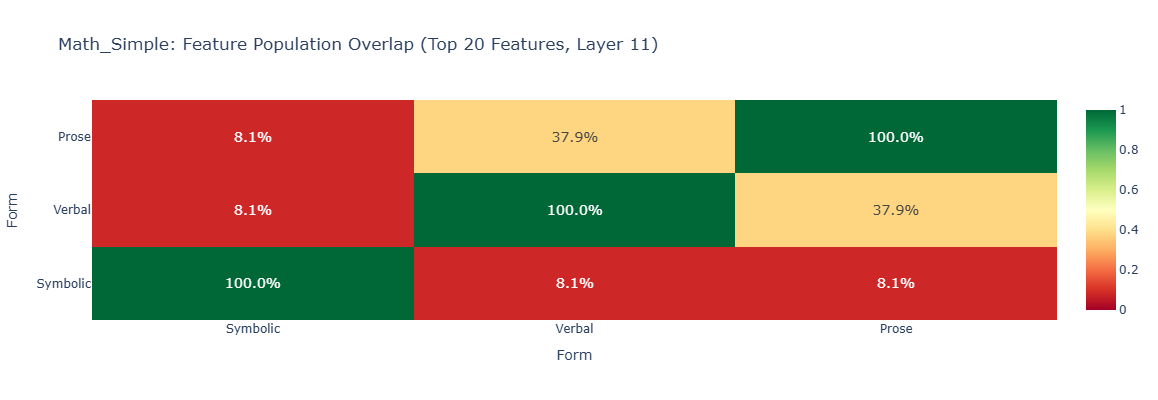

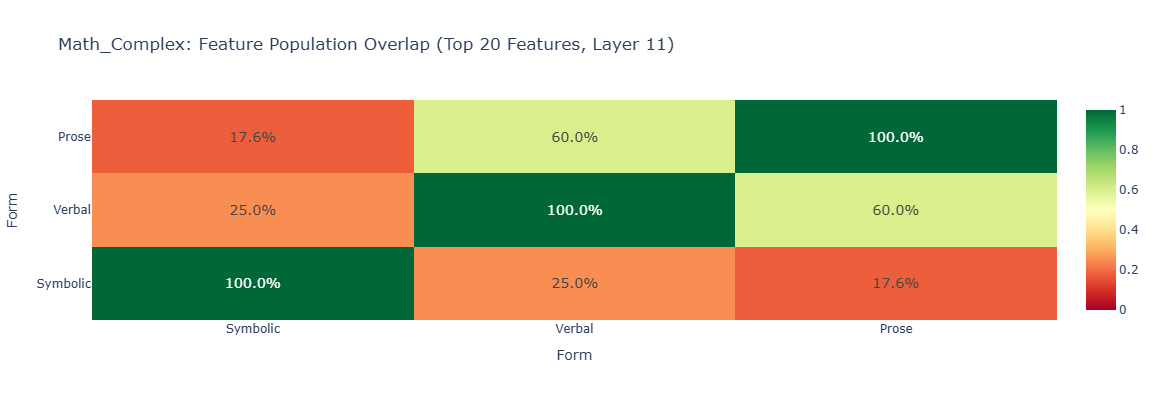

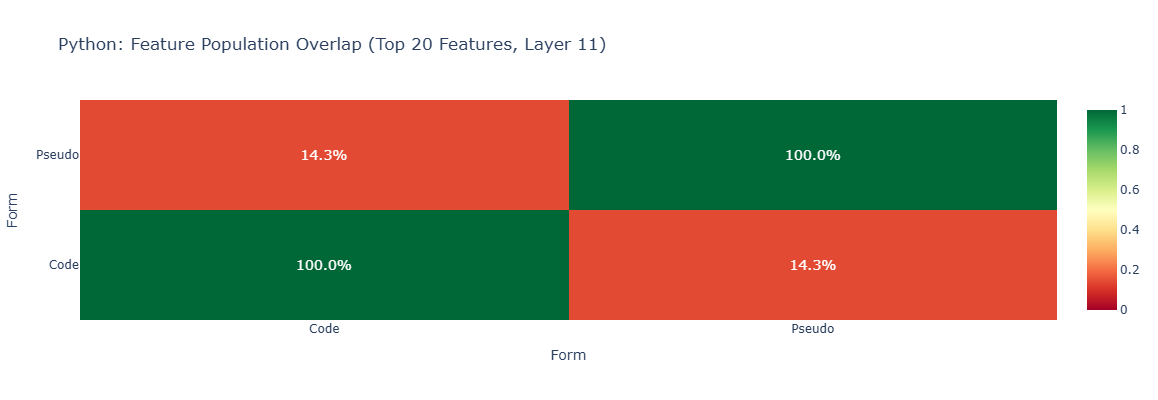

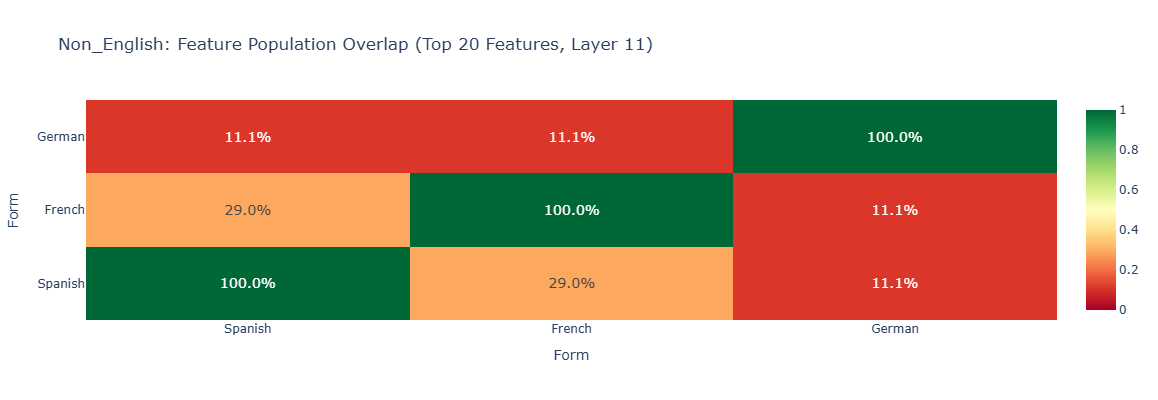

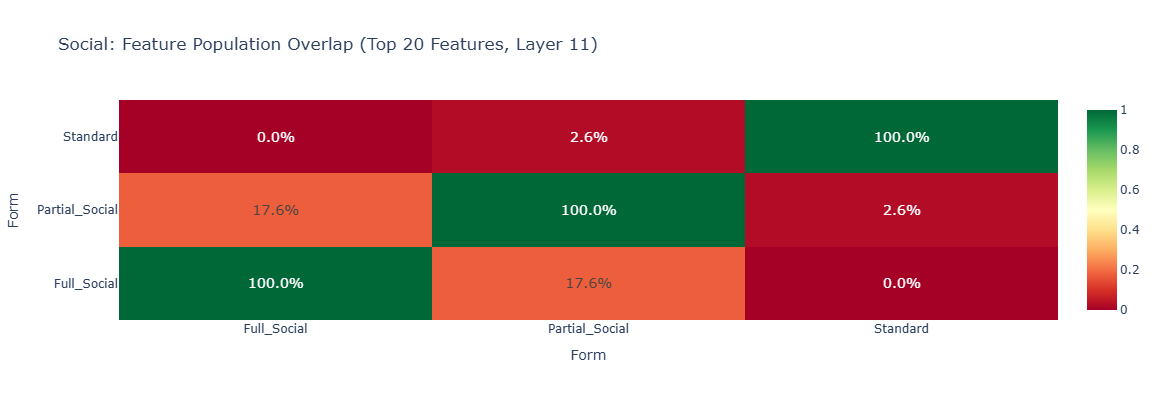

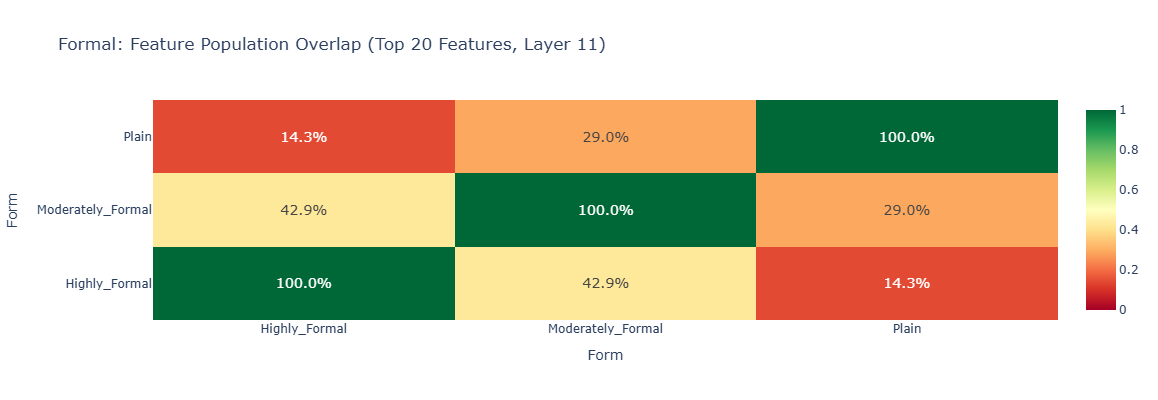

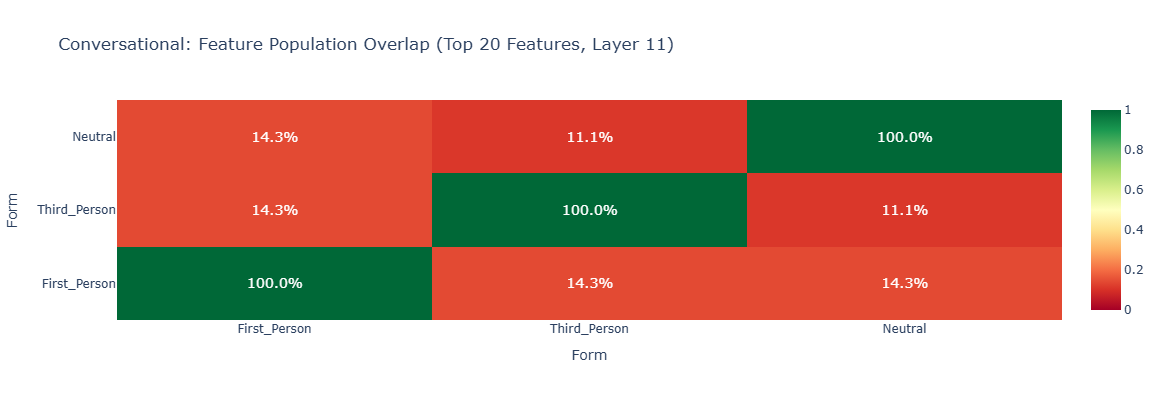


📋 ANALYSIS 2 SUMMARY

Math_Simple:
   Average pairwise overlap: 18.0%
   → LOW overlap: forms activate distinct features

Math_Complex:
   Average pairwise overlap: 34.2%
   → MODERATE overlap: forms share some features

Python:
   Average pairwise overlap: 14.3%
   → LOW overlap: forms activate distinct features

Non_English:
   Average pairwise overlap: 17.1%
   → LOW overlap: forms activate distinct features

Social:
   Average pairwise overlap: 6.7%
   → LOW overlap: forms activate distinct features

Formal:
   Average pairwise overlap: 28.7%
   → MODERATE overlap: forms share some features

Conversational:
   Average pairwise overlap: 13.2%
   → LOW overlap: forms activate distinct features



In [14]:
# ============================================================================
# CELL 14: Feature Population Overlap Across Forms (H2-Style Analysis)
# ============================================================================
print("\n" + "=" * 70)
print("🔬 ANALYSIS 2: FEATURE POPULATION OVERLAP ACROSS FORMS")
print("=" * 70)
print("""
For each topic, examine whether different forms activate the same or different
feature populations. High overlap → forms share representations.
Low overlap → each form activates distinct features.
""")

# -----------------------------------------------------------------------------
# Step 1: Extract top-N features for each topic+form
# -----------------------------------------------------------------------------
print("1️⃣ Extracting top features for each topic+form...\n")

top_n = 20
analysis_layer = '11-res-jb'

sae_obj = loaded_saes[analysis_layer]['sae']
hook_point = loaded_saes[analysis_layer]['config']['hook_point']

top_features_by_form = {}

for target_key, config in form_analysis_configs.items():
    # Extract features for this form's texts
    features = extract_features(config['target_texts'], sae_obj, hook_point)
    
    # Get mean activation per feature
    mean_activations = features.mean(dim=0).detach().numpy()
    
    # Get top-N feature indices
    top_indices = np.argsort(mean_activations)[-top_n:][::-1]
    
    top_features_by_form[target_key] = {
        'top_features': set(top_indices),
        'topic': config['topic'],
        'form': config['form']
    }
    
    print(f"   {target_key}: top {top_n} features extracted")

# -----------------------------------------------------------------------------
# Step 2: Compute pairwise overlap within each topic
# -----------------------------------------------------------------------------
print("\n2️⃣ Computing feature overlap within each topic...\n")

def compute_overlap(set1, set2):
    """Compute Jaccard similarity between two sets."""
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union > 0 else 0

overlap_results = {}

for topic in all_topics.keys():
    print(f"\n{topic}:")
    
    # Get all forms for this topic
    topic_forms = {k: v for k, v in top_features_by_form.items() if v['topic'] == topic}
    form_keys = list(topic_forms.keys())
    
    overlap_results[topic] = {}
    
    # Pairwise overlap
    for i, key1 in enumerate(form_keys):
        for key2 in form_keys[i+1:]:
            set1 = topic_forms[key1]['top_features']
            set2 = topic_forms[key2]['top_features']
            
            overlap = compute_overlap(set1, set2)
            pair_key = f"{topic_forms[key1]['form']} vs {topic_forms[key2]['form']}"
            overlap_results[topic][pair_key] = overlap
            
            print(f"   {pair_key}: {overlap:.1%} overlap")
    
    # Features common to ALL forms
    all_sets = [topic_forms[k]['top_features'] for k in form_keys]
    common_to_all = set.intersection(*all_sets)
    print(f"   Common to ALL forms: {len(common_to_all)}/{top_n} ({len(common_to_all)/top_n:.1%})")
    
    # Features unique to each form
    for key in form_keys:
        unique = topic_forms[key]['top_features'] - set.union(*[topic_forms[k]['top_features'] 
                                                                 for k in form_keys if k != key])
        print(f"   Unique to {topic_forms[key]['form']}: {len(unique)}/{top_n}")

# -----------------------------------------------------------------------------
# Step 3: Visualize overlap
# -----------------------------------------------------------------------------
print("\n3️⃣ Visualizing feature overlap...\n")

# Create overlap matrix for each topic
for topic in all_topics.keys():
    topic_forms = {k: v for k, v in top_features_by_form.items() if v['topic'] == topic}
    form_keys = list(topic_forms.keys())
    form_labels = [top_features_by_form[k]['form'] for k in form_keys]
    
    n_forms = len(form_keys)
    overlap_matrix = np.zeros((n_forms, n_forms))
    
    for i, key1 in enumerate(form_keys):
        for j, key2 in enumerate(form_keys):
            if i == j:
                overlap_matrix[i, j] = 1.0
            else:
                set1 = topic_forms[key1]['top_features']
                set2 = topic_forms[key2]['top_features']
                overlap_matrix[i, j] = compute_overlap(set1, set2)
    
    fig = go.Figure(data=go.Heatmap(
        z=overlap_matrix,
        x=form_labels,
        y=form_labels,
        colorscale='RdYlGn',
        zmin=0, zmax=1,
        text=[[f"{v:.1%}" for v in row] for row in overlap_matrix],
        texttemplate="%{text}",
        textfont={"size": 14},
    ))
    
    fig.update_layout(
        title=f'{topic}: Feature Population Overlap (Top {top_n} Features, Layer 11)',
        xaxis_title='Form',
        yaxis_title='Form',
        height=400,
        width=500
    )
    fig.show()

print("\n" + "=" * 70)
print("📋 ANALYSIS 2 SUMMARY")
print("=" * 70)

for topic, overlaps in overlap_results.items():
    avg_overlap = np.mean(list(overlaps.values())) if overlaps else 0
    print(f"\n{topic}:")
    print(f"   Average pairwise overlap: {avg_overlap:.1%}")
    if avg_overlap > 0.5:
        print(f"   → HIGH overlap: forms share most features")
    elif avg_overlap > 0.25:
        print(f"   → MODERATE overlap: forms share some features")
    else:
        print(f"   → LOW overlap: forms activate distinct features")

print("\n" + "=" * 70)


🔬 ANALYSIS 3: REPRESENTATIONAL GEOMETRY (COSINE SIMILARITY)

Compute cosine similarity between activation vectors for ALL topic+form
combinations. Do representations cluster by TOPIC or by FORM?

1️⃣ Computing mean activation vectors...

   Math_Simple_Symbolic: vector computed (dim=24576)
   Math_Simple_Verbal: vector computed (dim=24576)
   Math_Simple_Prose: vector computed (dim=24576)
   Math_Complex_Symbolic: vector computed (dim=24576)
   Math_Complex_Verbal: vector computed (dim=24576)
   Math_Complex_Prose: vector computed (dim=24576)
   Python_Code: vector computed (dim=24576)
   Python_Pseudo: vector computed (dim=24576)
   Non_English_Spanish: vector computed (dim=24576)
   Non_English_French: vector computed (dim=24576)
   Non_English_German: vector computed (dim=24576)
   Social_Full_Social: vector computed (dim=24576)
   Social_Partial_Social: vector computed (dim=24576)
   Social_Standard: vector computed (dim=24576)
   Formal_Highly_Formal: vector computed (dim=24576)


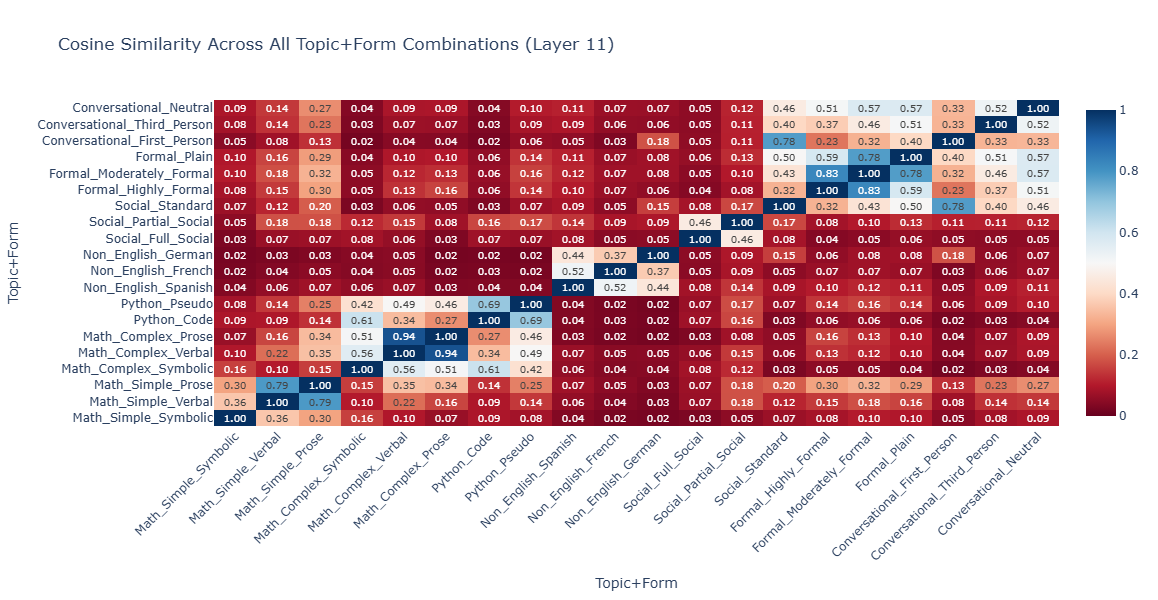


4️⃣ Analyzing clustering patterns...

   Within-topic similarity (same topic, different forms):
      Mean: 0.503
      Pairs: 19

   Cross-topic similarity (different topics):
      Mean: 0.137
      Pairs: 171

   Within-form similarity (same form, different topics):
      Mean: 0.239
      Pairs: 3

   Statistical comparison (within-topic vs cross-topic):
      t-statistic: 10.123
      p-value: 1.6810e-19

5️⃣ Creating scatter plot (PCA projection, topic+form averages)...

   PCA variance explained: 20.6%, 15.7%


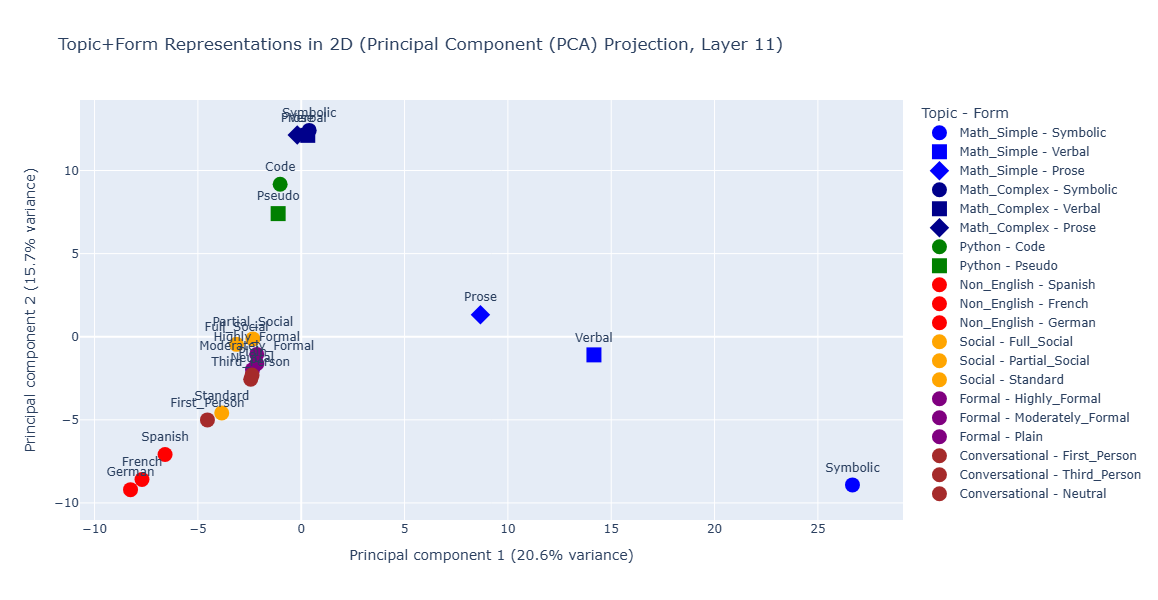


6️⃣ Creating scatter plot (PCA projection, individual texts)...

   Total individual texts: 688
   PCA variance explained: 7.0%, 5.8%


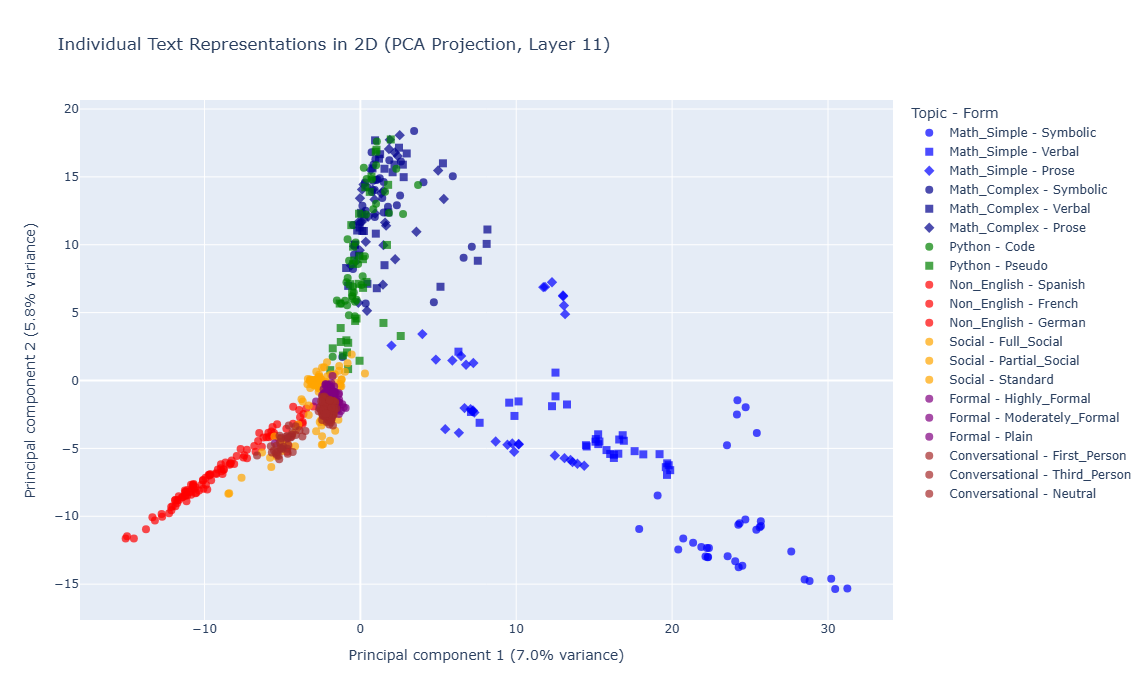


   Cluster tightness (standard deviation within each topic+form):
      Math_Simple_Symbolic: PC1 std=3.074, PC2 std=3.763
      Math_Simple_Verbal: PC1 std=3.722, PC2 std=2.077
      Math_Simple_Prose: PC1 std=3.335, PC2 std=4.563
      Math_Complex_Symbolic: PC1 std=1.981, PC2 std=3.526
      Math_Complex_Verbal: PC1 std=2.423, PC2 std=3.381
      Math_Complex_Prose: PC1 std=1.415, PC2 std=3.260
      Python_Code: PC1 std=1.193, PC2 std=4.050
      Python_Pseudo: PC1 std=1.063, PC2 std=5.000
      Non_English_Spanish: PC1 std=2.440, PC2 std=1.747
      Non_English_French: PC1 std=2.962, PC2 std=2.400
      Non_English_German: PC1 std=2.920, PC2 std=2.459
      Social_Full_Social: PC1 std=0.405, PC2 std=0.481
      Social_Partial_Social: PC1 std=0.830, PC2 std=0.758
      Social_Standard: PC1 std=1.939, PC2 std=1.604
      Formal_Highly_Formal: PC1 std=0.276, PC2 std=0.490
      Formal_Moderately_Formal: PC1 std=0.594, PC2 std=0.655
      Formal_Plain: PC1 std=0.642, PC2 std=0.652
  

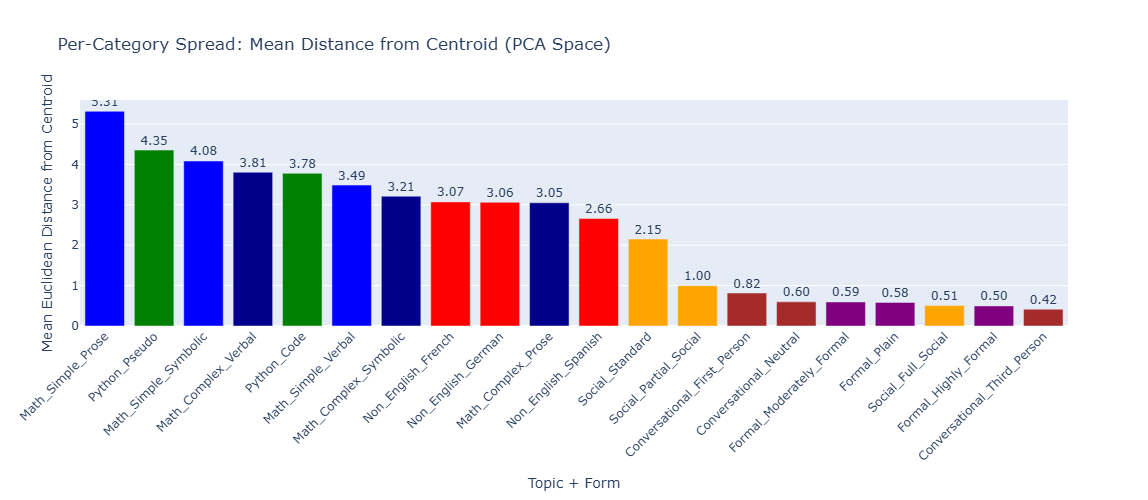

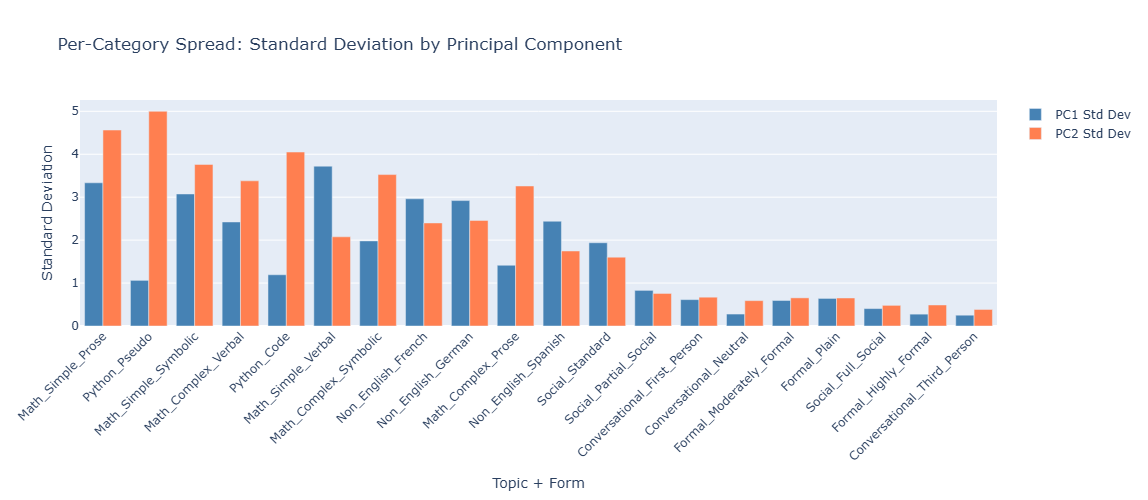


8️⃣ Analyzing per-text activation sparsity (L0 norm) across multiple thresholds...

8️⃣a Comparing L0 rankings across thresholds...

📊 Mean L0 by Category Across Thresholds:

                 Topic_Form  Mean_L0_t0.01  Mean_L0_t0.1  Mean_L0_t0.5  Mean_L0_t1.0  Mean_L0_t5.0
Conversational_First_Person          228.4         191.0         102.7          61.9           7.9
     Conversational_Neutral          240.9         201.2         108.3          62.6           7.9
Conversational_Third_Person          263.7         215.5         110.2          61.4           8.5
       Formal_Highly_Formal          440.9         331.7         133.4          64.9           3.5
   Formal_Moderately_Formal          318.6         256.7         119.5          63.0           6.1
               Formal_Plain          318.7         252.5         116.3          63.0           5.8
         Math_Complex_Prose          484.3         311.3         107.4          52.5           5.0
      Math_Complex_Symbolic     

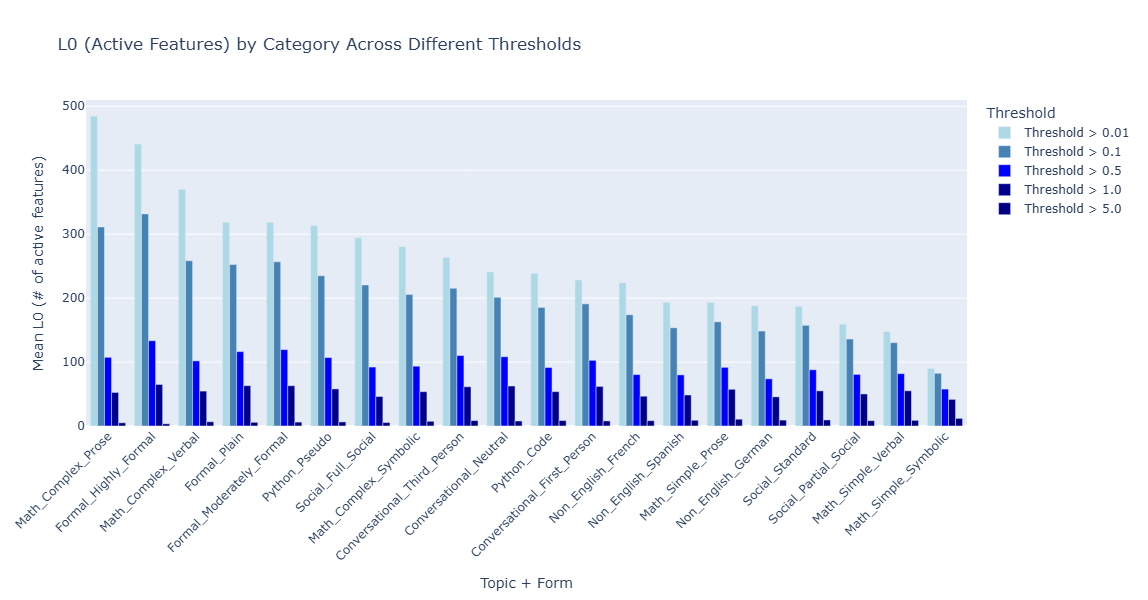


8️⃣b Checking if category rankings are stable across thresholds...

   Spearman rank correlations between thresholds:
      Threshold 0.01 vs 0.1: 0.986
      Threshold 0.01 vs 0.5: 0.818
      Threshold 0.01 vs 1.0: 0.459
      Threshold 0.01 vs 5.0: -0.889
      Threshold 0.1 vs 0.5: 0.866
      Threshold 0.1 vs 1.0: 0.532
      Threshold 0.1 vs 5.0: -0.877
      Threshold 0.5 vs 1.0: 0.838
      Threshold 0.5 vs 5.0: -0.749
      Threshold 1.0 vs 5.0: -0.402

8️⃣c Analyzing L1 norm (total activation, no threshold)...

📊 L1 Norm (Total Activation) by Category:

         Topic              Form                  Topic_Form  N_texts  Mean_L1  Std_L1  Mean_Max
        Formal     Highly_Formal        Formal_Highly_Formal       35    247.7    15.7       9.4
        Formal Moderately_Formal    Formal_Moderately_Formal       35    235.2    14.6      10.8
Conversational      First_Person Conversational_First_Person       35    235.2    15.8      13.9
Conversational      Third_Person Conversa

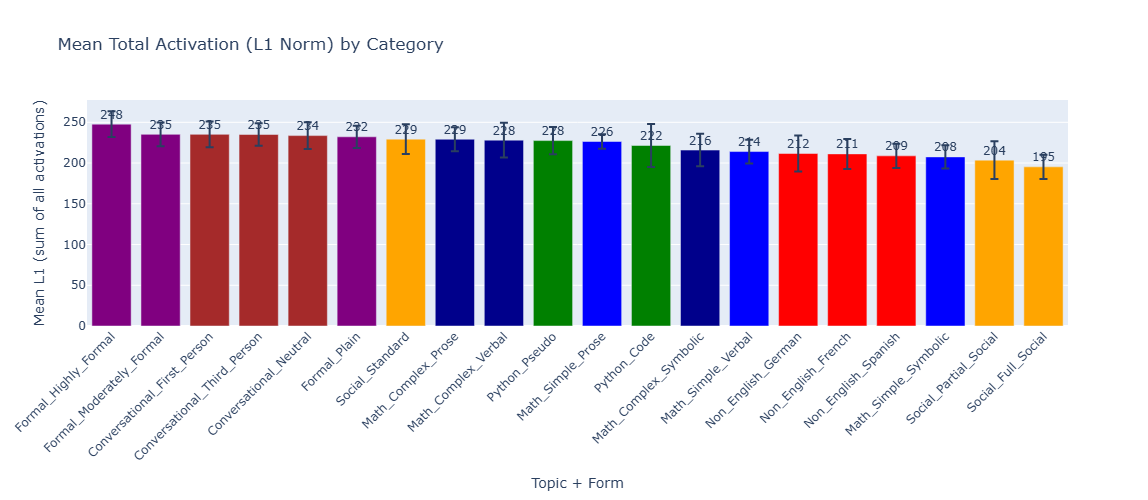


8️⃣d Comparing activation distribution shapes...



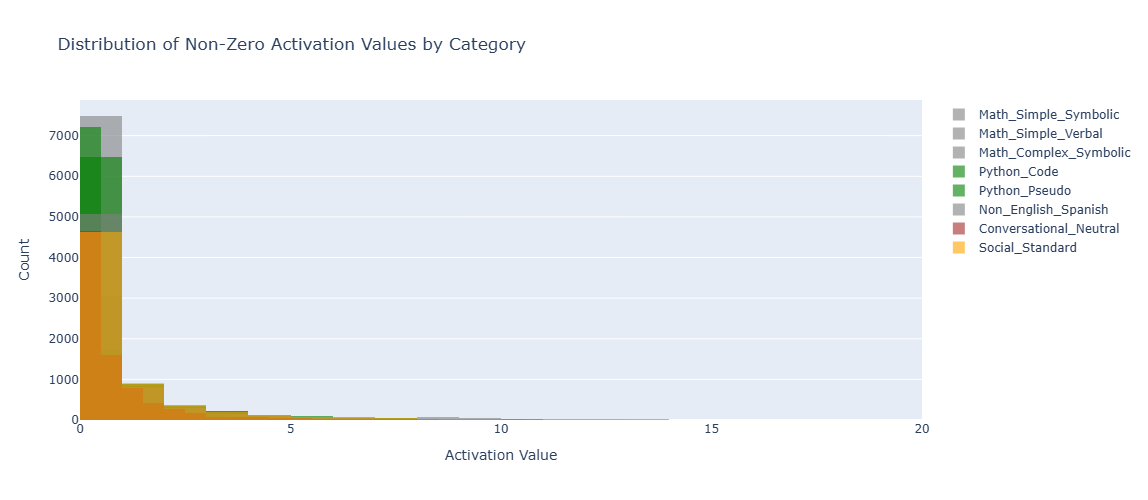

📊 Activation Distribution Shape by Representative Category:

   Category                  Non-zero Count  Mean       Median     Max       
   ----------------------------------------------------------------------
   Math_Simple_Symbolic      2976            2.30       0.87       31.56     
   Math_Simple_Verbal        4877            1.45       0.61       25.06     
   Math_Complex_Symbolic     9254            0.77       0.25       32.45     
   Python_Code               8365            0.93       0.32       25.35     
   Python_Pseudo             10967           0.73       0.28       22.91     
   Non_English_Spanish       6776            1.08       0.36       30.10     
   Conversational_Neutral    8433            0.97       0.42       22.27     
   Social_Standard           6559            1.22       0.45       49.65     

   📈 Context: SAE has 24,576 total features
   📈 Average L0 (threshold=0.1) across all texts: 200.6

8️⃣e Analyzing max activation (strongest single feature per t

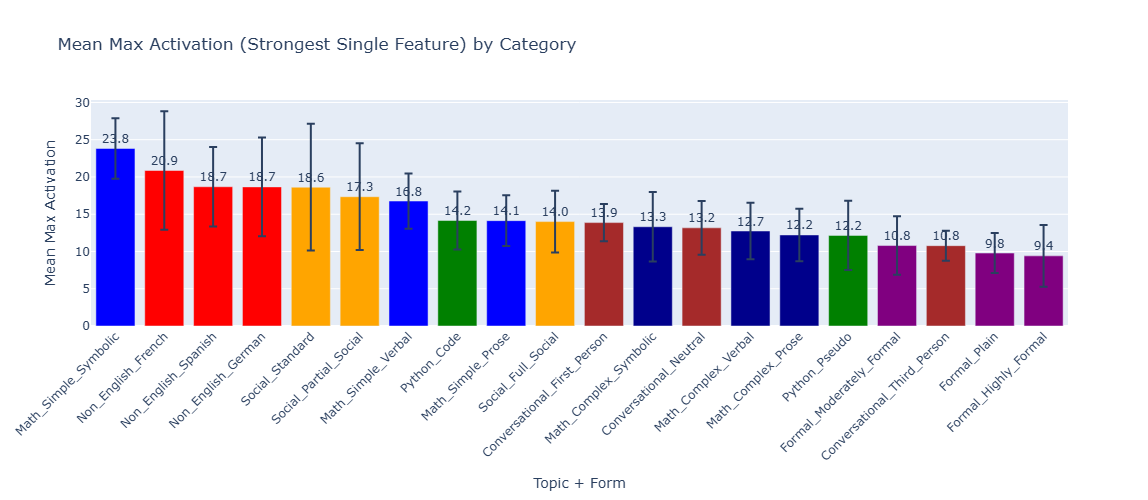


8️⃣f Comparing activation profiles (L0, L1, Max) across categories...

📊 Normalized Activation Profile (0-1 scale):

                 Topic_Form  L0_norm  L1_norm  Max_norm
       Formal_Highly_Formal     1.00     1.00      0.40
   Formal_Moderately_Formal     0.77     0.95      0.45
Conversational_First_Person     0.58     0.95      0.58
Conversational_Third_Person     0.65     0.95      0.45
     Conversational_Neutral     0.61     0.94      0.55
               Formal_Plain     0.76     0.94      0.41
            Social_Standard     0.47     0.93      0.78
         Math_Complex_Prose     0.94     0.93      0.51
        Math_Complex_Verbal     0.78     0.92      0.54
              Python_Pseudo     0.71     0.92      0.51
          Math_Simple_Prose     0.49     0.91      0.59
                Python_Code     0.56     0.89      0.59
      Math_Complex_Symbolic     0.62     0.87      0.56
         Math_Simple_Verbal     0.39     0.86      0.70
         Non_English_German     0.45     0

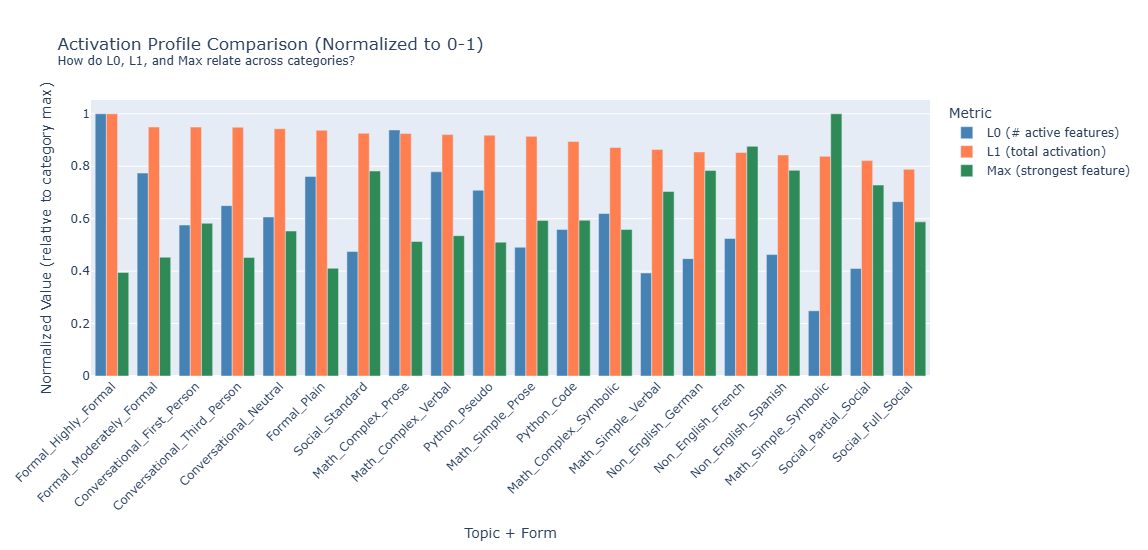


📊 Activation Shape Ratios:

   Topic_Form                          L1/L0 (avg per feature)   Max/L1 (concentration)   
   -------------------------------------------------------------------------------------
   Math_Simple_Symbolic                2.52                      0.115                    
   Math_Simple_Verbal                  1.64                      0.078                    
   Social_Partial_Social               1.50                      0.085                    
   Social_Standard                     1.46                      0.081                    
   Non_English_German                  1.43                      0.088                    
   Math_Simple_Prose                   1.39                      0.062                    
   Non_English_Spanish                 1.36                      0.089                    
   Conversational_First_Person         1.23                      0.059                    
   Non_English_French                  1.21                    

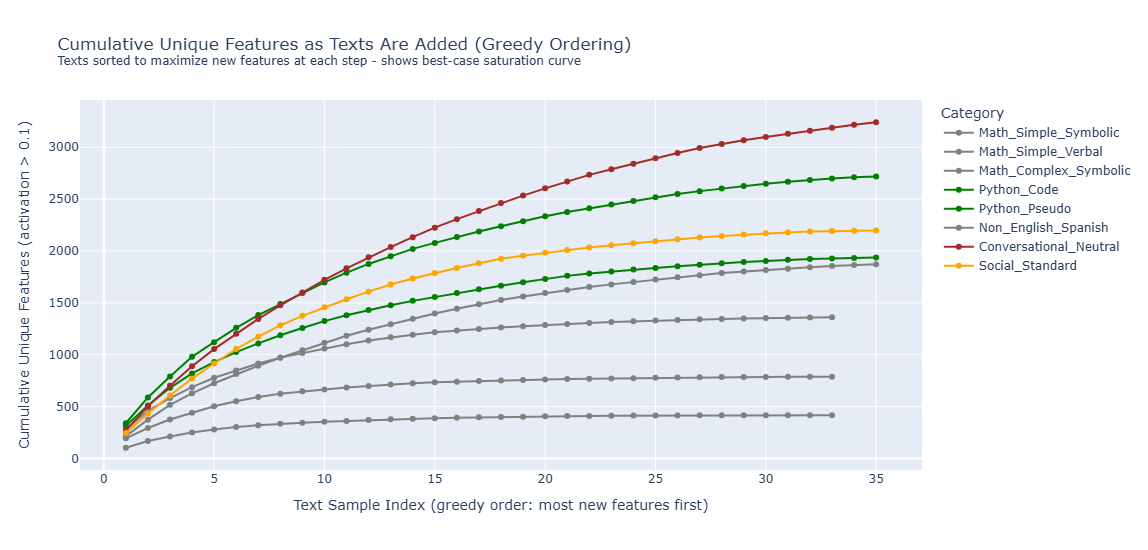

9️⃣b Plotting new features contributed by each text...



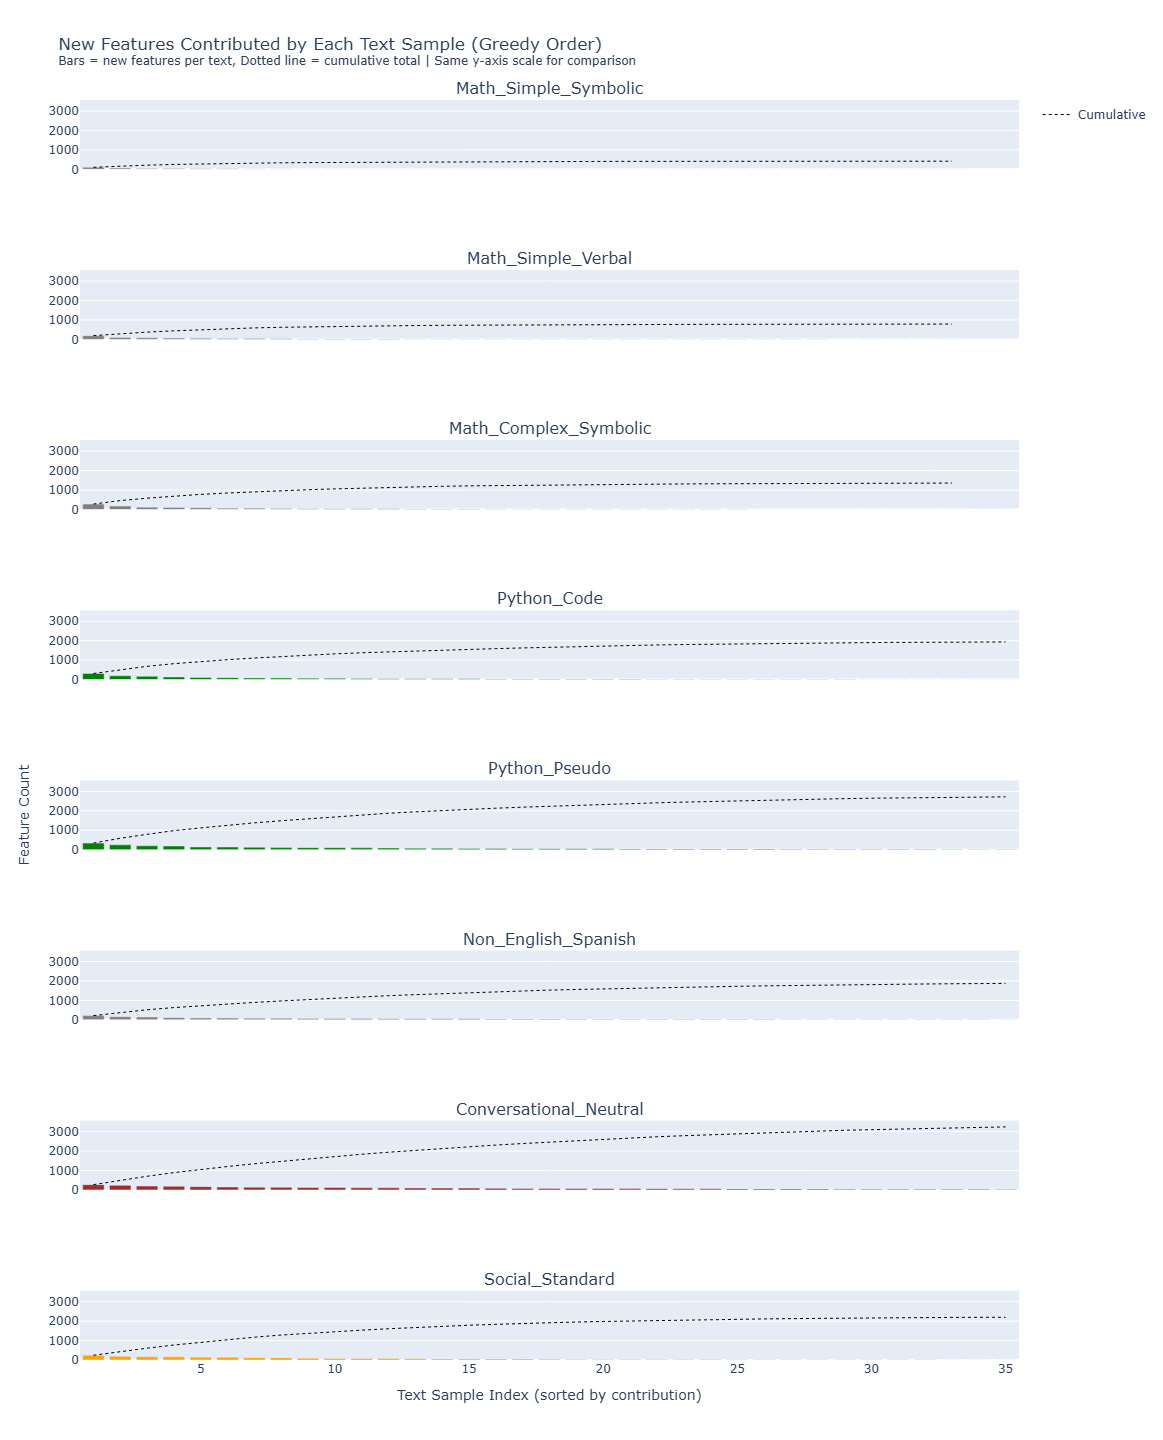

9️⃣b2 Visualizing first-time feature activations across texts...


For each topic+form, we highlight tokens that activate features being used
for the FIRST TIME in that category's sequence. Early texts should show
heavy highlighting (many new features), while later texts show sparse
highlighting (most features already seen).

   Displaying first-time feature activation patterns...

   📊 Math_Simple_Symbolic...


   📊 Math_Simple_Verbal...


   📊 Math_Complex_Symbolic...


   📊 Python_Code...


   📊 Python_Pseudo...


   📊 Non_English_Spanish...


   📊 Conversational_Neutral...


   📊 Social_Standard...



   ✅ First-time feature highlighting complete
   📊 Notice how Math categories show heavy initial highlighting that fades quickly
   📊 Notice how Conversational categories show more sustained highlighting across texts
9️⃣c Computing saturation metrics...

📊 Feature Accumulation Summary:

                 Topic_Form  Final_Unique_Features  First_Text_Pct  Halfway_Pct  Linearity_Score
   Formal_Moderately_Formal                   4337            7.15        74.52             0.40
               Formal_Plain                   4112            7.88        74.81             0.36
       Formal_Highly_Formal                   5020            8.27        74.48             0.35
     Conversational_Neutral                   3241            8.33        75.96             0.34
Conversational_Third_Person                   3198            8.82        74.61             0.32
Conversational_First_Person                   2739            9.02        74.70             0.32
      Social_Partial_Social     

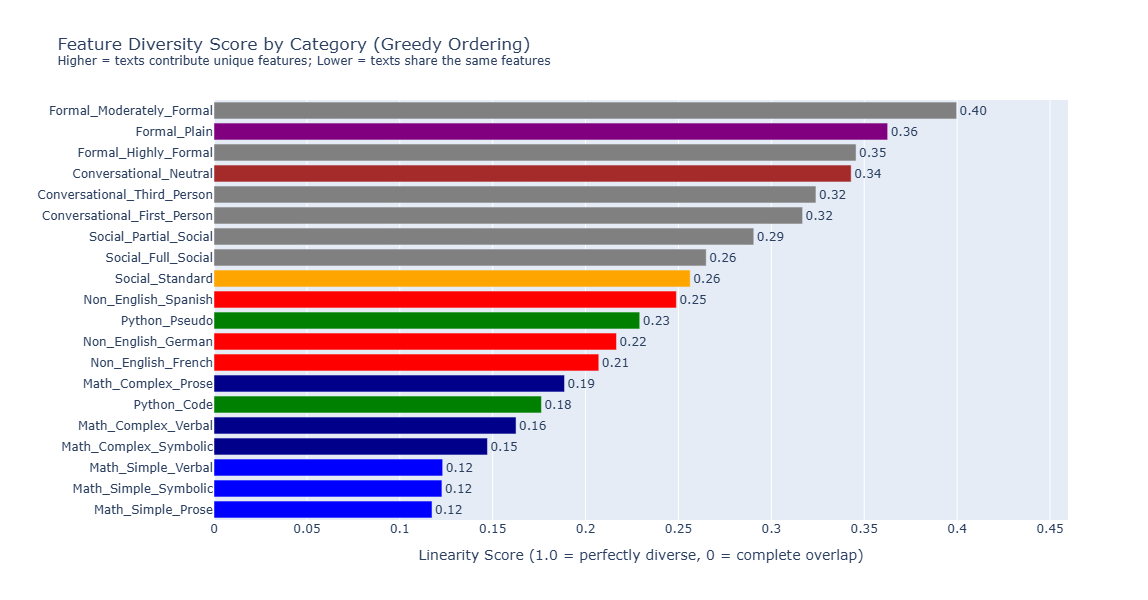

   📊 Key insight: Low linearity + high L0 (Math) = dense, overlapping feature usage
   📊 Key insight: High linearity + low L0 (Conversational) = sparse, diverse feature usage

🔟 Checking for token length confound...

   📈 Correlation between token count and L0: 0.780


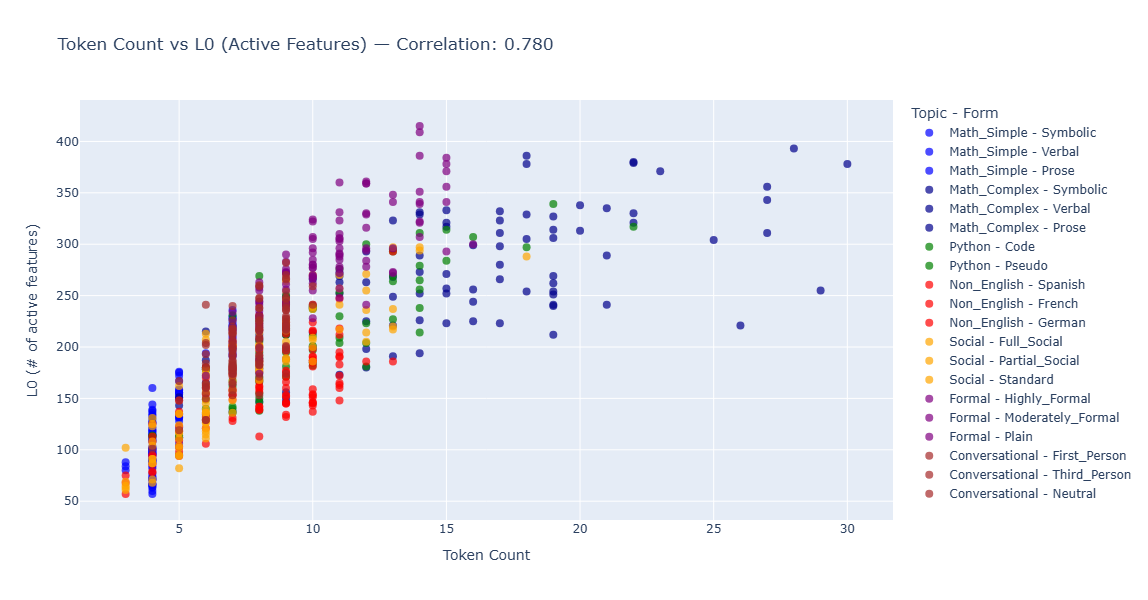


📊 Token Count and L0 by Category:

                 Topic_Form  Mean_Tokens  Mean_L0  L0_per_Token
       Formal_Highly_Formal        12.77   331.69         25.97
         Math_Complex_Prose        17.39   311.27         17.90
        Math_Complex_Verbal        13.52   258.30         19.11
   Formal_Moderately_Formal         9.23   256.66         27.81
               Formal_Plain         9.46   252.46         26.69
              Python_Pseudo        10.60   234.94         22.16
         Social_Full_Social        10.29   220.54         21.44
Conversational_Third_Person         7.77   215.51         27.73
      Math_Complex_Symbolic        13.91   205.52         14.78
     Conversational_Neutral         7.17   201.17         28.05
Conversational_First_Person         7.74   191.00         24.67
                Python_Code         9.40   185.43         19.73
         Non_English_French         8.14   173.89         21.35
          Math_Simple_Prose         5.64   162.85         28.89
    

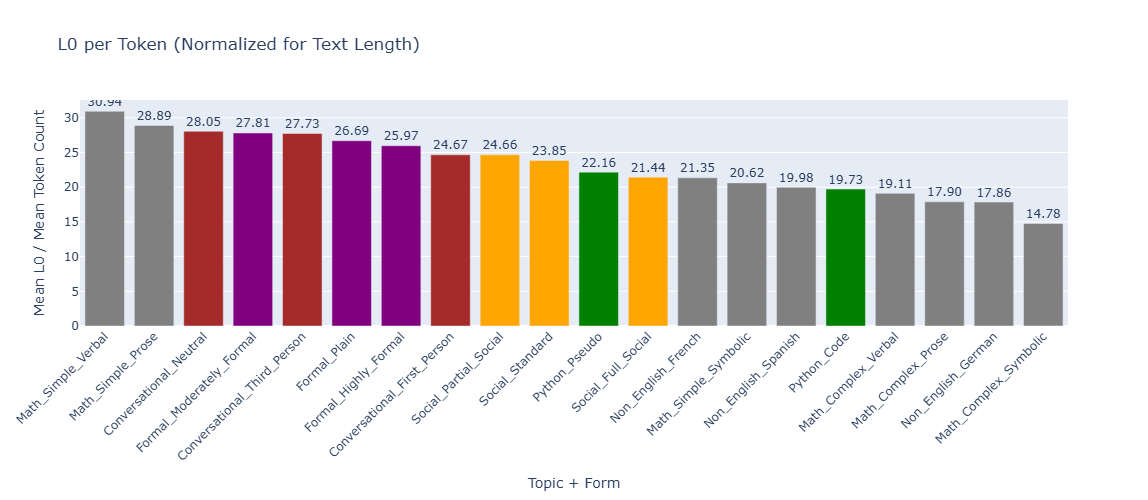


   📈 If L0 per Token is similar across categories, token length explains the L0 differences.
   📈 If L0 per Token still varies, there's something beyond text length driving the pattern.

📋 ANALYSIS 3 SUMMARY

   Within-topic similarity: 0.503
   Cross-topic similarity:  0.137
   Difference: 0.366

   → Representations cluster by TOPIC
   → Different forms of the same topic are more similar than different topics



In [15]:
# ============================================================================
# CELL 15: Representational Geometry - Cosine Similarity Analysis
# ============================================================================
print("\n" + "=" * 70)
print("🔬 ANALYSIS 3: REPRESENTATIONAL GEOMETRY (COSINE SIMILARITY)")
print("=" * 70)
print("""
Compute cosine similarity between activation vectors for ALL topic+form
combinations. Do representations cluster by TOPIC or by FORM?
""")

# -----------------------------------------------------------------------------
# Step 1: Compute mean activation vectors for each topic+form
# -----------------------------------------------------------------------------
print("1️⃣ Computing mean activation vectors...\n")

analysis_layer = '11-res-jb'
sae_obj = loaded_saes[analysis_layer]['sae']
hook_point = loaded_saes[analysis_layer]['config']['hook_point']

mean_vectors = {}

for target_key, config in form_analysis_configs.items():
    features = extract_features(config['target_texts'], sae_obj, hook_point)
    mean_vec = features.mean(dim=0).detach().numpy()
    
    mean_vectors[target_key] = {
        'vector': mean_vec,
        'topic': config['topic'],
        'form': config['form']
    }
    
    print(f"   {target_key}: vector computed (dim={len(mean_vec)})")

# -----------------------------------------------------------------------------
# Step 2: Compute pairwise cosine similarity
# -----------------------------------------------------------------------------
print("\n2️⃣ Computing pairwise cosine similarities...\n")

from scipy.spatial.distance import cosine

keys = list(mean_vectors.keys())
n = len(keys)

similarity_matrix = np.zeros((n, n))

for i, key1 in enumerate(keys):
    for j, key2 in enumerate(keys):
        vec1 = mean_vectors[key1]['vector']
        vec2 = mean_vectors[key2]['vector']
        
        # Cosine similarity = 1 - cosine distance
        similarity_matrix[i, j] = 1 - cosine(vec1, vec2)

print(f"   Computed {n}x{n} similarity matrix")

# -----------------------------------------------------------------------------
# Step 3: Display similarity matrix
# -----------------------------------------------------------------------------
print("\n3️⃣ Displaying similarity matrix...\n")

# Create labels with topic and form info
labels = [f"{mean_vectors[k]['topic']}_{mean_vectors[k]['form']}" for k in keys]

fig = go.Figure(data=go.Heatmap(
    z=similarity_matrix,
    x=labels,
    y=labels,
    colorscale='RdBu',
    zmid=0.5,
    text=[[f"{v:.2f}" for v in row] for row in similarity_matrix],
    texttemplate="%{text}",
    textfont={"size": 10},
))

fig.update_layout(
    title=f'Cosine Similarity Across All Topic+Form Combinations (Layer 11)',
    xaxis_title='Topic+Form',
    yaxis_title='Topic+Form',
    height=600,
    width=800,
    xaxis_tickangle=-45
)
fig.show()

# -----------------------------------------------------------------------------
# Step 4: Analyze clustering - by topic or by form?
# -----------------------------------------------------------------------------
print("\n4️⃣ Analyzing clustering patterns...\n")

# Within-topic similarity (same topic, different forms)
within_topic_sims = []
for i, key1 in enumerate(keys):
    for j, key2 in enumerate(keys):
        if i < j and mean_vectors[key1]['topic'] == mean_vectors[key2]['topic']:
            within_topic_sims.append(similarity_matrix[i, j])

# Cross-topic similarity (different topics)
cross_topic_sims = []
for i, key1 in enumerate(keys):
    for j, key2 in enumerate(keys):
        if i < j and mean_vectors[key1]['topic'] != mean_vectors[key2]['topic']:
            cross_topic_sims.append(similarity_matrix[i, j])

# Within-form similarity (same form type across topics)
# Map forms to canonical types
form_mapping = {
    'Symbolic': 'symbolic', 'Verbal': 'verbal', 'Prose': 'prose',
    'Code': 'code', 'Pseudo': 'pseudo'
}

within_form_sims = []
for i, key1 in enumerate(keys):
    for j, key2 in enumerate(keys):
        if i < j:
            form1 = mean_vectors[key1]['form']
            form2 = mean_vectors[key2]['form']
            # Check if forms are "similar" (both symbolic-like or both verbal-like)
            if form1 == form2:
                within_form_sims.append(similarity_matrix[i, j])

print(f"   Within-topic similarity (same topic, different forms):")
print(f"      Mean: {np.mean(within_topic_sims):.3f}")
print(f"      Pairs: {len(within_topic_sims)}")

print(f"\n   Cross-topic similarity (different topics):")
print(f"      Mean: {np.mean(cross_topic_sims):.3f}")
print(f"      Pairs: {len(cross_topic_sims)}")

if within_form_sims:
    print(f"\n   Within-form similarity (same form, different topics):")
    print(f"      Mean: {np.mean(within_form_sims):.3f}")
    print(f"      Pairs: {len(within_form_sims)}")

# Statistical test
from scipy import stats

if len(within_topic_sims) > 1 and len(cross_topic_sims) > 1:
    t_stat, p_value = stats.ttest_ind(within_topic_sims, cross_topic_sims)
    print(f"\n   Statistical comparison (within-topic vs cross-topic):")
    print(f"      t-statistic: {t_stat:.3f}")
    print(f"      p-value: {p_value:.4e}")

# -----------------------------------------------------------------------------
# Step 5: Scatter plot via dimensionality reduction (Topic+Form Averages)
# -----------------------------------------------------------------------------
print("\n5️⃣ Creating scatter plot (PCA projection, topic+form averages)...\n")

from sklearn.decomposition import PCA

# Stack all vectors
vector_matrix = np.array([mean_vectors[k]['vector'] for k in keys])

# PCA to 2D
pca = PCA(n_components=2)
coords_2d = pca.fit_transform(vector_matrix)

print(f"   PCA variance explained: {pca.explained_variance_ratio_[0]:.1%}, {pca.explained_variance_ratio_[1]:.1%}")

# Create scatter plot
topics = [mean_vectors[k]['topic'] for k in keys]
forms = [mean_vectors[k]['form'] for k in keys]

# Color by topic, shape by form
topic_colors = {
    'Math_Simple': 'blue', 
    'Math_Complex': 'darkblue', 
    'Python': 'green',
    'Non_English': 'red',
    'Social': 'orange',
    'Formal': 'purple',
    'Conversational': 'brown'
}
form_symbols = {'Symbolic': 'circle', 'Verbal': 'square', 'Prose': 'diamond', 
                'Code': 'circle', 'Pseudo': 'square'}

fig = go.Figure()

for topic in all_topics.keys():
    for form in all_topics[topic].keys():
        key = f"{topic}_{form}"
        if key in keys:
            idx = keys.index(key)
            fig.add_trace(go.Scatter(
                x=[coords_2d[idx, 0]],
                y=[coords_2d[idx, 1]],
                mode='markers+text',
                marker=dict(
                    size=15,
                    color=topic_colors.get(topic, 'gray'),
                    symbol=form_symbols.get(form, 'circle')
                ),
                text=[f"{form}"],
                textposition='top center',
                name=f"{topic} - {form}",
                showlegend=True
            ))

fig.update_layout(
    title='Topic+Form Representations in 2D (Principal Component (PCA) Projection, Layer 11)',
    xaxis_title=f'Principal component 1 ({pca.explained_variance_ratio_[0]:.1%} variance)',
    yaxis_title=f'Principal component 2 ({pca.explained_variance_ratio_[1]:.1%} variance)',
    height=600,
    width=800,
    legend_title='Topic - Form'
)
fig.show()

# -----------------------------------------------------------------------------
# Step 6: Scatter plot of INDIVIDUAL texts (not averaged)
# -----------------------------------------------------------------------------
print("\n6️⃣ Creating scatter plot (PCA projection, individual texts)...\n")

# Collect all individual text vectors with their metadata
individual_vectors = []
individual_metadata = []

for target_key, config in form_analysis_configs.items():
    features = extract_features(config['target_texts'], sae_obj, hook_point)
    
    for i, text in enumerate(config['target_texts']):
        individual_vectors.append(features[i].detach().numpy())
        individual_metadata.append({
            'topic': config['topic'],
            'form': config['form'],
            'text': text[:50] + '...' if len(text) > 50 else text  # Truncate for hover
        })

print(f"   Total individual texts: {len(individual_vectors)}")

# Stack into matrix and run PCA
individual_matrix = np.array(individual_vectors)
pca_individual = PCA(n_components=2)
coords_individual = pca_individual.fit_transform(individual_matrix)

print(f"   PCA variance explained: {pca_individual.explained_variance_ratio_[0]:.1%}, {pca_individual.explained_variance_ratio_[1]:.1%}")

# Create scatter plot with individual points
fig_individual = go.Figure()

# Group by topic+form for legend organization
for topic in all_topics.keys():
    for form in all_topics[topic].keys():
        # Find all points matching this topic+form
        indices = [i for i, meta in enumerate(individual_metadata) 
                   if meta['topic'] == topic and meta['form'] == form]
        
        if indices:
            fig_individual.add_trace(go.Scatter(
                x=coords_individual[indices, 0],
                y=coords_individual[indices, 1],
                mode='markers',
                marker=dict(
                    size=8,
                    color=topic_colors.get(topic, 'gray'),
                    symbol=form_symbols.get(form, 'circle'),
                    opacity=0.7
                ),
                text=[individual_metadata[i]['text'] for i in indices],
                hovertemplate='%{text}<extra></extra>',
                name=f"{topic} - {form}",
                showlegend=True
            ))

fig_individual.update_layout(
    title='Individual Text Representations in 2D (PCA Projection, Layer 11)',
    xaxis_title=f'Principal component 1 ({pca_individual.explained_variance_ratio_[0]:.1%} variance)',
    yaxis_title=f'Principal component 2 ({pca_individual.explained_variance_ratio_[1]:.1%} variance)',
    height=700,
    width=900,
    legend_title='Topic - Form'
)
fig_individual.show()

# Compute cluster tightness (standard deviation within each topic+form)
print("\n   Cluster tightness (standard deviation within each topic+form):")
for topic in all_topics.keys():
    for form in all_topics[topic].keys():
        indices = [i for i, meta in enumerate(individual_metadata) 
                   if meta['topic'] == topic and meta['form'] == form]
        if len(indices) > 1:
            cluster_coords = coords_individual[indices]
            std_pc1 = np.std(cluster_coords[:, 0])
            std_pc2 = np.std(cluster_coords[:, 1])
            print(f"      {topic}_{form}: PC1 std={std_pc1:.3f}, PC2 std={std_pc2:.3f}")


# -----------------------------------------------------------------------------
# Step 7: Quantify per-category variance in the individual text scatter from step 6 above
# -----------------------------------------------------------------------------
print("\n6️⃣b Quantifying per-category variance...\n")

from scipy.spatial.distance import cdist

variance_data = []

for topic in all_topics.keys():
    for form in all_topics[topic].keys():
        # Find all points matching this topic+form
        indices = [i for i, meta in enumerate(individual_metadata) 
                   if meta['topic'] == topic and meta['form'] == form]
        
        if len(indices) > 1:
            cluster_coords = coords_individual[indices]
            
            # Compute centroid
            centroid = cluster_coords.mean(axis=0)
            
            # Mean Euclidean distance from centroid
            distances = np.sqrt(np.sum((cluster_coords - centroid) ** 2, axis=1))
            mean_dist = np.mean(distances)
            
            # Separate standard deviations
            std_pc1 = np.std(cluster_coords[:, 0])
            std_pc2 = np.std(cluster_coords[:, 1])
            
            variance_data.append({
                'Topic': topic,
                'Form': form,
                'Topic_Form': f"{topic}_{form}",
                'N_texts': len(indices),
                'Mean_Dist_From_Centroid': mean_dist,
                'Std_PC1': std_pc1,
                'Std_PC2': std_pc2
            })

# Create DataFrame
import pandas as pd
variance_df = pd.DataFrame(variance_data)
variance_df = variance_df.sort_values('Mean_Dist_From_Centroid', ascending=False)

# Display table
print("📊 Per-Category Variance in PCA Space:\n")
print(variance_df.to_string(index=False, float_format=lambda x: f"{x:.3f}"))

# Create bar chart
fig_variance = go.Figure()

fig_variance.add_trace(go.Bar(
    x=variance_df['Topic_Form'],
    y=variance_df['Mean_Dist_From_Centroid'],
    marker_color=[topic_colors.get(row['Topic'], 'gray') for _, row in variance_df.iterrows()],
    text=[f"{v:.2f}" for v in variance_df['Mean_Dist_From_Centroid']],
    textposition='outside'
))

fig_variance.update_layout(
    title='Per-Category Spread: Mean Distance from Centroid (PCA Space)',
    xaxis_title='Topic + Form',
    yaxis_title='Mean Euclidean Distance from Centroid',
    height=500,
    width=900,
    xaxis_tickangle=-45
)
fig_variance.show()

# Also show directional breakdown
fig_directional = go.Figure()

fig_directional.add_trace(go.Bar(
    name='PC1 Std Dev',
    x=variance_df['Topic_Form'],
    y=variance_df['Std_PC1'],
    marker_color='steelblue'
))

fig_directional.add_trace(go.Bar(
    name='PC2 Std Dev',
    x=variance_df['Topic_Form'],
    y=variance_df['Std_PC2'],
    marker_color='coral'
))

fig_directional.update_layout(
    title='Per-Category Spread: Standard Deviation by Principal Component',
    xaxis_title='Topic + Form',
    yaxis_title='Standard Deviation',
    barmode='group',
    height=500,
    width=900,
    xaxis_tickangle=-45
)
fig_directional.show()



# -----------------------------------------------------------------------------
# Step 8: Per-Text Activation Sparsity (L0 Norm) - Multi-Threshold Analysis
# -----------------------------------------------------------------------------
print("\n8️⃣ Analyzing per-text activation sparsity (L0 norm) across multiple thresholds...\n")

# Test multiple thresholds to see if our findings are threshold-dependent
THRESHOLDS = [0.01, 0.1, 0.5, 1.0, 5.0]

# Collect activation data for all texts
activation_data = []

for target_key, config in form_analysis_configs.items():
    features = extract_features(config['target_texts'], sae_obj, hook_point)
    
    for i, text in enumerate(config['target_texts']):
        activation_vec = features[i].detach().numpy()
        
        row = {
            'Topic': config['topic'],
            'Form': config['form'],
            'Topic_Form': target_key,
            'Text': text[:40] + '...' if len(text) > 40 else text,
            'L1': np.sum(activation_vec),  # Total activation (sum of all values)
            'Max_Activation': np.max(activation_vec),
        }
        
        # Compute L0 at each threshold
        for thresh in THRESHOLDS:
            row[f'L0_t{thresh}'] = np.sum(activation_vec > thresh)
        
        activation_data.append(row)

activation_df = pd.DataFrame(activation_data)

# -----------------------------------------------------------------------------
# Step 8a: L0 across thresholds - does ranking change?
# -----------------------------------------------------------------------------
print("8️⃣a Comparing L0 rankings across thresholds...\n")

# Aggregate by topic+form for each threshold
l0_multi_thresh = activation_df.groupby(['Topic_Form']).agg(
    **{f'Mean_L0_t{t}': (f'L0_t{t}', 'mean') for t in THRESHOLDS}
).reset_index()

print("📊 Mean L0 by Category Across Thresholds:\n")
print(l0_multi_thresh.to_string(index=False, float_format=lambda x: f"{x:.1f}"))

# Create multi-threshold bar chart
fig_multi_thresh = go.Figure()

colors_thresh = ['lightblue', 'steelblue', 'blue', 'darkblue', 'navy']

for i, thresh in enumerate(THRESHOLDS):
    col = f'Mean_L0_t{thresh}'
    # Sort by this threshold's values for consistent comparison
    sorted_df = l0_multi_thresh.sort_values(col, ascending=False)
    
    fig_multi_thresh.add_trace(go.Bar(
        name=f'Threshold > {thresh}',
        x=sorted_df['Topic_Form'],
        y=sorted_df[col],
        marker_color=colors_thresh[i]
    ))

fig_multi_thresh.update_layout(
    title='L0 (Active Features) by Category Across Different Thresholds',
    xaxis_title='Topic + Form',
    yaxis_title='Mean L0 (# of active features)',
    barmode='group',
    height=600,
    width=1000,
    xaxis_tickangle=-45,
    legend_title='Threshold'
)
fig_multi_thresh.show()

# -----------------------------------------------------------------------------
# Step 8b: Rank correlation across thresholds
# -----------------------------------------------------------------------------
print("\n8️⃣b Checking if category rankings are stable across thresholds...\n")

from scipy.stats import spearmanr

print("   Spearman rank correlations between thresholds:")
for i, t1 in enumerate(THRESHOLDS):
    for t2 in THRESHOLDS[i+1:]:
        col1 = f'Mean_L0_t{t1}'
        col2 = f'Mean_L0_t{t2}'
        corr, _ = spearmanr(l0_multi_thresh[col1], l0_multi_thresh[col2])
        print(f"      Threshold {t1} vs {t2}: {corr:.3f}")

# -----------------------------------------------------------------------------
# Step 8c: L1 Norm (Total Activation) - threshold-free measure
# -----------------------------------------------------------------------------
print("\n8️⃣c Analyzing L1 norm (total activation, no threshold)...\n")

l1_summary = activation_df.groupby(['Topic', 'Form', 'Topic_Form']).agg(
    N_texts=('L1', 'count'),
    Mean_L1=('L1', 'mean'),
    Std_L1=('L1', 'std'),
    Mean_Max=('Max_Activation', 'mean')
).reset_index()

l1_summary = l1_summary.sort_values('Mean_L1', ascending=False)

print("📊 L1 Norm (Total Activation) by Category:\n")
print(l1_summary.to_string(index=False, float_format=lambda x: f"{x:.1f}"))

# Bar chart for L1
fig_l1 = go.Figure()

fig_l1.add_trace(go.Bar(
    x=l1_summary['Topic_Form'],
    y=l1_summary['Mean_L1'],
    marker_color=[topic_colors.get(row['Topic'], 'gray') for _, row in l1_summary.iterrows()],
    error_y=dict(
        type='data',
        array=l1_summary['Std_L1'],
        visible=True
    ),
    text=[f"{v:.0f}" for v in l1_summary['Mean_L1']],
    textposition='outside'
))

fig_l1.update_layout(
    title='Mean Total Activation (L1 Norm) by Category',
    xaxis_title='Topic + Form',
    yaxis_title='Mean L1 (sum of all activations)',
    height=500,
    width=900,
    xaxis_tickangle=-45
)
fig_l1.show()

# -----------------------------------------------------------------------------
# Step 8d: Activation Distribution Shape
# -----------------------------------------------------------------------------
print("\n8️⃣d Comparing activation distribution shapes...\n")

# Select representative categories to compare
representative_categories = [
    'Math_Simple_Symbolic',
    'Math_Simple_Verbal',
    'Math_Complex_Symbolic',
    'Python_Code',
    'Python_Pseudo',
    'Non_English_Spanish',
    'Conversational_Neutral',
    'Social_Standard'
]

fig_hist = go.Figure()

for cat in representative_categories:
    # Get all activations for this category (flattened across all texts)
    cat_mask = activation_df['Topic_Form'] == cat
    cat_texts = activation_df[cat_mask]
    
    # Re-extract features to get full activation vectors
    config = form_analysis_configs[cat]
    features = extract_features(config['target_texts'], sae_obj, hook_point)
    
    # Flatten all activations and filter to non-zero only
    all_activations = features.detach().numpy().flatten()
    nonzero_activations = all_activations[all_activations > 0.01]
    
    topic = cat.split('_')[0]
    
    fig_hist.add_trace(go.Histogram(
        x=nonzero_activations,
        name=cat,
        opacity=0.6,
        nbinsx=50,
        marker_color=topic_colors.get(topic, 'gray')
    ))

fig_hist.update_layout(
    title='Distribution of Non-Zero Activation Values by Category',
    xaxis_title='Activation Value',
    yaxis_title='Count',
    barmode='overlay',
    height=500,
    width=900,
    xaxis_range=[0, 20]  # Focus on typical range
)
fig_hist.show()

# Summary statistics on distribution shape
print("📊 Activation Distribution Shape by Representative Category:\n")
print(f"   {'Category':<25} {'Non-zero Count':<15} {'Mean':<10} {'Median':<10} {'Max':<10}")
print(f"   {'-'*70}")

for cat in representative_categories:
    config = form_analysis_configs[cat]
    features = extract_features(config['target_texts'], sae_obj, hook_point)
    all_activations = features.detach().numpy().flatten()
    nonzero = all_activations[all_activations > 0.01]
    
    print(f"   {cat:<25} {len(nonzero):<15} {np.mean(nonzero):<10.2f} {np.median(nonzero):<10.2f} {np.max(nonzero):<10.2f}")

# Use threshold of 0.1 for remaining analyses (Steps 9+)
L0_THRESHOLD = 0.1
l0_df = activation_df[['Topic', 'Form', 'Topic_Form', 'Text', 'L0_t0.1']].copy()
l0_df = l0_df.rename(columns={'L0_t0.1': 'L0'})

# Aggregate for later use
l0_summary = l0_df.groupby(['Topic', 'Form', 'Topic_Form']).agg(
    N_texts=('L0', 'count'),
    Mean_L0=('L0', 'mean'),
    Std_L0=('L0', 'std'),
    Min_L0=('L0', 'min'),
    Max_L0=('L0', 'max')
).reset_index()
l0_summary = l0_summary.sort_values('Mean_L0', ascending=False)

# Context
total_features = 24576
print(f"\n   📈 Context: SAE has {total_features:,} total features")
print(f"   📈 Average L0 (threshold=0.1) across all texts: {l0_df['L0'].mean():.1f}")

# -----------------------------------------------------------------------------
# Step 8e: Max Activation Analysis
# -----------------------------------------------------------------------------
print("\n8️⃣e Analyzing max activation (strongest single feature per text)...\n")

# Create summary sorted by Mean_Max
max_summary = activation_df.groupby(['Topic', 'Form', 'Topic_Form']).agg(
    N_texts=('Max_Activation', 'count'),
    Mean_Max=('Max_Activation', 'mean'),
    Std_Max=('Max_Activation', 'std'),
    Min_Max=('Max_Activation', 'min'),
    Max_Max=('Max_Activation', 'max')
).reset_index()

max_summary = max_summary.sort_values('Mean_Max', ascending=False)

print("📊 Max Activation (Strongest Feature) by Category:\n")
print(max_summary.to_string(index=False, float_format=lambda x: f"{x:.2f}"))

# Bar chart for Max Activation
fig_max = go.Figure()

fig_max.add_trace(go.Bar(
    x=max_summary['Topic_Form'],
    y=max_summary['Mean_Max'],
    marker_color=[topic_colors.get(row['Topic'], 'gray') for _, row in max_summary.iterrows()],
    error_y=dict(
        type='data',
        array=max_summary['Std_Max'],
        visible=True
    ),
    text=[f"{v:.1f}" for v in max_summary['Mean_Max']],
    textposition='outside'
))

fig_max.update_layout(
    title='Mean Max Activation (Strongest Single Feature) by Category',
    xaxis_title='Topic + Form',
    yaxis_title='Mean Max Activation',
    height=500,
    width=900,
    xaxis_tickangle=-45
)
fig_max.show()

# -----------------------------------------------------------------------------
# Step 8f: Combined View - L0 vs L1 vs Max (Activation Profile)
# -----------------------------------------------------------------------------
print("\n8️⃣f Comparing activation profiles (L0, L1, Max) across categories...\n")

# Merge L0, L1, and Max into a single summary for comparison
profile_summary = activation_df.groupby(['Topic', 'Form', 'Topic_Form']).agg(
    Mean_L0=('L0_t0.1', 'mean'),
    Mean_L1=('L1', 'mean'),
    Mean_Max=('Max_Activation', 'mean')
).reset_index()

# Normalize each metric to 0-1 scale for comparison
profile_summary['L0_norm'] = profile_summary['Mean_L0'] / profile_summary['Mean_L0'].max()
profile_summary['L1_norm'] = profile_summary['Mean_L1'] / profile_summary['Mean_L1'].max()
profile_summary['Max_norm'] = profile_summary['Mean_Max'] / profile_summary['Mean_Max'].max()

# Sort by L1 for consistent ordering
profile_summary = profile_summary.sort_values('Mean_L1', ascending=False)

print("📊 Normalized Activation Profile (0-1 scale):\n")
print(profile_summary[['Topic_Form', 'L0_norm', 'L1_norm', 'Max_norm']].to_string(index=False, float_format=lambda x: f"{x:.2f}"))

# Grouped bar chart comparing normalized metrics
fig_profile = go.Figure()

fig_profile.add_trace(go.Bar(
    name='L0 (# active features)',
    x=profile_summary['Topic_Form'],
    y=profile_summary['L0_norm'],
    marker_color='steelblue'
))

fig_profile.add_trace(go.Bar(
    name='L1 (total activation)',
    x=profile_summary['Topic_Form'],
    y=profile_summary['L1_norm'],
    marker_color='coral'
))

fig_profile.add_trace(go.Bar(
    name='Max (strongest feature)',
    x=profile_summary['Topic_Form'],
    y=profile_summary['Max_norm'],
    marker_color='seagreen'
))

fig_profile.update_layout(
    title='Activation Profile Comparison (Normalized to 0-1)<br><sup>How do L0, L1, and Max relate across categories?</sup>',
    xaxis_title='Topic + Form',
    yaxis_title='Normalized Value (relative to category max)',
    barmode='group',
    height=550,
    width=1000,
    xaxis_tickangle=-45,
    legend_title='Metric'
)
fig_profile.show()

# Compute ratios to characterize activation "shape"
profile_summary['L1_per_L0'] = profile_summary['Mean_L1'] / profile_summary['Mean_L0']  # Avg activation per active feature
profile_summary['Max_per_L1'] = profile_summary['Mean_Max'] / profile_summary['Mean_L1']  # How concentrated is activation?

print("\n📊 Activation Shape Ratios:\n")
print(f"   {'Topic_Form':<35} {'L1/L0 (avg per feature)':<25} {'Max/L1 (concentration)':<25}")
print(f"   {'-'*85}")
for _, row in profile_summary.sort_values('L1_per_L0', ascending=False).iterrows():
    print(f"   {row['Topic_Form']:<35} {row['L1_per_L0']:<25.2f} {row['Max_per_L1']:<25.3f}")

print(f"""
   📈 Interpretation:
      - L1/L0 (high): Each active feature fires strongly on average
      - L1/L0 (low): Many features fire but weakly
      - Max/L1 (high): Activation concentrated in one dominant feature
      - Max/L1 (low): Activation spread across many features
""")
# -----------------------------------------------------------------------------
# Step 9: Cumulative Unique Features Analysis (Feature Accumulation Curves)
# -----------------------------------------------------------------------------
print("\n9️⃣ Analyzing cumulative unique features by text sample...\n")

print("""
Question: Do different categories accumulate features differently?
- Diverse categories: Each new text adds many unique features (linear growth)
- Homogeneous categories: First texts capture most features, then saturation (log growth)

Note: Texts are sorted using a greedy algorithm - at each step, we pick the text
that adds the MOST new features. This shows the "best case" saturation curve.
""")

# For each category, compute cumulative unique features with greedy ordering
cumulative_data = []

for target_key, config in form_analysis_configs.items():
    features = extract_features(config['target_texts'], sae_obj, hook_point)
    n_texts = len(config['target_texts'])
    
    # Precompute active feature sets for each text
    text_feature_sets = []
    for i in range(n_texts):
        activation_vec = features[i].detach().numpy()
        active_features = set(np.where(activation_vec > L0_THRESHOLD)[0])
        text_feature_sets.append({
            'idx': i,
            'text': config['target_texts'][i],
            'active_features': active_features
        })
    
    # Greedy ordering: repeatedly pick the text that adds the most new features
    seen_features = set()
    remaining_texts = list(range(n_texts))
    ordered_indices = []
    
    for step in range(n_texts):
        # Find which remaining text adds the most new features
        best_idx = None
        best_new_count = -1
        
        for idx in remaining_texts:
            new_features = text_feature_sets[idx]['active_features'] - seen_features
            if len(new_features) > best_new_count:
                best_new_count = len(new_features)
                best_idx = idx
        
        # Add this text to our ordering
        ordered_indices.append(best_idx)
        remaining_texts.remove(best_idx)
        
        # Update seen features
        new_features = text_feature_sets[best_idx]['active_features'] - seen_features
        seen_features = seen_features | text_feature_sets[best_idx]['active_features']
        
        # Record data
        text = config['target_texts'][best_idx]
        cumulative_data.append({
            'Topic': config['topic'],
            'Form': config['form'],
            'Topic_Form': target_key,
            'Text_Index': step + 1,
            'Original_Index': best_idx,
            'Text': text[:30] + '...' if len(text) > 30 else text,
            'Active_This_Text': len(text_feature_sets[best_idx]['active_features']),
            'New_Features': best_new_count,
            'Cumulative_Unique': len(seen_features)
        })

cumulative_df = pd.DataFrame(cumulative_data)

# -----------------------------------------------------------------------------
# Step 9a: Cumulative Growth Curves (Line Plot)
# -----------------------------------------------------------------------------
print("9️⃣a Plotting cumulative feature growth curves...\n")

# Filter to available categories
available_reps = [c for c in representative_categories if c in cumulative_df['Topic_Form'].unique()]

fig_cumulative = go.Figure()

for cat in available_reps:
    cat_data = cumulative_df[cumulative_df['Topic_Form'] == cat]
    topic = cat.split('_')[0]
    
    fig_cumulative.add_trace(go.Scatter(
        x=cat_data['Text_Index'],
        y=cat_data['Cumulative_Unique'],
        mode='lines+markers',
        name=cat,
        line=dict(color=topic_colors.get(topic, 'gray'), width=2),
        marker=dict(size=6),
        hovertemplate='Text %{x}<br>Cumulative unique features: %{y}<extra></extra>'
    ))

fig_cumulative.update_layout(
    title='Cumulative Unique Features as Texts Are Added (Greedy Ordering)<br><sup>Texts sorted to maximize new features at each step - shows best-case saturation curve</sup>',
    xaxis_title='Text Sample Index (greedy order: most new features first)',
    yaxis_title='Cumulative Unique Features (activation > 0.1)',
    height=550,
    width=900,
    legend_title='Category'
)
fig_cumulative.show()

# -----------------------------------------------------------------------------
# Step 9b: New Features Per Text (Waterfall-style Bar Chart)
# -----------------------------------------------------------------------------
print("9️⃣b Plotting new features contributed by each text...\n")

# First, find the global max for y-axis scaling across all categories
global_max_new_features = cumulative_df[cumulative_df['Topic_Form'].isin(available_reps)]['New_Features'].max()
global_max_cumulative = cumulative_df[cumulative_df['Topic_Form'].isin(available_reps)]['Cumulative_Unique'].max()
y_axis_max = max(global_max_new_features, global_max_cumulative) * 1.1  # Add 10% padding

# Create subplots for side-by-side comparison
fig_waterfall = make_subplots(
    rows=len(available_reps), cols=1,
    subplot_titles=[f"{cat}" for cat in available_reps],
    shared_xaxes=True,
    shared_yaxes=True,  # Enable shared y-axis
    vertical_spacing=0.08
)

for idx, cat in enumerate(available_reps, 1):
    cat_data = cumulative_df[cumulative_df['Topic_Form'] == cat]
    topic = cat.split('_')[0]
    
    fig_waterfall.add_trace(
        go.Bar(
            x=cat_data['Text_Index'],
            y=cat_data['New_Features'],
            marker_color=topic_colors.get(topic, 'gray'),
            name=cat,
            showlegend=False,
            hovertemplate='Text %{x}<br>New features added: %{y}<extra></extra>'
        ),
        row=idx, col=1
    )
    
    # Add cumulative line overlay
    fig_waterfall.add_trace(
        go.Scatter(
            x=cat_data['Text_Index'],
            y=cat_data['Cumulative_Unique'],
            mode='lines',
            line=dict(color='black', width=1, dash='dot'),
            name='Cumulative',
            showlegend=(idx == 1),
            hovertemplate='Cumulative: %{y}<extra></extra>'
        ),
        row=idx, col=1
    )

# Set consistent y-axis range for all subplots
for idx in range(1, len(available_reps) + 1):
    fig_waterfall.update_yaxes(range=[0, y_axis_max], row=idx, col=1)

# Add y-axis title to the middle subplot for visibility
middle_idx = len(available_reps) // 2 + 1
fig_waterfall.update_yaxes(title_text='Feature Count', row=middle_idx, col=1)

fig_waterfall.update_layout(
    title='New Features Contributed by Each Text Sample (Greedy Order)<br><sup>Bars = new features per text, Dotted line = cumulative total | Same y-axis scale for comparison</sup>',
    height=180 * len(available_reps),
    width=900
)
fig_waterfall.update_xaxes(title_text='Text Sample Index (sorted by contribution)', row=len(available_reps), col=1)
fig_waterfall.show()



# -----------------------------------------------------------------------------
# Step 9b2: First-Time Feature Activation Highlighting
# -----------------------------------------------------------------------------
print("9️⃣b2 Visualizing first-time feature activations across texts...\n")

print("""
For each topic+form, we highlight tokens that activate features being used
for the FIRST TIME in that category's sequence. Early texts should show
heavy highlighting (many new features), while later texts show sparse
highlighting (most features already seen).
""")

def create_first_time_feature_html(
    text: str,
    features: torch.Tensor,
    token_strs: list,
    seen_features: set,
    color: tuple = (255, 165, 0)
) -> tuple:
    """
    Create HTML highlighting only tokens that activate features not yet seen.
    
    Returns: (html_string, new_features_set, num_new_features)
    """
    feature_acts = features.detach().numpy()
    
    # Find which features are active in this text
    active_indices = set(np.where(feature_acts.max(axis=0) > L0_THRESHOLD)[0])
    
    # Which of these are NEW (not in seen_features)?
    new_features = active_indices - seen_features
    
    r, g, b = color
    
    html_parts = []
    for token_idx, token in enumerate(token_strs):
        # Get features active at this token position
        token_active = set(np.where(feature_acts[token_idx] > L0_THRESHOLD)[0])
        
        # How many of these are new features?
        token_new_features = token_active & new_features
        num_new_at_token = len(token_new_features)
        
        safe_token = html.escape(token)
        safe_token = safe_token.replace('\n', '↵').replace('\t', '→')
        
        if num_new_at_token > 0:
            # Intensity based on how many new features this token activates
            # Cap at 5 for normalization purposes
            intensity = min(num_new_at_token / 5.0, 1.0)
            opacity = intensity * 0.8 + 0.2
            bg_color = f"rgba({r}, {g}, {b}, {opacity:.2f})"
            
            html_parts.append(
                f'<span style="background-color: {bg_color}; padding: 1px 2px; '
                f'border-radius: 3px;" title="new features: {num_new_at_token}">{safe_token}</span>'
            )
        else:
            # No new features - no highlighting
            html_parts.append(
                f'<span style="padding: 1px 2px;" title="no new features">{safe_token}</span>'
            )
    
    return ''.join(html_parts), new_features, len(new_features)


def display_first_time_activation_sequence(target_key: str, max_texts: int = 10):
    """
    Display texts in greedy order with first-time feature highlighting.
    """
    config = form_analysis_configs[target_key]
    
    # Get the greedy ordering from cumulative_df
    cat_cumulative = cumulative_df[cumulative_df['Topic_Form'] == target_key].sort_values('Text_Index')
    ordered_indices = cat_cumulative['Original_Index'].tolist()
    
    # Topic color mapping
    topic_colors_rgb = {
        'Math_Simple': (66, 133, 244),    # Blue
        'Math_Complex': (26, 35, 126),    # Dark blue
        'Python': (52, 168, 83),          # Green
        'Non_English': (234, 67, 53),     # Red
        'Social': (251, 188, 5),          # Yellow/Orange
        'Formal': (142, 36, 170),         # Purple
        'Conversational': (121, 85, 72)   # Brown
    }
    
    topic = config['topic']
    base_color = topic_colors_rgb.get(topic, (255, 165, 0))
    
    # Build HTML
    html_content = f"""
    <div style="margin: 30px 0; padding: 20px; border: 3px solid #333; border-radius: 12px; background: #fefefe;">
        <h2 style="margin-top: 0; color: #333; border-bottom: 2px solid #ddd; padding-bottom: 10px;">
            {target_key}
            <span style="font-size: 16px; font-weight: normal; color: #666;">
                | First-time feature highlighting (greedy order)
            </span>
        </h2>
        <p style="color: #666; font-size: 14px; margin-bottom: 15px;">
            Orange highlighting = tokens activating features seen for the <strong>first time</strong> in this sequence.<br>
            Intensity indicates how many new features that token activates. Hover for counts.
        </p>
    """
    
    seen_features = set()
    texts_to_show = min(max_texts, len(ordered_indices))
    
    for seq_idx, orig_idx in enumerate(ordered_indices[:texts_to_show]):
        text = config['target_texts'][orig_idx]
        
        # Get token-level features for this text
        tokens = model.to_tokens(text, prepend_bos=True)
        with torch.no_grad():
            _, cache = model.run_with_cache(tokens, names_filter=[hook_point])
        activations = cache[hook_point]
        features = sae_obj.encode(activations)[0]  # [seq_len, d_sae]
        token_strs = model.to_str_tokens(tokens[0])
        
        # Get highlighted HTML
        highlighted_html, new_features, num_new = create_first_time_feature_html(
            text=text,
            features=features,
            token_strs=token_strs,
            seen_features=seen_features,
            color=base_color
        )
        
        # Update seen features
        seen_features = seen_features | new_features
        
        # Get cumulative count from our earlier analysis
        cumulative_count = cat_cumulative[cat_cumulative['Text_Index'] == seq_idx + 1]['Cumulative_Unique'].values[0]
        
        html_content += f"""
        <div style="margin: 10px 0; padding: 10px; background: #f9f9f9; border-radius: 8px; border-left: 4px solid rgba{base_color + (0.8,)};">
            <div style="font-size: 12px; color: #666; margin-bottom: 5px;">
                <strong>Text {seq_idx + 1}</strong> | 
                <span style="color: #e67e22;">+{num_new} new features</span> | 
                Cumulative: {cumulative_count} unique features
            </div>
            <div style="font-family: monospace; font-size: 13px; line-height: 1.8;">
                {highlighted_html}
            </div>
        </div>
        """
    
    # Add summary
    final_cumulative = cat_cumulative['Cumulative_Unique'].iloc[-1]
    html_content += f"""
        <div style="margin-top: 15px; padding: 10px; background: #e8f5e9; border-radius: 8px;">
            <strong>Summary:</strong> Showing {texts_to_show} of {len(ordered_indices)} texts | 
            Total unique features: {final_cumulative}
        </div>
    </div>
    """
    
    display(HTML(html_content))


# Display for representative categories
print("   Displaying first-time feature activation patterns...\n")

# Filter to available categories
available_cats = [c for c in representative_categories if c in cumulative_df['Topic_Form'].unique()]

for target_key in available_cats:
    print(f"   📊 {target_key}...")
    display_first_time_activation_sequence(target_key, max_texts=100)

print("\n   ✅ First-time feature highlighting complete")
print("   📊 Notice how Math categories show heavy initial highlighting that fades quickly")
print("   📊 Notice how Conversational categories show more sustained highlighting across texts")









# -----------------------------------------------------------------------------
# Step 9c: Summary Statistics - Quantifying Saturation
# -----------------------------------------------------------------------------
print("9️⃣c Computing saturation metrics...\n")

saturation_stats = []

for target_key in cumulative_df['Topic_Form'].unique():
    cat_data = cumulative_df[cumulative_df['Topic_Form'] == target_key].reset_index(drop=True)
    
    if len(cat_data) < 2:
        continue
    
    final_total = cat_data['Cumulative_Unique'].iloc[-1]
    first_text_contrib = cat_data['Cumulative_Unique'].iloc[0]
    first_text_pct = (first_text_contrib / final_total) * 100 if final_total > 0 else 0
    
    # Saturation metrics
    n_texts = len(cat_data)
    halfway_idx = n_texts // 2
    halfway_total = cat_data['Cumulative_Unique'].iloc[halfway_idx]
    halfway_pct = (halfway_total / final_total) * 100 if final_total > 0 else 0
    
    # Average new features per text (excluding first)
    if n_texts > 1:
        avg_new_after_first = cat_data['New_Features'].iloc[1:].mean()
    else:
        avg_new_after_first = 0
    
    # "Linearity score": ratio of actual final total to theoretical max if perfectly linear
    # (first text's contribution × n_texts)
    theoretical_linear_max = first_text_contrib * n_texts
    linearity_score = final_total / theoretical_linear_max if theoretical_linear_max > 0 else 0
    
    saturation_stats.append({
        'Topic_Form': target_key,
        'Topic': target_key.rsplit('_', 1)[0] if '_' in target_key else target_key,
        'N_Texts': n_texts,
        'Final_Unique_Features': final_total,
        'First_Text_Features': first_text_contrib,
        'First_Text_Pct': first_text_pct,
        'Halfway_Pct': halfway_pct,
        'Avg_New_After_First': avg_new_after_first,
        'Linearity_Score': linearity_score
    })

saturation_df = pd.DataFrame(saturation_stats)
saturation_df = saturation_df.sort_values('Linearity_Score', ascending=False)

print("📊 Feature Accumulation Summary:\n")
print(saturation_df[['Topic_Form', 'Final_Unique_Features', 'First_Text_Pct', 'Halfway_Pct', 'Linearity_Score']].to_string(index=False, float_format=lambda x: f"{x:.2f}"))

print(f"""
   📈 Interpretation Guide:
      - First_Text_Pct: What % of total unique features the first text captures
        (High = homogeneous, Low = diverse)
      - Halfway_Pct: What % of total is reached halfway through
        (High = early saturation, Low = continued growth)
      - Linearity_Score: Ratio of actual growth to theoretical linear growth
        (Close to 1 = very diverse, Close to 0 = highly saturated)
      
   Note: With greedy ordering, First_Text_Pct shows the MAXIMUM any single text
   contributes. Higher values mean the category has "anchor" texts that capture
   a large portion of the feature vocabulary.
""")

# -----------------------------------------------------------------------------
# Step 9d: Linearity Score Bar Chart
# -----------------------------------------------------------------------------
print("9️⃣d Visualizing linearity scores...\n")

fig_linearity = go.Figure()

saturation_sorted = saturation_df.sort_values('Linearity_Score', ascending=True)

fig_linearity.add_trace(go.Bar(
    x=saturation_sorted['Linearity_Score'],
    y=saturation_sorted['Topic_Form'],
    orientation='h',
    marker_color=[topic_colors.get(row['Topic'], 'gray') for _, row in saturation_sorted.iterrows()],
    text=[f"{v:.2f}" for v in saturation_sorted['Linearity_Score']],
    textposition='outside'
))

fig_linearity.update_layout(
    title='Feature Diversity Score by Category (Greedy Ordering)<br><sup>Higher = texts contribute unique features; Lower = texts share the same features</sup>',
    xaxis_title='Linearity Score (1.0 = perfectly diverse, 0 = complete overlap)',
    yaxis_title='',
    height=600,
    width=900,
    xaxis_range=[0, max(saturation_df['Linearity_Score']) * 1.15]
)
fig_linearity.show()

print("   📊 Key insight: Low linearity + high L0 (Math) = dense, overlapping feature usage")
print("   📊 Key insight: High linearity + low L0 (Conversational) = sparse, diverse feature usage")




# -----------------------------------------------------------------------------
# Step 10: Token Length Analysis (checking if the output of step 8 above is affected by differences in the length of the text samples used)
# -----------------------------------------------------------------------------
print("\n🔟 Checking for token length confound...\n")

# Add token counts to l0_data
l0_with_tokens = []

for target_key, config in form_analysis_configs.items():
    features = extract_features(config['target_texts'], sae_obj, hook_point)
    
    for i, text in enumerate(config['target_texts']):
        activation_vec = features[i].detach().numpy()
        l0_norm = np.sum(activation_vec > L0_THRESHOLD)
        
        # Get token count
        tokens = model.to_tokens(text, prepend_bos=True)
        token_count = tokens.shape[1]
        
        l0_with_tokens.append({
            'Topic': config['topic'],
            'Form': config['form'],
            'Topic_Form': target_key,
            'Text': text[:40] + '...' if len(text) > 40 else text,
            'L0': l0_norm,
            'Token_Count': token_count
        })

l0_tokens_df = pd.DataFrame(l0_with_tokens)

# Correlation between token count and L0
correlation = l0_tokens_df['Token_Count'].corr(l0_tokens_df['L0'])
print(f"   📈 Correlation between token count and L0: {correlation:.3f}")

# Scatter plot: Token Count vs L0
fig_scatter_tokens = go.Figure()

for topic in all_topics.keys():
    for form in all_topics[topic].keys():
        mask = (l0_tokens_df['Topic'] == topic) & (l0_tokens_df['Form'] == form)
        subset = l0_tokens_df[mask]
        
        if len(subset) > 0:
            fig_scatter_tokens.add_trace(go.Scatter(
                x=subset['Token_Count'],
                y=subset['L0'],
                mode='markers',
                marker=dict(
                    size=8,
                    color=topic_colors.get(topic, 'gray'),
                    opacity=0.7
                ),
                name=f"{topic} - {form}",
                text=subset['Text'],
                hovertemplate='%{text}<br>Tokens: %{x}<br>L0: %{y}<extra></extra>'
            ))

fig_scatter_tokens.update_layout(
    title=f'Token Count vs L0 (Active Features) — Correlation: {correlation:.3f}',
    xaxis_title='Token Count',
    yaxis_title='L0 (# of active features)',
    height=600,
    width=800,
    legend_title='Topic - Form'
)
fig_scatter_tokens.show()

# Summary table: mean token count by category
token_summary = l0_tokens_df.groupby(['Topic_Form']).agg(
    Mean_Tokens=('Token_Count', 'mean'),
    Mean_L0=('L0', 'mean'),
    L0_per_Token=('L0', lambda x: x.mean() / l0_tokens_df.loc[x.index, 'Token_Count'].mean())
).reset_index()

token_summary = token_summary.sort_values('Mean_L0', ascending=False)

print(f"\n📊 Token Count and L0 by Category:\n")
print(token_summary.to_string(index=False, float_format=lambda x: f"{x:.2f}"))

# Bar chart: L0 per token (normalized)
fig_l0_normalized = go.Figure()

# Re-sort by L0_per_Token for this chart
token_summary_sorted = token_summary.sort_values('L0_per_Token', ascending=False)

fig_l0_normalized.add_trace(go.Bar(
    x=token_summary_sorted['Topic_Form'],
    y=token_summary_sorted['L0_per_Token'],
    marker_color=[topic_colors.get(tf.split('_')[0], 'gray') for tf in token_summary_sorted['Topic_Form']],
    text=[f"{v:.2f}" for v in token_summary_sorted['L0_per_Token']],
    textposition='outside'
))

fig_l0_normalized.update_layout(
    title='L0 per Token (Normalized for Text Length)',
    xaxis_title='Topic + Form',
    yaxis_title='Mean L0 / Mean Token Count',
    height=500,
    width=900,
    xaxis_tickangle=-45
)
fig_l0_normalized.show()

print(f"\n   📈 If L0 per Token is similar across categories, token length explains the L0 differences.")
print(f"   📈 If L0 per Token still varies, there's something beyond text length driving the pattern.")

# -----------------------------------------------------------------------------
# Step 11: Summary
# -----------------------------------------------------------------------------
print("\n" + "=" * 70)
print("📋 ANALYSIS 3 SUMMARY")
print("=" * 70)

within_mean = np.mean(within_topic_sims)
cross_mean = np.mean(cross_topic_sims)

print(f"\n   Within-topic similarity: {within_mean:.3f}")
print(f"   Cross-topic similarity:  {cross_mean:.3f}")
print(f"   Difference: {within_mean - cross_mean:.3f}")

if within_mean > cross_mean + 0.05:
    print(f"\n   → Representations cluster by TOPIC")
    print(f"   → Different forms of the same topic are more similar than different topics")
elif cross_mean > within_mean + 0.05:
    print(f"\n   → Representations cluster by FORM (unexpected)")
else:
    print(f"\n   → No clear clustering pattern")

print("\n" + "=" * 70)

In [16]:
# ============================================================================
# CELL 16: SYNTHESIS - Summary of Methodological Analysis (Top-N)
# ============================================================================
print("\n" + "=" * 70)
print("📊 SYNTHESIS: METHODOLOGICAL ANALYSIS SUMMARY")
print("=" * 70)
print(f"""
This analysis tested whether the original Phase 1 specialist identification
was confounded by surface form. We compared:

1. Form-specific specialists (Cell 20): Top-{TOP_N} features per topic+form
2. Phase 1 specialists: Top-{TOP_N} features from original mixed-form baselines

Key question: Do form-specific feature constellations overlap with Phase 1?
""")

# -----------------------------------------------------------------------------
# Step 1: Map topics to Phase 1 categories
# -----------------------------------------------------------------------------

topic_to_phase1 = {
    'Math_Simple': 'Math',
    'Math_Complex': 'Math',
    'Python': 'Python',
    'Non_English': 'Non-English',
    'Social': 'Social',
    'Formal': 'Formal',
    'Conversational': 'Conversational'
}

phase1_categories = list(set(topic_to_phase1.values()))
sae_name = '11-res-jb'  # Focus on layer 11

# -----------------------------------------------------------------------------
# Step 2: Summary of form-specific specialists (from Cell 20)
# -----------------------------------------------------------------------------
from IPython.display import display, HTML

print("\n" + "=" * 70)
print(f"1️⃣ FORM-SPECIFIC TOP-{TOP_N} SPECIALISTS (Layer 11)")
print("=" * 70)

for topic in all_topics.keys():
    topic_forms = [k for k in form_specific_specialists.keys() if k.startswith(topic + '_')]
    
    # Build HTML table for this topic
    html_rows = []
    all_features_for_topic = []
    
    for tf in topic_forms:
        features = form_specific_specialists[tf][sae_name]['top_n_feature_indices']
        form = form_specific_specialists[tf][sae_name]['form']
        all_features_for_topic.append(set(features))
        
        # Create hyperlinks for each feature
        links = [f'<a href="{neuronpedia_link("11-res-jb", f)}" target="_blank">{f}</a>' for f in features]
        links_str = ", ".join(links)
        html_rows.append(f"<tr><td>{form}</td><td>[{links_str}]</td></tr>")
    
    # Check overlap within topic
    common = set()
    if len(all_features_for_topic) > 1:
        common = set.intersection(*all_features_for_topic)
    
    # Create shared features row with links
    if common:
        common_links = [f'<a href="{neuronpedia_link("11-res-jb", f)}" target="_blank">{f}</a>' for f in common]
        common_str = ", ".join(common_links)
        shared_row = f"<tr style='background-color: #e8f5e9;'><td><b>→ Common to ALL</b></td><td>{{{common_str}}}</td></tr>"
    else:
        shared_row = f"<tr style='background-color: #ffebee;'><td><b>→ Common to ALL</b></td><td>∅ (none)</td></tr>"
    
    # Display topic header and table
    html_table = f"""
    <h4 style="margin-bottom: 5px; margin-top: 15px;">{topic}</h4>
    <table style="margin-left: 20px; border-collapse: collapse;">
        <tr><th style="text-align: left; padding-right: 20px;">Form</th><th style="text-align: left;">Top-{TOP_N} Features</th></tr>
        {"".join(html_rows)}
        {shared_row}
    </table>
    <p style="margin-left: 20px; font-size: 0.9em; color: #666;">Common across all forms: {len(common)}/{TOP_N} features</p>
    """
    display(HTML(html_table))


# -----------------------------------------------------------------------------
# Step 3: Comparison to Phase 1 specialists
# -----------------------------------------------------------------------------
from IPython.display import display, HTML

print("\n" + "=" * 70)
print(f"2️⃣ COMPARISON TO PHASE 1 TOP-{TOP_N} SPECIALISTS (Layer 11)")
print("=" * 70)

# Display Phase 1 specialists with links (reference table)
html_rows = []
for cat in sorted(phase1_categories):
    features = phase1_specialists_topn[cat][sae_name]['top_n_feature_indices']
    links = [f'<a href="{neuronpedia_link("11-res-jb", f)}" target="_blank">{f}</a>' for f in features]
    links_str = ", ".join(links)
    html_rows.append(f"<tr><td><b>{cat}</b></td><td>[{links_str}]</td></tr>")

html_table = f"""
<h4 style="margin-top: 15px;">Phase 1 Top-{TOP_N} Specialists (Reference):</h4>
<table style="margin-left: 20px; border-collapse: collapse;">
    <tr><th style="text-align: left; padding-right: 20px;">Category</th><th style="text-align: left;">Features</th></tr>
    {"".join(html_rows)}
</table>
"""
display(HTML(html_table))

print("\n" + "-" * 70)
print("Phase 1 vs Phase 2 Specialist Comparison:")
print("-" * 70)

comparison_results = {}

for topic in all_topics.keys():
    phase1_cat = topic_to_phase1[topic]
    phase1_features = set(phase1_specialists_topn[phase1_cat][sae_name]['top_n_feature_indices'])
    
    topic_forms = [k for k in form_specific_specialists.keys() if k.startswith(topic + '_')]
    
    # Build Phase 1 features with links
    phase1_links = [f'<a href="{neuronpedia_link("11-res-jb", f)}" target="_blank">{f}</a>' for f in phase1_features]
    phase1_links_str = ", ".join(phase1_links)
    
    # Build comparison rows for each form
    html_rows = []
    form_overlaps = []
    
    for i, tf in enumerate(topic_forms):
        form = form_specific_specialists[tf][sae_name]['form']
        form_features = set(form_specific_specialists[tf][sae_name]['top_n_feature_indices'])
        
        intersection = phase1_features & form_features
        union = phase1_features | form_features
        overlap_count = len(intersection)
        jaccard = len(intersection) / len(union) if union else 0
        
        form_overlaps.append({
            'form': form,
            'overlap_count': overlap_count,
            'jaccard': jaccard,
            'intersection': intersection,
            'form_features': form_features
        })
        
        # Create links for form features
        form_links = [f'<a href="{neuronpedia_link("11-res-jb", f)}" target="_blank">{f}</a>' for f in form_features]
        form_links_str = ", ".join(form_links)
        
        # Create links for intersection (highlighted)
        if intersection:
            intersection_links = [f'<a href="{neuronpedia_link("11-res-jb", f)}" target="_blank" style="color: green; font-weight: bold;">{f}</a>' for f in intersection]
            intersection_str = ", ".join(intersection_links)
        else:
            intersection_str = "∅"
        
        # Determine row color based on overlap
        if overlap_count >= TOP_N * 0.6:
            row_color = "#e8f5e9"  # Green - high
            status = "🟡 High"
        elif overlap_count >= TOP_N * 0.4:
            row_color = "#fff3e0"  # Orange - moderate
            status = "🟠 Moderate"
        elif overlap_count > 0:
            row_color = "#ffebee"  # Red - low
            status = "🔴 Low"
        else:
            row_color = "#ffcdd2"  # Darker red - none
            status = "❌ None"
        
        html_rows.append(f"""
            <tr style="background-color: {row_color};">
                <td style="padding: 5px;">{phase1_cat}</td>
                <td style="padding: 5px; font-size: 0.85em;">[{phase1_links_str}]</td>
                <td style="padding: 5px;">{topic}</td>
                <td style="padding: 5px;">{form}</td>
                <td style="padding: 5px; font-size: 0.85em;">[{form_links_str}]</td>
                <td style="padding: 5px; text-align: center;">{overlap_count}/{TOP_N}</td>
                <td style="padding: 5px; text-align: center;">{jaccard:.2f}</td>
                <td style="padding: 5px; font-size: 0.85em;">{{{intersection_str}}}</td>
                <td style="padding: 5px;">{status}</td>
            </tr>
        """)
    
    # Compute topic-level summary
    avg_overlap = sum(f['overlap_count'] for f in form_overlaps) / len(form_overlaps)
    avg_jaccard = sum(f['jaccard'] for f in form_overlaps) / len(form_overlaps)
    
    comparison_results[topic] = {
        'phase1_cat': phase1_cat,
        'phase1_features': phase1_features,
        'form_overlaps': form_overlaps,
        'avg_overlap': avg_overlap,
        'avg_jaccard': avg_jaccard,
        'total_forms': len(topic_forms)
    }
    
    # Display topic table with two-row header
    html_table = f"""
    <h4 style="margin-bottom: 5px; margin-top: 20px;">{topic}</h4>
    <table style="margin-left: 20px; border-collapse: collapse; font-size: 0.95em;">
        <tr style="background-color: #e0e0e0;">
            <th colspan="2" style="text-align: center; padding: 5px; border-right: 2px solid #999;">Phase 1</th>
            <th colspan="3" style="text-align: center; padding: 5px; border-right: 2px solid #999;">Phase 2</th>
            <th colspan="4" style="text-align: center; padding: 5px;">Phase 1 / Phase 2 Comparison</th>
        </tr>
        <tr style="background-color: #f5f5f5;">
            <th style="text-align: left; padding: 5px;">Category</th>
            <th style="text-align: left; padding: 5px; border-right: 2px solid #999;">Top-{TOP_N} Features</th>
            <th style="text-align: left; padding: 5px;">Category</th>
            <th style="text-align: left; padding: 5px;">Form</th>
            <th style="text-align: left; padding: 5px; border-right: 2px solid #999;">Top-{TOP_N} Features</th>
            <th style="text-align: center; padding: 5px;">Overlap</th>
            <th style="text-align: center; padding: 5px;">Jaccard</th>
            <th style="text-align: left; padding: 5px;">Shared Features</th>
            <th style="text-align: left; padding: 5px;">Status</th>
        </tr>
        {"".join(html_rows)}
    </table>
    <p style="margin-left: 20px; font-size: 0.9em; color: #666;">
        Topic average: {avg_overlap:.1f}/{TOP_N} overlap, Jaccard: {avg_jaccard:.2f}
    </p>
    """
    display(HTML(html_table))

    
# -----------------------------------------------------------------------------
# Step 4: Summary table
# -----------------------------------------------------------------------------
print("\n" + "=" * 70)
print("📋 SUMMARY TABLE")
print("=" * 70)

summary_rows = []
for topic, result in comparison_results.items():
    avg_overlap = result['avg_overlap']
    avg_jaccard = result['avg_jaccard']
    
    # Determine status based on average overlap
    if avg_overlap >= TOP_N * 0.8:  # 4+ out of 5
        status = "✅ High overlap"
    elif avg_overlap >= TOP_N * 0.5:  # 2.5+ out of 5
        status = "🟡 Moderate overlap"
    elif avg_overlap >= TOP_N * 0.2:  # 1+ out of 5
        status = "🟠 Low overlap"
    else:
        status = "❌ Minimal overlap"
    
    summary_rows.append({
        'Topic': topic,
        'Phase 1 Category': result['phase1_cat'],
        'Avg Overlap': f"{avg_overlap:.1f}/{TOP_N}",
        'Avg Jaccard': f"{avg_jaccard:.2f}",
        'Status': status
    })

df_summary = pd.DataFrame(summary_rows)
display(df_summary)

# -----------------------------------------------------------------------------
# Step 5: Implications
# -----------------------------------------------------------------------------
print("\n" + "=" * 70)
print("📋 IMPLICATIONS FOR ORIGINAL FINDINGS")
print("=" * 70)

# Categorize topics by overlap level
high_overlap = []
moderate_overlap = []
low_overlap = []

for topic, result in comparison_results.items():
    avg_jaccard = result['avg_jaccard']
    
    if avg_jaccard >= 0.5:
        high_overlap.append((topic, avg_jaccard))
    elif avg_jaccard >= 0.25:
        moderate_overlap.append((topic, avg_jaccard))
    else:
        low_overlap.append((topic, avg_jaccard))

if high_overlap:
    print(f"\n✅ HIGH OVERLAP TOPICS (Jaccard ≥ 0.5):")
    for topic, jaccard in high_overlap:
        print(f"   • {topic} (Jaccard: {jaccard:.2f})")
    print("   → Form-specific specialists largely align with Phase 1")
    print("   → These topics are genuinely form-invariant")

if moderate_overlap:
    print(f"\n🟡 MODERATE OVERLAP TOPICS (0.25 ≤ Jaccard < 0.5):")
    for topic, jaccard in moderate_overlap:
        print(f"   • {topic} (Jaccard: {jaccard:.2f})")
    print("   → Partial alignment with Phase 1")
    print("   → Some form-sensitivity present")

if low_overlap:
    print(f"\n❌ LOW OVERLAP TOPICS (Jaccard < 0.25):")
    for topic, jaccard in low_overlap:
        print(f"   • {topic} (Jaccard: {jaccard:.2f})")
    print("   → Form-specific specialists diverge significantly from Phase 1")
    print("   → Original methodology may have been confounded by surface form")

# Overall conclusion
print("\n" + "=" * 70)
print("🎯 OVERALL CONCLUSION")
print("=" * 70)

total_topics = len(comparison_results)
overall_jaccard = sum(r['avg_jaccard'] for r in comparison_results.values()) / total_topics
overall_overlap = sum(r['avg_overlap'] for r in comparison_results.values()) / total_topics

print(f"""
   Overall mean Jaccard: {overall_jaccard:.2f}
   Overall mean overlap: {overall_overlap:.1f}/{TOP_N} features
   
   Topics by overlap level:
      High (≥0.5):     {len(high_overlap)}/{total_topics} ({len(high_overlap)/total_topics*100:.0f}%)
      Moderate:        {len(moderate_overlap)}/{total_topics} ({len(moderate_overlap)/total_topics*100:.0f}%)
      Low (<0.25):     {len(low_overlap)}/{total_topics} ({len(low_overlap)/total_topics*100:.0f}%)
""")

if overall_jaccard >= 0.5:
    print("   → CONCLUSION: Form-specific and Phase 1 specialists largely align.")
    print("   → The original methodology was largely sound.")
    print("   → Surface form has minimal impact on specialist identification.")
elif overall_jaccard >= 0.25:
    print("   → CONCLUSION: Moderate alignment between form-specific and Phase 1 specialists.")
    print("   → Surface form has some impact on specialist identification.")
    print("   → Results should be interpreted with appropriate caveats.")
else:
    print("   → CONCLUSION: Form-specific specialists diverge from Phase 1 specialists.")
    print("   → The original methodology was likely confounded by surface form.")
    print("   → Phase 1 specialists may detect surface patterns rather than semantic content.")

print("\n" + "=" * 70)
print("✅ METHODOLOGICAL ANALYSIS COMPLETE")
print("=" * 70)


📊 SYNTHESIS: METHODOLOGICAL ANALYSIS SUMMARY

This analysis tested whether the original Phase 1 specialist identification
was confounded by surface form. We compared:

1. Form-specific specialists (Cell 20): Top-5 features per topic+form
2. Phase 1 specialists: Top-5 features from original mixed-form baselines

Key question: Do form-specific feature constellations overlap with Phase 1?


1️⃣ FORM-SPECIFIC TOP-5 SPECIALISTS (Layer 11)



2️⃣ COMPARISON TO PHASE 1 TOP-5 SPECIALISTS (Layer 11)



----------------------------------------------------------------------
Phase 1 vs Phase 2 Specialist Comparison:
----------------------------------------------------------------------



📋 SUMMARY TABLE


Topic Phase 1 Category Avg Overlap Avg Jaccard              Status
0     Math_Simple             Math       0.0/5        0.00   ❌ Minimal overlap
1    Math_Complex             Math       2.7/5        0.45  🟡 Moderate overlap
2          Python           Python       1.0/5        0.12       🟠 Low overlap
3     Non_English      Non-English       1.3/5        0.16       🟠 Low overlap
4          Social           Social       1.3/5        0.18       🟠 Low overlap
5          Formal           Formal       1.7/5        0.26       🟠 Low overlap
6  Conversational   Conversational       0.7/5        0.08   ❌ Minimal overlap


📋 IMPLICATIONS FOR ORIGINAL FINDINGS

🟡 MODERATE OVERLAP TOPICS (0.25 ≤ Jaccard < 0.5):
   • Math_Complex (Jaccard: 0.45)
   • Formal (Jaccard: 0.26)
   → Partial alignment with Phase 1
   → Some form-sensitivity present

❌ LOW OVERLAP TOPICS (Jaccard < 0.25):
   • Math_Simple (Jaccard: 0.00)
   • Python (Jaccard: 0.12)
   • Non_English (Jaccard: 0.16)
   • Social (Jaccard: 0.18)
   • Conversational (Jaccard: 0.08)
   → Form-specific specialists diverge significantly from Phase 1
   → Original methodology may have been confounded by surface form

🎯 OVERALL CONCLUSION

   Overall mean Jaccard: 0.18
   Overall mean overlap: 1.2/5 features
   
   Topics by overlap level:
      High (≥0.5):     0/7 (0%)
      Moderate:        2/7 (29%)
      Low (<0.25):     5/7 (71%)

   → CONCLUSION: Form-specific specialists diverge from Phase 1 specialists.
   → The original methodology was likely confounded by surface form.
   → Phase 1 specialists may detect surface patterns rather than semantic con


🔧 RECONSTRUCTION ERROR ANALYSIS (SAE Foundation Check)

How well does the SAE reconstruct GPT-2's activations for each text type?

High reconstruction error = SAE's feature vocabulary may not fully capture
what GPT-2 is doing with this input. Results should be interpreted cautiously.

Low reconstruction error = SAE captures most of GPT-2's representation.
Feature analysis provides a complete picture.

1️⃣1️⃣a Computing reconstruction error for all texts...

   Computing reconstruction errors (this may take a moment)...
      Processed 100/688 texts...
      Processed 200/688 texts...
      Processed 300/688 texts...
      Processed 400/688 texts...
      Processed 500/688 texts...
      Processed 600/688 texts...
   💾 Saving reconstruction error data to cache...
   ✅ Cached 688 measurements to phase2_reconstruction_error.pkl

1️⃣1️⃣b Summarizing reconstruction error by category...

📊 Reconstruction Error by Category (sorted by error, ascending):

                 Topic_Form  Mean_Erro

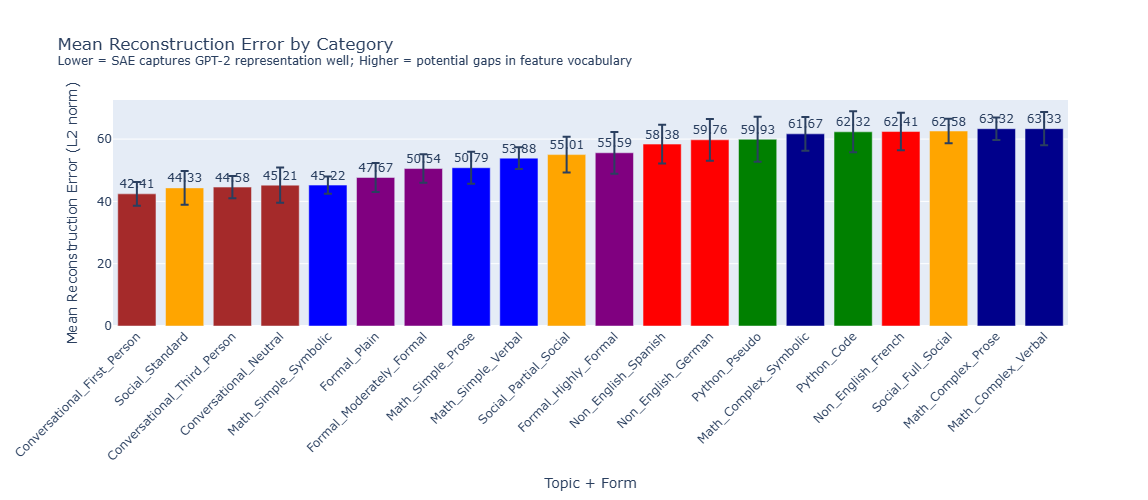

1️⃣1️⃣d Visualizing relative reconstruction error...



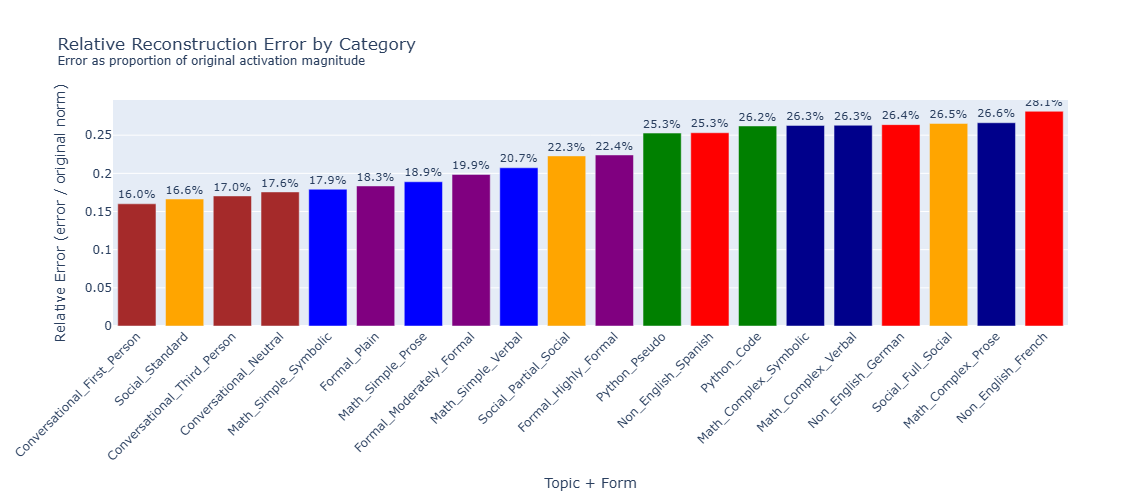


📋 RECONSTRUCTION ERROR INTERPRETATION

   Overall relative error: 22.2% ± 4.9%

   Categories with LOWEST error (SAE captures well):
      • Conversational_First_Person: 16.0%
      • Social_Standard: 16.6%
      • Conversational_Third_Person: 17.0%

   Categories with HIGHEST error (potential gaps):
      • Non_English_French: 28.1%

   Error range: 16.0% to 28.1% (spread: 12.1%)

   ⚠️ CONCLUSION: Reconstruction error shows SUBSTANTIAL variation.
      The SAE's feature vocabulary may not equally capture all text types.
      Interpret comparisons between high-error and low-error categories cautiously.



In [17]:
# -----------------------------------------------------------------------------
# Step 11: Reconstruction Error Analysis (SAE Foundation Check)
# -----------------------------------------------------------------------------
print("\n" + "=" * 70)
print("🔧 RECONSTRUCTION ERROR ANALYSIS (SAE Foundation Check)")
print("=" * 70)
print("""
How well does the SAE reconstruct GPT-2's activations for each text type?

High reconstruction error = SAE's feature vocabulary may not fully capture
what GPT-2 is doing with this input. Results should be interpreted cautiously.

Low reconstruction error = SAE captures most of GPT-2's representation.
Feature analysis provides a complete picture.
""")

# -----------------------------------------------------------------------------
# Cache Configuration for Reconstruction Error
# -----------------------------------------------------------------------------
RECON_CACHE_FILE = 'phase2_reconstruction_error.pkl'
FORCE_RECOMPUTE_RECON = False  # Set to True to recompute

# -----------------------------------------------------------------------------
# Step 11a: Compute reconstruction error for all texts (with caching)
# -----------------------------------------------------------------------------
print("1️⃣1️⃣a Computing reconstruction error for all texts...\n")

# Check for cached results
if os.path.exists(RECON_CACHE_FILE) and not FORCE_RECOMPUTE_RECON:
    print("   📂 Loading cached reconstruction error data from disk...")
    with open(RECON_CACHE_FILE, 'rb') as f:
        cached_recon = pickle.load(f)
    
    # Verify cache matches current form_analysis_configs
    cached_keys = set(cached_recon['topic_form_keys'])
    current_keys = set(form_analysis_configs.keys())
    
    if cached_keys == current_keys:
        reconstruction_data = cached_recon['reconstruction_data']
        print(f"   ✅ Loaded {len(reconstruction_data)} cached reconstruction error measurements")
    else:
        print("   ⚠️ Cache mismatch - recomputing reconstruction errors...")
        FORCE_RECOMPUTE_RECON = True

if not os.path.exists(RECON_CACHE_FILE) or FORCE_RECOMPUTE_RECON:
    print("   Computing reconstruction errors (this may take a moment)...")
    
    reconstruction_data = []
    total_texts = sum(len(config['target_texts']) for config in form_analysis_configs.values())
    processed = 0

    for target_key, config in form_analysis_configs.items():
        for text in config['target_texts']:
            # Tokenize
            tokens = model.to_tokens(text, prepend_bos=True)
            
            # Get original activations
            with torch.no_grad():
                _, cache = model.run_with_cache(tokens, names_filter=[hook_point])
            
            original_act = cache[hook_point]  # Shape: [1, seq_len, d_model]
            
            # SAE encode then decode (round-trip)
            with torch.no_grad():
                encoded = sae_obj.encode(original_act)
                reconstructed_act = sae_obj.decode(encoded)
            
            # Compute reconstruction error per token, then average
            error_per_token = torch.norm(original_act - reconstructed_act, dim=-1)  # [1, seq_len]
            
            # Average across non-BOS tokens (skip position 0)
            if error_per_token.shape[1] > 1:
                mean_error = error_per_token[0, 1:].mean().item()
            else:
                mean_error = error_per_token[0, 0].item()
            
            # Compute relative error (normalized by original activation norm)
            original_norm = torch.norm(original_act[0, 1:], dim=-1).mean().item() if original_act.shape[1] > 1 else torch.norm(original_act[0, 0]).item()
            relative_error = mean_error / original_norm if original_norm > 0 else 0
            
            reconstruction_data.append({
                'Topic': config['topic'],
                'Form': config['form'],
                'Topic_Form': target_key,
                'Text': text[:40] + '...' if len(text) > 40 else text,
                'Reconstruction_Error': mean_error,
                'Relative_Error': relative_error,
                'Original_Norm': original_norm
            })
            
            processed += 1
            if processed % 100 == 0:
                print(f"      Processed {processed}/{total_texts} texts...")
            
            # Clean up
            del cache, original_act, encoded, reconstructed_act
    
    # Save to cache
    print("   💾 Saving reconstruction error data to cache...")
    with open(RECON_CACHE_FILE, 'wb') as f:
        pickle.dump({
            'reconstruction_data': reconstruction_data,
            'topic_form_keys': list(form_analysis_configs.keys()),
            'timestamp': pd.Timestamp.now().isoformat()
        }, f)
    print(f"   ✅ Cached {len(reconstruction_data)} measurements to {RECON_CACHE_FILE}")

reconstruction_df = pd.DataFrame(reconstruction_data)

# -----------------------------------------------------------------------------
# Step 11b: Summary statistics by category
# -----------------------------------------------------------------------------
print("\n1️⃣1️⃣b Summarizing reconstruction error by category...\n")

recon_summary = reconstruction_df.groupby(['Topic', 'Form', 'Topic_Form']).agg(
    N_texts=('Reconstruction_Error', 'count'),
    Mean_Error=('Reconstruction_Error', 'mean'),
    Std_Error=('Reconstruction_Error', 'std'),
    Mean_Relative_Error=('Relative_Error', 'mean'),
    Mean_Original_Norm=('Original_Norm', 'mean')
).reset_index()

recon_summary = recon_summary.sort_values('Mean_Error', ascending=True)

print("📊 Reconstruction Error by Category (sorted by error, ascending):\n")
print(recon_summary[['Topic_Form', 'Mean_Error', 'Std_Error', 'Mean_Relative_Error']].to_string(index=False, float_format=lambda x: f"{x:.3f}"))


# -----------------------------------------------------------------------------
# Step 11c: Visualization - Absolute reconstruction error
# -----------------------------------------------------------------------------
print("\n1️⃣1️⃣c Visualizing reconstruction error...\n")

fig_recon = go.Figure()

fig_recon.add_trace(go.Bar(
    x=recon_summary['Topic_Form'],
    y=recon_summary['Mean_Error'],
    marker_color=[topic_colors.get(row['Topic'], 'gray') for _, row in recon_summary.iterrows()],
    error_y=dict(
        type='data',
        array=recon_summary['Std_Error'],
        visible=True
    ),
    text=[f"{v:.2f}" for v in recon_summary['Mean_Error']],
    textposition='outside'
))

fig_recon.update_layout(
    title='Mean Reconstruction Error by Category<br><sup>Lower = SAE captures GPT-2 representation well; Higher = potential gaps in feature vocabulary</sup>',
    xaxis_title='Topic + Form',
    yaxis_title='Mean Reconstruction Error (L2 norm)',
    height=500,
    width=900,
    xaxis_tickangle=-45
)
fig_recon.show()

# -----------------------------------------------------------------------------
# Step 11d: Visualization - Relative reconstruction error
# -----------------------------------------------------------------------------
print("1️⃣1️⃣d Visualizing relative reconstruction error...\n")

recon_summary_rel = recon_summary.sort_values('Mean_Relative_Error', ascending=True)

fig_recon_rel = go.Figure()

fig_recon_rel.add_trace(go.Bar(
    x=recon_summary_rel['Topic_Form'],
    y=recon_summary_rel['Mean_Relative_Error'],
    marker_color=[topic_colors.get(row['Topic'], 'gray') for _, row in recon_summary_rel.iterrows()],
    text=[f"{v:.1%}" for v in recon_summary_rel['Mean_Relative_Error']],
    textposition='outside'
))

fig_recon_rel.update_layout(
    title='Relative Reconstruction Error by Category<br><sup>Error as proportion of original activation magnitude</sup>',
    xaxis_title='Topic + Form',
    yaxis_title='Relative Error (error / original norm)',
    height=500,
    width=900,
    xaxis_tickangle=-45
)
fig_recon_rel.show()

# -----------------------------------------------------------------------------
# Step 11e: Interpretation
# -----------------------------------------------------------------------------
print("\n" + "=" * 70)
print("📋 RECONSTRUCTION ERROR INTERPRETATION")
print("=" * 70)

# Compute overall statistics
overall_mean = reconstruction_df['Relative_Error'].mean()
overall_std = reconstruction_df['Relative_Error'].std()

# Find categories with notably high/low error
high_error_threshold = overall_mean + overall_std
low_error_threshold = overall_mean - overall_std

high_error_cats = recon_summary[recon_summary['Mean_Relative_Error'] > high_error_threshold]['Topic_Form'].tolist()
low_error_cats = recon_summary[recon_summary['Mean_Relative_Error'] < low_error_threshold]['Topic_Form'].tolist()

print(f"\n   Overall relative error: {overall_mean:.1%} ± {overall_std:.1%}")
print(f"\n   Categories with LOWEST error (SAE captures well):")
for cat in low_error_cats[:5]:
    err = recon_summary[recon_summary['Topic_Form'] == cat]['Mean_Relative_Error'].values[0]
    print(f"      • {cat}: {err:.1%}")

print(f"\n   Categories with HIGHEST error (potential gaps):")
for cat in high_error_cats[:5]:
    err = recon_summary[recon_summary['Topic_Form'] == cat]['Mean_Relative_Error'].values[0]
    print(f"      • {cat}: {err:.1%}")

# Assess if error varies dramatically
error_range = recon_summary['Mean_Relative_Error'].max() - recon_summary['Mean_Relative_Error'].min()
max_error = recon_summary['Mean_Relative_Error'].max()
min_error = recon_summary['Mean_Relative_Error'].min()

print(f"\n   Error range: {min_error:.1%} to {max_error:.1%} (spread: {error_range:.1%})")

if error_range < 0.05:  # Less than 5 percentage points spread
    print(f"\n   ✅ CONCLUSION: Reconstruction error is CONSISTENT across categories.")
    print(f"      The SAE represents all text types with similar fidelity.")
    print(f"      Feature analysis results can be compared across categories with confidence.")
elif error_range < 0.10:
    print(f"\n   ⚠️ CONCLUSION: Reconstruction error shows MODERATE variation.")
    print(f"      Some categories may be better represented than others.")
    print(f"      Consider this when comparing results across very different text types.")
else:
    print(f"\n   ⚠️ CONCLUSION: Reconstruction error shows SUBSTANTIAL variation.")
    print(f"      The SAE's feature vocabulary may not equally capture all text types.")
    print(f"      Interpret comparisons between high-error and low-error categories cautiously.")

print("\n" + "=" * 70)


🎯 H4 ANALYSIS: BEHAVIORAL CORRELATION

Hypothesis H4: Model accuracy on mathematical completions will correlate
with specialist activation strength and vary by surface form.

If H4 is SUPPORTED: Interpretability findings (specialists detect syntax)
have direct behavioral implications (performance depends on surface form).

If H4 is NOT SUPPORTED: Specialist features may be descriptive but not
causally linked to model behavior.

Approach:
1. Create completion tasks from math_pairs (symbolic, verbal, prose forms)
2. Generate model completions
3. Evaluate correctness
4. Measure specialist activation for each input
5. Test correlation between activation and accuracy


1️⃣ Creating completion tasks from math pairs...

   Math_Simple pairs: 33
   Math_Complex pairs: 33
   Created 198 total completion tasks
   Simple: 99
   Complex: 99

2️⃣ Generating model completions...

   📂 Loading cached H4 completions from disk...
   ✅ Loaded 198 cached completions

   ✅ Generated 198 completions
   Ov

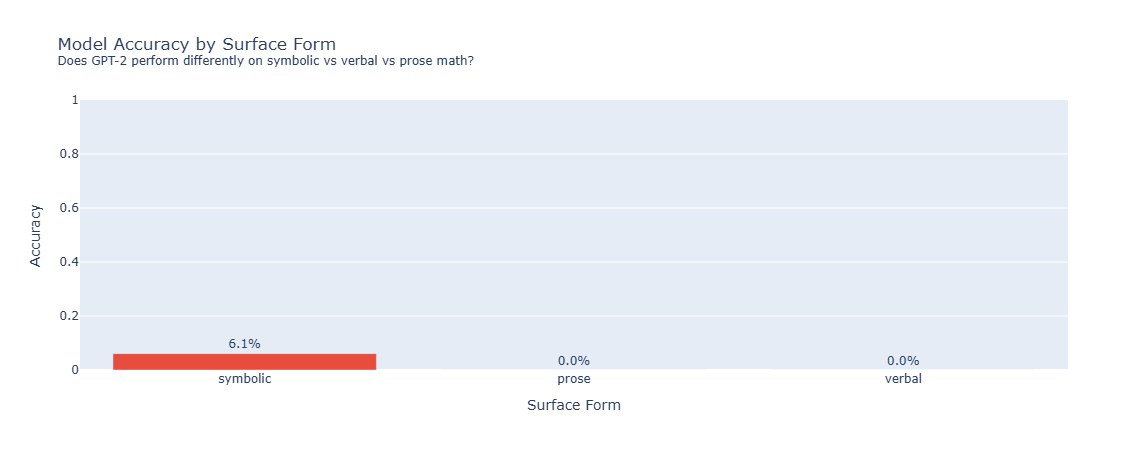

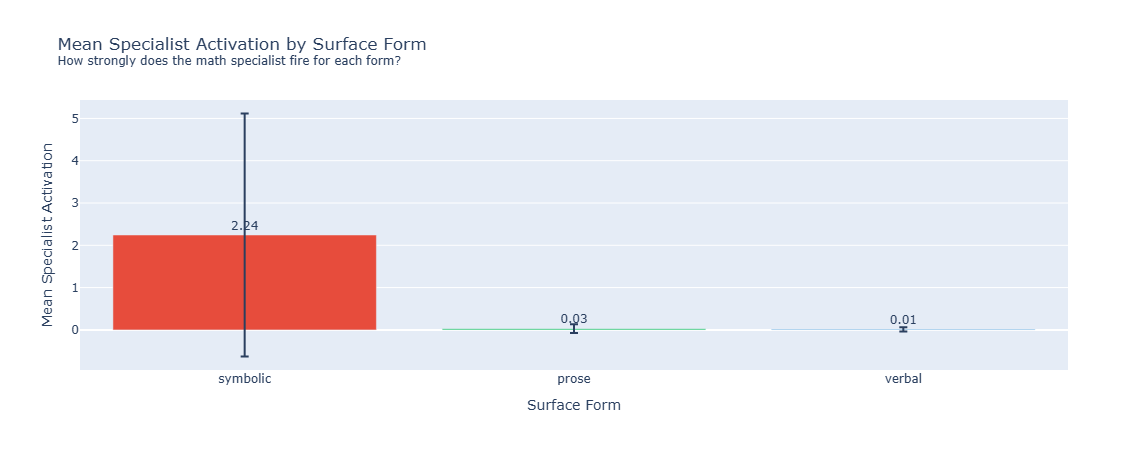

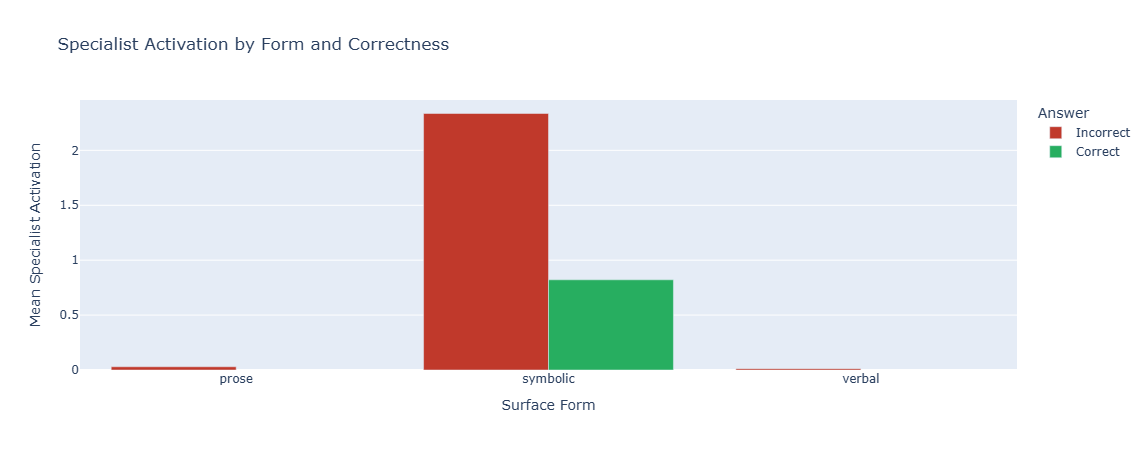

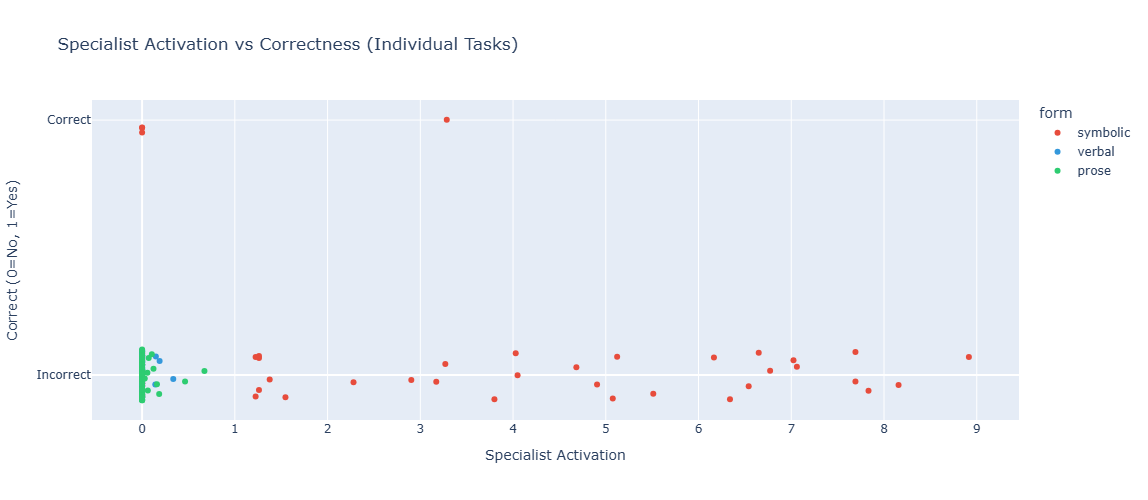

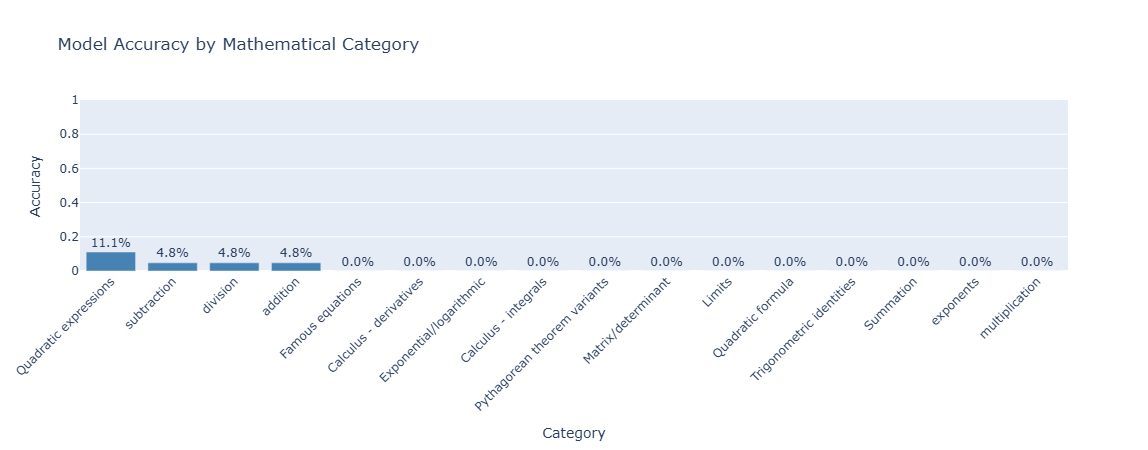


📊 H4 HYPOTHESIS ASSESSMENT

H4: Model accuracy on mathematical completions will correlate with 
specialist activation strength and vary by surface form.

FINDINGS:

   1. Accuracy by form:
      Symbolic: 6.1%
      Verbal:   0.0%
      Prose:    0.0%
      → Significant difference (χ² p = 0.0169)

   2. Specialist activation by correctness:
      Correct answers:   0.821
      Incorrect answers: 0.760
      → No significant difference (t-test p = 0.9512)

   3. Correlation (activation vs correctness):
      Point-biserial r = 0.004, p = 0.9512

----------------------------------------------------------------------
CONCLUSION:

   ⚠️ H4 PARTIALLY SUPPORTED
   • Accuracy varies by surface form
   • But full hypothesis not confirmed

----------------------------------------------------------------------
ADDITIONAL INSIGHTS:

   • Highest specialist activation: symbolic (2.24)
   • Highest accuracy: symbolic (6.1%)
   • ✓ Highest activation and highest accuracy are the SAME form



In [18]:
# ============================================================================
# CELL 27: H4 Behavioral Correlation Analysis
# ============================================================================
print("\n" + "=" * 70)
print("🎯 H4 ANALYSIS: BEHAVIORAL CORRELATION")
print("=" * 70)
print("""
Hypothesis H4: Model accuracy on mathematical completions will correlate
with specialist activation strength and vary by surface form.

If H4 is SUPPORTED: Interpretability findings (specialists detect syntax)
have direct behavioral implications (performance depends on surface form).

If H4 is NOT SUPPORTED: Specialist features may be descriptive but not
causally linked to model behavior.

Approach:
1. Create completion tasks from math_pairs (symbolic, verbal, prose forms)
2. Generate model completions
3. Evaluate correctness
4. Measure specialist activation for each input
5. Test correlation between activation and accuracy
""")

# -----------------------------------------------------------------------------
# Cache Configuration for H4 Results
# -----------------------------------------------------------------------------
H4_CACHE_FILE = 'phase2_h4_completions.pkl'
FORCE_RECOMPUTE_H4 = False  # Set to True to regenerate completions

# -----------------------------------------------------------------------------
# Step 1: Create Completion Tasks (Simple and Complex separately)
# -----------------------------------------------------------------------------
print("\n1️⃣ Creating completion tasks from math pairs...\n")

print(f"   Math_Simple pairs: {len(math_pairs_simple)}")
print(f"   Math_Complex pairs: {len(math_pairs_complex)}")

completion_tasks = []

# Process simple math pairs
for pair_idx, pair in enumerate(math_pairs_simple):
    for form in ['symbolic', 'verbal', 'prose']:
        full_expr = pair[form]
        expected = pair.get('expected', '')
        
        if not expected:
            continue
        
        if '=' in full_expr:
            prompt = full_expr.split('=')[0].strip() + ' ='
        else:
            prompt = full_expr
        
        completion_tasks.append({
            'pair_idx': pair_idx,
            'math_type': 'simple',
            'form': form,
            'category': pair.get('category', 'unknown'),
            'prompt': prompt,
            'full_expression': full_expr,
            'expected': expected
        })

# Process complex math pairs
for pair_idx, pair in enumerate(math_pairs_complex):
    for form in ['symbolic', 'verbal', 'prose']:
        full_expr = pair[form]
        expected = pair.get('expected', '')
        
        if not expected:
            continue
        
        if '=' in full_expr:
            prompt = full_expr.split('=')[0].strip() + ' ='
        else:
            prompt = full_expr
        
        completion_tasks.append({
            'pair_idx': pair_idx,
            'math_type': 'complex',
            'form': form,
            'category': pair.get('category', 'unknown'),
            'prompt': prompt,
            'full_expression': full_expr,
            'expected': expected
        })

print(f"   Created {len(completion_tasks)} total completion tasks")
print(f"   Simple: {len([t for t in completion_tasks if t['math_type'] == 'simple'])}")
print(f"   Complex: {len([t for t in completion_tasks if t['math_type'] == 'complex'])}")

# -----------------------------------------------------------------------------
# Step 2: Generate Model Completions (with caching)
# -----------------------------------------------------------------------------
print("\n2️⃣ Generating model completions...\n")

def get_completion(prompt, max_new_tokens=10):
    """Generate completion for a prompt."""
    tokens = model.to_tokens(prompt, prepend_bos=True)
    
    with torch.no_grad():
        output = model.generate(
            tokens,
            max_new_tokens=max_new_tokens,
            stop_at_eos=True,
            temperature=0
        )
    
    completion_tokens = output[0, tokens.shape[1]:]
    completion = model.tokenizer.decode(completion_tokens)
    
    return completion.strip()

def check_correctness(completion, expected):
    """Check if completion matches expected answer."""
    completion_clean = completion.lower().strip()
    expected_clean = expected.lower().strip()
    
    if expected_clean in completion_clean:
        return True
    
    if completion_clean.startswith(expected_clean):
        return True
    
    import re
    completion_nums = re.findall(r'-?\d+\.?\d*', completion_clean)
    expected_nums = re.findall(r'-?\d+\.?\d*', expected_clean)
    
    if completion_nums and expected_nums:
        try:
            if float(completion_nums[0]) == float(expected_nums[0]):
                return True
        except:
            pass
    
    return False

# Check for cached completions
if os.path.exists(H4_CACHE_FILE) and not FORCE_RECOMPUTE_H4:
    print("   📂 Loading cached H4 completions from disk...")
    with open(H4_CACHE_FILE, 'rb') as f:
        cached_h4 = pickle.load(f)
    
    # Verify cache matches current tasks (same prompts)
    cached_prompts = {t['prompt'] for t in cached_h4['completion_tasks']}
    current_prompts = {t['prompt'] for t in completion_tasks}
    
    if cached_prompts == current_prompts:
        completion_tasks = cached_h4['completion_tasks']
        print(f"   ✅ Loaded {len(completion_tasks)} cached completions")
    else:
        print("   ⚠️ Cache mismatch - regenerating completions...")
        FORCE_RECOMPUTE_H4 = True

if not os.path.exists(H4_CACHE_FILE) or FORCE_RECOMPUTE_H4:
    print("   Generating completions (this may take a moment)...")
    
    for i, task in enumerate(completion_tasks):
        if (i + 1) % 20 == 0:
            print(f"      Processed {i + 1}/{len(completion_tasks)} tasks...")
        
        completion = get_completion(task['prompt'], max_new_tokens=10)
        task['completion'] = completion
        task['correct'] = check_correctness(completion, task['expected'])
    
    # Save to cache
    print("   💾 Saving completions to cache...")
    with open(H4_CACHE_FILE, 'wb') as f:
        pickle.dump({
            'completion_tasks': completion_tasks,
            'timestamp': pd.Timestamp.now().isoformat()
        }, f)
    print(f"   ✅ Cached {len(completion_tasks)} completions to {H4_CACHE_FILE}")

print(f"\n   ✅ Generated {len(completion_tasks)} completions")

# Summary
correct_count = sum(1 for t in completion_tasks if t['correct'])
print(f"   Overall accuracy: {correct_count}/{len(completion_tasks)} ({correct_count/len(completion_tasks):.1%})")

# -----------------------------------------------------------------------------
# Step 3: Measure Specialist Activation
# -----------------------------------------------------------------------------
print("\n3️⃣ Measuring specialist activation for each prompt...\n")

# Use the math specialist from layer 11
analysis_sae = '11-res-jb'
sae_obj = loaded_saes[analysis_sae]['sae']
hook_point = loaded_saes[analysis_sae]['config']['hook_point']

# Get the math specialist feature (from earlier analysis)
# Use Math_Complex specialist as it's designed for mathematical expressions
math_specialist_idx = form_specific_specialists['Math_Complex_Symbolic'][analysis_sae]['top_n_feature_indices'][0]
print(f"   Using Math specialist feature: #{math_specialist_idx}")

for task in completion_tasks:
    # Extract features for the prompt
    features = extract_features([task['prompt']], sae_obj, hook_point)
    
    # Get activation of the math specialist
    specialist_activation = features[0, math_specialist_idx].item()
    task['specialist_activation'] = specialist_activation
    
    # Also get max activation across all features (for comparison)
    task['max_activation'] = features[0].max().item()
    
    # And L0 (number of active features)
    task['l0'] = (features[0] > 0.1).sum().item()

print("   ✅ Specialist activation measured for all tasks")

# -----------------------------------------------------------------------------
# Step 4: Build Results DataFrame
# -----------------------------------------------------------------------------
print("\n4️⃣ Building results dataframe...\n")

h4_df = pd.DataFrame(completion_tasks)

print("   Sample results:")
print(h4_df[['form', 'prompt', 'completion', 'expected', 'correct', 'specialist_activation']].head(10).to_string())

# -----------------------------------------------------------------------------
# Step 5: Analysis by Form
# -----------------------------------------------------------------------------
print("\n5️⃣ Analyzing accuracy and activation by form...\n")

form_summary = h4_df.groupby('form').agg(
    N=('correct', 'count'),
    Accuracy=('correct', 'mean'),
    Mean_Specialist_Act=('specialist_activation', 'mean'),
    Std_Specialist_Act=('specialist_activation', 'std'),
    Mean_Max_Act=('max_activation', 'mean'),
    Mean_L0=('l0', 'mean')
).reset_index()

form_summary = form_summary.sort_values('Mean_Specialist_Act', ascending=False)

print("📊 Summary by Surface Form:\n")
print(form_summary.to_string(index=False, float_format=lambda x: f"{x:.3f}"))

# -----------------------------------------------------------------------------
# Step 6: Analysis by Category
# -----------------------------------------------------------------------------
print("\n6️⃣ Analyzing accuracy and activation by category...\n")

category_summary = h4_df.groupby('category').agg(
    N=('correct', 'count'),
    Accuracy=('correct', 'mean'),
    Mean_Specialist_Act=('specialist_activation', 'mean'),
    Std_Specialist_Act=('specialist_activation', 'std')
).reset_index()

category_summary = category_summary.sort_values('Accuracy', ascending=False)

print("📊 Summary by Category:\n")
print(category_summary.to_string(index=False, float_format=lambda x: f"{x:.3f}"))

# -----------------------------------------------------------------------------
# Step 7: Statistical Tests
# -----------------------------------------------------------------------------
print("\n7️⃣ Statistical tests...\n")

from scipy import stats
from scipy.stats import pointbiserialr, spearmanr

# Test 1: Point-biserial correlation (activation vs binary correctness)
correct_activations = h4_df[h4_df['correct'] == True]['specialist_activation'].values
incorrect_activations = h4_df[h4_df['correct'] == False]['specialist_activation'].values

if len(correct_activations) > 0 and len(incorrect_activations) > 0:
    pb_corr, pb_pval = pointbiserialr(h4_df['correct'].astype(int), h4_df['specialist_activation'])
    print(f"   Point-biserial correlation (correctness vs activation):")
    print(f"      r = {pb_corr:.3f}, p = {pb_pval:.4f}")
    
    # T-test: activation difference between correct and incorrect
    t_stat, t_pval = stats.ttest_ind(correct_activations, incorrect_activations)
    print(f"\n   T-test (activation: correct vs incorrect):")
    print(f"      Correct mean: {correct_activations.mean():.3f}")
    print(f"      Incorrect mean: {incorrect_activations.mean():.3f}")
    print(f"      t = {t_stat:.3f}, p = {t_pval:.4f}")
else:
    print("   ⚠️ Cannot compute correlation - need both correct and incorrect answers")
    pb_corr, pb_pval = None, None
    t_stat, t_pval = None, None

# Test 2: Does accuracy differ by form?
print("\n   Chi-square test (accuracy by form):")
contingency = pd.crosstab(h4_df['form'], h4_df['correct'])
chi2, chi_pval, dof, expected = stats.chi2_contingency(contingency)
print(f"      χ² = {chi2:.3f}, p = {chi_pval:.4f}, dof = {dof}")

# Test 3: Spearman correlation between form's mean activation and accuracy
form_corr, form_pval = spearmanr(form_summary['Mean_Specialist_Act'], form_summary['Accuracy'])
print(f"\n   Spearman correlation (form mean activation vs form accuracy):")
print(f"      ρ = {form_corr:.3f}, p = {form_pval:.4f}")

# -----------------------------------------------------------------------------
# Step 8: Visualizations
# -----------------------------------------------------------------------------
print("\n8️⃣ Creating visualizations...\n")

# 8a: Accuracy by form
fig_acc_form = go.Figure()

form_colors = {'symbolic': '#e74c3c', 'verbal': '#3498db', 'prose': '#2ecc71'}

fig_acc_form.add_trace(go.Bar(
    x=form_summary['form'],
    y=form_summary['Accuracy'],
    marker_color=[form_colors.get(f, 'gray') for f in form_summary['form']],
    text=[f"{v:.1%}" for v in form_summary['Accuracy']],
    textposition='outside'
))

fig_acc_form.update_layout(
    title='Model Accuracy by Surface Form<br><sup>Does GPT-2 perform differently on symbolic vs verbal vs prose math?</sup>',
    xaxis_title='Surface Form',
    yaxis_title='Accuracy',
    yaxis_range=[0, 1],
    height=450,
    width=600
)
fig_acc_form.show()

# 8b: Specialist activation by form
fig_act_form = go.Figure()

fig_act_form.add_trace(go.Bar(
    x=form_summary['form'],
    y=form_summary['Mean_Specialist_Act'],
    marker_color=[form_colors.get(f, 'gray') for f in form_summary['form']],
    error_y=dict(type='data', array=form_summary['Std_Specialist_Act'], visible=True),
    text=[f"{v:.2f}" for v in form_summary['Mean_Specialist_Act']],
    textposition='outside'
))

fig_act_form.update_layout(
    title='Mean Specialist Activation by Surface Form<br><sup>How strongly does the math specialist fire for each form?</sup>',
    xaxis_title='Surface Form',
    yaxis_title='Mean Specialist Activation',
    height=450,
    width=600
)
fig_act_form.show()

# 8c: Activation vs Correctness (grouped bar)
activation_by_correct = h4_df.groupby(['form', 'correct'])['specialist_activation'].mean().reset_index()
activation_by_correct['correct_label'] = activation_by_correct['correct'].map({True: 'Correct', False: 'Incorrect'})

fig_act_correct = px.bar(
    activation_by_correct,
    x='form',
    y='specialist_activation',
    color='correct_label',
    barmode='group',
    title='Specialist Activation by Form and Correctness',
    color_discrete_map={'Correct': '#27ae60', 'Incorrect': '#c0392b'}
)

fig_act_correct.update_layout(
    xaxis_title='Surface Form',
    yaxis_title='Mean Specialist Activation',
    legend_title='Answer',
    height=450,
    width=700
)
fig_act_correct.show()

# 8d: Scatter plot - activation vs correctness (jittered)
h4_df['correct_jitter'] = h4_df['correct'].astype(int) + np.random.uniform(-0.1, 0.1, len(h4_df))

fig_scatter = px.scatter(
    h4_df,
    x='specialist_activation',
    y='correct_jitter',
    color='form',
    hover_data=['prompt', 'completion', 'expected', 'category'],
    title='Specialist Activation vs Correctness (Individual Tasks)',
    color_discrete_map=form_colors
)

fig_scatter.update_layout(
    xaxis_title='Specialist Activation',
    yaxis_title='Correct (0=No, 1=Yes)',
    yaxis_tickvals=[0, 1],
    yaxis_ticktext=['Incorrect', 'Correct'],
    height=500,
    width=800
)
fig_scatter.show()

# 8e: Accuracy by category
fig_cat = go.Figure()

fig_cat.add_trace(go.Bar(
    x=category_summary['category'],
    y=category_summary['Accuracy'],
    marker_color='steelblue',
    text=[f"{v:.1%}" for v in category_summary['Accuracy']],
    textposition='outside'
))

fig_cat.update_layout(
    title='Model Accuracy by Mathematical Category',
    xaxis_title='Category',
    yaxis_title='Accuracy',
    yaxis_range=[0, 1],
    height=450,
    width=800,
    xaxis_tickangle=-45
)
fig_cat.show()

# -----------------------------------------------------------------------------
# Step 9: H4 Assessment
# -----------------------------------------------------------------------------
print("\n" + "=" * 70)
print("📊 H4 HYPOTHESIS ASSESSMENT")
print("=" * 70)

print("""
H4: Model accuracy on mathematical completions will correlate with 
specialist activation strength and vary by surface form.
""")

# Summarize findings
print("FINDINGS:\n")

# Finding 1: Accuracy by form
symbolic_acc = form_summary[form_summary['form'] == 'symbolic']['Accuracy'].values[0]
verbal_acc = form_summary[form_summary['form'] == 'verbal']['Accuracy'].values[0]
prose_acc = form_summary[form_summary['form'] == 'prose']['Accuracy'].values[0]

print(f"   1. Accuracy by form:")
print(f"      Symbolic: {symbolic_acc:.1%}")
print(f"      Verbal:   {verbal_acc:.1%}")
print(f"      Prose:    {prose_acc:.1%}")

if chi_pval < 0.05:
    print(f"      → Significant difference (χ² p = {chi_pval:.4f})")
else:
    print(f"      → No significant difference (χ² p = {chi_pval:.4f})")

# Finding 2: Activation difference
print(f"\n   2. Specialist activation by correctness:")
if len(correct_activations) > 0 and len(incorrect_activations) > 0:
    print(f"      Correct answers:   {correct_activations.mean():.3f}")
    print(f"      Incorrect answers: {incorrect_activations.mean():.3f}")
    if t_pval is not None and t_pval < 0.05:
        print(f"      → Significant difference (t-test p = {t_pval:.4f})")
    else:
        print(f"      → No significant difference (t-test p = {t_pval:.4f})")

# Finding 3: Correlation
print(f"\n   3. Correlation (activation vs correctness):")
if pb_corr is not None:
    print(f"      Point-biserial r = {pb_corr:.3f}, p = {pb_pval:.4f}")

# Overall assessment
print("\n" + "-" * 70)
print("CONCLUSION:\n")

h4_supported = False
h4_partial = False

# Check conditions for H4 support
accuracy_varies = chi_pval < 0.05
activation_correlates = pb_pval is not None and pb_pval < 0.05 and pb_corr > 0

if accuracy_varies and activation_correlates:
    h4_supported = True
    print("   ✅ H4 SUPPORTED")
    print("   • Accuracy varies significantly by surface form")
    print("   • Higher specialist activation correlates with correctness")
    print("   • Interpretability findings have behavioral implications")
elif accuracy_varies or activation_correlates:
    h4_partial = True
    print("   ⚠️ H4 PARTIALLY SUPPORTED")
    if accuracy_varies:
        print("   • Accuracy varies by surface form")
    if activation_correlates:
        print("   • Activation correlates with correctness")
    print("   • But full hypothesis not confirmed")
else:
    print("   ❌ H4 NOT SUPPORTED")
    print("   • No significant relationship between activation and accuracy")
    print("   • Specialist features may be descriptive but not causally linked to behavior")

# Additional insights
print("\n" + "-" * 70)
print("ADDITIONAL INSIGHTS:\n")

# Which form has highest activation?
highest_act_form = form_summary.loc[form_summary['Mean_Specialist_Act'].idxmax(), 'form']
highest_act_val = form_summary['Mean_Specialist_Act'].max()
print(f"   • Highest specialist activation: {highest_act_form} ({highest_act_val:.2f})")

# Which form has highest accuracy?
highest_acc_form = form_summary.loc[form_summary['Accuracy'].idxmax(), 'form']
highest_acc_val = form_summary['Accuracy'].max()
print(f"   • Highest accuracy: {highest_acc_form} ({highest_acc_val:.1%})")

# Do they match?
if highest_act_form == highest_acc_form:
    print(f"   • ✓ Highest activation and highest accuracy are the SAME form")
else:
    print(f"   • ✗ Highest activation and highest accuracy are DIFFERENT forms")

print("\n" + "=" * 70)

In [21]:
# ============================================================================
# CELL 28: Token-Level Feature Activation by Topic+Form Specialists
# ============================================================================
print("\n" + "=" * 70)
print("🎨 TOKEN-LEVEL ACTIVATION: Topic+Form Specialists on Their Own Texts")
print("=" * 70)
print("""
For each topic+form combination, visualize how its TOP-5 specialist features
activate on the sample texts for that category. This shows exactly which
tokens trigger each specialist.

Orange highlighting = stronger activation
Hover over tokens to see exact activation values
""")

# -----------------------------------------------------------------------------
# Cache Configuration
# -----------------------------------------------------------------------------
TOKEN_CACHE_FILE = 'phase2_token_level_features.pkl'
FORCE_RECOMPUTE_TOKENS = False  # Set to True to recompute

# -----------------------------------------------------------------------------
# Step 1: Build token-level cache for all form_analysis texts (with disk caching)
# -----------------------------------------------------------------------------
print("\n1️⃣ Building token-level feature cache for all topic+form texts...\n")

analysis_sae = '11-res-jb'
sae_obj = loaded_saes[analysis_sae]['sae']
hook_point = loaded_saes[analysis_sae]['config']['hook_point']

# Check for cached results
if os.path.exists(TOKEN_CACHE_FILE) and not FORCE_RECOMPUTE_TOKENS:
    print("   📂 Loading cached token-level features from disk...")
    with open(TOKEN_CACHE_FILE, 'rb') as f:
        cached_tokens = pickle.load(f)
    
    # Verify cache matches current texts
    current_texts = set()
    for config in form_analysis_configs.values():
        current_texts.update(config['target_texts'])
    
    cached_texts = set(cached_tokens['form_token_cache'].keys())
    
    if current_texts.issubset(cached_texts):
        form_token_cache = cached_tokens['form_token_cache']
        print(f"   ✅ Loaded {len(form_token_cache)} cached token-level feature sets")
    else:
        print("   ⚠️ Cache missing some texts - recomputing...")
        FORCE_RECOMPUTE_TOKENS = True

if not os.path.exists(TOKEN_CACHE_FILE) or FORCE_RECOMPUTE_TOKENS:
    print("   Computing token-level features (this may take a moment)...")
    
    form_token_cache = {}
    
    total_texts = sum(len(config['target_texts']) for config in form_analysis_configs.values())
    processed = 0
    
    for target_key, config in form_analysis_configs.items():
        for text in config['target_texts']:
            if text not in form_token_cache:
                features, token_strs = get_token_level_features(text, sae_obj, hook_point)
                
                # Convert to CPU and store as numpy for pickling
                form_token_cache[text] = {
                    'features': features.cpu(),  # Keep as tensor but move to CPU
                    'token_strs': token_strs
                }
                processed += 1
                if processed % 50 == 0:
                    print(f"      Processed {processed}/{total_texts} texts...")
    
    # Save to cache
    print("   💾 Saving token-level features to cache...")
    with open(TOKEN_CACHE_FILE, 'wb') as f:
        pickle.dump({
            'form_token_cache': form_token_cache,
            'timestamp': pd.Timestamp.now().isoformat()
        }, f)
    print(f"   ✅ Cached {len(form_token_cache)} texts to {TOKEN_CACHE_FILE}")

print(f"   ✅ {len(form_token_cache)} unique texts ready for visualization")


# -----------------------------------------------------------------------------
# Step 2: Helper function to create highlighted HTML
# -----------------------------------------------------------------------------

def create_form_highlighted_html(text: str, feature_idx: int, color: tuple = (255, 165, 0)) -> tuple:
    """
    Create inline HTML with token highlighting using the form_token_cache.
    Returns (html_string, max_activation)
    """
    cached = form_token_cache[text]
    features = cached['features']
    token_strs = cached['token_strs']
    
    feature_acts = features[:, feature_idx].detach().numpy()
    
    max_act = feature_acts.max()
    if max_act > 0:
        normalized = feature_acts / max_act
    else:
        normalized = np.zeros_like(feature_acts)
    
    r, g, b = color
    
    html_parts = []
    for token, act_val, norm_val in zip(token_strs, feature_acts, normalized):
        safe_token = html.escape(token)
        safe_token = safe_token.replace('\n', '↵').replace('\t', '→')
        
        opacity = float(norm_val) * 0.8 + 0.1 if norm_val > 0 else 0
        bg_color = f"rgba({r}, {g}, {b}, {opacity:.2f})"
        
        html_parts.append(
            f'<span style="background-color: {bg_color}; padding: 1px 2px; '
            f'border-radius: 3px;" title="activation: {act_val:.3f}">{safe_token}</span>'
        )
    
    return ''.join(html_parts), max_act

# -----------------------------------------------------------------------------
# Step 3: Display function for a single topic+form
# -----------------------------------------------------------------------------

def display_topicform_specialist_analysis(target_key: str, max_texts: int = 5):
    """
    Display all specialists for a topic+form with token-level highlighting
    on that category's sample texts.
    """
    config = form_analysis_configs[target_key]
    specialists = form_specific_specialists[target_key][analysis_sae]
    
    topic = specialists['topic']
    form = specialists['form']
    top_features = specialists['top_n_feature_indices']
    top_specialists = specialists['top_n_specialists']
    
    # Get sample texts (limit to max_texts for readability)
    sample_texts = config['target_texts'][:max_texts]
    
    # Topic color mapping
    topic_colors_rgb = {
        'Math_Simple': (66, 133, 244),    # Blue
        'Math_Complex': (26, 35, 126),    # Dark blue
        'Python': (52, 168, 83),          # Green
        'Non_English': (234, 67, 53),     # Red
        'Social': (251, 188, 5),          # Yellow/Orange
        'Formal': (142, 36, 170),         # Purple
        'Conversational': (121, 85, 72)   # Brown
    }
    
    base_color = topic_colors_rgb.get(topic, (255, 165, 0))
    
    # Build HTML
    html_content = f"""
    <div style="margin: 30px 0; padding: 20px; border: 3px solid #333; border-radius: 12px; background: #fefefe;">
        <h2 style="margin-top: 0; color: #333; border-bottom: 2px solid #ddd; padding-bottom: 10px;">
            {target_key}
            <span style="font-size: 16px; font-weight: normal; color: #666;">
                | {len(sample_texts)} sample texts shown | Top-{len(top_features)} specialists
            </span>
        </h2>
    """
    
    # For each specialist feature
    for rank, (feature_idx, specialist_info) in enumerate(zip(top_features, top_specialists), 1):
        np_url = neuronpedia_link(analysis_sae, feature_idx)
        score = specialist_info.get('specificity_score', specialist_info.get('score', 'N/A'))
        
        # Pre-format the score to avoid f-string issues
        if isinstance(score, float):
            score_str = f"{score:.2f}"
        else:
            score_str = str(score)
        
        html_content += f"""
        <div style="margin: 20px 0; padding: 15px; border: 1px solid #ddd; border-radius: 8px; background: #f9f9f9;">
            <h4 style="margin: 0 0 10px 0;">
                Specialist #{rank}: 
                <a href="{np_url}" target="_blank" style="color: #0066cc;">Feature #{feature_idx}</a>
                <span style="font-weight: normal; color: #888; font-size: 14px;">
                    (specificity: {score_str})
                </span>
            </h4>
            <div style="font-family: monospace; font-size: 13px; line-height: 1.8;">
        """
        
        # Show each sample text with highlighting
        for text_idx, text in enumerate(sample_texts):
            highlighted_html, max_act = create_form_highlighted_html(
                text=text,
                feature_idx=feature_idx,
                color=base_color
            )
            
            html_content += f"""
                <div style="margin: 8px 0; padding: 5px; background: white; border-radius: 4px;">
                    <span style="color: #999; font-size: 11px;">[{max_act:.2f}]</span> {highlighted_html}
                </div>
            """
        
        html_content += """
            </div>
        </div>
        """
    
    html_content += "</div>"
    
    display(HTML(html_content))

# -----------------------------------------------------------------------------
# Step 4: Display for selected topic+form combinations
# -----------------------------------------------------------------------------
print("\n2️⃣ Displaying token-level specialist activations...\n")

# Filter to available categories
available_categories = [c for c in representative_categories if c in form_specific_specialists]

print(f"   Displaying {len(available_categories)} topic+form combinations")
print(f"   (showing first 5 sample texts per category)\n")

for target_key in available_categories:
    print(f"   📊 {target_key}...")
    display_topicform_specialist_analysis(target_key, max_texts=5)

# -----------------------------------------------------------------------------
# Step 5: Optional - Display ALL topic+form combinations
# -----------------------------------------------------------------------------
print("\n" + "=" * 70)
print("📋 COMPLETE LISTING (all topic+form combinations)")
print("=" * 70)

show_all = False  # Set to True to display all categories

if show_all:
    for target_key in form_specific_specialists.keys():
        print(f"\n   📊 {target_key}...")
        display_topicform_specialist_analysis(target_key, max_texts=3)
else:
    print("\n   Set show_all = True to display all topic+form combinations")
    print(f"   Available: {list(form_specific_specialists.keys())}")

print("\n" + "=" * 70)


🎨 TOKEN-LEVEL ACTIVATION: Topic+Form Specialists on Their Own Texts

For each topic+form combination, visualize how its TOP-5 specialist features
activate on the sample texts for that category. This shows exactly which
tokens trigger each specialist.

Orange highlighting = stronger activation
Hover over tokens to see exact activation values


1️⃣ Building token-level feature cache for all topic+form texts...

   📂 Loading cached token-level features from disk...
   ✅ Loaded 688 cached token-level feature sets
   ✅ 688 unique texts ready for visualization

2️⃣ Displaying token-level specialist activations...

   Displaying 8 topic+form combinations
   (showing first 5 sample texts per category)

   📊 Math_Simple_Symbolic...


   📊 Math_Simple_Verbal...


   📊 Math_Complex_Symbolic...


   📊 Python_Code...


   📊 Python_Pseudo...


   📊 Non_English_Spanish...


   📊 Conversational_Neutral...


   📊 Social_Standard...



📋 COMPLETE LISTING (all topic+form combinations)

   Set show_all = True to display all topic+form combinations
   Available: ['Math_Simple_Symbolic', 'Math_Simple_Verbal', 'Math_Simple_Prose', 'Math_Complex_Symbolic', 'Math_Complex_Verbal', 'Math_Complex_Prose', 'Python_Code', 'Python_Pseudo', 'Non_English_Spanish', 'Non_English_French', 'Non_English_German', 'Social_Full_Social', 'Social_Partial_Social', 'Social_Standard', 'Formal_Highly_Formal', 'Formal_Moderately_Formal', 'Formal_Plain', 'Conversational_First_Person', 'Conversational_Third_Person', 'Conversational_Neutral']

